In [1]:
import random, gc, os, pickle, csv, time

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML
from models.base_models_ori import LabelAwareReplayMemory

import numpy as np
import matplotlib.pyplot as plt

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"

# v. SR 
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695669.pt"
# v. SR Query
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228.pt"

# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"
# v. SR 
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695692_memory.pickle"
# v. SR Query
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854254_memory.pickle"

# For Sample Score
TRIM_ER = 500
TOTAL_EPOCH = 600
# new_memory_path, ext = os.path.splitext(memory_path)
# new_memory_path = new_memory_path + "_label" + ext

use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*10,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*1,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
#     learner.memory = pickle.load(f)
    memory_buffer = pickle.load(f)


2022-11-29 10:03:35,995 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-11-29 10:03:37,296 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-11-29 10:03:37,300 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


In [7]:
# Setting up task dict for task-aware
memory_buffer.task_dict = {
    0: list(range(5, 9)), # AG
    1: list(range(0, 5)), # Amazon
    2: list(range(0, 5)), # Yelp
    3: list(range(9, 23)), # DBPedia
    4: list(range(23, 33)), # Yahoo
}

In [8]:
# label to task converter - hack, since normally we would just use the task token/identifier
def get_task_from_label(label_idx, task_dict):
    for task_idx, class_list in task_dict.items():
        if label_idx in class_list: return task_idx
    return -1
print(get_task_from_label(8, memory_buffer.task_dict))
# Find mode: https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
def mode(array):
    return max(array, key = array.count)
# label list to task id
def get_task_from_label_list(label_list, task_dict):
    return mode([get_task_from_label(label, task_dict) for label in label_list])
print(get_task_from_label_list([1,2,32,1,4,2,0], memory_buffer.task_dict))

0
1


In [9]:
dataclass_mapper = {
    "AGNewsDataset": 0,
    "AmazonDataset": 1,
    "YelpDataset": 2,
    "DBPediaDataset": 3,
    "YahooAnswersDataset": 4
}
dataclass_mapper["AGNewsDataset"]

0

In [10]:
# Trim buffer dict to 1000 per class
memory_buffer.meta_length = 4
memory_buffer.reset_meta()
memory_buffer.trim_buffer_dict(limit_n=TRIM_ER)

In [11]:
len(memory_buffer.buffer_dict[0])

500

# Get Scores for each sample in ER

In [12]:
# Returns loss,preds,labels, labels_conf
def validate(fpln, validation_set):
    all_valid_preds, all_valid_labels, all_valid_label_conf = [], [], []
    
    for valid_text, valid_labels, _ in validation_set:        
        valid_labels = torch.tensor(valid_labels).to(device)
        valid_input_dict = learner.rln.encode_text(valid_text)
        valid_repr = learner.rln(valid_input_dict)
        valid_output = fpln(valid_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
        valid_loss = learner.loss_fn(valid_output, valid_labels)
        valid_loss = valid_loss.item()

        # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
        valid_output_softmax = F.softmax(valid_output, -1)
        valid_label_conf = valid_output_softmax[np.arange(len(valid_output_softmax)), valid_labels] # Select labels in the softmax of 33 classes

        valid_pred = models.utils.make_prediction(valid_output.detach())
        
        
        # Put in things to return
        # all_valid_losses.extend(valid_loss)
        all_valid_preds.extend(valid_pred.tolist())
        all_valid_labels.extend(valid_labels.tolist())
        all_valid_label_conf.extend(valid_label_conf.tolist())
    return all_valid_preds, all_valid_labels, all_valid_label_conf # removed loss, since no need

# Compare diff results between the unadapted vs adapted
# Returns Dictionary of class_idx -> [ a - n, ...  ] for each i (300). Can np.sum() or np.mean() later
# validate_labels = The labels (Shared)
# validate_label_conf_0 = The label conf of validate_0
# validate_label_conf_n = The label conf of validate_n
def calculate_diff_class(validate_labels, validate_label_conf_0, validate_label_conf_n, initial_dict={}, return_dict=True): 
    # Adapted confs - NonAdapted Confs (a-n)
    validate_label_conf_diff = np.array(validate_label_conf_n) - np.array(validate_label_conf_0)
    
    if return_dict:
        # The dictionary to return  class_idx -> [ a - n, ...  ] 
        return_dict = initial_dict.copy()
        for i, class_idx in enumerate(validate_labels):
            # Filter conf_diff by class
            return_dict[class_idx] = return_dict.get(class_idx, []) + [validate_label_conf_diff[i]]
        return return_dict
    
    return validate_label_conf_diff

Every Task, we do `1 = 1` batch , there are 5 tasks so `1*5 = 5` per epoch (takes around 0.05s per task ~0.25s). So we need to do it `600*16` times so that it will be ~160 minutes (9600s) and it means `5*9600 = 48,000`, and hopefully support will be around  `9600/500 ~ 19.2` per sample.

```
Adapt Time: 0.057111501693725586 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
```

```
For 9600 Epoch
Total Scoring Time: 160.0 m
```

In [13]:
TIC_score = time.time()
for epoch in range(TOTAL_EPOCH*16):
    print(f"This is epoch {epoch}/{TOTAL_EPOCH*16}")
    learner.rln.eval()
    learner.pln.train()
    
    for task_idx in memory_buffer.task_dict.keys():
        support_set = []
        #for _ in range(updates):
        for _ in range(1): # CHANGE THIS to 1 minibatch.
            text, labels, indexes = memory_buffer.read_batch_task(batch_size=1, task_idx=task_idx, \
                                                                  with_index=True, random_class=True)
            support_set.append((text, labels, indexes))
        
        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            # Test validation_set BEFORE the update (update=0)
            with torch.no_grad():
                all_valid_preds_0, all_valid_labels_0, all_valid_label_conf_0  = validate(fpln, support_set)
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels, task_indexes = [], [], []
            support_loss = []
            for text, labels, indexes in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
                task_indexes.extend(indexes)
            INNER_toc = time.time() - INNER_tic
            print("Adapt Time: "+ str(INNER_toc) +" s" )
            
            # Test validation_set AFTER ALL the update
            with torch.no_grad():
                all_valid_preds_n, all_valid_labels_n, all_valid_label_conf_n = validate(fpln, support_set)
                diff_list = calculate_diff_class(all_valid_labels_0, all_valid_label_conf_0, all_valid_label_conf_n, return_dict=False)
                memory_buffer.update_meta(all_valid_labels_0, task_indexes, \
                                          np.array(all_valid_label_conf_0), np.array(all_valid_label_conf_n), diff_list)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

TOC_score = time.time() - TIC_score 
print("Total Scoring Time: "+ str(TOC_score//60) +" m" )

This is epoch 0/9600
Adapt Time: 0.02216315269470215 s
Support set metrics: Loss = 0.0423, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02649831771850586 s
Support set metrics: Loss = 0.6597, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016504764556884766 s
Support set metrics: Loss = 0.4484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015555858612060547 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020264148712158203 s
Support set metrics: Loss = 0.1504, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1/9600
Adapt Time: 0.01755809783935547 s
Support set metrics: Loss = 0.2071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02413797378540039 s
Support set metrics: Loss = 0.7320, accuracy = 1.0000, pr

Adapt Time: 0.020696640014648438 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018288135528564453 s
Support set metrics: Loss = 0.5227, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 12/9600
Adapt Time: 0.017770767211914062 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022342920303344727 s
Support set metrics: Loss = 2.0105, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01853775978088379 s
Support set metrics: Loss = 0.0393, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0174102783203125 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019864559173583984 s
Support set metrics: Loss = 0.0829, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.020815134048461914 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02256321907043457 s
Support set metrics: Loss = 0.2256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 23/9600
Adapt Time: 0.016630887985229492 s
Support set metrics: Loss = 0.0139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019179821014404297 s
Support set metrics: Loss = 2.1269, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015775680541992188 s
Support set metrics: Loss = 1.2490, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015705585479736328 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019719600677490234 s
Support set metrics: Loss = 3.3664, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02118396759033203 s
Support set metrics: Loss = 3.9158, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 34/9600
Adapt Time: 0.017872333526611328 s
Support set metrics: Loss = 0.0311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017251014709472656 s
Support set metrics: Loss = 0.8485, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023527145385742188 s
Support set metrics: Loss = 2.6558, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019043445587158203 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019217729568481445 s
Support set metrics: Loss = 0.7126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 35/9600
Adapt Time: 0.016167640686035156 s
Support set metrics: Loss = 0.0524, accuracy = 1.000

Adapt Time: 0.026349306106567383 s
Support set metrics: Loss = 0.6231, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 45/9600
Adapt Time: 0.01671624183654785 s
Support set metrics: Loss = 0.0247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020042896270751953 s
Support set metrics: Loss = 0.5288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01735067367553711 s
Support set metrics: Loss = 0.5387, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017683982849121094 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016897916793823242 s
Support set metrics: Loss = 0.3179, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 46/9600
Adapt Time: 0.016475439071655273 s
Support set metrics: Loss = 0.0758, accuracy = 1.0000

Adapt Time: 0.027340412139892578 s
Support set metrics: Loss = 0.4420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019102811813354492 s
Support set metrics: Loss = 0.4312, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019839763641357422 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02036428451538086 s
Support set metrics: Loss = 2.0947, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 57/9600
Adapt Time: 0.018330812454223633 s
Support set metrics: Loss = 0.0151, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020900964736938477 s
Support set metrics: Loss = 0.0505, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02202892303466797 s
Support set metrics: Loss = 0.4297, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.0189511775970459 s
Support set metrics: Loss = 4.6703, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 68/9600
Adapt Time: 0.01682424545288086 s
Support set metrics: Loss = 0.0266, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016338586807250977 s
Support set metrics: Loss = 1.6111, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017130613327026367 s
Support set metrics: Loss = 0.5258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020471811294555664 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01762104034423828 s
Support set metrics: Loss = 0.2554, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 69/9600
Adapt Time: 0.01736736297607422 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, p

Adapt Time: 0.020067214965820312 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022977590560913086 s
Support set metrics: Loss = 0.1475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 80/9600
Adapt Time: 0.016553163528442383 s
Support set metrics: Loss = 0.0594, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02326798439025879 s
Support set metrics: Loss = 0.2374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021169424057006836 s
Support set metrics: Loss = 1.3068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017650842666625977 s
Support set metrics: Loss = 0.0362, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0170900821685791 s
Support set metrics: Loss = 0.5089, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01962113380432129 s
Support set metrics: Loss = 0.0193, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02485179901123047 s
Support set metrics: Loss = 1.2117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017859935760498047 s
Support set metrics: Loss = 0.4517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018773317337036133 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019532442092895508 s
Support set metrics: Loss = 0.1846, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 92/9600
Adapt Time: 0.018535375595092773 s
Support set metrics: Loss = 0.0890, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021676063537597656 s
Support set metrics: Loss = 1.4792, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.4713, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017859935760498047 s
Support set metrics: Loss = 1.6508, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016188621520996094 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015255451202392578 s
Support set metrics: Loss = 3.4704, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 103/9600
Adapt Time: 0.01619124412536621 s
Support set metrics: Loss = 0.0288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022467613220214844 s
Support set metrics: Loss = 2.0768, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021078824996948242 s
Support set metrics: Loss = 0.4411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.016713857650756836 s
Support set metrics: Loss = 0.1224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01603841781616211 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01816701889038086 s
Support set metrics: Loss = 0.7655, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 114/9600
Adapt Time: 0.015773296356201172 s
Support set metrics: Loss = 0.0487, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01702880859375 s
Support set metrics: Loss = 0.2002, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017357587814331055 s
Support set metrics: Loss = 0.8909, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01687002182006836 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, reca

Adapt Time: 0.019094228744506836 s
Support set metrics: Loss = 0.9056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01990199089050293 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01717400550842285 s
Support set metrics: Loss = 0.0479, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 125/9600
Adapt Time: 0.018691062927246094 s
Support set metrics: Loss = 0.0370, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020951271057128906 s
Support set metrics: Loss = 1.3939, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021621227264404297 s
Support set metrics: Loss = 0.4520, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020496129989624023 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.8918, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01580667495727539 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023656606674194336 s
Support set metrics: Loss = 0.0930, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 136/9600
Adapt Time: 0.015821456909179688 s
Support set metrics: Loss = 0.0494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02681756019592285 s
Support set metrics: Loss = 0.5910, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01656198501586914 s
Support set metrics: Loss = 0.8474, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016167640686035156 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.01992321014404297 s
Support set metrics: Loss = 1.2893, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01605987548828125 s
Support set metrics: Loss = 0.3011, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016916513442993164 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022116422653198242 s
Support set metrics: Loss = 0.6020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 148/9600
Adapt Time: 0.01725316047668457 s
Support set metrics: Loss = 0.0434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023998498916625977 s
Support set metrics: Loss = 2.6558, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01672959327697754 s
Support set metrics: Loss = 2.5191, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.031656742095947266 s
Support set metrics: Loss = 0.2704, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 159/9600
Adapt Time: 0.018407344818115234 s
Support set metrics: Loss = 0.0221, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021062135696411133 s
Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02729058265686035 s
Support set metrics: Loss = 0.3200, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018254756927490234 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017947673797607422 s
Support set metrics: Loss = 1.7592, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 160/9600
Adapt Time: 0.017927169799804688 s
Support set metrics: Loss = 0.0238, accuracy = 1.0

Adapt Time: 0.02316427230834961 s
Support set metrics: Loss = 0.2415, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01526784896850586 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026562213897705078 s
Support set metrics: Loss = 0.0820, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 171/9600
Adapt Time: 0.01692962646484375 s
Support set metrics: Loss = 0.0584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018132925033569336 s
Support set metrics: Loss = 1.1210, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01843571662902832 s
Support set metrics: Loss = 2.2655, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014548301696777344 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.016644716262817383 s
Support set metrics: Loss = 0.4967, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01482534408569336 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017241239547729492 s
Support set metrics: Loss = 0.0247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 182/9600
Adapt Time: 0.017176151275634766 s
Support set metrics: Loss = 0.0231, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021167755126953125 s
Support set metrics: Loss = 0.1492, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023659944534301758 s
Support set metrics: Loss = 1.6979, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017271041870117188 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01930546760559082 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021494626998901367 s
Support set metrics: Loss = 1.0155, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 193/9600
Adapt Time: 0.017375707626342773 s
Support set metrics: Loss = 0.0782, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020703554153442383 s
Support set metrics: Loss = 0.2828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0203549861907959 s
Support set metrics: Loss = 1.4225, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01881694793701172 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.036637067794799805 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.020334959030151367 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01657271385192871 s
Support set metrics: Loss = 0.5572, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018252849578857422 s
Support set metrics: Loss = 0.5649, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015604734420776367 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024547815322875977 s
Support set metrics: Loss = 0.0808, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 205/9600
Adapt Time: 0.01669788360595703 s
Support set metrics: Loss = 0.1064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015501737594604492 s
Support set metrics: Loss = 0.1369, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01749277114868164 s
Support set metrics: Loss = 0.8349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016170263290405273 s
Support set metrics: Loss = 0.3327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017001867294311523 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01791834831237793 s
Support set metrics: Loss = 2.4292, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 216/9600
Adapt Time: 0.016208648681640625 s
Support set metrics: Loss = 0.0199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015094518661499023 s
Support set metrics: Loss = 1.6808, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Support set metrics: Loss = 1.2866, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01606273651123047 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026092529296875 s
Support set metrics: Loss = 0.1213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 227/9600
Adapt Time: 0.015722036361694336 s
Support set metrics: Loss = 0.6833, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01964426040649414 s
Support set metrics: Loss = 0.7915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02984905242919922 s
Support set metrics: Loss = 1.2810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01790452003479004 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adap

Support set metrics: Loss = 0.1362, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 238/9600
Adapt Time: 0.015297889709472656 s
Support set metrics: Loss = 0.2429, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022337675094604492 s
Support set metrics: Loss = 0.3936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015720844268798828 s
Support set metrics: Loss = 1.9809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016096830368041992 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018468379974365234 s
Support set metrics: Loss = 1.3116, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 239/9600
Adapt Time: 0.015527009963989258 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.01767277717590332 s
Support set metrics: Loss = 0.0869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019710540771484375 s
Support set metrics: Loss = 1.3080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018158435821533203 s
Support set metrics: Loss = 0.3709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015647172927856445 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017798662185668945 s
Support set metrics: Loss = 0.5551, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 250/9600
Adapt Time: 0.015833139419555664 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01667642593383789 s
Support set metrics: Loss = 0.1050, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.0448, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018164634704589844 s
Support set metrics: Loss = 0.9603, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015717029571533203 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021426677703857422 s
Support set metrics: Loss = 0.0785, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 261/9600
Adapt Time: 0.015318870544433594 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01642608642578125 s
Support set metrics: Loss = 2.2485, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017457962036132812 s
Support set metrics: Loss = 0.1492, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.1002, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 272/9600
Adapt Time: 0.018508195877075195 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01897120475769043 s
Support set metrics: Loss = 0.5494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03181290626525879 s
Support set metrics: Loss = 0.3941, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019259929656982422 s
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01776909828186035 s
Support set metrics: Loss = 0.1035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 273/9600
Adapt Time: 0.018764734268188477 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0

Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02005457878112793 s
Support set metrics: Loss = 3.8725, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 284/9600
Adapt Time: 0.01627945899963379 s
Support set metrics: Loss = 0.0419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018369197845458984 s
Support set metrics: Loss = 0.8944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019148588180541992 s
Support set metrics: Loss = 0.3394, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018213272094726562 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016525983810424805 s
Support set metrics: Loss = 2.1366, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.026264667510986328 s
Support set metrics: Loss = 0.0801, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 295/9600
Adapt Time: 0.0173795223236084 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017259597778320312 s
Support set metrics: Loss = 2.1777, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01680278778076172 s
Support set metrics: Loss = 0.4379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018643617630004883 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02420330047607422 s
Support set metrics: Loss = 0.4073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 296/9600
Adapt Time: 0.016434431076049805 s
Support set metrics: Loss = 0.0674, accuracy = 1.0000

Adapt Time: 0.019936561584472656 s
Support set metrics: Loss = 4.2938, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 306/9600
Adapt Time: 0.01983022689819336 s
Support set metrics: Loss = 0.0294, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018227338790893555 s
Support set metrics: Loss = 0.0466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01853179931640625 s
Support set metrics: Loss = 0.5014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01999950408935547 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017754554748535156 s
Support set metrics: Loss = 0.3272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 307/9600
Adapt Time: 0.016746997833251953 s
Support set metrics: Loss = 0.0105, accuracy = 1.000

Support set metrics: Loss = 1.2072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 317/9600
Adapt Time: 0.01656794548034668 s
Support set metrics: Loss = 0.0480, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01589488983154297 s
Support set metrics: Loss = 0.9249, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016175270080566406 s
Support set metrics: Loss = 1.1180, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017244815826416016 s
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016755104064941406 s
Support set metrics: Loss = 0.0238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 318/9600
Adapt Time: 0.01587080955505371 s
Support set metrics: Loss = 0.0328, accuracy = 1.0000, precision = 1.0000, recall = 1.0

Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01702594757080078 s
Support set metrics: Loss = 3.1938, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 329/9600
Adapt Time: 0.015506744384765625 s
Support set metrics: Loss = 0.0130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02125263214111328 s
Support set metrics: Loss = 0.5524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024215221405029297 s
Support set metrics: Loss = 0.4519, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017795324325561523 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016862154006958008 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.02084636688232422 s
Support set metrics: Loss = 0.1239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 340/9600
Adapt Time: 0.019250869750976562 s
Support set metrics: Loss = 0.0181, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02086472511291504 s
Support set metrics: Loss = 0.2800, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019557476043701172 s
Support set metrics: Loss = 1.2691, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01917552947998047 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018999576568603516 s
Support set metrics: Loss = 1.4276, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 341/9600
Adapt Time: 0.019133567810058594 s
Support set metrics: Loss = 0.0595, accuracy = 1.000

Adapt Time: 0.02591109275817871 s
Support set metrics: Loss = 0.0231, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 351/9600
Adapt Time: 0.01695418357849121 s
Support set metrics: Loss = 0.1910, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016913414001464844 s
Support set metrics: Loss = 0.6349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023545265197753906 s
Support set metrics: Loss = 1.7527, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017073631286621094 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016934633255004883 s
Support set metrics: Loss = 3.2093, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 352/9600
Adapt Time: 0.015388011932373047 s
Support set metrics: Loss = 0.1758, accuracy = 1.00

Adapt Time: 0.01648688316345215 s
Support set metrics: Loss = 0.0294, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019193649291992188 s
Support set metrics: Loss = 0.4306, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020743608474731445 s
Support set metrics: Loss = 1.2725, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016823530197143555 s
Support set metrics: Loss = 2.4678, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02145075798034668 s
Support set metrics: Loss = 0.0659, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 363/9600
Adapt Time: 0.015659570693969727 s
Support set metrics: Loss = 0.1477, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016846656799316406 s
Support set metrics: Loss = 0.4163, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.2961, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017220497131347656 s
Support set metrics: Loss = 1.6771, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017657756805419922 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017023801803588867 s
Support set metrics: Loss = 0.0939, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 374/9600
Adapt Time: 0.01632070541381836 s
Support set metrics: Loss = 0.0176, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017887353897094727 s
Support set metrics: Loss = 0.2736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0222015380859375 s
Support set metrics: Loss = 0.4667, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016502857208251953 s
Support set metrics: Loss = 0.0839, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 385/9600
Adapt Time: 0.017264842987060547 s
Support set metrics: Loss = 0.0280, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01620340347290039 s
Support set metrics: Loss = 0.0397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016023635864257812 s
Support set metrics: Loss = 2.2594, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015741825103759766 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016928672790527344 s
Support set metrics: Loss = 0.2182, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01809406280517578 s
Support set metrics: Loss = 0.0574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018444538116455078 s
Support set metrics: Loss = 1.9530, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02368640899658203 s
Support set metrics: Loss = 0.7666, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01683664321899414 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021396636962890625 s
Support set metrics: Loss = 0.1004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 397/9600
Adapt Time: 0.016666889190673828 s
Support set metrics: Loss = 0.0191, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024538755416870117 s
Support set metrics: Loss = 0.3332, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020927906036376953 s
Support set metrics: Loss = 0.6476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022574901580810547 s
Support set metrics: Loss = 0.4831, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015140056610107422 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019765138626098633 s
Support set metrics: Loss = 1.1507, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 408/9600
Adapt Time: 0.01631927490234375 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018169403076171875 s
Support set metrics: Loss = 0.7237, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01789569854736328 s
Support set metrics: Loss = 0.6596, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 2.0096, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018342018127441406 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020947694778442383 s
Support set metrics: Loss = 0.1403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 419/9600
Adapt Time: 0.016385316848754883 s
Support set metrics: Loss = 0.0254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02072739601135254 s
Support set metrics: Loss = 2.1532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01990485191345215 s
Support set metrics: Loss = 0.6428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690053939819336 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.02087855339050293 s
Support set metrics: Loss = 0.0658, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02031564712524414 s
Support set metrics: Loss = 0.8015, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016889572143554688 s
Support set metrics: Loss = 0.8737, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01664900779724121 s
Support set metrics: Loss = 0.1222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018883228302001953 s
Support set metrics: Loss = 0.1507, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 431/9600
Adapt Time: 0.016193151473999023 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02168440818786621 s
Support set metrics: Loss = 0.0313, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01842021942138672 s
Support set metrics: Loss = 0.5621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015964031219482422 s
Support set metrics: Loss = 0.9477, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016187429428100586 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022080659866333008 s
Support set metrics: Loss = 0.0539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 442/9600
Adapt Time: 0.01670098304748535 s
Support set metrics: Loss = 0.0270, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015740633010864258 s
Support set metrics: Loss = 0.7838, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016311168670654297 s
Support set metrics: Loss = 0.1490, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01927638053894043 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0193173885345459 s
Support set metrics: Loss = 0.4929, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 453/9600
Adapt Time: 0.020272493362426758 s
Support set metrics: Loss = 6.6675, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020025253295898438 s
Support set metrics: Loss = 0.6060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.029973506927490234 s
Support set metrics: Loss = 0.3742, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020064592361450195 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02325582504272461 s
Support set metrics: Loss = 0.1224, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.02680063247680664 s
Support set metrics: Loss = 0.5581, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020871400833129883 s
Support set metrics: Loss = 1.2527, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017702579498291016 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.045377492904663086 s
Support set metrics: Loss = 0.0774, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 465/9600
Adapt Time: 0.01812148094177246 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02676081657409668 s
Support set metrics: Loss = 2.1060, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020217180252075195 s
Support set metrics: Loss = 0.0223, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017895936965942383 s
Support set metrics: Loss = 2.5724, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 476/9600
Adapt Time: 0.01714468002319336 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018701791763305664 s
Support set metrics: Loss = 0.0547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016762495040893555 s
Support set metrics: Loss = 0.8459, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017431974411010742 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025537729263305664 s
Support set metrics: Loss = 0.0759, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 477/9600
Adapt Time: 0.01604938507080078 s
Support set metrics: Loss = 0.0110, accuracy = 1.00

Adapt Time: 0.016910314559936523 s
Support set metrics: Loss = 0.2938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020629167556762695 s
Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01813340187072754 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01883411407470703 s
Support set metrics: Loss = 2.2844, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 488/9600
Adapt Time: 0.01884913444519043 s
Support set metrics: Loss = 1.5431, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016619205474853516 s
Support set metrics: Loss = 0.4780, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016904354095458984 s
Support set metrics: Loss = 0.0293, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01894688606262207 s
Support set metrics: Loss = 2.8037, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017916202545166016 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01733994483947754 s
Support set metrics: Loss = 0.0392, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 499/9600
Adapt Time: 0.016574382781982422 s
Support set metrics: Loss = 0.0403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019272565841674805 s
Support set metrics: Loss = 1.3559, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018420934677124023 s
Support set metrics: Loss = 2.6946, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01671743392944336 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020442962646484375 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01754140853881836 s
Support set metrics: Loss = 2.9055, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 510/9600
Adapt Time: 0.017180681228637695 s
Support set metrics: Loss = 0.0624, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01960444450378418 s
Support set metrics: Loss = 1.1852, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018683910369873047 s
Support set metrics: Loss = 0.8394, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017015695571899414 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020595073699951172 s
Support set metrics: Loss = 0.0922, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.0269620418548584 s
Support set metrics: Loss = 2.5073, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01687932014465332 s
Support set metrics: Loss = 1.4584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019114017486572266 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01785445213317871 s
Support set metrics: Loss = 2.4952, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 522/9600
Adapt Time: 0.01813673973083496 s
Support set metrics: Loss = 0.0376, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022028446197509766 s
Support set metrics: Loss = 0.7446, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02002716064453125 s
Support set metrics: Loss = 1.5154, accuracy = 0.0000, precision = 0.0000, rec

Adapt Time: 0.020939350128173828 s
Support set metrics: Loss = 0.4519, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015238285064697266 s
Support set metrics: Loss = 0.7297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016872882843017578 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015017032623291016 s
Support set metrics: Loss = 0.0258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 533/9600
Adapt Time: 0.016854286193847656 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018876314163208008 s
Support set metrics: Loss = 0.5009, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016155719757080078 s
Support set metrics: Loss = 0.4712, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01998424530029297 s
Support set metrics: Loss = 4.0906, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017238140106201172 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01596212387084961 s
Support set metrics: Loss = 0.2924, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 544/9600
Adapt Time: 0.015539169311523438 s
Support set metrics: Loss = 0.1545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016477108001708984 s
Support set metrics: Loss = 1.0791, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02411508560180664 s
Support set metrics: Loss = 0.0543, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016277313232421875 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.02108931541442871 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019651174545288086 s
Support set metrics: Loss = 0.2163, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01943492889404297 s
Support set metrics: Loss = 0.2644, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01848125457763672 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02371811866760254 s
Support set metrics: Loss = 0.0713, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 556/9600
Adapt Time: 0.019231557846069336 s
Support set metrics: Loss = 0.2697, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018957853317260742 s
Support set metrics: Loss = 0.7991, accuracy = 0.0000, precision = 0.0000, r

Support set metrics: Loss = 1.3368, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01769733428955078 s
Support set metrics: Loss = 0.1042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030430316925048828 s
Support set metrics: Loss = 0.5174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 567/9600
Adapt Time: 0.01697254180908203 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01902627944946289 s
Support set metrics: Loss = 0.0993, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01974940299987793 s
Support set metrics: Loss = 0.4117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018656492233276367 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
A

Adapt Time: 0.02093791961669922 s
Support set metrics: Loss = 5.0574, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020452022552490234 s
Support set metrics: Loss = 0.2392, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017329692840576172 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0233309268951416 s
Support set metrics: Loss = 4.0032, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 579/9600
Adapt Time: 0.018499374389648438 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017574787139892578 s
Support set metrics: Loss = 1.2492, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021916866302490234 s
Support set metrics: Loss = 2.0105, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.025019407272338867 s
Support set metrics: Loss = 1.1281, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021587133407592773 s
Support set metrics: Loss = 0.2634, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01937246322631836 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018785715103149414 s
Support set metrics: Loss = 2.5932, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 590/9600
Adapt Time: 0.017780303955078125 s
Support set metrics: Loss = 0.0218, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021326065063476562 s
Support set metrics: Loss = 2.8887, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019017457962036133 s
Support set metrics: Loss = 0.5335, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.6368, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 601/9600
Adapt Time: 0.016908884048461914 s
Support set metrics: Loss = 0.0139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016646385192871094 s
Support set metrics: Loss = 1.0823, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019606828689575195 s
Support set metrics: Loss = 2.5289, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015994548797607422 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01768660545349121 s
Support set metrics: Loss = 0.1341, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 602/9600
Adapt Time: 0.016289710998535156 s
Support set metrics: Loss = 0.0325, accuracy = 1.0000, precision = 1.0000, recall = 1

Support set metrics: Loss = 0.1293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 612/9600
Adapt Time: 0.016833066940307617 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01900482177734375 s
Support set metrics: Loss = 1.6421, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016347646713256836 s
Support set metrics: Loss = 3.2794, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017246723175048828 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017744779586791992 s
Support set metrics: Loss = 0.6784, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 613/9600
Adapt Time: 0.017059803009033203 s
Support set metrics: Loss = 0.0203, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.018103599548339844 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021728038787841797 s
Support set metrics: Loss = 0.4509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017476558685302734 s
Support set metrics: Loss = 0.4832, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018860578536987305 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019336462020874023 s
Support set metrics: Loss = 0.1005, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 624/9600
Adapt Time: 0.018363237380981445 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019955158233642578 s
Support set metrics: Loss = 0.4073, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.023061037063598633 s
Support set metrics: Loss = 1.6876, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016017913818359375 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196990966796875 s
Support set metrics: Loss = 0.2719, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 635/9600
Adapt Time: 0.017453670501708984 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0241696834564209 s
Support set metrics: Loss = 1.5704, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018960237503051758 s
Support set metrics: Loss = 0.4729, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018490314483642578 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.020289182662963867 s
Support set metrics: Loss = 1.5642, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016040325164794922 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016052961349487305 s
Support set metrics: Loss = 0.0402, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 646/9600
Adapt Time: 0.015873193740844727 s
Support set metrics: Loss = 0.0233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017396211624145508 s
Support set metrics: Loss = 0.8553, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01598978042602539 s
Support set metrics: Loss = 0.2795, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017090559005737305 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01613163948059082 s
Support set metrics: Loss = 1.3672, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017667770385742188 s
Support set metrics: Loss = 1.1348, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017179250717163086 s
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017928123474121094 s
Support set metrics: Loss = 0.6185, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 658/9600
Adapt Time: 0.01798534393310547 s
Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018856048583984375 s
Support set metrics: Loss = 2.5123, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.03325676918029785 s
Support set metrics: Loss = 3.8123, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 669/9600
Adapt Time: 0.017249584197998047 s
Support set metrics: Loss = 0.0265, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01731729507446289 s
Support set metrics: Loss = 1.2866, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016955137252807617 s
Support set metrics: Loss = 1.0662, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01750349998474121 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01736736297607422 s
Support set metrics: Loss = 0.2085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 670/9600
Adapt Time: 0.01616668701171875 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000,

Adapt Time: 0.01695871353149414 s
Support set metrics: Loss = 0.0731, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022417783737182617 s
Support set metrics: Loss = 0.3848, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017337322235107422 s
Support set metrics: Loss = 0.7324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016214609146118164 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01838088035583496 s
Support set metrics: Loss = 0.5917, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 681/9600
Adapt Time: 0.017591238021850586 s
Support set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017435789108276367 s
Support set metrics: Loss = 1.0579, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01813673973083496 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017781496047973633 s
Support set metrics: Loss = 0.7174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01663947105407715 s
Support set metrics: Loss = 3.3375, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015851259231567383 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016682863235473633 s
Support set metrics: Loss = 0.1556, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 692/9600
Adapt Time: 0.01713275909423828 s
Support set metrics: Loss = 0.0284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018118858337402344 s
Support set metrics: Loss = 1.1322, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.018503665924072266 s
Support set metrics: Loss = 1.3261, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01917576789855957 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019608259201049805 s
Support set metrics: Loss = 0.1490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 703/9600
Adapt Time: 0.01875758171081543 s
Support set metrics: Loss = 0.0803, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019964933395385742 s
Support set metrics: Loss = 0.7940, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020025968551635742 s
Support set metrics: Loss = 0.7940, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020453214645385742 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017495155334472656 s
Support set metrics: Loss = 2.8853, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 714/9600
Adapt Time: 0.0164949893951416 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02028942108154297 s
Support set metrics: Loss = 1.4516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018280029296875 s
Support set metrics: Loss = 2.2746, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015633583068847656 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019893169403076172 s
Support set metrics: Loss = 1.3633, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Thi

Adapt Time: 0.024694204330444336 s
Support set metrics: Loss = 0.0963, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 725/9600
Adapt Time: 0.016333341598510742 s
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019095182418823242 s
Support set metrics: Loss = 0.0733, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019167423248291016 s
Support set metrics: Loss = 0.8140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01648569107055664 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018978595733642578 s
Support set metrics: Loss = 5.2263, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 726/9600
Adapt Time: 0.016954660415649414 s
Support set metrics: Loss = 0.0308, accuracy = 1.0

Adapt Time: 0.017698287963867188 s
Support set metrics: Loss = 0.1315, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027144432067871094 s
Support set metrics: Loss = 2.5073, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02817225456237793 s
Support set metrics: Loss = 2.5079, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01840972900390625 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021331787109375 s
Support set metrics: Loss = 5.7957, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 737/9600
Adapt Time: 0.018010854721069336 s
Support set metrics: Loss = 0.1404, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0236053466796875 s
Support set metrics: Loss = 0.3755, accuracy = 1.0000, precision = 1.0000, reca

Adapt Time: 0.017818212509155273 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019620656967163086 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 748/9600
Adapt Time: 0.016576528549194336 s
Support set metrics: Loss = 0.0344, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017632246017456055 s
Support set metrics: Loss = 1.3719, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019702434539794922 s
Support set metrics: Loss = 1.0817, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017895936965942383 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017665863037109375 s
Support set metrics: Loss = 0.3579, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.0191953182220459 s
Support set metrics: Loss = 0.0309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 759/9600
Adapt Time: 0.016932964324951172 s
Support set metrics: Loss = 0.0311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017513275146484375 s
Support set metrics: Loss = 1.7633, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018434524536132812 s
Support set metrics: Loss = 0.4130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020229339599609375 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01786184310913086 s
Support set metrics: Loss = 0.1242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 760/9600
Adapt Time: 0.016646623611450195 s
Support set metrics: Loss = 0.0292, accuracy = 1.000

Adapt Time: 0.02425837516784668 s
Support set metrics: Loss = 1.0117, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 770/9600
Adapt Time: 0.0176241397857666 s
Support set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02187323570251465 s
Support set metrics: Loss = 0.5524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017072439193725586 s
Support set metrics: Loss = 2.8996, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018571853637695312 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020516157150268555 s
Support set metrics: Loss = 0.5008, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 771/9600
Adapt Time: 0.018006086349487305 s
Support set metrics: Loss = 0.0196, accuracy = 1.0000

Adapt Time: 0.02740192413330078 s
Support set metrics: Loss = 0.5102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 781/9600
Adapt Time: 0.01694011688232422 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020294904708862305 s
Support set metrics: Loss = 2.0105, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022983551025390625 s
Support set metrics: Loss = 0.4824, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018451452255249023 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017635822296142578 s
Support set metrics: Loss = 0.0810, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 782/9600
Adapt Time: 0.01674818992614746 s
Support set metrics: Loss = 0.0226, accuracy = 1.000

Adapt Time: 0.019505739212036133 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01832437515258789 s
Support set metrics: Loss = 0.2479, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01978778839111328 s
Support set metrics: Loss = 0.4807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016199827194213867 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020725488662719727 s
Support set metrics: Loss = 5.4434, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 793/9600
Adapt Time: 0.017411231994628906 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02278923988342285 s
Support set metrics: Loss = 0.2374, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 1.2117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021116256713867188 s
Support set metrics: Loss = 1.6481, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020218610763549805 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03375697135925293 s
Support set metrics: Loss = 4.5060, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 804/9600
Adapt Time: 0.01950359344482422 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026091575622558594 s
Support set metrics: Loss = 0.5910, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019354820251464844 s
Support set metrics: Loss = 2.1777, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.018501996994018555 s
Support set metrics: Loss = 0.3071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018299341201782227 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017578601837158203 s
Support set metrics: Loss = 2.5686, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 815/9600
Adapt Time: 0.017064809799194336 s
Support set metrics: Loss = 0.0411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02129054069519043 s
Support set metrics: Loss = 0.0447, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016470670700073242 s
Support set metrics: Loss = 0.2004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01636362075805664 s
Support set metrics: Loss = 0.0306, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01925802230834961 s
Support set metrics: Loss = 0.9023, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01653289794921875 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02207016944885254 s
Support set metrics: Loss = 0.0785, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 826/9600
Adapt Time: 0.015522480010986328 s
Support set metrics: Loss = 0.0258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02061772346496582 s
Support set metrics: Loss = 0.3656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017416954040527344 s
Support set metrics: Loss = 0.0375, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01609969139099121 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.02023768424987793 s
Support set metrics: Loss = 1.3308, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01968097686767578 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020018339157104492 s
Support set metrics: Loss = 0.1223, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 837/9600
Adapt Time: 0.019330739974975586 s
Support set metrics: Loss = 0.0392, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01915597915649414 s
Support set metrics: Loss = 0.3356, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030518054962158203 s
Support set metrics: Loss = 0.6541, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01853656768798828 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.016674280166625977 s
Support set metrics: Loss = 0.0189, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019350290298461914 s
Support set metrics: Loss = 0.3201, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018749713897705078 s
Support set metrics: Loss = 0.0584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018126249313354492 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017113447189331055 s
Support set metrics: Loss = 0.1640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 849/9600
Adapt Time: 0.017772197723388672 s
Support set metrics: Loss = 0.0492, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01878070831298828 s
Support set metrics: Loss = 0.2466, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 1.4213, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019864797592163086 s
Support set metrics: Loss = 2.6211, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015758037567138672 s
Support set metrics: Loss = 0.3968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015999794006347656 s
Support set metrics: Loss = 0.4920, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016108989715576172 s
Support set metrics: Loss = 0.3541, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 860/9600
Adapt Time: 0.01683664321899414 s
Support set metrics: Loss = 0.0264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01551198959350586 s
Support set metrics: Loss = 0.3091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.02179574966430664 s
Support set metrics: Loss = 0.9396, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015728235244750977 s
Support set metrics: Loss = 0.3199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01618814468383789 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01964569091796875 s
Support set metrics: Loss = 1.9090, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 871/9600
Adapt Time: 0.019718170166015625 s
Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018735647201538086 s
Support set metrics: Loss = 0.9821, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019257068634033203 s
Support set metrics: Loss = 0.3233, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017466306686401367 s
Support set metrics: Loss = 1.0006, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015839815139770508 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021420001983642578 s
Support set metrics: Loss = 0.9894, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 882/9600
Adapt Time: 0.01699209213256836 s
Support set metrics: Loss = 0.1774, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020981311798095703 s
Support set metrics: Loss = 1.5642, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017463207244873047 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017746448516845703 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018538951873779297 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017819643020629883 s
Support set metrics: Loss = 2.3807, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 893/9600
Adapt Time: 0.016797542572021484 s
Support set metrics: Loss = 3.0515, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018451929092407227 s
Support set metrics: Loss = 0.7593, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0191347599029541 s
Support set metrics: Loss = 0.4121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017994165420532227 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01702117919921875 s
Support set metrics: Loss = 0.1026, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018538713455200195 s
Support set metrics: Loss = 0.5133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017145156860351562 s
Support set metrics: Loss = 2.5065, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015862703323364258 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017685890197753906 s
Support set metrics: Loss = 2.1928, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 905/9600
Adapt Time: 0.01835465431213379 s
Support set metrics: Loss = 0.1805, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015043258666992188 s
Support set metrics: Loss = 0.0303, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01573491096496582 s
Support set metrics: Loss = 1.6859, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.0191192626953125 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019312143325805664 s
Support set metrics: Loss = 0.4171, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 916/9600
Adapt Time: 0.018592119216918945 s
Support set metrics: Loss = 0.0547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023743152618408203 s
Support set metrics: Loss = 1.1791, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01970362663269043 s
Support set metrics: Loss = 1.7881, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017888307571411133 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021497488021850586 s
Support set metrics: Loss = 0.1379, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01689600944519043 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018536806106567383 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019910335540771484 s
Support set metrics: Loss = 0.6291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016778945922851562 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020337343215942383 s
Support set metrics: Loss = 0.3292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 928/9600
Adapt Time: 0.016841411590576172 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017211437225341797 s
Support set metrics: Loss = 0.1913, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016901254653930664 s
Support set metrics: Loss = 0.0246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02081465721130371 s
Support set metrics: Loss = 0.0704, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017298221588134766 s
Support set metrics: Loss = 1.3559, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0178377628326416 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01752924919128418 s
Support set metrics: Loss = 3.5673, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 939/9600
Adapt Time: 0.01578831672668457 s
Support set metrics: Loss = 0.3212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017917871475219727 s
Support set metrics: Loss = 0.9408, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.018884658813476562 s
Support set metrics: Loss = 0.5800, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017998695373535156 s
Support set metrics: Loss = 4.2080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01763606071472168 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017934560775756836 s
Support set metrics: Loss = 0.6755, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 950/9600
Adapt Time: 0.018795490264892578 s
Support set metrics: Loss = 0.0190, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01903223991394043 s
Support set metrics: Loss = 0.5461, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018850088119506836 s
Support set metrics: Loss = 1.6673, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02312159538269043 s
Support set metrics: Loss = 1.6312, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02148580551147461 s
Support set metrics: Loss = 0.0659, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018286466598510742 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021584510803222656 s
Support set metrics: Loss = 0.1347, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 961/9600
Adapt Time: 0.01758408546447754 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016469955444335938 s
Support set metrics: Loss = 0.6226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016471385955810547 s
Support set metrics: Loss = 0.6017, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.023250818252563477 s
Support set metrics: Loss = 0.0918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01723504066467285 s
Support set metrics: Loss = 1.6133, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01759028434753418 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02358412742614746 s
Support set metrics: Loss = 1.8103, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 972/9600
Adapt Time: 0.01729750633239746 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01831793785095215 s
Support set metrics: Loss = 1.8445, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020671367645263672 s
Support set metrics: Loss = 0.4445, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.022011756896972656 s
Support set metrics: Loss = 0.9358, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019783735275268555 s
Support set metrics: Loss = 1.0976, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017986536026000977 s
Support set metrics: Loss = 0.0086, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01869511604309082 s
Support set metrics: Loss = 0.1180, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 983/9600
Adapt Time: 0.01909160614013672 s
Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.038054466247558594 s
Support set metrics: Loss = 1.4929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02131056785583496 s
Support set metrics: Loss = 1.9705, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.020162343978881836 s
Support set metrics: Loss = 0.0258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 994/9600
Adapt Time: 0.016571760177612305 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01710963249206543 s
Support set metrics: Loss = 1.4442, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020624876022338867 s
Support set metrics: Loss = 0.5861, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018233299255371094 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016683340072631836 s
Support set metrics: Loss = 0.0778, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 995/9600
Adapt Time: 0.01674056053161621 s
Support set metrics: Loss = 0.0132, accuracy = 1.00

Support set metrics: Loss = 1.1896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01713252067565918 s
Support set metrics: Loss = 0.0653, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018695831298828125 s
Support set metrics: Loss = 0.1531, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1006/9600
Adapt Time: 0.017322778701782227 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019133806228637695 s
Support set metrics: Loss = 2.7101, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01979207992553711 s
Support set metrics: Loss = 0.8430, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01801443099975586 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.018572092056274414 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019334077835083008 s
Support set metrics: Loss = 0.0416, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1017/9600
Adapt Time: 0.017861604690551758 s
Support set metrics: Loss = 0.0744, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021735668182373047 s
Support set metrics: Loss = 0.7836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02228236198425293 s
Support set metrics: Loss = 1.0579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01868462562561035 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03076791763305664 s
Support set metrics: Loss = 0.0662, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.9039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1028/9600
Adapt Time: 0.015864133834838867 s
Support set metrics: Loss = 0.0209, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016802310943603516 s
Support set metrics: Loss = 1.6917, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019323348999023438 s
Support set metrics: Loss = 1.0082, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01678180694580078 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01900339126586914 s
Support set metrics: Loss = 0.1531, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1029/9600
Adapt Time: 0.016664743423461914 s
Support set metrics: Loss = 0.0201, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.017052650451660156 s
Support set metrics: Loss = 0.0414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02011728286743164 s
Support set metrics: Loss = 0.6897, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02611398696899414 s
Support set metrics: Loss = 0.6456, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0168154239654541 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016815185546875 s
Support set metrics: Loss = 0.2739, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1040/9600
Adapt Time: 0.016023874282836914 s
Support set metrics: Loss = 0.4138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01927781105041504 s
Support set metrics: Loss = 1.4368, accuracy = 0.0000, precision = 0.0000, reca

Adapt Time: 0.018486499786376953 s
Support set metrics: Loss = 0.6532, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01865530014038086 s
Support set metrics: Loss = 1.4792, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016958236694335938 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690673828125 s
Support set metrics: Loss = 0.1310, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1051/9600
Adapt Time: 0.017688274383544922 s
Support set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019009113311767578 s
Support set metrics: Loss = 0.3168, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018279075622558594 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.024242639541625977 s
Support set metrics: Loss = 0.1263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1062/9600
Adapt Time: 0.017246007919311523 s
Support set metrics: Loss = 0.0216, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017864704132080078 s
Support set metrics: Loss = 0.6140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016605138778686523 s
Support set metrics: Loss = 0.3835, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01998424530029297 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01668715476989746 s
Support set metrics: Loss = 0.0328, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1063/9600
Adapt Time: 0.017193317413330078 s
Support set metrics: Loss = 0.0645, accuracy = 1.

Support set metrics: Loss = 0.0990, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1073/9600
Adapt Time: 0.01616191864013672 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018924713134765625 s
Support set metrics: Loss = 0.8238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01646590232849121 s
Support set metrics: Loss = 1.2691, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01702117919921875 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017215728759765625 s
Support set metrics: Loss = 0.0316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1074/9600
Adapt Time: 0.01587080955505371 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.

Support set metrics: Loss = 0.2485, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1084/9600
Adapt Time: 0.015429973602294922 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016627788543701172 s
Support set metrics: Loss = 1.3105, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02810955047607422 s
Support set metrics: Loss = 0.8760, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017275333404541016 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018882036209106445 s
Support set metrics: Loss = 0.0798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1085/9600
Adapt Time: 0.01579141616821289 s
Support set metrics: Loss = 0.0470, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.019310951232910156 s
Support set metrics: Loss = 1.6014, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0175931453704834 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01855325698852539 s
Support set metrics: Loss = 0.6784, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1096/9600
Adapt Time: 0.016965627670288086 s
Support set metrics: Loss = 0.1269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020551443099975586 s
Support set metrics: Loss = 1.4437, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017151832580566406 s
Support set metrics: Loss = 0.5123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015878915786743164 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019397974014282227 s
Support set metrics: Loss = 0.5493, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018663883209228516 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018651485443115234 s
Support set metrics: Loss = 2.6375, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1107/9600
Adapt Time: 0.01691126823425293 s
Support set metrics: Loss = 0.0408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020134687423706055 s
Support set metrics: Loss = 2.3809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020377159118652344 s
Support set metrics: Loss = 0.5556, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01673150062561035 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020348310470581055 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017829418182373047 s
Support set metrics: Loss = 0.5552, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1118/9600
Adapt Time: 0.017050743103027344 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01830291748046875 s
Support set metrics: Loss = 0.1173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025206327438354492 s
Support set metrics: Loss = 0.5661, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01750969886779785 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020397424697875977 s
Support set metrics: Loss = 0.1724, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02015209197998047 s
Support set metrics: Loss = 0.0248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02049732208251953 s
Support set metrics: Loss = 2.1580, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018154382705688477 s
Support set metrics: Loss = 1.6345, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01915597915649414 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020011186599731445 s
Support set metrics: Loss = 0.2875, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1130/9600
Adapt Time: 0.01771068572998047 s
Support set metrics: Loss = 0.0213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02827286720275879 s
Support set metrics: Loss = 1.8879, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.018500089645385742 s
Support set metrics: Loss = 0.0259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01980447769165039 s
Support set metrics: Loss = 0.7783, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01884317398071289 s
Support set metrics: Loss = 1.5433, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017188549041748047 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01723194122314453 s
Support set metrics: Loss = 0.0379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1141/9600
Adapt Time: 0.01636362075805664 s
Support set metrics: Loss = 0.0145, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017206430435180664 s
Support set metrics: Loss = 0.1966, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01665639877319336 s
Support set metrics: Loss = 2.6118, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018570899963378906 s
Support set metrics: Loss = 0.7218, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018617630004882812 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020525217056274414 s
Support set metrics: Loss = 0.0280, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1152/9600
Adapt Time: 0.01812744140625 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019944429397583008 s
Support set metrics: Loss = 0.5506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017634153366088867 s
Support set metrics: Loss = 1.6540, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.021075010299682617 s
Support set metrics: Loss = 0.8714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02112412452697754 s
Support set metrics: Loss = 1.0838, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02048039436340332 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022347450256347656 s
Support set metrics: Loss = 0.1032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1163/9600
Adapt Time: 0.01935744285583496 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019514083862304688 s
Support set metrics: Loss = 0.7275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0299222469329834 s
Support set metrics: Loss = 0.6456, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.018573284149169922 s
Support set metrics: Loss = 0.2047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1174/9600
Adapt Time: 0.017338275909423828 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017647981643676758 s
Support set metrics: Loss = 1.5112, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01708054542541504 s
Support set metrics: Loss = 0.8851, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019828081130981445 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016120195388793945 s
Support set metrics: Loss = 0.0322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1175/9600
Adapt Time: 0.019001245498657227 s
Support set metrics: Loss = 1.8723, accuracy = 0

Support set metrics: Loss = 1.3220, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016688823699951172 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019965648651123047 s
Support set metrics: Loss = 0.1038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1186/9600
Adapt Time: 0.016405582427978516 s
Support set metrics: Loss = 0.0240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017713546752929688 s
Support set metrics: Loss = 0.5335, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01682305335998535 s
Support set metrics: Loss = 0.8107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018003463745117188 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.01810622215270996 s
Support set metrics: Loss = 0.0816, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018681764602661133 s
Support set metrics: Loss = 1.3882, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018688678741455078 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019381284713745117 s
Support set metrics: Loss = 0.1423, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1198/9600
Adapt Time: 0.01965498924255371 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018829822540283203 s
Support set metrics: Loss = 0.0309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021001100540161133 s
Support set metrics: Loss = 0.7711, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01884937286376953 s
Support set metrics: Loss = 0.2834, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1209/9600
Adapt Time: 0.017088651657104492 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022974729537963867 s
Support set metrics: Loss = 1.5004, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016294240951538086 s
Support set metrics: Loss = 0.0586, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019109725952148438 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018788576126098633 s
Support set metrics: Loss = 0.0776, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1210/9600
Adapt Time: 0.017140865325927734 s
Support set metrics: Loss = 0.0097, accuracy = 1

Adapt Time: 0.025075912475585938 s
Support set metrics: Loss = 0.1062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1220/9600
Adapt Time: 0.01550436019897461 s
Support set metrics: Loss = 0.6574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01731276512145996 s
Support set metrics: Loss = 0.9198, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015729904174804688 s
Support set metrics: Loss = 0.2451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01966547966003418 s
Support set metrics: Loss = 0.0364, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017470836639404297 s
Support set metrics: Loss = 0.0778, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1221/9600
Adapt Time: 0.016032934188842773 s
Support set metrics: Loss = 0.0749, accuracy = 1.0

Adapt Time: 0.019775867462158203 s
Support set metrics: Loss = 0.1383, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1231/9600
Adapt Time: 0.02015995979309082 s
Support set metrics: Loss = 2.0576, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0198366641998291 s
Support set metrics: Loss = 2.2485, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024547100067138672 s
Support set metrics: Loss = 0.0465, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018274784088134766 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019047260284423828 s
Support set metrics: Loss = 0.1700, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1232/9600
Adapt Time: 0.018545150756835938 s
Support set metrics: Loss = 0.0336, accuracy = 1.0

Adapt Time: 0.020019054412841797 s
Support set metrics: Loss = 0.3499, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020156145095825195 s
Support set metrics: Loss = 0.6043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020091772079467773 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020223379135131836 s
Support set metrics: Loss = 3.5275, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1243/9600
Adapt Time: 0.018341541290283203 s
Support set metrics: Loss = 0.0513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01797175407409668 s
Support set metrics: Loss = 0.9053, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018230676651000977 s
Support set metrics: Loss = 0.2605, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 1.8716, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017683029174804688 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01981210708618164 s
Support set metrics: Loss = 1.2924, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1254/9600
Adapt Time: 0.015181541442871094 s
Support set metrics: Loss = 0.0203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015451669692993164 s
Support set metrics: Loss = 0.3071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01672506332397461 s
Support set metrics: Loss = 0.6438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017648935317993164 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.023802995681762695 s
Support set metrics: Loss = 5.1967, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1265/9600
Adapt Time: 0.01664876937866211 s
Support set metrics: Loss = 0.0650, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016707897186279297 s
Support set metrics: Loss = 0.5300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019641399383544922 s
Support set metrics: Loss = 3.1601, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018214702606201172 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019655704498291016 s
Support set metrics: Loss = 2.5787, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1266/9600
Adapt Time: 0.01681375503540039 s
Support set metrics: Loss = 0.0887, accuracy = 1.

Adapt Time: 0.02028036117553711 s
Support set metrics: Loss = 0.2283, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1276/9600
Adapt Time: 0.018113374710083008 s
Support set metrics: Loss = 0.0549, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01641082763671875 s
Support set metrics: Loss = 0.1265, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019014358520507812 s
Support set metrics: Loss = 0.3903, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019759416580200195 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017721176147460938 s
Support set metrics: Loss = 3.4382, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1277/9600
Adapt Time: 0.017015933990478516 s
Support set metrics: Loss = 0.0400, accuracy = 1.

Adapt Time: 0.018935203552246094 s
Support set metrics: Loss = 1.8641, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1287/9600
Adapt Time: 0.016424179077148438 s
Support set metrics: Loss = 1.3217, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01876354217529297 s
Support set metrics: Loss = 2.8887, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019163131713867188 s
Support set metrics: Loss = 0.8673, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01896381378173828 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022507905960083008 s
Support set metrics: Loss = 3.8725, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1288/9600
Adapt Time: 0.017121076583862305 s
Support set metrics: Loss = 0.0094, accuracy = 1.

Adapt Time: 0.019328832626342773 s
Support set metrics: Loss = 0.1735, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1298/9600
Adapt Time: 0.018123865127563477 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016289949417114258 s
Support set metrics: Loss = 0.5791, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017352819442749023 s
Support set metrics: Loss = 0.0730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01895308494567871 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02992081642150879 s
Support set metrics: Loss = 0.5371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1299/9600
Adapt Time: 0.01697707176208496 s
Support set metrics: Loss = 0.0118, accuracy = 1.0

Adapt Time: 0.02129817008972168 s
Support set metrics: Loss = 0.1751, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01853156089782715 s
Support set metrics: Loss = 0.0345, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019112825393676758 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018529891967773438 s
Support set metrics: Loss = 1.6777, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1310/9600
Adapt Time: 0.019188880920410156 s
Support set metrics: Loss = 0.0305, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019556522369384766 s
Support set metrics: Loss = 0.5274, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0179135799407959 s
Support set metrics: Loss = 1.1295, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.02095317840576172 s
Support set metrics: Loss = 0.5153, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017125368118286133 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01786518096923828 s
Support set metrics: Loss = 0.4414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1321/9600
Adapt Time: 0.016647815704345703 s
Support set metrics: Loss = 0.0863, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021986722946166992 s
Support set metrics: Loss = 0.9159, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018132925033569336 s
Support set metrics: Loss = 1.9268, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018655776977539062 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 2.8605, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016793012619018555 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016315937042236328 s
Support set metrics: Loss = 0.0571, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1332/9600
Adapt Time: 0.016652822494506836 s
Support set metrics: Loss = 0.0648, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015926599502563477 s
Support set metrics: Loss = 1.6703, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01825714111328125 s
Support set metrics: Loss = 0.0656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016435623168945312 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.018794536590576172 s
Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018471956253051758 s
Support set metrics: Loss = 0.0674, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017045974731445312 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01635885238647461 s
Support set metrics: Loss = 0.1519, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1344/9600
Adapt Time: 0.017157793045043945 s
Support set metrics: Loss = 0.0451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020681142807006836 s
Support set metrics: Loss = 0.2690, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01691603660583496 s
Support set metrics: Loss = 0.6148, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02150130271911621 s
Support set metrics: Loss = 1.6011, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017460346221923828 s
Support set metrics: Loss = 0.8091, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01664876937866211 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021265745162963867 s
Support set metrics: Loss = 0.0537, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1355/9600
Adapt Time: 0.016003131866455078 s
Support set metrics: Loss = 2.6047, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017039775848388672 s
Support set metrics: Loss = 0.3603, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01691412925720215 s
Support set metrics: Loss = 0.6302, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018175840377807617 s
Support set metrics: Loss = 0.7833, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015362262725830078 s
Support set metrics: Loss = 2.1605, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015624523162841797 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018430471420288086 s
Support set metrics: Loss = 0.1506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1366/9600
Adapt Time: 0.016765832901000977 s
Support set metrics: Loss = 0.0247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016722440719604492 s
Support set metrics: Loss = 0.6675, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01631927490234375 s
Support set metrics: Loss = 0.0627, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018746614456176758 s
Support set metrics: Loss = 0.0317, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1377/9600
Adapt Time: 0.018368244171142578 s
Support set metrics: Loss = 0.0462, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018635272979736328 s
Support set metrics: Loss = 1.3357, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02134561538696289 s
Support set metrics: Loss = 1.2323, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018223047256469727 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019434452056884766 s
Support set metrics: Loss = 0.2794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.9517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019145488739013672 s
Support set metrics: Loss = 0.6511, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01742386817932129 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018388032913208008 s
Support set metrics: Loss = 0.8026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1389/9600
Adapt Time: 0.01773977279663086 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020175695419311523 s
Support set metrics: Loss = 1.0713, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018215656280517578 s
Support set metrics: Loss = 0.5386, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.019098281860351562 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019708871841430664 s
Support set metrics: Loss = 0.7971, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018111705780029297 s
Support set metrics: Loss = 1.3219, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016993284225463867 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019649267196655273 s
Support set metrics: Loss = 0.2875, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1401/9600
Adapt Time: 0.019452810287475586 s
Support set metrics: Loss = 0.0174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857447624206543 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.020128250122070312 s
Support set metrics: Loss = 2.0627, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01937127113342285 s
Support set metrics: Loss = 1.7830, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018321514129638672 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019632339477539062 s
Support set metrics: Loss = 0.0321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1412/9600
Adapt Time: 0.01935744285583496 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021004438400268555 s
Support set metrics: Loss = 1.0713, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019545555114746094 s
Support set metrics: Loss = 2.3467, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.02032470703125 s
Support set metrics: Loss = 0.2994, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018556833267211914 s
Support set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019388914108276367 s
Support set metrics: Loss = 1.5386, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1423/9600
Adapt Time: 0.017171621322631836 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01954483985900879 s
Support set metrics: Loss = 0.6597, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019756793975830078 s
Support set metrics: Loss = 0.0792, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016993284225463867 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01668524742126465 s
Support set metrics: Loss = 0.0151, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019678831100463867 s
Support set metrics: Loss = 0.8798, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01660299301147461 s
Support set metrics: Loss = 1.0353, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017788171768188477 s
Support set metrics: Loss = 0.0735, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0190274715423584 s
Support set metrics: Loss = 0.0798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1435/9600
Adapt Time: 0.01694464683532715 s
Support set metrics: Loss = 0.1955, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019456148147583008 s
Support set metrics: Loss = 0.6428, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01916337013244629 s
Support set metrics: Loss = 0.4029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024272918701171875 s
Support set metrics: Loss = 1.0115, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019718647003173828 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022070884704589844 s
Support set metrics: Loss = 0.9202, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1446/9600
Adapt Time: 0.01906561851501465 s
Support set metrics: Loss = 0.0308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01901721954345703 s
Support set metrics: Loss = 0.2466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018537044525146484 s
Support set metrics: Loss = 0.7048, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019321441650390625 s
Support set metrics: Loss = 1.6430, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01679849624633789 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01876688003540039 s
Support set metrics: Loss = 4.4186, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1457/9600
Adapt Time: 0.015894651412963867 s
Support set metrics: Loss = 0.0513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01687908172607422 s
Support set metrics: Loss = 0.6873, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022397756576538086 s
Support set metrics: Loss = 0.5013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015783309936523438 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.1210, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1468/9600
Adapt Time: 0.018526792526245117 s
Support set metrics: Loss = 0.0238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020659208297729492 s
Support set metrics: Loss = 0.8388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018981456756591797 s
Support set metrics: Loss = 0.6060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020153284072875977 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01871323585510254 s
Support set metrics: Loss = 0.1104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1469/9600
Adapt Time: 0.018154621124267578 s
Support set metrics: Loss = 4.7684, accuracy = 0.0000, precision = 0.0000, recall =

Adapt Time: 0.02294325828552246 s
Support set metrics: Loss = 0.7561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021211624145507812 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01956796646118164 s
Support set metrics: Loss = 0.1934, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1480/9600
Adapt Time: 0.019474506378173828 s
Support set metrics: Loss = 0.0887, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019901275634765625 s
Support set metrics: Loss = 0.5056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196535587310791 s
Support set metrics: Loss = 1.1348, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018650054931640625 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018433332443237305 s
Support set metrics: Loss = 0.0471, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01974630355834961 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021485090255737305 s
Support set metrics: Loss = 0.7502, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1491/9600
Adapt Time: 0.018036842346191406 s
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017965316772460938 s
Support set metrics: Loss = 1.4386, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017158985137939453 s
Support set metrics: Loss = 0.0289, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017179250717163086 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.016914844512939453 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021355867385864258 s
Support set metrics: Loss = 0.1308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1502/9600
Adapt Time: 0.017721176147460938 s
Support set metrics: Loss = 0.9869, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0172119140625 s
Support set metrics: Loss = 0.9881, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017335891723632812 s
Support set metrics: Loss = 0.6950, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018130779266357422 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018434524536132812 s
Support set metrics: Loss = 0.1191, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01913928985595703 s
Support set metrics: Loss = 1.5506, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1513/9600
Adapt Time: 0.01670241355895996 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01825690269470215 s
Support set metrics: Loss = 0.9342, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017937660217285156 s
Support set metrics: Loss = 1.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02084040641784668 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024877071380615234 s
Support set metrics: Loss = 0.2276, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1514/9600
Adapt Time: 0.01866459846496582 s
Support set metrics: Loss = 0.0153, accuracy = 1.000

Adapt Time: 0.018905162811279297 s
Support set metrics: Loss = 0.8269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017337322235107422 s
Support set metrics: Loss = 0.7959, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018921613693237305 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019112825393676758 s
Support set metrics: Loss = 1.6701, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1525/9600
Adapt Time: 0.018932819366455078 s
Support set metrics: Loss = 0.0147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01925945281982422 s
Support set metrics: Loss = 0.7872, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017174482345581055 s
Support set metrics: Loss = 0.0935, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.021419286727905273 s
Support set metrics: Loss = 0.1253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857781410217285 s
Support set metrics: Loss = 1.3727, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018556594848632812 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020936250686645508 s
Support set metrics: Loss = 2.3364, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1536/9600
Adapt Time: 0.018433094024658203 s
Support set metrics: Loss = 0.0269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0201568603515625 s
Support set metrics: Loss = 1.8551, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020055055618286133 s
Support set metrics: Loss = 3.9383, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02500748634338379 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025965213775634766 s
Support set metrics: Loss = 0.5601, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1547/9600
Adapt Time: 0.018149375915527344 s
Support set metrics: Loss = 0.0305, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019658565521240234 s
Support set metrics: Loss = 0.0753, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01901555061340332 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019463062286376953 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018553972244262695 s
Support set metrics: Loss = 0.6795, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020937204360961914 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021948814392089844 s
Support set metrics: Loss = 0.1709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1558/9600
Adapt Time: 0.017241716384887695 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01894688606262207 s
Support set metrics: Loss = 0.9295, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019968032836914062 s
Support set metrics: Loss = 0.7938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017281532287597656 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02046346664428711 s
Support set metrics: Loss = 0.1285, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020266056060791016 s
Support set metrics: Loss = 2.1532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0190432071685791 s
Support set metrics: Loss = 1.4103, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017385005950927734 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023978233337402344 s
Support set metrics: Loss = 1.1152, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1570/9600
Adapt Time: 0.01607537269592285 s
Support set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018012523651123047 s
Support set metrics: Loss = 1.1210, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0175631046295166 s
Support set metrics: Loss = 0.3190, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017803192138671875 s
Support set metrics: Loss = 0.0596, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1581/9600
Adapt Time: 0.016745805740356445 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01573038101196289 s
Support set metrics: Loss = 1.1639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017043113708496094 s
Support set metrics: Loss = 0.0397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014955759048461914 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016567707061767578 s
Support set metrics: Loss = 2.3744, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Support set metrics: Loss = 0.0199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018553495407104492 s
Support set metrics: Loss = 1.1836, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01638031005859375 s
Support set metrics: Loss = 0.1758, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016910552978515625 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03626227378845215 s
Support set metrics: Loss = 0.3291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1593/9600
Adapt Time: 0.01590895652770996 s
Support set metrics: Loss = 0.0135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016071796417236328 s
Support set metrics: Loss = 0.6501, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016904354095458984 s
Support set metrics: Loss = 2.3599, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015137434005737305 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016712665557861328 s
Support set metrics: Loss = 2.7846, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1604/9600
Adapt Time: 0.015530109405517578 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015125751495361328 s
Support set metrics: Loss = 0.9496, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018505096435546875 s
Support set metrics: Loss = 0.6800, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01649928092956543 s
Support set metrics: Loss = 1.4854, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1615/9600
Adapt Time: 0.01627326011657715 s
Support set metrics: Loss = 0.0423, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015821456909179688 s
Support set metrics: Loss = 1.0195, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016283035278320312 s
Support set metrics: Loss = 0.6321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015119791030883789 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018300771713256836 s
Support set metrics: Loss = 0.0739, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.020375728607177734 s
Support set metrics: Loss = 1.2360, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0173795223236084 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01709151268005371 s
Support set metrics: Loss = 4.4328, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1627/9600
Adapt Time: 0.016884803771972656 s
Support set metrics: Loss = 0.0290, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024227380752563477 s
Support set metrics: Loss = 0.6545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01578974723815918 s
Support set metrics: Loss = 0.0615, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01758742332458496 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0803, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018608570098876953 s
Support set metrics: Loss = 1.0071, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016701936721801758 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01834583282470703 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018789291381835938 s
Support set metrics: Loss = 1.6713, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1639/9600
Adapt Time: 0.016462326049804688 s
Support set metrics: Loss = 0.0128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01727914810180664 s
Support set metrics: Loss = 1.4195, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.02085137367248535 s
Support set metrics: Loss = 1.4595, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01625967025756836 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018085956573486328 s
Support set metrics: Loss = 0.1635, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1650/9600
Adapt Time: 0.016392230987548828 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196077823638916 s
Support set metrics: Loss = 2.3292, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020192861557006836 s
Support set metrics: Loss = 0.0808, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01643848419189453 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.017912626266479492 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0197446346282959 s
Support set metrics: Loss = 0.0896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1661/9600
Adapt Time: 0.01820230484008789 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0220947265625 s
Support set metrics: Loss = 1.2015, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01804661750793457 s
Support set metrics: Loss = 0.4832, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01945781707763672 s
Support set metrics: Loss = 0.0181, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017865896224975586 s
Support set metrics: Loss = 0.0855, accuracy = 1.0000, precision = 1.0000, recall

Support set metrics: Loss = 3.4118, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01611614227294922 s
Support set metrics: Loss = 0.7342, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016987323760986328 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02838444709777832 s
Support set metrics: Loss = 0.1027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1673/9600
Adapt Time: 0.015657901763916016 s
Support set metrics: Loss = 0.0804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01890087127685547 s
Support set metrics: Loss = 0.9467, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01685643196105957 s
Support set metrics: Loss = 0.0223, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.0247647762298584 s
Support set metrics: Loss = 0.6088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017201900482177734 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01769423484802246 s
Support set metrics: Loss = 0.1109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1684/9600
Adapt Time: 0.01631760597229004 s
Support set metrics: Loss = 0.0230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027724027633666992 s
Support set metrics: Loss = 1.1641, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017015457153320312 s
Support set metrics: Loss = 3.1523, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016995906829833984 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020504474639892578 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017841815948486328 s
Support set metrics: Loss = 2.4933, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1695/9600
Adapt Time: 0.018857479095458984 s
Support set metrics: Loss = 0.2328, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019384145736694336 s
Support set metrics: Loss = 1.0987, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02077794075012207 s
Support set metrics: Loss = 3.5682, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017949342727661133 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024734973907470703 s
Support set metrics: Loss = 1.3280, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018453598022460938 s
Support set metrics: Loss = 3.7199, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1706/9600
Adapt Time: 0.016473770141601562 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017945051193237305 s
Support set metrics: Loss = 0.5913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026916980743408203 s
Support set metrics: Loss = 0.5906, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016856670379638672 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01724076271057129 s
Support set metrics: Loss = 0.1285, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.018848180770874023 s
Support set metrics: Loss = 0.3524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018520116806030273 s
Support set metrics: Loss = 1.4202, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017302751541137695 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021866321563720703 s
Support set metrics: Loss = 0.2516, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1718/9600
Adapt Time: 0.015947341918945312 s
Support set metrics: Loss = 0.0271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01979517936706543 s
Support set metrics: Loss = 0.1078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022214412689208984 s
Support set metrics: Loss = 0.7599, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.019371747970581055 s
Support set metrics: Loss = 1.5004, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01671910285949707 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01804065704345703 s
Support set metrics: Loss = 0.0900, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1729/9600
Adapt Time: 0.019146442413330078 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02550482749938965 s
Support set metrics: Loss = 0.8580, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01831221580505371 s
Support set metrics: Loss = 0.3968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019239425659179688 s
Support set metrics: Loss = 1.1926, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.017368316650390625 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01651287078857422 s
Support set metrics: Loss = 0.1428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1740/9600
Adapt Time: 0.017179012298583984 s
Support set metrics: Loss = 0.0280, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015366554260253906 s
Support set metrics: Loss = 2.8087, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02189040184020996 s
Support set metrics: Loss = 0.6761, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01721048355102539 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016066551208496094 s
Support set metrics: Loss = 4.7080, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028606891632080078 s
Support set metrics: Loss = 0.0950, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1751/9600
Adapt Time: 0.016813278198242188 s
Support set metrics: Loss = 0.0637, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016998291015625 s
Support set metrics: Loss = 0.7621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01743006706237793 s
Support set metrics: Loss = 0.7825, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018017053604125977 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01572132110595703 s
Support set metrics: Loss = 0.5346, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
T

Adapt Time: 0.032334327697753906 s
Support set metrics: Loss = 2.5232, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016614913940429688 s
Support set metrics: Loss = 1.6771, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016840457916259766 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01735520362854004 s
Support set metrics: Loss = 0.0535, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1763/9600
Adapt Time: 0.018036365509033203 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02523064613342285 s
Support set metrics: Loss = 0.3332, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022110939025878906 s
Support set metrics: Loss = 1.0414, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.017660140991210938 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021604537963867188 s
Support set metrics: Loss = 2.6108, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1774/9600
Adapt Time: 0.01556706428527832 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019249916076660156 s
Support set metrics: Loss = 0.3538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01935863494873047 s
Support set metrics: Loss = 0.0420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0181887149810791 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0221865177154541 s
Support set metrics: Loss = 0.1272, accuracy = 1.0000, precision = 1.0000, re

Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016205310821533203 s
Support set metrics: Loss = 1.1348, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01739788055419922 s
Support set metrics: Loss = 0.9553, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01702117919921875 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015412092208862305 s
Support set metrics: Loss = 0.0347, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1786/9600
Adapt Time: 0.015783309936523438 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015653610229492188 s
Support set metrics: Loss = 0.0587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01596665382385254 s
Support set metrics: Loss = 0.1538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1797/9600
Adapt Time: 0.015706777572631836 s
Support set metrics: Loss = 0.0197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017372846603393555 s
Support set metrics: Loss = 0.8619, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019161701202392578 s
Support set metrics: Loss = 1.1971, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01723647117614746 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01594400405883789 s
Support set metrics: Loss = 1.2226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1798/9600
Adapt Time: 0.015311241149902344 s
Support set metrics: Loss = 0.1679, accuracy = 1.0

Adapt Time: 0.020691871643066406 s
Support set metrics: Loss = 0.0601, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018214702606201172 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016424179077148438 s
Support set metrics: Loss = 1.5992, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1809/9600
Adapt Time: 0.01737689971923828 s
Support set metrics: Loss = 0.0295, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01829671859741211 s
Support set metrics: Loss = 0.0476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017323970794677734 s
Support set metrics: Loss = 0.6718, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018503427505493164 s
Support set metrics: Loss = 0.0285, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018324613571166992 s
Support set metrics: Loss = 0.6112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01597285270690918 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016995906829833984 s
Support set metrics: Loss = 0.3936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1820/9600
Adapt Time: 0.0163419246673584 s
Support set metrics: Loss = 0.8723, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021105289459228516 s
Support set metrics: Loss = 1.2714, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019252300262451172 s
Support set metrics: Loss = 0.0993, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015322685241699219 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016321897506713867 s
Support set metrics: Loss = 1.2376, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1831/9600
Adapt Time: 0.017066001892089844 s
Support set metrics: Loss = 0.1106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018485069274902344 s
Support set metrics: Loss = 0.4623, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015425443649291992 s
Support set metrics: Loss = 2.2718, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018026351928710938 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016438007354736328 s
Support set metrics: Loss = 0.6305, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1832/9600
Adapt Time: 0.015975475311279297 s
Support set metrics: Loss = 0.0356, accuracy = 

Adapt Time: 0.016494035720825195 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016377925872802734 s
Support set metrics: Loss = 1.5795, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1843/9600
Adapt Time: 0.015935897827148438 s
Support set metrics: Loss = 0.3195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01726388931274414 s
Support set metrics: Loss = 0.8873, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018531084060668945 s
Support set metrics: Loss = 1.0800, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015900611877441406 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017145633697509766 s
Support set metrics: Loss = 0.3862, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01622152328491211 s
Support set metrics: Loss = 0.0791, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1854/9600
Adapt Time: 0.01662445068359375 s
Support set metrics: Loss = 0.0597, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01763463020324707 s
Support set metrics: Loss = 1.6865, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01485133171081543 s
Support set metrics: Loss = 0.7097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015223503112792969 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015315055847167969 s
Support set metrics: Loss = 0.1269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1855/9600
Adapt Time: 0.015680551528930664 s
Support set metrics: Loss = 1.5301, accuracy = 0.00

Support set metrics: Loss = 0.0972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1865/9600
Adapt Time: 0.016788005828857422 s
Support set metrics: Loss = 0.1248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019628047943115234 s
Support set metrics: Loss = 0.3538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017625808715820312 s
Support set metrics: Loss = 0.4796, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016295194625854492 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022313356399536133 s
Support set metrics: Loss = 0.1475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1866/9600
Adapt Time: 0.015776872634887695 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.018785715103149414 s
Support set metrics: Loss = 0.1395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1876/9600
Adapt Time: 0.01817464828491211 s
Support set metrics: Loss = 0.0172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019206762313842773 s
Support set metrics: Loss = 1.0413, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018201112747192383 s
Support set metrics: Loss = 1.5812, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01964712142944336 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019388675689697266 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1877/9600
Adapt Time: 0.018541336059570312 s
Support set metrics: Loss = 0.0619, accuracy = 1.

Adapt Time: 0.016939401626586914 s
Support set metrics: Loss = 1.6501, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015971660614013672 s
Support set metrics: Loss = 0.0405, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019797325134277344 s
Support set metrics: Loss = 0.3520, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015918731689453125 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018391132354736328 s
Support set metrics: Loss = 0.7363, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1888/9600
Adapt Time: 0.016680240631103516 s
Support set metrics: Loss = 0.0709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016538381576538086 s
Support set metrics: Loss = 0.1914, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.019073963165283203 s
Support set metrics: Loss = 0.8385, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015900850296020508 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0166170597076416 s
Support set metrics: Loss = 5.1344, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1899/9600
Adapt Time: 0.01707005500793457 s
Support set metrics: Loss = 0.1714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018948793411254883 s
Support set metrics: Loss = 0.3076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017841577529907227 s
Support set metrics: Loss = 0.9572, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01700592041015625 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.021500110626220703 s
Support set metrics: Loss = 2.1532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019761323928833008 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023470163345336914 s
Support set metrics: Loss = 0.1072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1910/9600
Adapt Time: 0.01881694793701172 s
Support set metrics: Loss = 0.1349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020946979522705078 s
Support set metrics: Loss = 0.4695, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020420551300048828 s
Support set metrics: Loss = 0.6583, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01880812644958496 s
Support set metrics: Loss = 0.0251, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.024065494537353516 s
Support set metrics: Loss = 0.2323, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1921/9600
Adapt Time: 0.01758432388305664 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020029783248901367 s
Support set metrics: Loss = 0.7448, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01866459846496582 s
Support set metrics: Loss = 1.1253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01746058464050293 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02124476432800293 s
Support set metrics: Loss = 0.1303, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1922/9600
Adapt Time: 0.015705347061157227 s
Support set metrics: Loss = 1.4174, accuracy = 0.00

Adapt Time: 0.03294515609741211 s
Support set metrics: Loss = 0.4116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1932/9600
Adapt Time: 0.01663661003112793 s
Support set metrics: Loss = 0.0141, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020720243453979492 s
Support set metrics: Loss = 0.1371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03312802314758301 s
Support set metrics: Loss = 0.0298, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016244173049926758 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01734447479248047 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1933/9600
Adapt Time: 0.016560792922973633 s
Support set metrics: Loss = 0.0122, accuracy = 1.00

Adapt Time: 0.017176151275634766 s
Support set metrics: Loss = 1.2974, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1943/9600
Adapt Time: 0.016651630401611328 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018262624740600586 s
Support set metrics: Loss = 1.1159, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018216609954833984 s
Support set metrics: Loss = 0.6489, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017694473266601562 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02190852165222168 s
Support set metrics: Loss = 2.4889, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1944/9600
Adapt Time: 0.016671180725097656 s
Support set metrics: Loss = 0.0077, accuracy = 1

Support set metrics: Loss = 0.5451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016941070556640625 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018115997314453125 s
Support set metrics: Loss = 3.8189, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1955/9600
Adapt Time: 0.015415430068969727 s
Support set metrics: Loss = 0.0411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03077983856201172 s
Support set metrics: Loss = 0.8212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01657867431640625 s
Support set metrics: Loss = 0.9723, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016721010208129883 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01894402503967285 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017655372619628906 s
Support set metrics: Loss = 0.0766, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1966/9600
Adapt Time: 0.016580820083618164 s
Support set metrics: Loss = 0.0188, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016004085540771484 s
Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020728588104248047 s
Support set metrics: Loss = 0.6618, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016886234283447266 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02378678321838379 s
Support set metrics: Loss = 0.0656, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.0234224796295166 s
Support set metrics: Loss = 0.0992, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1977/9600
Adapt Time: 0.016669511795043945 s
Support set metrics: Loss = 0.7957, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014876842498779297 s
Support set metrics: Loss = 0.7973, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01593947410583496 s
Support set metrics: Loss = 0.6548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02107691764831543 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02180337905883789 s
Support set metrics: Loss = 0.3004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1978/9600
Adapt Time: 0.01571822166442871 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000

Support set metrics: Loss = 2.7596, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.031076908111572266 s
Support set metrics: Loss = 0.5311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01740741729736328 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021848678588867188 s
Support set metrics: Loss = 0.0222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1989/9600
Adapt Time: 0.016500473022460938 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0262453556060791 s
Support set metrics: Loss = 0.5490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01627063751220703 s
Support set metrics: Loss = 0.3491, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.1109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2000/9600
Adapt Time: 0.01628851890563965 s
Support set metrics: Loss = 0.0860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016210079193115234 s
Support set metrics: Loss = 0.0753, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018813133239746094 s
Support set metrics: Loss = 0.1742, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014986753463745117 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016035795211791992 s
Support set metrics: Loss = 0.0824, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2001/9600
Adapt Time: 0.015739917755126953 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.02266860008239746 s
Support set metrics: Loss = 1.3080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0220029354095459 s
Support set metrics: Loss = 0.6190, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01784372329711914 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017673730850219727 s
Support set metrics: Loss = 0.2387, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2012/9600
Adapt Time: 0.01697373390197754 s
Support set metrics: Loss = 0.3212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016482830047607422 s
Support set metrics: Loss = 1.2091, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01810455322265625 s
Support set metrics: Loss = 2.2601, accuracy = 0.0000, precision = 0.0000, re

Adapt Time: 0.032459259033203125 s
Support set metrics: Loss = 2.0454, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019164562225341797 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01964092254638672 s
Support set metrics: Loss = 3.7303, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2023/9600
Adapt Time: 0.019345998764038086 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019634723663330078 s
Support set metrics: Loss = 1.0878, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02080225944519043 s
Support set metrics: Loss = 3.9385, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01778554916381836 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017111539840698242 s
Support set metrics: Loss = 0.0260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018804073333740234 s
Support set metrics: Loss = 0.0602, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015543460845947266 s
Support set metrics: Loss = 0.3186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01617598533630371 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02381157875061035 s
Support set metrics: Loss = 3.7889, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2035/9600
Adapt Time: 0.016582727432250977 s
Support set metrics: Loss = 0.2775, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015781164169311523 s
Support set metrics: Loss = 0.3835, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.2995, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016364336013793945 s
Support set metrics: Loss = 0.9908, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01739048957824707 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016536951065063477 s
Support set metrics: Loss = 0.6712, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2046/9600
Adapt Time: 0.016313552856445312 s
Support set metrics: Loss = 0.0170, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016682147979736328 s
Support set metrics: Loss = 0.0289, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018421173095703125 s
Support set metrics: Loss = 0.1324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.022241830825805664 s
Support set metrics: Loss = 0.6769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019130468368530273 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01977825164794922 s
Support set metrics: Loss = 0.0307, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2057/9600
Adapt Time: 0.018879175186157227 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02001667022705078 s
Support set metrics: Loss = 1.0639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02155470848083496 s
Support set metrics: Loss = 0.2466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021166086196899414 s
Support set metrics: Loss = 0.0161, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0454, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01703333854675293 s
Support set metrics: Loss = 0.8553, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018781423568725586 s
Support set metrics: Loss = 3.5679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01669001579284668 s
Support set metrics: Loss = 0.0819, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017563819885253906 s
Support set metrics: Loss = 0.2739, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2069/9600
Adapt Time: 0.015986204147338867 s
Support set metrics: Loss = 3.2441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017838478088378906 s
Support set metrics: Loss = 0.8385, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01573038101196289 s
Support set metrics: Loss = 0.1321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2080/9600
Adapt Time: 0.016161680221557617 s
Support set metrics: Loss = 0.0593, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01742839813232422 s
Support set metrics: Loss = 0.1308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019561052322387695 s
Support set metrics: Loss = 0.0638, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018931865692138672 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01822972297668457 s
Support set metrics: Loss = 0.1159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2081/9600
Adapt Time: 0.016293048858642578 s
Support set metrics: Loss = 0.0098, accuracy = 1.0

Adapt Time: 0.018344640731811523 s
Support set metrics: Loss = 0.7177, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01824021339416504 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01812267303466797 s
Support set metrics: Loss = 0.1321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2092/9600
Adapt Time: 0.017419099807739258 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020760536193847656 s
Support set metrics: Loss = 0.0863, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023128986358642578 s
Support set metrics: Loss = 0.7836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01785588264465332 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017983198165893555 s
Support set metrics: Loss = 1.3025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016605854034423828 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018151283264160156 s
Support set metrics: Loss = 0.0789, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2103/9600
Adapt Time: 0.015471220016479492 s
Support set metrics: Loss = 0.9833, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0160672664642334 s
Support set metrics: Loss = 0.7517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018720626831054688 s
Support set metrics: Loss = 0.3049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016052961349487305 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016289710998535156 s
Support set metrics: Loss = 0.0189, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019073009490966797 s
Support set metrics: Loss = 0.5978, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017478227615356445 s
Support set metrics: Loss = 0.4073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017796039581298828 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019254446029663086 s
Support set metrics: Loss = 0.1422, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2115/9600
Adapt Time: 0.01630878448486328 s
Support set metrics: Loss = 0.0425, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016696691513061523 s
Support set metrics: Loss = 5.1838, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.017533540725708008 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020100116729736328 s
Support set metrics: Loss = 0.6254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018550395965576172 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02047872543334961 s
Support set metrics: Loss = 3.1212, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2126/9600
Adapt Time: 0.01897573471069336 s
Support set metrics: Loss = 0.0311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02326369285583496 s
Support set metrics: Loss = 1.0441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019504547119140625 s
Support set metrics: Loss = 2.3915, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02000570297241211 s
Support set metrics: Loss = 1.9258, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01732802391052246 s
Support set metrics: Loss = 1.7830, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016724586486816406 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017158031463623047 s
Support set metrics: Loss = 1.1004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2137/9600
Adapt Time: 0.01798415184020996 s
Support set metrics: Loss = 0.0354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017874956130981445 s
Support set metrics: Loss = 0.3914, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020188331604003906 s
Support set metrics: Loss = 0.9477, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02732253074645996 s
Support set metrics: Loss = 1.8879, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016579151153564453 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01656484603881836 s
Support set metrics: Loss = 0.2060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2148/9600
Adapt Time: 0.016567230224609375 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018770217895507812 s
Support set metrics: Loss = 1.7743, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01844930648803711 s
Support set metrics: Loss = 0.7589, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020380735397338867 s
Support set metrics: Loss = 0.1559, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.023493528366088867 s
Support set metrics: Loss = 1.0709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0181734561920166 s
Support set metrics: Loss = 0.0521, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016792774200439453 s
Support set metrics: Loss = 0.4447, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2159/9600
Adapt Time: 0.01573777198791504 s
Support set metrics: Loss = 0.0667, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017374277114868164 s
Support set metrics: Loss = 0.6226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01817607879638672 s
Support set metrics: Loss = 0.6891, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017440319061279297 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017913818359375 s
Support set metrics: Loss = 0.0431, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2170/9600
Adapt Time: 0.015663623809814453 s
Support set metrics: Loss = 0.1654, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015810489654541016 s
Support set metrics: Loss = 1.2670, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02104496955871582 s
Support set metrics: Loss = 0.1078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016336441040039062 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017064571380615234 s
Support set metrics: Loss = 0.0308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.01954340934753418 s
Support set metrics: Loss = 0.5679, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018256425857543945 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016014814376831055 s
Support set metrics: Loss = 3.6743, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2182/9600
Adapt Time: 0.017126798629760742 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019567251205444336 s
Support set metrics: Loss = 0.8344, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018622159957885742 s
Support set metrics: Loss = 0.5081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018869400024414062 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.027643442153930664 s
Support set metrics: Loss = 0.9835, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2193/9600
Adapt Time: 0.019177913665771484 s
Support set metrics: Loss = 0.0615, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020450115203857422 s
Support set metrics: Loss = 0.0922, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022240877151489258 s
Support set metrics: Loss = 0.7124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018503189086914062 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0206754207611084 s
Support set metrics: Loss = 0.5841, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2194/9600
Adapt Time: 0.018874168395996094 s
Support set metrics: Loss = 0.0088, accuracy = 1.

Adapt Time: 0.019588947296142578 s
Support set metrics: Loss = 2.6812, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0174405574798584 s
Support set metrics: Loss = 0.6433, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01736140251159668 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020400285720825195 s
Support set metrics: Loss = 0.1182, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2205/9600
Adapt Time: 0.01831507682800293 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015650272369384766 s
Support set metrics: Loss = 2.7013, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017472505569458008 s
Support set metrics: Loss = 1.0556, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.021479129791259766 s
Support set metrics: Loss = 0.3726, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018303632736206055 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016972780227661133 s
Support set metrics: Loss = 1.7092, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2216/9600
Adapt Time: 0.016779184341430664 s
Support set metrics: Loss = 0.0288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01849985122680664 s
Support set metrics: Loss = 0.0665, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016919612884521484 s
Support set metrics: Loss = 1.6014, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015143156051635742 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01706862449645996 s
Support set metrics: Loss = 3.6268, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2227/9600
Adapt Time: 0.016743898391723633 s
Support set metrics: Loss = 0.1121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022546052932739258 s
Support set metrics: Loss = 0.0566, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02505207061767578 s
Support set metrics: Loss = 1.3516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018445968627929688 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016661405563354492 s
Support set metrics: Loss = 0.2506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.1853, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2238/9600
Adapt Time: 0.018010854721069336 s
Support set metrics: Loss = 0.2328, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018668651580810547 s
Support set metrics: Loss = 0.6884, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017516374588012695 s
Support set metrics: Loss = 0.9758, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017756938934326172 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017694950103759766 s
Support set metrics: Loss = 0.0896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2239/9600
Adapt Time: 0.016767501831054688 s
Support set metrics: Loss = 0.0128, accuracy = 1.0000, precision = 1.0000, recall 

Support set metrics: Loss = 0.1344, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2249/9600
Adapt Time: 0.015868663787841797 s
Support set metrics: Loss = 0.0161, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01979351043701172 s
Support set metrics: Loss = 0.2024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015015602111816406 s
Support set metrics: Loss = 2.2594, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01668691635131836 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016876935958862305 s
Support set metrics: Loss = 0.9011, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2250/9600
Adapt Time: 0.016572237014770508 s
Support set metrics: Loss = 0.1750, accuracy = 1.0000, precision = 1.0000, recall = 

Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016106843948364258 s
Support set metrics: Loss = 0.7813, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015915870666503906 s
Support set metrics: Loss = 0.3377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016307592391967773 s
Support set metrics: Loss = 0.7174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.04245781898498535 s
Support set metrics: Loss = 0.2037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2261/9600
Adapt Time: 0.017140865325927734 s
Support set metrics: Loss = 0.0319, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017665863037109375 s
Support set metrics: Loss = 0.0727, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.020023345947265625 s
Support set metrics: Loss = 1.5154, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01764082908630371 s
Support set metrics: Loss = 1.6675, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017766237258911133 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030047893524169922 s
Support set metrics: Loss = 0.2226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2272/9600
Adapt Time: 0.01887035369873047 s
Support set metrics: Loss = 0.1509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022863149642944336 s
Support set metrics: Loss = 0.2914, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019492149353027344 s
Support set metrics: Loss = 0.2789, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01678180694580078 s
Support set metrics: Loss = 0.2651, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015987157821655273 s
Support set metrics: Loss = 0.2870, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01673722267150879 s
Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021390676498413086 s
Support set metrics: Loss = 0.0206, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02023911476135254 s
Support set metrics: Loss = 4.4960, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2284/9600
Adapt Time: 0.015925884246826172 s
Support set metrics: Loss = 0.0255, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015159845352172852 s
Support set metrics: Loss = 4.2080, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.021541595458984375 s
Support set metrics: Loss = 0.5000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016515254974365234 s
Support set metrics: Loss = 0.1122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01548910140991211 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016455411911010742 s
Support set metrics: Loss = 0.6027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2295/9600
Adapt Time: 0.016770362854003906 s
Support set metrics: Loss = 0.0244, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015812397003173828 s
Support set metrics: Loss = 1.1662, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017960786819458008 s
Support set metrics: Loss = 1.6338, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.0260009765625 s
Support set metrics: Loss = 0.1598, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01910400390625 s
Support set metrics: Loss = 0.3634, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02069711685180664 s
Support set metrics: Loss = 7.0218, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019157886505126953 s
Support set metrics: Loss = 3.1818, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2306/9600
Adapt Time: 0.01945972442626953 s
Support set metrics: Loss = 0.0203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.029982805252075195 s
Support set metrics: Loss = 0.4513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020569324493408203 s
Support set metrics: Loss = 0.3226, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.019934654235839844 s
Support set metrics: Loss = 0.2279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2317/9600
Adapt Time: 0.017223358154296875 s
Support set metrics: Loss = 0.0260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016370773315429688 s
Support set metrics: Loss = 1.3091, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017964839935302734 s
Support set metrics: Loss = 0.3491, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01979684829711914 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019663095474243164 s
Support set metrics: Loss = 0.8676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2318/9600
Adapt Time: 0.017238378524780273 s
Support set metrics: Loss = 0.0351, accuracy = 1

Adapt Time: 0.018215656280517578 s
Support set metrics: Loss = 1.2866, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01768970489501953 s
Support set metrics: Loss = 0.4136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017182111740112305 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01717209815979004 s
Support set metrics: Loss = 0.1513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2329/9600
Adapt Time: 0.018167972564697266 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025849103927612305 s
Support set metrics: Loss = 1.0801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019354820251464844 s
Support set metrics: Loss = 0.2281, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01854872703552246 s
Support set metrics: Loss = 0.4387, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2340/9600
Adapt Time: 0.01880335807800293 s
Support set metrics: Loss = 3.5104, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021956205368041992 s
Support set metrics: Loss = 0.4663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022424697875976562 s
Support set metrics: Loss = 0.1692, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017843246459960938 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0198366641998291 s
Support set metrics: Loss = 0.0836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.018040180206298828 s
Support set metrics: Loss = 1.1639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018024921417236328 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016655921936035156 s
Support set metrics: Loss = 2.3388, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2352/9600
Adapt Time: 0.01634526252746582 s
Support set metrics: Loss = 0.0350, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01772284507751465 s
Support set metrics: Loss = 0.0466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016766071319580078 s
Support set metrics: Loss = 0.3436, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017096519470214844 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.5010, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01662158966064453 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017563819885253906 s
Support set metrics: Loss = 0.5547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2363/9600
Adapt Time: 0.016326189041137695 s
Support set metrics: Loss = 0.2383, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017461299896240234 s
Support set metrics: Loss = 1.3105, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017343997955322266 s
Support set metrics: Loss = 0.6547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01730942726135254 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.018393516540527344 s
Support set metrics: Loss = 0.2475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019535541534423828 s
Support set metrics: Loss = 1.1748, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018347978591918945 s
Support set metrics: Loss = 1.0639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01918768882751465 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019957780838012695 s
Support set metrics: Loss = 0.4418, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2375/9600
Adapt Time: 0.01828455924987793 s
Support set metrics: Loss = 0.0744, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01974344253540039 s
Support set metrics: Loss = 0.5142, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016681671142578125 s
Support set metrics: Loss = 0.0320, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015661954879760742 s
Support set metrics: Loss = 1.7593, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01721477508544922 s
Support set metrics: Loss = 1.7699, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017145156860351562 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03735542297363281 s
Support set metrics: Loss = 0.1118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2386/9600
Adapt Time: 0.01684737205505371 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01950860023498535 s
Support set metrics: Loss = 1.1836, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018879175186157227 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018007278442382812 s
Support set metrics: Loss = 1.9168, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2397/9600
Adapt Time: 0.016037702560424805 s
Support set metrics: Loss = 0.0271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01920914649963379 s
Support set metrics: Loss = 1.2560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020788908004760742 s
Support set metrics: Loss = 0.4920, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015302896499633789 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.018181800842285156 s
Support set metrics: Loss = 0.0018, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03166484832763672 s
Support set metrics: Loss = 0.2366, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2408/9600
Adapt Time: 0.01958489418029785 s
Support set metrics: Loss = 0.0976, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01959228515625 s
Support set metrics: Loss = 1.3319, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02055644989013672 s
Support set metrics: Loss = 0.3576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020574569702148438 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024645566940307617 s
Support set metrics: Loss = 0.1631, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.017438411712646484 s
Support set metrics: Loss = 0.0468, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01630854606628418 s
Support set metrics: Loss = 1.1099, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01748824119567871 s
Support set metrics: Loss = 1.0560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016608715057373047 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017852067947387695 s
Support set metrics: Loss = 4.9070, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2420/9600
Adapt Time: 0.016196489334106445 s
Support set metrics: Loss = 0.0443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017444372177124023 s
Support set metrics: Loss = 0.7131, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01802206039428711 s
Support set metrics: Loss = 0.4400, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01894402503967285 s
Support set metrics: Loss = 0.7783, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015653610229492188 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017508506774902344 s
Support set metrics: Loss = 2.1912, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2431/9600
Adapt Time: 0.017656326293945312 s
Support set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016778230667114258 s
Support set metrics: Loss = 0.1966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02007770538330078 s
Support set metrics: Loss = 0.8327, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019918203353881836 s
Support set metrics: Loss = 0.0798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015973806381225586 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023853063583374023 s
Support set metrics: Loss = 0.0912, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2442/9600
Adapt Time: 0.016465187072753906 s
Support set metrics: Loss = 0.1528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01705455780029297 s
Support set metrics: Loss = 0.1469, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01978135108947754 s
Support set metrics: Loss = 0.7388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017759084701538086 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01847362518310547 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01763176918029785 s
Support set metrics: Loss = 0.4005, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019985198974609375 s
Support set metrics: Loss = 2.3655, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016016006469726562 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019291400909423828 s
Support set metrics: Loss = 0.1059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2454/9600
Adapt Time: 0.016845226287841797 s
Support set metrics: Loss = 0.2628, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018599748611450195 s
Support set metrics: Loss = 0.2995, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.4404, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01639270782470703 s
Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690530776977539 s
Support set metrics: Loss = 0.2801, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019052982330322266 s
Support set metrics: Loss = 0.7549, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2465/9600
Adapt Time: 0.015772104263305664 s
Support set metrics: Loss = 0.4990, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025861263275146484 s
Support set metrics: Loss = 0.5490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016400575637817383 s
Support set metrics: Loss = 0.1311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.017510175704956055 s
Support set metrics: Loss = 0.5215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016269207000732422 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017194032669067383 s
Support set metrics: Loss = 2.0138, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2476/9600
Adapt Time: 0.015814781188964844 s
Support set metrics: Loss = 0.0619, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019962549209594727 s
Support set metrics: Loss = 0.3168, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01697373390197754 s
Support set metrics: Loss = 0.4970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01507115364074707 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018514394760131836 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018051862716674805 s
Support set metrics: Loss = 0.7173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2487/9600
Adapt Time: 0.016414642333984375 s
Support set metrics: Loss = 0.0242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01800251007080078 s
Support set metrics: Loss = 1.0803, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023256301879882812 s
Support set metrics: Loss = 0.0925, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016178131103515625 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02009725570678711 s
Support set metrics: Loss = 0.6660, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016877412796020508 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019133329391479492 s
Support set metrics: Loss = 0.0921, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2498/9600
Adapt Time: 0.01716899871826172 s
Support set metrics: Loss = 0.0207, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01739025115966797 s
Support set metrics: Loss = 1.9129, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019379138946533203 s
Support set metrics: Loss = 0.8714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016693115234375 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027530670166015625 s
Support set metrics: Loss = 0.1943, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.0186460018157959 s
Support set metrics: Loss = 0.2453, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2509/9600
Adapt Time: 0.016390323638916016 s
Support set metrics: Loss = 0.0971, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0231630802154541 s
Support set metrics: Loss = 0.6334, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01789093017578125 s
Support set metrics: Loss = 0.0476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017794370651245117 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018408536911010742 s
Support set metrics: Loss = 0.0762, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2510/9600
Adapt Time: 0.016539812088012695 s
Support set metrics: Loss = 1.4700, accuracy = 0.000

Adapt Time: 0.018986225128173828 s
Support set metrics: Loss = 0.8723, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02234649658203125 s
Support set metrics: Loss = 0.6291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022206783294677734 s
Support set metrics: Loss = 1.0145, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019565343856811523 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01909637451171875 s
Support set metrics: Loss = 0.3021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2521/9600
Adapt Time: 0.019075632095336914 s
Support set metrics: Loss = 0.1991, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02097773551940918 s
Support set metrics: Loss = 0.2909, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01783156394958496 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016717910766601562 s
Support set metrics: Loss = 2.9622, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2532/9600
Adapt Time: 0.01639699935913086 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0177304744720459 s
Support set metrics: Loss = 1.9425, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018420696258544922 s
Support set metrics: Loss = 0.3926, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017577171325683594 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016885757446289062 s
Support set metrics: Loss = 4.1991, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.0174407958984375 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019936800003051758 s
Support set metrics: Loss = 0.7132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2543/9600
Adapt Time: 0.016808509826660156 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019585609436035156 s
Support set metrics: Loss = 0.5716, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018838882446289062 s
Support set metrics: Loss = 1.8013, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018596887588500977 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01671886444091797 s
Support set metrics: Loss = 0.9112, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.02159857749938965 s
Support set metrics: Loss = 0.9419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2554/9600
Adapt Time: 0.017988920211791992 s
Support set metrics: Loss = 0.2697, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01888275146484375 s
Support set metrics: Loss = 3.4118, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018246889114379883 s
Support set metrics: Loss = 1.9724, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021646738052368164 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018985748291015625 s
Support set metrics: Loss = 0.1038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2555/9600
Adapt Time: 0.018219470977783203 s
Support set metrics: Loss = 0.0676, accuracy = 1.

Adapt Time: 0.019141674041748047 s
Support set metrics: Loss = 0.8272, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0169675350189209 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016892194747924805 s
Support set metrics: Loss = 0.3579, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2566/9600
Adapt Time: 0.016670703887939453 s
Support set metrics: Loss = 0.0246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023145437240600586 s
Support set metrics: Loss = 1.0441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017861604690551758 s
Support set metrics: Loss = 1.2866, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016482830047607422 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017740964889526367 s
Support set metrics: Loss = 0.5159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016511917114257812 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016791820526123047 s
Support set metrics: Loss = 1.3674, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2577/9600
Adapt Time: 0.016379594802856445 s
Support set metrics: Loss = 0.0201, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018680572509765625 s
Support set metrics: Loss = 0.6501, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01827836036682129 s
Support set metrics: Loss = 3.6378, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01693868637084961 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01871323585510254 s
Support set metrics: Loss = 0.0145, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023482561111450195 s
Support set metrics: Loss = 0.7549, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022684574127197266 s
Support set metrics: Loss = 0.9358, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02123737335205078 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018361568450927734 s
Support set metrics: Loss = 0.6750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2589/9600
Adapt Time: 0.01894354820251465 s
Support set metrics: Loss = 2.8875, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01965498924255371 s
Support set metrics: Loss = 0.2828, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.016742467880249023 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017392396926879883 s
Support set metrics: Loss = 0.3775, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2600/9600
Adapt Time: 0.016069650650024414 s
Support set metrics: Loss = 0.0388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01968693733215332 s
Support set metrics: Loss = 0.7124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019475698471069336 s
Support set metrics: Loss = 0.0563, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017460107803344727 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0177762508392334 s
Support set metrics: Loss = 1.1997, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.018541336059570312 s
Support set metrics: Loss = 0.0404, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01834583282470703 s
Support set metrics: Loss = 0.5992, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018256187438964844 s
Support set metrics: Loss = 0.2538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015566825866699219 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018576383590698242 s
Support set metrics: Loss = 2.5796, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2612/9600
Adapt Time: 0.017441272735595703 s
Support set metrics: Loss = 0.0468, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018338680267333984 s
Support set metrics: Loss = 1.6481, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.030118703842163086 s
Support set metrics: Loss = 1.8226, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02771615982055664 s
Support set metrics: Loss = 0.3332, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021679401397705078 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019869327545166016 s
Support set metrics: Loss = 1.0957, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2623/9600
Adapt Time: 0.020677566528320312 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019114255905151367 s
Support set metrics: Loss = 0.9291, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020661115646362305 s
Support set metrics: Loss = 0.6434, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.2014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024319171905517578 s
Support set metrics: Loss = 0.0945, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016511201858520508 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019377470016479492 s
Support set metrics: Loss = 0.3259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2634/9600
Adapt Time: 0.01831507682800293 s
Support set metrics: Loss = 0.2811, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025317668914794922 s
Support set metrics: Loss = 1.1572, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019098281860351562 s
Support set metrics: Loss = 1.0603, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.021181583404541016 s
Support set metrics: Loss = 0.0415, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2645/9600
Adapt Time: 0.01664900779724121 s
Support set metrics: Loss = 0.0156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01740741729736328 s
Support set metrics: Loss = 1.1619, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024147987365722656 s
Support set metrics: Loss = 0.6638, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01817488670349121 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02447676658630371 s
Support set metrics: Loss = 0.4167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2646/9600
Adapt Time: 0.016438722610473633 s
Support set metrics: Loss = 0.4269, accuracy = 1.00

Adapt Time: 0.018787860870361328 s
Support set metrics: Loss = 1.1838, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01767253875732422 s
Support set metrics: Loss = 0.3040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016390085220336914 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01739788055419922 s
Support set metrics: Loss = 0.1369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2657/9600
Adapt Time: 0.01891469955444336 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018205642700195312 s
Support set metrics: Loss = 0.0223, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02307891845703125 s
Support set metrics: Loss = 1.1829, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.026057004928588867 s
Support set metrics: Loss = 1.4661, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018403053283691406 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025985240936279297 s
Support set metrics: Loss = 0.1084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2668/9600
Adapt Time: 0.016762495040893555 s
Support set metrics: Loss = 0.0172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018564224243164062 s
Support set metrics: Loss = 0.3563, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017557382583618164 s
Support set metrics: Loss = 0.5369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017912864685058594 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.01681351661682129 s
Support set metrics: Loss = 0.0377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017146587371826172 s
Support set metrics: Loss = 0.5799, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0166933536529541 s
Support set metrics: Loss = 0.5898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017839431762695312 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01966547966003418 s
Support set metrics: Loss = 0.2013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2680/9600
Adapt Time: 0.016325950622558594 s
Support set metrics: Loss = 0.0569, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03164553642272949 s
Support set metrics: Loss = 1.1262, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.02839350700378418 s
Support set metrics: Loss = 2.5079, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01790332794189453 s
Support set metrics: Loss = 0.2291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017570018768310547 s
Support set metrics: Loss = 1.4981, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2691/9600
Adapt Time: 0.01739025115966797 s
Support set metrics: Loss = 0.5063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0202329158782959 s
Support set metrics: Loss = 1.3102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017707109451293945 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016422033309936523 s
Support set metrics: Loss = 0.1238, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.017691850662231445 s
Support set metrics: Loss = 0.0972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020284414291381836 s
Support set metrics: Loss = 0.3836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019491195678710938 s
Support set metrics: Loss = 0.0728, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01751708984375 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02211284637451172 s
Support set metrics: Loss = 0.1176, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2703/9600
Adapt Time: 0.01764225959777832 s
Support set metrics: Loss = 0.0315, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02257847785949707 s
Support set metrics: Loss = 0.3405, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.018065690994262695 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018951892852783203 s
Support set metrics: Loss = 0.1248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2714/9600
Adapt Time: 0.016533613204956055 s
Support set metrics: Loss = 0.0669, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016057968139648438 s
Support set metrics: Loss = 0.0680, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021608829498291016 s
Support set metrics: Loss = 0.4438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01765894889831543 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017761707305908203 s
Support set metrics: Loss = 0.1525, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017387866973876953 s
Support set metrics: Loss = 0.4580, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2725/9600
Adapt Time: 0.017093658447265625 s
Support set metrics: Loss = 0.0260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017191171646118164 s
Support set metrics: Loss = 0.1353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016295671463012695 s
Support set metrics: Loss = 1.9154, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021013259887695312 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019123554229736328 s
Support set metrics: Loss = 0.1483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2726/9600
Adapt Time: 0.017035484313964844 s
Support set metrics: Loss = 0.0068, accuracy = 

Adapt Time: 0.016674041748046875 s
Support set metrics: Loss = 0.0845, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016840696334838867 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017182588577270508 s
Support set metrics: Loss = 3.2612, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2737/9600
Adapt Time: 0.01700615882873535 s
Support set metrics: Loss = 0.0156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019676923751831055 s
Support set metrics: Loss = 0.7133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018312692642211914 s
Support set metrics: Loss = 1.7743, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017972946166992188 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01851058006286621 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0172579288482666 s
Support set metrics: Loss = 0.0754, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2748/9600
Adapt Time: 0.015514850616455078 s
Support set metrics: Loss = 0.0424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016364574432373047 s
Support set metrics: Loss = 1.1072, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02032160758972168 s
Support set metrics: Loss = 0.6518, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018451452255249023 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017657756805419922 s
Support set metrics: Loss = 0.0483, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018265962600708008 s
Support set metrics: Loss = 2.1366, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2759/9600
Adapt Time: 0.0168306827545166 s
Support set metrics: Loss = 0.1811, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017452716827392578 s
Support set metrics: Loss = 0.5611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016582012176513672 s
Support set metrics: Loss = 0.3241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017180204391479492 s
Support set metrics: Loss = 0.2257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021152019500732422 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2760/9600
Adapt Time: 0.01746964454650879 s
Support set metrics: Loss = 0.0287, accuracy = 1.0

Adapt Time: 0.01989436149597168 s
Support set metrics: Loss = 0.9723, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01830291748046875 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02416682243347168 s
Support set metrics: Loss = 0.1326, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2771/9600
Adapt Time: 0.01783466339111328 s
Support set metrics: Loss = 0.1124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01931023597717285 s
Support set metrics: Loss = 0.4912, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018645763397216797 s
Support set metrics: Loss = 0.1919, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018506288528442383 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.019405841827392578 s
Support set metrics: Loss = 0.1226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01583695411682129 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016746044158935547 s
Support set metrics: Loss = 1.5981, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2782/9600
Adapt Time: 0.016504764556884766 s
Support set metrics: Loss = 2.1310, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02192544937133789 s
Support set metrics: Loss = 0.2807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018774747848510742 s
Support set metrics: Loss = 0.1324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01608443260192871 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01955270767211914 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021271944046020508 s
Support set metrics: Loss = 0.5609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2793/9600
Adapt Time: 0.017706632614135742 s
Support set metrics: Loss = 0.0330, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02022266387939453 s
Support set metrics: Loss = 1.0051, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016800880432128906 s
Support set metrics: Loss = 2.0627, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017398357391357422 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02058577537536621 s
Support set metrics: Loss = 0.2997, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019428491592407227 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01906752586364746 s
Support set metrics: Loss = 1.7056, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2804/9600
Adapt Time: 0.01851177215576172 s
Support set metrics: Loss = 5.9439, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021177053451538086 s
Support set metrics: Loss = 1.3604, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02225208282470703 s
Support set metrics: Loss = 0.8015, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019684314727783203 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021397829055786133 s
Support set metrics: Loss = 0.1648, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018192529678344727 s
Support set metrics: Loss = 0.0189, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028325796127319336 s
Support set metrics: Loss = 2.1957, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017525196075439453 s
Support set metrics: Loss = 0.8459, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017827272415161133 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018083572387695312 s
Support set metrics: Loss = 0.0743, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2816/9600
Adapt Time: 0.01628279685974121 s
Support set metrics: Loss = 0.0828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020395278930664062 s
Support set metrics: Loss = 0.6310, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01946568489074707 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018096208572387695 s
Support set metrics: Loss = 0.6321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017147064208984375 s
Support set metrics: Loss = 1.4790, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017235517501831055 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020215272903442383 s
Support set metrics: Loss = 0.0857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2827/9600
Adapt Time: 0.01656484603881836 s
Support set metrics: Loss = 0.5921, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015366315841674805 s
Support set metrics: Loss = 0.4185, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.021519184112548828 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01763606071472168 s
Support set metrics: Loss = 0.5491, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018267154693603516 s
Support set metrics: Loss = 0.5268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0186460018157959 s
Support set metrics: Loss = 0.0246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020112991333007812 s
Support set metrics: Loss = 1.2187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2838/9600
Adapt Time: 0.019464731216430664 s
Support set metrics: Loss = 3.7761, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01865077018737793 s
Support set metrics: Loss = 0.3792, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017924070358276367 s
Support set metrics: Loss = 0.1710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017446517944335938 s
Support set metrics: Loss = 0.0714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019024133682250977 s
Support set metrics: Loss = 0.4008, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016556262969970703 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02217721939086914 s
Support set metrics: Loss = 1.4507, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2849/9600
Adapt Time: 0.0165255069732666 s
Support set metrics: Loss = 0.0640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018514156341552734 s
Support set metrics: Loss = 0.2091, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.6911, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017736196517944336 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02024555206298828 s
Support set metrics: Loss = 5.0905, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2860/9600
Adapt Time: 0.019034624099731445 s
Support set metrics: Loss = 4.5825, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020549535751342773 s
Support set metrics: Loss = 2.2627, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016477346420288086 s
Support set metrics: Loss = 0.5313, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017429590225219727 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.02014446258544922 s
Support set metrics: Loss = 0.7431, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018572092056274414 s
Support set metrics: Loss = 0.7736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019503116607666016 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019481897354125977 s
Support set metrics: Loss = 3.3469, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2872/9600
Adapt Time: 0.018952608108520508 s
Support set metrics: Loss = 0.0500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01872539520263672 s
Support set metrics: Loss = 0.0930, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01889777183532715 s
Support set metrics: Loss = 0.0570, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.0167238712310791 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016289949417114258 s
Support set metrics: Loss = 0.8809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016421079635620117 s
Support set metrics: Loss = 2.4038, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016869544982910156 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015350103378295898 s
Support set metrics: Loss = 1.5352, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2884/9600
Adapt Time: 0.016034364700317383 s
Support set metrics: Loss = 0.0185, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01748514175415039 s
Support set metrics: Loss = 2.3467, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02094268798828125 s
Support set metrics: Loss = 1.0540, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016885995864868164 s
Support set metrics: Loss = 2.5438, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01728367805480957 s
Support set metrics: Loss = 6.5153, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018265962600708008 s
Support set metrics: Loss = 0.4693, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2895/9600
Adapt Time: 0.018663883209228516 s
Support set metrics: Loss = 1.7207, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017959117889404297 s
Support set metrics: Loss = 1.8445, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01925802230834961 s
Support set metrics: Loss = 1.6441, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 1.1641, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01728653907775879 s
Support set metrics: Loss = 2.1397, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017723798751831055 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017429351806640625 s
Support set metrics: Loss = 0.7677, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2906/9600
Adapt Time: 0.017446279525756836 s
Support set metrics: Loss = 0.0408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016819238662719727 s
Support set metrics: Loss = 2.5572, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025090456008911133 s
Support set metrics: Loss = 1.2148, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.018474578857421875 s
Support set metrics: Loss = 3.7361, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2917/9600
Adapt Time: 0.017143726348876953 s
Support set metrics: Loss = 0.0185, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019456148147583008 s
Support set metrics: Loss = 0.4004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01705479621887207 s
Support set metrics: Loss = 0.7268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017943143844604492 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017588376998901367 s
Support set metrics: Loss = 0.6894, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2918/9600
Adapt Time: 0.01665019989013672 s
Support set metrics: Loss = 0.1196, accuracy = 1.

Support set metrics: Loss = 1.8716, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015579700469970703 s
Support set metrics: Loss = 0.4524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015393733978271484 s
Support set metrics: Loss = 6.4156, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015524148941040039 s
Support set metrics: Loss = 0.0759, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2929/9600
Adapt Time: 0.015683412551879883 s
Support set metrics: Loss = 1.5092, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0259854793548584 s
Support set metrics: Loss = 0.9772, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025304794311523438 s
Support set metrics: Loss = 2.1060, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Support set metrics: Loss = 0.3049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018715620040893555 s
Support set metrics: Loss = 0.0339, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017000436782836914 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018721580505371094 s
Support set metrics: Loss = 0.0291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2940/9600
Adapt Time: 0.016330957412719727 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017893314361572266 s
Support set metrics: Loss = 0.9509, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02319788932800293 s
Support set metrics: Loss = 0.3781, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.02054572105407715 s
Support set metrics: Loss = 0.1098, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2951/9600
Adapt Time: 0.017206907272338867 s
Support set metrics: Loss = 0.8694, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017186403274536133 s
Support set metrics: Loss = 1.0956, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02422046661376953 s
Support set metrics: Loss = 0.3781, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01684403419494629 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01736307144165039 s
Support set metrics: Loss = 0.1130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2952/9600
Adapt Time: 0.017294883728027344 s
Support set metrics: Loss = 0.0086, accuracy = 1.00

Support set metrics: Loss = 2.4312, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017204999923706055 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01821303367614746 s
Support set metrics: Loss = 0.1109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2963/9600
Adapt Time: 0.01631784439086914 s
Support set metrics: Loss = 0.4597, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020015954971313477 s
Support set metrics: Loss = 1.4426, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018873929977416992 s
Support set metrics: Loss = 0.6476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017249584197998047 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01918649673461914 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018424510955810547 s
Support set metrics: Loss = 3.1062, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2974/9600
Adapt Time: 0.017077922821044922 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015929698944091797 s
Support set metrics: Loss = 1.0791, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0195157527923584 s
Support set metrics: Loss = 1.6684, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016890764236450195 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017656803131103516 s
Support set metrics: Loss = 0.0791, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019618988037109375 s
Support set metrics: Loss = 1.0579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017511367797851562 s
Support set metrics: Loss = 0.7991, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016555309295654297 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016658782958984375 s
Support set metrics: Loss = 0.1314, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2986/9600
Adapt Time: 0.016398191452026367 s
Support set metrics: Loss = 1.2740, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016712188720703125 s
Support set metrics: Loss = 0.6257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016269445419311523 s
Support set metrics: Loss = 1.4894, accuracy = 0.0000, precision = 0.00

Adapt Time: 0.014850616455078125 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015646934509277344 s
Support set metrics: Loss = 0.4882, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2997/9600
Adapt Time: 0.01609182357788086 s
Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015468120574951172 s
Support set metrics: Loss = 0.3970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015154123306274414 s
Support set metrics: Loss = 0.7574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01578521728515625 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015864133834838867 s
Support set metrics: Loss = 4.6591, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.017485380172729492 s
Support set metrics: Loss = 0.0525, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017504453659057617 s
Support set metrics: Loss = 0.2110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015740156173706055 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01674795150756836 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018822431564331055 s
Support set metrics: Loss = 0.0482, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3009/9600
Adapt Time: 0.016275644302368164 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016026735305786133 s
Support set metrics: Loss = 0.5431, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01840949058532715 s
Support set metrics: Loss = 0.6349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01836681365966797 s
Support set metrics: Loss = 0.0816, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019159317016601562 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021012067794799805 s
Support set metrics: Loss = 0.2592, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3020/9600
Adapt Time: 0.018772125244140625 s
Support set metrics: Loss = 0.0298, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021938085556030273 s
Support set metrics: Loss = 0.8944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019516706466674805 s
Support set metrics: Loss = 0.9509, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.4284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02053976058959961 s
Support set metrics: Loss = 1.5704, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017197370529174805 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019269466400146484 s
Support set metrics: Loss = 0.1211, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3031/9600
Adapt Time: 0.018746614456176758 s
Support set metrics: Loss = 0.0259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015677452087402344 s
Support set metrics: Loss = 0.0586, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017542600631713867 s
Support set metrics: Loss = 0.5621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.5877, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017397165298461914 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022454023361206055 s
Support set metrics: Loss = 1.9486, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3042/9600
Adapt Time: 0.015088558197021484 s
Support set metrics: Loss = 0.0482, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0488734245300293 s
Support set metrics: Loss = 0.5444, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016553401947021484 s
Support set metrics: Loss = 1.5703, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017927885055541992 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01921248435974121 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018245220184326172 s
Support set metrics: Loss = 0.2290, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3053/9600
Adapt Time: 0.018178701400756836 s
Support set metrics: Loss = 0.0650, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018410444259643555 s
Support set metrics: Loss = 0.0905, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02260613441467285 s
Support set metrics: Loss = 0.7218, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019530534744262695 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018686294555664062 s
Support set metrics: Loss = 0.4012, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 1.9617, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3064/9600
Adapt Time: 0.016498327255249023 s
Support set metrics: Loss = 0.0611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.047730207443237305 s
Support set metrics: Loss = 1.0249, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018505334854125977 s
Support set metrics: Loss = 0.6264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017255306243896484 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015180587768554688 s
Support set metrics: Loss = 0.1449, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3065/9600
Adapt Time: 0.015578269958496094 s
Support set metrics: Loss = 0.3421, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.038407325744628906 s
Support set metrics: Loss = 0.8681, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016759872436523438 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014990091323852539 s
Support set metrics: Loss = 3.9469, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3076/9600
Adapt Time: 0.01546931266784668 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017342329025268555 s
Support set metrics: Loss = 4.9251, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017309904098510742 s
Support set metrics: Loss = 0.2995, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01629781723022461 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01819920539855957 s
Support set metrics: Loss = 3.1523, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016573667526245117 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01768779754638672 s
Support set metrics: Loss = 0.2339, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3087/9600
Adapt Time: 0.015581130981445312 s
Support set metrics: Loss = 0.1753, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019086360931396484 s
Support set metrics: Loss = 0.5243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023244619369506836 s
Support set metrics: Loss = 0.1323, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018805503845214844 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01550745964050293 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023091793060302734 s
Support set metrics: Loss = 0.0934, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3098/9600
Adapt Time: 0.01836419105529785 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02037978172302246 s
Support set metrics: Loss = 0.3242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01788020133972168 s
Support set metrics: Loss = 2.4492, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01851654052734375 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018090009689331055 s
Support set metrics: Loss = 0.0299, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.0197145938873291 s
Support set metrics: Loss = 0.1091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3109/9600
Adapt Time: 0.016373395919799805 s
Support set metrics: Loss = 0.0648, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019258737564086914 s
Support set metrics: Loss = 0.1710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016075611114501953 s
Support set metrics: Loss = 0.5014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018439054489135742 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01642751693725586 s
Support set metrics: Loss = 0.8329, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3110/9600
Adapt Time: 0.015987634658813477 s
Support set metrics: Loss = 0.0203, accuracy = 1.0

Adapt Time: 0.017821311950683594 s
Support set metrics: Loss = 0.0315, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02145242691040039 s
Support set metrics: Loss = 0.7709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01947927474975586 s
Support set metrics: Loss = 2.1447, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01686835289001465 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01824164390563965 s
Support set metrics: Loss = 0.0483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3121/9600
Adapt Time: 0.01569509506225586 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.032299041748046875 s
Support set metrics: Loss = 1.3603, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.017382383346557617 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016370773315429688 s
Support set metrics: Loss = 0.2834, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3132/9600
Adapt Time: 0.016246795654296875 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016622543334960938 s
Support set metrics: Loss = 0.9801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02160024642944336 s
Support set metrics: Loss = 1.6981, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016049861907958984 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018426179885864258 s
Support set metrics: Loss = 1.3046, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.019276142120361328 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02213454246520996 s
Support set metrics: Loss = 0.1413, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3143/9600
Adapt Time: 0.016457796096801758 s
Support set metrics: Loss = 0.0547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019704818725585938 s
Support set metrics: Loss = 1.4426, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020134449005126953 s
Support set metrics: Loss = 0.0659, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019014358520507812 s
Support set metrics: Loss = 3.2211, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022083759307861328 s
Support set metrics: Loss = 0.7053, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01928853988647461 s
Support set metrics: Loss = 0.4372, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3154/9600
Adapt Time: 0.016481876373291016 s
Support set metrics: Loss = 0.0348, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01689434051513672 s
Support set metrics: Loss = 0.0232, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022615909576416016 s
Support set metrics: Loss = 1.5880, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01731252670288086 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01785135269165039 s
Support set metrics: Loss = 4.3260, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3155/9600
Adapt Time: 0.016736268997192383 s
Support set metrics: Loss = 0.0230, accuracy = 1.00

Adapt Time: 0.019599437713623047 s
Support set metrics: Loss = 0.0983, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3165/9600
Adapt Time: 0.017644643783569336 s
Support set metrics: Loss = 0.0343, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018920183181762695 s
Support set metrics: Loss = 0.4979, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018099308013916016 s
Support set metrics: Loss = 0.6966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020427703857421875 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018340110778808594 s
Support set metrics: Loss = 1.5795, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3166/9600
Adapt Time: 0.018336057662963867 s
Support set metrics: Loss = 0.0190, accuracy = 

Adapt Time: 0.0245208740234375 s
Support set metrics: Loss = 0.0658, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3176/9600
Adapt Time: 0.015919208526611328 s
Support set metrics: Loss = 0.0645, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015664100646972656 s
Support set metrics: Loss = 2.3127, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017499446868896484 s
Support set metrics: Loss = 1.9226, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017447948455810547 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0205228328704834 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3177/9600
Adapt Time: 0.01608133316040039 s
Support set metrics: Loss = 0.0159, accuracy = 1.000

Adapt Time: 0.02029275894165039 s
Support set metrics: Loss = 0.0285, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017716169357299805 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022330045700073242 s
Support set metrics: Loss = 0.1277, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3188/9600
Adapt Time: 0.016907691955566406 s
Support set metrics: Loss = 0.0716, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02232646942138672 s
Support set metrics: Loss = 0.0543, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017401695251464844 s
Support set metrics: Loss = 1.0341, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016825437545776367 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01885843276977539 s
Support set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020690202713012695 s
Support set metrics: Loss = 0.4179, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020846128463745117 s
Support set metrics: Loss = 0.6376, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01929187774658203 s
Support set metrics: Loss = 0.4522, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01915121078491211 s
Support set metrics: Loss = 0.4528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3200/9600
Adapt Time: 0.019994020462036133 s
Support set metrics: Loss = 0.0110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018852949142456055 s
Support set metrics: Loss = 0.7078, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018060684204101562 s
Support set metrics: Loss = 1.3939, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016629457473754883 s
Support set metrics: Loss = 0.3351, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015374183654785156 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016482830047607422 s
Support set metrics: Loss = 2.3160, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3211/9600
Adapt Time: 0.018958330154418945 s
Support set metrics: Loss = 0.0710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020357370376586914 s
Support set metrics: Loss = 0.6308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018462181091308594 s
Support set metrics: Loss = 0.6451, accuracy = 1.0000, precision = 1.00

Support set metrics: Loss = 1.2810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01880168914794922 s
Support set metrics: Loss = 1.1563, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01691460609436035 s
Support set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019385337829589844 s
Support set metrics: Loss = 0.2308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3222/9600
Adapt Time: 0.017157316207885742 s
Support set metrics: Loss = 0.0850, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020646333694458008 s
Support set metrics: Loss = 0.4935, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01932668685913086 s
Support set metrics: Loss = 0.3847, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.1744, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018559932708740234 s
Support set metrics: Loss = 0.1671, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02023458480834961 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02168726921081543 s
Support set metrics: Loss = 0.1494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3233/9600
Adapt Time: 0.021221637725830078 s
Support set metrics: Loss = 0.0776, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018553972244262695 s
Support set metrics: Loss = 0.7078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01866912841796875 s
Support set metrics: Loss = 0.3611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.017945528030395508 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017884016036987305 s
Support set metrics: Loss = 0.7711, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017609357833862305 s
Support set metrics: Loss = 0.4263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016057491302490234 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018708467483520508 s
Support set metrics: Loss = 0.0558, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3245/9600
Adapt Time: 0.016045570373535156 s
Support set metrics: Loss = 2.9759, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01607537269592285 s
Support set metrics: Loss = 1.3737, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.018490076065063477 s
Support set metrics: Loss = 0.1583, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016616106033325195 s
Support set metrics: Loss = 1.9386, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016623973846435547 s
Support set metrics: Loss = 0.1308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016277074813842773 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018427610397338867 s
Support set metrics: Loss = 0.1109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3256/9600
Adapt Time: 0.01679229736328125 s
Support set metrics: Loss = 0.0317, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018755674362182617 s
Support set metrics: Loss = 0.3726, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.021236896514892578 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023457765579223633 s
Support set metrics: Loss = 1.9084, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3267/9600
Adapt Time: 0.018054962158203125 s
Support set metrics: Loss = 0.5364, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018235206604003906 s
Support set metrics: Loss = 3.1115, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018761157989501953 s
Support set metrics: Loss = 2.0800, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01860666275024414 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020807743072509766 s
Support set metrics: Loss = 0.2581, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.021819353103637695 s
Support set metrics: Loss = 0.7680, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018636465072631836 s
Support set metrics: Loss = 0.2575, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016201257705688477 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016418933868408203 s
Support set metrics: Loss = 0.2085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3279/9600
Adapt Time: 0.020661115646362305 s
Support set metrics: Loss = 0.0238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01651287078857422 s
Support set metrics: Loss = 0.9310, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0189821720123291 s
Support set metrics: Loss = 5.5476, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.017353057861328125 s
Support set metrics: Loss = 1.1419, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01621413230895996 s
Support set metrics: Loss = 1.4661, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014581918716430664 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02013707160949707 s
Support set metrics: Loss = 0.1109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3290/9600
Adapt Time: 0.017283916473388672 s
Support set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02003026008605957 s
Support set metrics: Loss = 1.6441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018291234970092773 s
Support set metrics: Loss = 0.4695, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019077539443969727 s
Support set metrics: Loss = 1.0161, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3301/9600
Adapt Time: 0.017395496368408203 s
Support set metrics: Loss = 0.0111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01904916763305664 s
Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02209758758544922 s
Support set metrics: Loss = 1.0725, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01852130889892578 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020212650299072266 s
Support set metrics: Loss = 0.4362, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3302/9600
Adapt Time: 0.017091751098632812 s
Support set metrics: Loss = 0.0147, accuracy = 1.0

Adapt Time: 0.0193636417388916 s
Support set metrics: Loss = 0.5766, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01709890365600586 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023998498916625977 s
Support set metrics: Loss = 0.0476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3313/9600
Adapt Time: 0.015981674194335938 s
Support set metrics: Loss = 0.0105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018862485885620117 s
Support set metrics: Loss = 0.3849, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018036365509033203 s
Support set metrics: Loss = 0.0468, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01991438865661621 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.016046762466430664 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01844620704650879 s
Support set metrics: Loss = 0.0450, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3324/9600
Adapt Time: 0.016656160354614258 s
Support set metrics: Loss = 2.5727, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01951766014099121 s
Support set metrics: Loss = 1.2571, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020914554595947266 s
Support set metrics: Loss = 3.5679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017545223236083984 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017590761184692383 s
Support set metrics: Loss = 0.1011, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02030801773071289 s
Support set metrics: Loss = 0.6815, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016301870346069336 s
Support set metrics: Loss = 0.1010, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017100811004638672 s
Support set metrics: Loss = 2.4189, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021413087844848633 s
Support set metrics: Loss = 0.0869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3336/9600
Adapt Time: 0.021252155303955078 s
Support set metrics: Loss = 0.1075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0199892520904541 s
Support set metrics: Loss = 0.2254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01912236213684082 s
Support set metrics: Loss = 2.0627, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.02270030975341797 s
Support set metrics: Loss = 0.3984, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018077611923217773 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018207073211669922 s
Support set metrics: Loss = 0.2939, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3347/9600
Adapt Time: 0.015729665756225586 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019108295440673828 s
Support set metrics: Loss = 0.8028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023705482482910156 s
Support set metrics: Loss = 1.1281, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0160520076751709 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.2670, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017148971557617188 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017395734786987305 s
Support set metrics: Loss = 0.9236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3358/9600
Adapt Time: 0.015760421752929688 s
Support set metrics: Loss = 0.0111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019246816635131836 s
Support set metrics: Loss = 2.1580, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018333911895751953 s
Support set metrics: Loss = 0.8613, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016676664352416992 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Adapt Time: 0.018866300582885742 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021802186965942383 s
Support set metrics: Loss = 0.0942, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3369/9600
Adapt Time: 0.017821550369262695 s
Support set metrics: Loss = 0.9137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01987624168395996 s
Support set metrics: Loss = 3.9447, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0198361873626709 s
Support set metrics: Loss = 1.4243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017131328582763672 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016399145126342773 s
Support set metrics: Loss = 0.0667, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018277883529663086 s
Support set metrics: Loss = 3.6743, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3380/9600
Adapt Time: 0.018351316452026367 s
Support set metrics: Loss = 0.9239, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018897294998168945 s
Support set metrics: Loss = 0.1047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018491268157958984 s
Support set metrics: Loss = 3.4223, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019135236740112305 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017144441604614258 s
Support set metrics: Loss = 0.0482, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022881507873535156 s
Support set metrics: Loss = 0.2750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3391/9600
Adapt Time: 0.01686835289001465 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018665313720703125 s
Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020957469940185547 s
Support set metrics: Loss = 0.7243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021590709686279297 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02042365074157715 s
Support set metrics: Loss = 0.8610, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.031400442123413086 s
Support set metrics: Loss = 2.2302, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3402/9600
Adapt Time: 0.017822980880737305 s
Support set metrics: Loss = 0.1453, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0170290470123291 s
Support set metrics: Loss = 0.5791, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024251699447631836 s
Support set metrics: Loss = 0.3332, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01845574378967285 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018322467803955078 s
Support set metrics: Loss = 0.0683, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3403/9600
Adapt Time: 0.016225337982177734 s
Support set metrics: Loss = 0.0576, accuracy = 1.0

Support set metrics: Loss = 0.1698, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3413/9600
Adapt Time: 0.01812434196472168 s
Support set metrics: Loss = 0.0158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022667646408081055 s
Support set metrics: Loss = 0.3712, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024072647094726562 s
Support set metrics: Loss = 1.0140, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01737666130065918 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018219947814941406 s
Support set metrics: Loss = 1.4763, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3414/9600
Adapt Time: 0.01834845542907715 s
Support set metrics: Loss = 0.0230, accuracy = 1.0000, precision = 1.0000, recall = 1

Support set metrics: Loss = 0.0496, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017203807830810547 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017145872116088867 s
Support set metrics: Loss = 0.1468, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3425/9600
Adapt Time: 0.01678180694580078 s
Support set metrics: Loss = 0.3812, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017654895782470703 s
Support set metrics: Loss = 0.7172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017305612564086914 s
Support set metrics: Loss = 1.3165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015224218368530273 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.01903557777404785 s
Support set metrics: Loss = 1.9033, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3436/9600
Adapt Time: 0.01623988151550293 s
Support set metrics: Loss = 0.0150, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016417980194091797 s
Support set metrics: Loss = 0.3460, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015805482864379883 s
Support set metrics: Loss = 0.2561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015468835830688477 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018712520599365234 s
Support set metrics: Loss = 1.6241, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3437/9600
Adapt Time: 0.016647815704345703 s
Support set metrics: Loss = 0.1181, accuracy = 1.

Support set metrics: Loss = 0.4257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020383119583129883 s
Support set metrics: Loss = 0.7938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018800020217895508 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022655248641967773 s
Support set metrics: Loss = 0.0463, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3448/9600
Adapt Time: 0.01966381072998047 s
Support set metrics: Loss = 0.0173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018581390380859375 s
Support set metrics: Loss = 0.7540, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02053546905517578 s
Support set metrics: Loss = 0.9517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.017392873764038086 s
Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01766347885131836 s
Support set metrics: Loss = 0.5785, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01942729949951172 s
Support set metrics: Loss = 2.0105, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016971111297607422 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02191758155822754 s
Support set metrics: Loss = 0.0824, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3460/9600
Adapt Time: 0.016893386840820312 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022972822189331055 s
Support set metrics: Loss = 0.6334, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.1288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016675710678100586 s
Support set metrics: Loss = 0.4806, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015735864639282227 s
Support set metrics: Loss = 0.8454, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015915393829345703 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01759481430053711 s
Support set metrics: Loss = 0.1226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3471/9600
Adapt Time: 0.017400503158569336 s
Support set metrics: Loss = 0.0114, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02515244483947754 s
Support set metrics: Loss = 1.6324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.020754575729370117 s
Support set metrics: Loss = 0.4676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3482/9600
Adapt Time: 0.01833939552307129 s
Support set metrics: Loss = 3.8732, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018753767013549805 s
Support set metrics: Loss = 0.3499, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0211029052734375 s
Support set metrics: Loss = 1.3077, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016873836517333984 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017110586166381836 s
Support set metrics: Loss = 3.2365, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3483/9600
Adapt Time: 0.018421649932861328 s
Support set metrics: Loss = 0.0195, accuracy = 1.0

Adapt Time: 0.02200937271118164 s
Support set metrics: Loss = 0.6338, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016299962997436523 s
Support set metrics: Loss = 1.4028, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015352725982666016 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01733541488647461 s
Support set metrics: Loss = 0.0542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3494/9600
Adapt Time: 0.016607046127319336 s
Support set metrics: Loss = 0.0260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017009258270263672 s
Support set metrics: Loss = 1.1090, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016334056854248047 s
Support set metrics: Loss = 0.6366, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019089937210083008 s
Support set metrics: Loss = 0.6466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016927003860473633 s
Support set metrics: Loss = 1.2867, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014762639999389648 s
Support set metrics: Loss = 1.7579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015113115310668945 s
Support set metrics: Loss = 0.3677, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3505/9600
Adapt Time: 0.015069246292114258 s
Support set metrics: Loss = 0.8408, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016145706176757812 s
Support set metrics: Loss = 0.8186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015541791915893555 s
Support set metrics: Loss = 0.7830, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.019886016845703125 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022249221801757812 s
Support set metrics: Loss = 0.1002, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3516/9600
Adapt Time: 0.01688361167907715 s
Support set metrics: Loss = 0.1275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.052278995513916016 s
Support set metrics: Loss = 0.0243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020717859268188477 s
Support set metrics: Loss = 2.1580, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020485401153564453 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030298709869384766 s
Support set metrics: Loss = 0.1276, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017044544219970703 s
Support set metrics: Loss = 1.4397, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015984296798706055 s
Support set metrics: Loss = 0.0765, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01868748664855957 s
Support set metrics: Loss = 0.1944, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017252206802368164 s
Support set metrics: Loss = 0.5318, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3528/9600
Adapt Time: 0.015912771224975586 s
Support set metrics: Loss = 0.0616, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019099950790405273 s
Support set metrics: Loss = 0.3836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.0715, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01527714729309082 s
Support set metrics: Loss = 0.8375, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016960859298706055 s
Support set metrics: Loss = 0.2794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01650071144104004 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01497650146484375 s
Support set metrics: Loss = 5.6236, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3539/9600
Adapt Time: 0.015636920928955078 s
Support set metrics: Loss = 0.0383, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017330408096313477 s
Support set metrics: Loss = 0.5494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.9303, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018705368041992188 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016741514205932617 s
Support set metrics: Loss = 0.1253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3550/9600
Adapt Time: 0.01700448989868164 s
Support set metrics: Loss = 0.0349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016846895217895508 s
Support set metrics: Loss = 3.5509, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016153573989868164 s
Support set metrics: Loss = 2.3462, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016022205352783203 s
Support set metrics: Loss = 0.0163, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.016996383666992188 s
Support set metrics: Loss = 1.6250, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01747870445251465 s
Support set metrics: Loss = 3.7330, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017749786376953125 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026908159255981445 s
Support set metrics: Loss = 3.1516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3562/9600
Adapt Time: 0.016811609268188477 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017497777938842773 s
Support set metrics: Loss = 0.3857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016537189483642578 s
Support set metrics: Loss = 0.9180, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.019646167755126953 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021648168563842773 s
Support set metrics: Loss = 0.1423, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3573/9600
Adapt Time: 0.016562461853027344 s
Support set metrics: Loss = 0.0180, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01775336265563965 s
Support set metrics: Loss = 0.0809, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01816701889038086 s
Support set metrics: Loss = 0.5310, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0182037353515625 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016217947006225586 s
Support set metrics: Loss = 0.0552, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018427133560180664 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019501924514770508 s
Support set metrics: Loss = 0.0483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3584/9600
Adapt Time: 0.017508268356323242 s
Support set metrics: Loss = 1.3137, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02518749237060547 s
Support set metrics: Loss = 1.2148, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01817631721496582 s
Support set metrics: Loss = 0.9195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01737809181213379 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018247604370117188 s
Support set metrics: Loss = 0.1248, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.021518707275390625 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0219576358795166 s
Support set metrics: Loss = 0.5978, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01946115493774414 s
Support set metrics: Loss = 1.5011, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01944136619567871 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03333640098571777 s
Support set metrics: Loss = 1.1716, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3596/9600
Adapt Time: 0.019087791442871094 s
Support set metrics: Loss = 0.1106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021553516387939453 s
Support set metrics: Loss = 0.5625, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019687175750732422 s
Support set metrics: Loss = 0.1522, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3607/9600
Adapt Time: 0.0164034366607666 s
Support set metrics: Loss = 0.0719, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024494647979736328 s
Support set metrics: Loss = 0.3609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01746344566345215 s
Support set metrics: Loss = 2.3639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016928434371948242 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01904129981994629 s
Support set metrics: Loss = 1.1439, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.03057241439819336 s
Support set metrics: Loss = 1.6833, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016309261322021484 s
Support set metrics: Loss = 0.0201, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019408464431762695 s
Support set metrics: Loss = 0.0415, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3619/9600
Adapt Time: 0.018161535263061523 s
Support set metrics: Loss = 0.0330, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0230715274810791 s
Support set metrics: Loss = 0.7709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017731189727783203 s
Support set metrics: Loss = 0.0724, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017536640167236328 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020769596099853516 s
Support set metrics: Loss = 0.2751, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3630/9600
Adapt Time: 0.019289255142211914 s
Support set metrics: Loss = 0.0158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0217587947845459 s
Support set metrics: Loss = 0.5766, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02144479751586914 s
Support set metrics: Loss = 0.2605, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02031731605529785 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020964384078979492 s
Support set metrics: Loss = 0.0790, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021995067596435547 s
Support set metrics: Loss = 1.8890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3641/9600
Adapt Time: 0.0171048641204834 s
Support set metrics: Loss = 0.5486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01786208152770996 s
Support set metrics: Loss = 1.3357, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022540807723999023 s
Support set metrics: Loss = 0.4935, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01764845848083496 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019175291061401367 s
Support set metrics: Loss = 2.7832, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Support set metrics: Loss = 0.6891, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0189669132232666 s
Support set metrics: Loss = 1.5433, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017321109771728516 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017215967178344727 s
Support set metrics: Loss = 0.0829, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3653/9600
Adapt Time: 0.017078638076782227 s
Support set metrics: Loss = 0.0576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021257400512695312 s
Support set metrics: Loss = 0.3820, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019904375076293945 s
Support set metrics: Loss = 0.2968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01944422721862793 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019330739974975586 s
Support set metrics: Loss = 0.0958, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3664/9600
Adapt Time: 0.01904773712158203 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019117116928100586 s
Support set metrics: Loss = 2.1810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020700454711914062 s
Support set metrics: Loss = 0.3126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020500898361206055 s
Support set metrics: Loss = 0.1288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02082681655883789 s
Support set metrics: Loss = 0.0433, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01886916160583496 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024100780487060547 s
Support set metrics: Loss = 0.1144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3675/9600
Adapt Time: 0.016636371612548828 s
Support set metrics: Loss = 0.4401, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015528202056884766 s
Support set metrics: Loss = 0.9912, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02451300621032715 s
Support set metrics: Loss = 0.7770, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019756078720092773 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021451950073242188 s
Support set metrics: Loss = 0.0803, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02073359489440918 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01743149757385254 s
Support set metrics: Loss = 0.0229, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3686/9600
Adapt Time: 0.016834259033203125 s
Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016196012496948242 s
Support set metrics: Loss = 0.0410, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021092653274536133 s
Support set metrics: Loss = 1.0603, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01886749267578125 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0185549259185791 s
Support set metrics: Loss = 0.0283, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021121501922607422 s
Support set metrics: Loss = 0.2258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3697/9600
Adapt Time: 0.017554283142089844 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027529001235961914 s
Support set metrics: Loss = 0.4403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018131017684936523 s
Support set metrics: Loss = 0.5065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01985335350036621 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02240896224975586 s
Support set metrics: Loss = 4.3869, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.020666837692260742 s
Support set metrics: Loss = 1.1496, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01763916015625 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022951126098632812 s
Support set metrics: Loss = 0.7108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3709/9600
Adapt Time: 0.01674342155456543 s
Support set metrics: Loss = 0.0218, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016059398651123047 s
Support set metrics: Loss = 0.0366, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857614517211914 s
Support set metrics: Loss = 0.0447, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015207052230834961 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.017477750778198242 s
Support set metrics: Loss = 0.0252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03453636169433594 s
Support set metrics: Loss = 0.6196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02067708969116211 s
Support set metrics: Loss = 1.1896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01802682876586914 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028409242630004883 s
Support set metrics: Loss = 0.0257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3721/9600
Adapt Time: 0.016861677169799805 s
Support set metrics: Loss = 0.0704, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020432472229003906 s
Support set metrics: Loss = 0.0993, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.9909, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.029338836669921875 s
Support set metrics: Loss = 0.2266, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018547534942626953 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018962383270263672 s
Support set metrics: Loss = 1.3420, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3732/9600
Adapt Time: 0.018017053604125977 s
Support set metrics: Loss = 0.1528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018436193466186523 s
Support set metrics: Loss = 2.5623, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022669553756713867 s
Support set metrics: Loss = 0.7070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0201566219329834 s
Support set metrics: Loss = 0.1147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3743/9600
Adapt Time: 0.015307903289794922 s
Support set metrics: Loss = 0.1124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01583385467529297 s
Support set metrics: Loss = 0.2795, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015116214752197266 s
Support set metrics: Loss = 1.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016965627670288086 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01790904998779297 s
Support set metrics: Loss = 0.2013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.1067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3754/9600
Adapt Time: 0.01720595359802246 s
Support set metrics: Loss = 0.0419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01662611961364746 s
Support set metrics: Loss = 1.5221, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01828742027282715 s
Support set metrics: Loss = 1.9705, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01631021499633789 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019318103790283203 s
Support set metrics: Loss = 0.1552, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3755/9600
Adapt Time: 0.017420053482055664 s
Support set metrics: Loss = 0.0247, accuracy = 1.0000, precision = 1.0000, recall = 1.

Adapt Time: 0.020040273666381836 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020168542861938477 s
Support set metrics: Loss = 0.3316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3766/9600
Adapt Time: 0.019277095794677734 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021128416061401367 s
Support set metrics: Loss = 0.7022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019257307052612305 s
Support set metrics: Loss = 0.1484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018978595733642578 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019689083099365234 s
Support set metrics: Loss = 1.2457, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.01887059211730957 s
Support set metrics: Loss = 0.2766, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017604351043701172 s
Support set metrics: Loss = 0.5843, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018458127975463867 s
Support set metrics: Loss = 0.0130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016515016555786133 s
Support set metrics: Loss = 0.3546, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3778/9600
Adapt Time: 0.019243717193603516 s
Support set metrics: Loss = 0.8694, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01889967918395996 s
Support set metrics: Loss = 0.3836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018137216567993164 s
Support set metrics: Loss = 0.8339, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.02715587615966797 s
Support set metrics: Loss = 0.2666, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017379283905029297 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024480819702148438 s
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3789/9600
Adapt Time: 0.0171658992767334 s
Support set metrics: Loss = 0.0335, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023220539093017578 s
Support set metrics: Loss = 0.8092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020216941833496094 s
Support set metrics: Loss = 0.4848, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016904592514038086 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.020339012145996094 s
Support set metrics: Loss = 0.7324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018579483032226562 s
Support set metrics: Loss = 0.4805, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01785135269165039 s
Support set metrics: Loss = 0.0845, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01818680763244629 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026185989379882812 s
Support set metrics: Loss = 0.2171, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3801/9600
Adapt Time: 0.01882338523864746 s
Support set metrics: Loss = 0.0273, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01784968376159668 s
Support set metrics: Loss = 3.6195, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.019052505493164062 s
Support set metrics: Loss = 0.4179, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01645970344543457 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017298460006713867 s
Support set metrics: Loss = 3.1271, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3812/9600
Adapt Time: 0.018765926361083984 s
Support set metrics: Loss = 0.0299, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01979827880859375 s
Support set metrics: Loss = 0.7711, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0163421630859375 s
Support set metrics: Loss = 0.3288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01765608787536621 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.020497798919677734 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01942729949951172 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3823/9600
Adapt Time: 0.015923500061035156 s
Support set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01866769790649414 s
Support set metrics: Loss = 0.8709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01805734634399414 s
Support set metrics: Loss = 0.6237, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016700267791748047 s
Support set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018973588943481445 s
Support set metrics: Loss = 0.1601, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017047643661499023 s
Support set metrics: Loss = 0.7516, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3834/9600
Adapt Time: 0.015589237213134766 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02135634422302246 s
Support set metrics: Loss = 0.8757, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019512176513671875 s
Support set metrics: Loss = 0.0239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02330636978149414 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016754865646362305 s
Support set metrics: Loss = 0.6945, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01842808723449707 s
Support set metrics: Loss = 0.4970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017963647842407227 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019504308700561523 s
Support set metrics: Loss = 0.1054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3846/9600
Adapt Time: 0.01801776885986328 s
Support set metrics: Loss = 0.0197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019200563430786133 s
Support set metrics: Loss = 2.5814, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016232967376708984 s
Support set metrics: Loss = 0.0954, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01701068878173828 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.02010345458984375 s
Support set metrics: Loss = 0.0420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01630878448486328 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01986241340637207 s
Support set metrics: Loss = 0.2152, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3857/9600
Adapt Time: 0.017141342163085938 s
Support set metrics: Loss = 0.8694, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01803421974182129 s
Support set metrics: Loss = 0.1353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01499319076538086 s
Support set metrics: Loss = 0.4805, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015155792236328125 s
Support set metrics: Loss = 0.0273, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.020630359649658203 s
Support set metrics: Loss = 0.5524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016159534454345703 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0172884464263916 s
Support set metrics: Loss = 0.1255, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3868/9600
Adapt Time: 0.014989852905273438 s
Support set metrics: Loss = 0.0596, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015947341918945312 s
Support set metrics: Loss = 1.0830, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016283273696899414 s
Support set metrics: Loss = 0.1910, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016639232635498047 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.04112601280212402 s
Support set metrics: Loss = 0.2398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01814103126525879 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021330833435058594 s
Support set metrics: Loss = 0.0530, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3879/9600
Adapt Time: 0.018811464309692383 s
Support set metrics: Loss = 0.0486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021971702575683594 s
Support set metrics: Loss = 1.4943, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017251014709472656 s
Support set metrics: Loss = 1.7232, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018129587173461914 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017780780792236328 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017343759536743164 s
Support set metrics: Loss = 2.1719, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3890/9600
Adapt Time: 0.017075538635253906 s
Support set metrics: Loss = 3.2535, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016477346420288086 s
Support set metrics: Loss = 0.9801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020157575607299805 s
Support set metrics: Loss = 1.1251, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016802310943603516 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01651763916015625 s
Support set metrics: Loss = 2.0599, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.01956772804260254 s
Support set metrics: Loss = 0.2394, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3901/9600
Adapt Time: 0.01751852035522461 s
Support set metrics: Loss = 0.7324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017594099044799805 s
Support set metrics: Loss = 0.6596, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020888566970825195 s
Support set metrics: Loss = 0.6173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017295122146606445 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018033742904663086 s
Support set metrics: Loss = 0.0483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3902/9600
Adapt Time: 0.01671457290649414 s
Support set metrics: Loss = 0.0105, accuracy = 1.0

Adapt Time: 0.021747112274169922 s
Support set metrics: Loss = 1.4134, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019342422485351562 s
Support set metrics: Loss = 3.7611, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017453670501708984 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019555330276489258 s
Support set metrics: Loss = 1.8554, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 3913/9600
Adapt Time: 0.0189821720123291 s
Support set metrics: Loss = 0.0848, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020119428634643555 s
Support set metrics: Loss = 1.4151, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020893096923828125 s
Support set metrics: Loss = 0.5205, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020246267318725586 s
Support set metrics: Loss = 3.2637, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017154216766357422 s
Support set metrics: Loss = 0.0345, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017943620681762695 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018276691436767578 s
Support set metrics: Loss = 0.8687, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3924/9600
Adapt Time: 0.018573760986328125 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0162811279296875 s
Support set metrics: Loss = 0.3601, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016056060791015625 s
Support set metrics: Loss = 0.5800, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018758296966552734 s
Support set metrics: Loss = 0.5843, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016876697540283203 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018504858016967773 s
Support set metrics: Loss = 0.1335, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3935/9600
Adapt Time: 0.016537904739379883 s
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01765608787536621 s
Support set metrics: Loss = 0.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01581120491027832 s
Support set metrics: Loss = 2.7434, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017133712768554688 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02023792266845703 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026739835739135742 s
Support set metrics: Loss = 0.1281, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3946/9600
Adapt Time: 0.018698930740356445 s
Support set metrics: Loss = 0.1574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017757892608642578 s
Support set metrics: Loss = 0.7681, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017095327377319336 s
Support set metrics: Loss = 0.0577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016065120697021484 s
Support set metrics: Loss = 3.0550, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02162003517150879 s
Support set metrics: Loss = 0.0466, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01606297492980957 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018015623092651367 s
Support set metrics: Loss = 0.2464, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3957/9600
Adapt Time: 0.01625823974609375 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017112255096435547 s
Support set metrics: Loss = 0.3603, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01975107192993164 s
Support set metrics: Loss = 0.2281, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01644754409790039 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01676201820373535 s
Support set metrics: Loss = 0.0516, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02173018455505371 s
Support set metrics: Loss = 0.1116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3968/9600
Adapt Time: 0.0163271427154541 s
Support set metrics: Loss = 0.0420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01603078842163086 s
Support set metrics: Loss = 1.8881, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02050614356994629 s
Support set metrics: Loss = 0.0955, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01699233055114746 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017471790313720703 s
Support set metrics: Loss = 0.4063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Th

Adapt Time: 0.021270036697387695 s
Support set metrics: Loss = 1.0877, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01841425895690918 s
Support set metrics: Loss = 0.9318, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017040491104125977 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026456832885742188 s
Support set metrics: Loss = 0.0673, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3980/9600
Adapt Time: 0.018616199493408203 s
Support set metrics: Loss = 0.3212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020557641983032227 s
Support set metrics: Loss = 0.9486, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02158045768737793 s
Support set metrics: Loss = 0.5435, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01869654655456543 s
Support set metrics: Loss = 0.1352, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3991/9600
Adapt Time: 0.016547441482543945 s
Support set metrics: Loss = 0.2435, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02327871322631836 s
Support set metrics: Loss = 0.4017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01720595359802246 s
Support set metrics: Loss = 0.3377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016892671585083008 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01937127113342285 s
Support set metrics: Loss = 0.1166, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 3992/9600
Adapt Time: 0.016825437545776367 s
Support set metrics: Loss = 0.0508, accuracy = 1.00

Adapt Time: 0.018741369247436523 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016168832778930664 s
Support set metrics: Loss = 0.0709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020631074905395508 s
Support set metrics: Loss = 0.2690, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018540382385253906 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026130199432373047 s
Support set metrics: Loss = 3.8715, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4003/9600
Adapt Time: 0.01718449592590332 s
Support set metrics: Loss = 0.1477, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020360708236694336 s
Support set metrics: Loss = 1.1786, accuracy = 0.0000, precision = 0.000

Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019260406494140625 s
Support set metrics: Loss = 4.3003, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4014/9600
Adapt Time: 0.017134666442871094 s
Support set metrics: Loss = 0.0205, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019684553146362305 s
Support set metrics: Loss = 0.8865, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019062519073486328 s
Support set metrics: Loss = 1.1419, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01773548126220703 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01914215087890625 s
Support set metrics: Loss = 0.0789, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.018889665603637695 s
Support set metrics: Loss = 0.0624, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019254684448242188 s
Support set metrics: Loss = 1.0656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01687335968017578 s
Support set metrics: Loss = 1.4557, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0177614688873291 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018671751022338867 s
Support set metrics: Loss = 0.1893, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4026/9600
Adapt Time: 0.017376184463500977 s
Support set metrics: Loss = 0.9320, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018224239349365234 s
Support set metrics: Loss = 0.9303, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01953887939453125 s
Support set metrics: Loss = 1.1890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017366886138916016 s
Support set metrics: Loss = 0.6745, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017470836639404297 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017438650131225586 s
Support set metrics: Loss = 0.1517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4037/9600
Adapt Time: 0.017011642456054688 s
Support set metrics: Loss = 0.0527, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016782522201538086 s
Support set metrics: Loss = 0.3500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.019941329956054688 s
Support set metrics: Loss = 0.9577, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019710779190063477 s
Support set metrics: Loss = 0.4008, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017471790313720703 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01862955093383789 s
Support set metrics: Loss = 2.8475, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4048/9600
Adapt Time: 0.01695418357849121 s
Support set metrics: Loss = 4.4524, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016857147216796875 s
Support set metrics: Loss = 1.6768, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018857717514038086 s
Support set metrics: Loss = 1.7881, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019649028778076172 s
Support set metrics: Loss = 1.5379, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02181386947631836 s
Support set metrics: Loss = 1.2124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016138553619384766 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019814252853393555 s
Support set metrics: Loss = 0.0802, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4059/9600
Adapt Time: 0.017861366271972656 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016646862030029297 s
Support set metrics: Loss = 0.8432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019321918487548828 s
Support set metrics: Loss = 0.0656, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01938176155090332 s
Support set metrics: Loss = 0.7324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018360376358032227 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018068790435791016 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4070/9600
Adapt Time: 0.017635583877563477 s
Support set metrics: Loss = 0.0664, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021313905715942383 s
Support set metrics: Loss = 0.2629, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020457029342651367 s
Support set metrics: Loss = 0.4885, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018213987350463867 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01885819435119629 s
Support set metrics: Loss = 2.6812, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017605066299438477 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024682283401489258 s
Support set metrics: Loss = 0.1454, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4081/9600
Adapt Time: 0.01761460304260254 s
Support set metrics: Loss = 0.0424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016588926315307617 s
Support set metrics: Loss = 1.0987, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017700672149658203 s
Support set metrics: Loss = 0.8641, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01746821403503418 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.021587371826171875 s
Support set metrics: Loss = 0.0323, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019242048263549805 s
Support set metrics: Loss = 0.8719, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023400068283081055 s
Support set metrics: Loss = 0.2048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4092/9600
Adapt Time: 0.019286632537841797 s
Support set metrics: Loss = 0.0333, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023122549057006836 s
Support set metrics: Loss = 0.0798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03923916816711426 s
Support set metrics: Loss = 1.4929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01945328712463379 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01734185218811035 s
Support set metrics: Loss = 0.1064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016889572143554688 s
Support set metrics: Loss = 0.6950, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02219390869140625 s
Support set metrics: Loss = 0.8560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01772332191467285 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01985907554626465 s
Support set metrics: Loss = 0.4254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4104/9600
Adapt Time: 0.015584945678710938 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018837928771972656 s
Support set metrics: Loss = 0.6429, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01752305030822754 s
Support set metrics: Loss = 0.1316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019728899002075195 s
Support set metrics: Loss = 1.0033, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016016006469726562 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.046407222747802734 s
Support set metrics: Loss = 1.3744, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4115/9600
Adapt Time: 0.017314910888671875 s
Support set metrics: Loss = 0.0903, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016573190689086914 s
Support set metrics: Loss = 3.1115, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017243385314941406 s
Support set metrics: Loss = 0.8521, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01833367347717285 s
Support set metrics: Loss = 0.5494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023775815963745117 s
Support set metrics: Loss = 1.3882, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022042036056518555 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020834922790527344 s
Support set metrics: Loss = 0.6194, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4126/9600
Adapt Time: 0.018479347229003906 s
Support set metrics: Loss = 0.1124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021728992462158203 s
Support set metrics: Loss = 0.1350, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02370595932006836 s
Support set metrics: Loss = 0.7124, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018547534942626953 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015327930450439453 s
Support set metrics: Loss = 0.0720, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4137/9600
Adapt Time: 0.015825748443603516 s
Support set metrics: Loss = 0.0283, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016158580780029297 s
Support set metrics: Loss = 0.0542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01680898666381836 s
Support set metrics: Loss = 0.7236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018600940704345703 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016969680786132812 s
Support set metrics: Loss = 0.5533, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017577648162841797 s
Support set metrics: Loss = 0.5057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016533374786376953 s
Support set metrics: Loss = 0.9604, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015431642532348633 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016074419021606445 s
Support set metrics: Loss = 0.3028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4149/9600
Adapt Time: 0.015880823135375977 s
Support set metrics: Loss = 0.0742, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015392541885375977 s
Support set metrics: Loss = 2.2594, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018299579620361328 s
Support set metrics: Loss = 1.2784, accuracy = 0.0000, precision = 0.00

Adapt Time: 0.026627540588378906 s
Support set metrics: Loss = 1.2942, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4160/9600
Adapt Time: 0.019474267959594727 s
Support set metrics: Loss = 0.0429, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018401145935058594 s
Support set metrics: Loss = 0.0905, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018676042556762695 s
Support set metrics: Loss = 0.6804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01880192756652832 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019785642623901367 s
Support set metrics: Loss = 0.1057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4161/9600
Adapt Time: 0.019246578216552734 s
Support set metrics: Loss = 0.1224, accuracy = 1

Adapt Time: 0.018954038619995117 s
Support set metrics: Loss = 1.3390, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4171/9600
Adapt Time: 0.01688075065612793 s
Support set metrics: Loss = 1.7458, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01874065399169922 s
Support set metrics: Loss = 1.4030, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01866602897644043 s
Support set metrics: Loss = 1.1791, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0194242000579834 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02226996421813965 s
Support set metrics: Loss = 0.1348, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4172/9600
Adapt Time: 0.01815485954284668 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000,

Support set metrics: Loss = 0.9198, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01911449432373047 s
Support set metrics: Loss = 0.2982, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017933130264282227 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025252342224121094 s
Support set metrics: Loss = 3.8699, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4183/9600
Adapt Time: 0.01892375946044922 s
Support set metrics: Loss = 0.0411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017477035522460938 s
Support set metrics: Loss = 1.3683, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017035245895385742 s
Support set metrics: Loss = 2.0338, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.02065873146057129 s
Support set metrics: Loss = 0.2939, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4194/9600
Adapt Time: 0.018472909927368164 s
Support set metrics: Loss = 0.0890, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019999027252197266 s
Support set metrics: Loss = 2.1801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02137899398803711 s
Support set metrics: Loss = 0.0660, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019580841064453125 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020107030868530273 s
Support set metrics: Loss = 0.6418, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4195/9600
Adapt Time: 0.01934027671813965 s
Support set metrics: Loss = 0.1987, accuracy = 1.0

Adapt Time: 0.016660690307617188 s
Support set metrics: Loss = 0.0270, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4205/9600
Adapt Time: 0.017471790313720703 s
Support set metrics: Loss = 0.0258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01825094223022461 s
Support set metrics: Loss = 0.8942, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01755046844482422 s
Support set metrics: Loss = 1.9240, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019356489181518555 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01758432388305664 s
Support set metrics: Loss = 3.2093, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4206/9600
Adapt Time: 0.01689934730529785 s
Support set metrics: Loss = 0.0136, accuracy = 1.00

Adapt Time: 0.01740121841430664 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017341136932373047 s
Support set metrics: Loss = 1.6917, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021045446395874023 s
Support set metrics: Loss = 3.1683, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016086339950561523 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020612716674804688 s
Support set metrics: Loss = 0.2939, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4217/9600
Adapt Time: 0.017249107360839844 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017633438110351562 s
Support set metrics: Loss = 1.5021, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.02168893814086914 s
Support set metrics: Loss = 1.6441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018249034881591797 s
Support set metrics: Loss = 1.3047, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017907381057739258 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02052927017211914 s
Support set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4228/9600
Adapt Time: 0.01708364486694336 s
Support set metrics: Loss = 0.0105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018440961837768555 s
Support set metrics: Loss = 0.8897, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016582250595092773 s
Support set metrics: Loss = 1.9753, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019639968872070312 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02783989906311035 s
Support set metrics: Loss = 1.1478, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4239/9600
Adapt Time: 0.017597198486328125 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02140665054321289 s
Support set metrics: Loss = 0.6335, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01930999755859375 s
Support set metrics: Loss = 1.9798, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019405126571655273 s
Support set metrics: Loss = 0.0111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01756119728088379 s
Support set metrics: Loss = 0.5551, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018967866897583008 s
Support set metrics: Loss = 0.3769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020477294921875 s
Support set metrics: Loss = 3.7918, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01872849464416504 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016681671142578125 s
Support set metrics: Loss = 1.3627, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4251/9600
Adapt Time: 0.017016887664794922 s
Support set metrics: Loss = 0.0270, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0172119140625 s
Support set metrics: Loss = 3.7611, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01897263526916504 s
Support set metrics: Loss = 1.2549, accuracy = 0.0000, precision = 0.0000, recall

Adapt Time: 0.02128744125366211 s
Support set metrics: Loss = 2.8218, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020375967025756836 s
Support set metrics: Loss = 0.0765, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017368555068969727 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01650524139404297 s
Support set metrics: Loss = 0.3273, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4262/9600
Adapt Time: 0.017778873443603516 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023194313049316406 s
Support set metrics: Loss = 0.5898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02041006088256836 s
Support set metrics: Loss = 1.4317, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.017038345336914062 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018211841583251953 s
Support set metrics: Loss = 0.0912, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4273/9600
Adapt Time: 0.016849279403686523 s
Support set metrics: Loss = 0.6592, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016140222549438477 s
Support set metrics: Loss = 0.6219, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022049665451049805 s
Support set metrics: Loss = 1.8074, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01740431785583496 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02348160743713379 s
Support set metrics: Loss = 0.0791, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019139528274536133 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015736818313598633 s
Support set metrics: Loss = 0.0791, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4284/9600
Adapt Time: 0.016066551208496094 s
Support set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016297578811645508 s
Support set metrics: Loss = 0.3968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018659114837646484 s
Support set metrics: Loss = 0.9148, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01754617691040039 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01843738555908203 s
Support set metrics: Loss = 0.9528, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019305944442749023 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02312159538269043 s
Support set metrics: Loss = 0.1708, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01666998863220215 s
Support set metrics: Loss = 1.8279, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017863035202026367 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01797962188720703 s
Support set metrics: Loss = 0.1183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4296/9600
Adapt Time: 0.018513917922973633 s
Support set metrics: Loss = 0.0819, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02062535285949707 s
Support set metrics: Loss = 0.0918, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.4404, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021477460861206055 s
Support set metrics: Loss = 1.2268, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018978118896484375 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01820826530456543 s
Support set metrics: Loss = 0.1885, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4307/9600
Adapt Time: 0.01923394203186035 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019315004348754883 s
Support set metrics: Loss = 0.4751, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017961978912353516 s
Support set metrics: Loss = 0.1868, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.020512104034423828 s
Support set metrics: Loss = 0.3847, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01792740821838379 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017960071563720703 s
Support set metrics: Loss = 0.0717, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4318/9600
Adapt Time: 0.01703643798828125 s
Support set metrics: Loss = 0.0308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02099442481994629 s
Support set metrics: Loss = 0.2792, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020314455032348633 s
Support set metrics: Loss = 0.5213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016251325607299805 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.042109012603759766 s
Support set metrics: Loss = 0.5288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01827406883239746 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018740415573120117 s
Support set metrics: Loss = 0.0630, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4329/9600
Adapt Time: 0.016652584075927734 s
Support set metrics: Loss = 0.1081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021598100662231445 s
Support set metrics: Loss = 1.2994, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01973891258239746 s
Support set metrics: Loss = 1.4722, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01675128936767578 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4340/9600
Adapt Time: 0.019591093063354492 s
Support set metrics: Loss = 0.0908, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019080638885498047 s
Support set metrics: Loss = 0.3499, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021214723587036133 s
Support set metrics: Loss = 0.4981, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02056431770324707 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02014017105102539 s
Support set metrics: Loss = 0.1035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4341/9600
Adapt Time: 0.01845693588256836 s
Support set metrics: Loss = 1.6645, accuracy = 0.0000, precision = 0.0000, recall = 0

Support set metrics: Loss = 0.0785, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015689373016357422 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016019582748413086 s
Support set metrics: Loss = 1.3208, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4352/9600
Adapt Time: 0.01701831817626953 s
Support set metrics: Loss = 0.2340, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017743349075317383 s
Support set metrics: Loss = 0.6246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019974470138549805 s
Support set metrics: Loss = 1.6604, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01712965965270996 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01720905303955078 s
Support set metrics: Loss = 0.6966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01922130584716797 s
Support set metrics: Loss = 1.1767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01750326156616211 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02199697494506836 s
Support set metrics: Loss = 0.2251, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4364/9600
Adapt Time: 0.01768326759338379 s
Support set metrics: Loss = 2.2870, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018098831176757812 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0192718505859375 s
Support set metrics: Loss = 0.0688, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.018237829208374023 s
Support set metrics: Loss = 0.5369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020027637481689453 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02419567108154297 s
Support set metrics: Loss = 0.4771, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4375/9600
Adapt Time: 0.018176794052124023 s
Support set metrics: Loss = 0.0223, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.053186893463134766 s
Support set metrics: Loss = 1.0249, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022192001342773438 s
Support set metrics: Loss = 0.8100, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02051711082458496 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018738746643066406 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019284963607788086 s
Support set metrics: Loss = 0.8329, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022269725799560547 s
Support set metrics: Loss = 1.2117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01820206642150879 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017647981643676758 s
Support set metrics: Loss = 0.2237, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4387/9600
Adapt Time: 0.015933513641357422 s
Support set metrics: Loss = 0.2798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03156781196594238 s
Support set metrics: Loss = 0.0409, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.03235149383544922 s
Support set metrics: Loss = 0.0245, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025599956512451172 s
Support set metrics: Loss = 0.5470, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0194857120513916 s
Support set metrics: Loss = 1.1251, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016431808471679688 s
Support set metrics: Loss = 0.0271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01839303970336914 s
Support set metrics: Loss = 0.0503, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4398/9600
Adapt Time: 0.015980243682861328 s
Support set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01709890365600586 s
Support set metrics: Loss = 1.3428, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.020823001861572266 s
Support set metrics: Loss = 0.8432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019753694534301758 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019704818725585938 s
Support set metrics: Loss = 1.7566, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4409/9600
Adapt Time: 0.018711090087890625 s
Support set metrics: Loss = 0.5486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019807815551757812 s
Support set metrics: Loss = 0.7736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020109891891479492 s
Support set metrics: Loss = 1.3080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018314361572265625 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.018681049346923828 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0174257755279541 s
Support set metrics: Loss = 0.0630, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4420/9600
Adapt Time: 0.017419815063476562 s
Support set metrics: Loss = 0.0709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015541315078735352 s
Support set metrics: Loss = 0.4400, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016694307327270508 s
Support set metrics: Loss = 0.9053, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016964197158813477 s
Support set metrics: Loss = 0.0194, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01643657684326172 s
Support set metrics: Loss = 0.1493, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017971038818359375 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4431/9600
Adapt Time: 0.01607537269592285 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01728677749633789 s
Support set metrics: Loss = 0.3431, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015599966049194336 s
Support set metrics: Loss = 0.0410, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016790390014648438 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016144990921020508 s
Support set metrics: Loss = 0.2580, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01754593849182129 s
Support set metrics: Loss = 1.3507, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01762986183166504 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020465612411499023 s
Support set metrics: Loss = 3.1445, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4443/9600
Adapt Time: 0.019806623458862305 s
Support set metrics: Loss = 0.0389, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022928476333618164 s
Support set metrics: Loss = 0.5224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01959371566772461 s
Support set metrics: Loss = 0.1914, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018220901489257812 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017215490341186523 s
Support set metrics: Loss = 0.5885, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4454/9600
Adapt Time: 0.01729607582092285 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017409801483154297 s
Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01839590072631836 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019899845123291016 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017045974731445312 s
Support set metrics: Loss = 0.5487, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4455/9600
Adapt Time: 0.015765905380249023 s
Support set metrics: Loss = 1.2460, accuracy = 0.

Support set metrics: Loss = 1.0709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017113208770751953 s
Support set metrics: Loss = 0.7825, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0163116455078125 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015836715698242188 s
Support set metrics: Loss = 0.0393, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4466/9600
Adapt Time: 0.017340898513793945 s
Support set metrics: Loss = 0.0241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02027750015258789 s
Support set metrics: Loss = 0.6849, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020462512969970703 s
Support set metrics: Loss = 0.9536, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.018760204315185547 s
Support set metrics: Loss = 1.0637, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02069401741027832 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016742706298828125 s
Support set metrics: Loss = 2.4841, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4477/9600
Adapt Time: 0.0183866024017334 s
Support set metrics: Loss = 0.0475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0201873779296875 s
Support set metrics: Loss = 1.6521, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01892995834350586 s
Support set metrics: Loss = 2.5186, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018595457077026367 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.021732807159423828 s
Support set metrics: Loss = 0.4093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4488/9600
Adapt Time: 0.016936540603637695 s
Support set metrics: Loss = 0.5486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01668524742126465 s
Support set metrics: Loss = 0.1295, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017360687255859375 s
Support set metrics: Loss = 1.1348, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0201265811920166 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01696610450744629 s
Support set metrics: Loss = 0.0265, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4489/9600
Adapt Time: 0.016721725463867188 s
Support set metrics: Loss = 0.0648, accuracy = 1.00

Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01959681510925293 s
Support set metrics: Loss = 0.5121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01737213134765625 s
Support set metrics: Loss = 0.4751, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01533961296081543 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02858734130859375 s
Support set metrics: Loss = 0.3331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4500/9600
Adapt Time: 0.015439987182617188 s
Support set metrics: Loss = 0.0432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017470121383666992 s
Support set metrics: Loss = 1.5089, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Adapt Time: 0.01876211166381836 s
Support set metrics: Loss = 0.7886, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4511/9600
Adapt Time: 0.016915321350097656 s
Support set metrics: Loss = 0.0577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01970219612121582 s
Support set metrics: Loss = 0.3284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016738414764404297 s
Support set metrics: Loss = 1.6345, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019696712493896484 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01770162582397461 s
Support set metrics: Loss = 0.0251, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4512/9600
Adapt Time: 0.01865983009338379 s
Support set metrics: Loss = 0.0308, accuracy = 1.00

Adapt Time: 0.020775794982910156 s
Support set metrics: Loss = 0.5032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01701831817626953 s
Support set metrics: Loss = 1.8282, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016911745071411133 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018622875213623047 s
Support set metrics: Loss = 3.9801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4523/9600
Adapt Time: 0.01877737045288086 s
Support set metrics: Loss = 0.5066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015571355819702148 s
Support set metrics: Loss = 0.6828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01616215705871582 s
Support set metrics: Loss = 0.1369, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.021670103073120117 s
Support set metrics: Loss = 1.0725, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01685643196105957 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02318716049194336 s
Support set metrics: Loss = 0.0951, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4534/9600
Adapt Time: 0.01761150360107422 s
Support set metrics: Loss = 1.3217, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01675105094909668 s
Support set metrics: Loss = 0.0439, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028534889221191406 s
Support set metrics: Loss = 0.8858, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017469167709350586 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.021969079971313477 s
Support set metrics: Loss = 0.5043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01719355583190918 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026380062103271484 s
Support set metrics: Loss = 1.0293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4545/9600
Adapt Time: 0.016484737396240234 s
Support set metrics: Loss = 4.3565, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018945693969726562 s
Support set metrics: Loss = 0.4981, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016576290130615234 s
Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018779277801513672 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.027655839920043945 s
Support set metrics: Loss = 0.1191, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4556/9600
Adapt Time: 0.01967763900756836 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019174575805664062 s
Support set metrics: Loss = 1.1302, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018920183181762695 s
Support set metrics: Loss = 1.2140, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020308256149291992 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018528223037719727 s
Support set metrics: Loss = 0.1556, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4557/9600
Adapt Time: 0.018362045288085938 s
Support set metrics: Loss = 0.1271, accuracy = 1

Support set metrics: Loss = 1.6771, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015709638595581055 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01536250114440918 s
Support set metrics: Loss = 0.0354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4568/9600
Adapt Time: 0.016939640045166016 s
Support set metrics: Loss = 0.0274, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01843571662902832 s
Support set metrics: Loss = 0.6434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01685929298400879 s
Support set metrics: Loss = 1.6608, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016207456588745117 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.018920421600341797 s
Support set metrics: Loss = 0.0713, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0167086124420166 s
Support set metrics: Loss = 0.2380, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01786637306213379 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022672176361083984 s
Support set metrics: Loss = 0.2750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4580/9600
Adapt Time: 0.016648530960083008 s
Support set metrics: Loss = 0.0609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017348527908325195 s
Support set metrics: Loss = 0.1311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021033048629760742 s
Support set metrics: Loss = 0.9543, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019411802291870117 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017520666122436523 s
Support set metrics: Loss = 0.0353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4591/9600
Adapt Time: 0.017162799835205078 s
Support set metrics: Loss = 0.0324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018744468688964844 s
Support set metrics: Loss = 0.0584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01949787139892578 s
Support set metrics: Loss = 2.1398, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016582727432250977 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.038140058517456055 s
Support set metrics: Loss = 5.4902, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.017304420471191406 s
Support set metrics: Loss = 0.6997, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018857955932617188 s
Support set metrics: Loss = 0.0688, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017034530639648438 s
Support set metrics: Loss = 0.0155, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016060352325439453 s
Support set metrics: Loss = 0.0412, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4603/9600
Adapt Time: 0.018047094345092773 s
Support set metrics: Loss = 0.0218, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017545223236083984 s
Support set metrics: Loss = 0.1966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01909327507019043 s
Support set metrics: Loss = 0.6077, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01863384246826172 s
Support set metrics: Loss = 2.3599, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01658773422241211 s
Support set metrics: Loss = 0.1005, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01609516143798828 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01669621467590332 s
Support set metrics: Loss = 0.1428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4614/9600
Adapt Time: 0.017387866973876953 s
Support set metrics: Loss = 0.0147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0161130428314209 s
Support set metrics: Loss = 0.9408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017126798629760742 s
Support set metrics: Loss = 0.5159, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.020871400833129883 s
Support set metrics: Loss = 1.9695, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01995849609375 s
Support set metrics: Loss = 0.1913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020496845245361328 s
Support set metrics: Loss = 0.1591, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030436992645263672 s
Support set metrics: Loss = 2.7715, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4625/9600
Adapt Time: 0.017952919006347656 s
Support set metrics: Loss = 0.0147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018476247787475586 s
Support set metrics: Loss = 3.6414, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018541574478149414 s
Support set metrics: Loss = 0.2604, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018135786056518555 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020559072494506836 s
Support set metrics: Loss = 2.0341, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4636/9600
Adapt Time: 0.01747894287109375 s
Support set metrics: Loss = 2.5597, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018272876739501953 s
Support set metrics: Loss = 0.7621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02089834213256836 s
Support set metrics: Loss = 0.6434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019742727279663086 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018483877182006836 s
Support set metrics: Loss = 0.1668, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017908811569213867 s
Support set metrics: Loss = 0.1139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01862168312072754 s
Support set metrics: Loss = 0.7711, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01799297332763672 s
Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030460596084594727 s
Support set metrics: Loss = 0.1115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4648/9600
Adapt Time: 0.016117572784423828 s
Support set metrics: Loss = 0.6574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018263816833496094 s
Support set metrics: Loss = 0.6827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01845383644104004 s
Support set metrics: Loss = 0.0330, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4659/9600
Adapt Time: 0.01838231086730957 s
Support set metrics: Loss = 0.1224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01783013343811035 s
Support set metrics: Loss = 2.8948, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01954340934753418 s
Support set metrics: Loss = 0.0583, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022023916244506836 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017691373825073242 s
Support set metrics: Loss = 0.0812, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4660/9600
Adapt Time: 0.018564462661743164 s
Support set metrics: Loss = 0.0120, accuracy = 1.00

Adapt Time: 0.015706777572631836 s
Support set metrics: Loss = 0.0181, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017947673797607422 s
Support set metrics: Loss = 0.9956, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020129919052124023 s
Support set metrics: Loss = 0.5063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016518354415893555 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017913341522216797 s
Support set metrics: Loss = 0.1661, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4671/9600
Adapt Time: 0.01727747917175293 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01601552963256836 s
Support set metrics: Loss = 3.6414, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019498348236083984 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016571760177612305 s
Support set metrics: Loss = 2.3713, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4682/9600
Adapt Time: 0.016881465911865234 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0166933536529541 s
Support set metrics: Loss = 0.6139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023723363876342773 s
Support set metrics: Loss = 0.5843, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01772618293762207 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015640735626220703 s
Support set metrics: Loss = 0.7035, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018848180770874023 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020653724670410156 s
Support set metrics: Loss = 0.1197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4693/9600
Adapt Time: 0.01856207847595215 s
Support set metrics: Loss = 0.0270, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01813340187072754 s
Support set metrics: Loss = 0.0309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021193742752075195 s
Support set metrics: Loss = 0.3945, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02008962631225586 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019656896591186523 s
Support set metrics: Loss = 0.9978, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.016698122024536133 s
Support set metrics: Loss = 0.9818, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01573920249938965 s
Support set metrics: Loss = 1.1639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017415761947631836 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017162084579467773 s
Support set metrics: Loss = 0.1264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4705/9600
Adapt Time: 0.017917394638061523 s
Support set metrics: Loss = 0.1583, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01956343650817871 s
Support set metrics: Loss = 1.4722, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021469831466674805 s
Support set metrics: Loss = 0.1577, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.0217897891998291 s
Support set metrics: Loss = 0.6779, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018723726272583008 s
Support set metrics: Loss = 0.6538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016162395477294922 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017090559005737305 s
Support set metrics: Loss = 0.3279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4716/9600
Adapt Time: 0.019049644470214844 s
Support set metrics: Loss = 0.1774, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017519712448120117 s
Support set metrics: Loss = 0.2280, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02404499053955078 s
Support set metrics: Loss = 0.2965, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019477128982543945 s
Support set metrics: Loss = 0.4898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01688551902770996 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01916813850402832 s
Support set metrics: Loss = 0.0359, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4727/9600
Adapt Time: 0.01827096939086914 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020981311798095703 s
Support set metrics: Loss = 0.1854, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023641347885131836 s
Support set metrics: Loss = 1.2994, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017934799194335938 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.020783424377441406 s
Support set metrics: Loss = 1.4936, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017209529876708984 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018181562423706055 s
Support set metrics: Loss = 3.0628, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4738/9600
Adapt Time: 0.016213417053222656 s
Support set metrics: Loss = 0.0300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018833637237548828 s
Support set metrics: Loss = 0.0414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01891779899597168 s
Support set metrics: Loss = 0.5142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01788616180419922 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017719268798828125 s
Support set metrics: Loss = 2.0855, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4749/9600
Adapt Time: 0.017651796340942383 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017757654190063477 s
Support set metrics: Loss = 3.1536, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023270606994628906 s
Support set metrics: Loss = 0.7320, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01886463165283203 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01732659339904785 s
Support set metrics: Loss = 0.0230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4750/9600
Adapt Time: 0.01586461067199707 s
Support set metrics: Loss = 0.0244, accuracy = 1.0

Adapt Time: 0.030098438262939453 s
Support set metrics: Loss = 0.1252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4760/9600
Adapt Time: 0.016556501388549805 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020369768142700195 s
Support set metrics: Loss = 1.0238, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01798415184020996 s
Support set metrics: Loss = 0.9228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020238161087036133 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021239519119262695 s
Support set metrics: Loss = 0.4425, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4761/9600
Adapt Time: 0.018395423889160156 s
Support set metrics: Loss = 0.1160, accuracy = 1

Adapt Time: 0.018374204635620117 s
Support set metrics: Loss = 1.1155, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016571521759033203 s
Support set metrics: Loss = 0.3050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017333984375 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016310930252075195 s
Support set metrics: Loss = 0.0909, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4772/9600
Adapt Time: 0.017804384231567383 s
Support set metrics: Loss = 0.0244, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021058320999145508 s
Support set metrics: Loss = 0.5414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020024776458740234 s
Support set metrics: Loss = 0.1510, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.01981210708618164 s
Support set metrics: Loss = 1.0059, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017936229705810547 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019330501556396484 s
Support set metrics: Loss = 0.7434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4783/9600
Adapt Time: 0.0175321102142334 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02085256576538086 s
Support set metrics: Loss = 0.3284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018997907638549805 s
Support set metrics: Loss = 1.1205, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0171353816986084 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, re

Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01903247833251953 s
Support set metrics: Loss = 0.0463, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4794/9600
Adapt Time: 0.01877117156982422 s
Support set metrics: Loss = 0.0311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017988920211791992 s
Support set metrics: Loss = 0.0285, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016955852508544922 s
Support set metrics: Loss = 0.6406, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019574880599975586 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01886725425720215 s
Support set metrics: Loss = 0.0349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.02338099479675293 s
Support set metrics: Loss = 0.0465, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01809096336364746 s
Support set metrics: Loss = 3.8323, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016556978225708008 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017182111740112305 s
Support set metrics: Loss = 1.9892, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4806/9600
Adapt Time: 0.01772284507751465 s
Support set metrics: Loss = 0.0189, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017314672470092773 s
Support set metrics: Loss = 3.7330, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01603555679321289 s
Support set metrics: Loss = 0.6675, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01998591423034668 s
Support set metrics: Loss = 2.0449, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017176389694213867 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01618027687072754 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01621842384338379 s
Support set metrics: Loss = 2.0683, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4817/9600
Adapt Time: 0.017255544662475586 s
Support set metrics: Loss = 0.1869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01652073860168457 s
Support set metrics: Loss = 0.7833, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019622802734375 s
Support set metrics: Loss = 0.5692, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.01990985870361328 s
Support set metrics: Loss = 1.0135, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015859365463256836 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02014636993408203 s
Support set metrics: Loss = 0.1054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4828/9600
Adapt Time: 0.015985965728759766 s
Support set metrics: Loss = 0.0169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0171661376953125 s
Support set metrics: Loss = 2.5814, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020897626876831055 s
Support set metrics: Loss = 1.3882, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016438722610473633 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018652915954589844 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03700971603393555 s
Support set metrics: Loss = 1.4929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03599047660827637 s
Support set metrics: Loss = 0.6636, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016180038452148438 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019056320190429688 s
Support set metrics: Loss = 0.2006, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4840/9600
Adapt Time: 0.016364336013793945 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020176410675048828 s
Support set metrics: Loss = 0.5567, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019956111907958984 s
Support set metrics: Loss = 0.7850, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016725778579711914 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017167091369628906 s
Support set metrics: Loss = 0.7886, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4851/9600
Adapt Time: 0.01618170738220215 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017754554748535156 s
Support set metrics: Loss = 1.0882, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01849365234375 s
Support set metrics: Loss = 0.7461, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016944408416748047 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01649785041809082 s
Support set metrics: Loss = 1.7804, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017732620239257812 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017687082290649414 s
Support set metrics: Loss = 0.0999, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4862/9600
Adapt Time: 0.01691889762878418 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018122196197509766 s
Support set metrics: Loss = 1.0383, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01623225212097168 s
Support set metrics: Loss = 2.9970, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01688981056213379 s
Support set metrics: Loss = 0.0285, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.02423715591430664 s
Support set metrics: Loss = 1.3882, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01956629753112793 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021760940551757812 s
Support set metrics: Loss = 0.1982, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4873/9600
Adapt Time: 0.01783466339111328 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02028679847717285 s
Support set metrics: Loss = 3.0185, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01874399185180664 s
Support set metrics: Loss = 0.4483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01782369613647461 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.017656326293945312 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018510103225708008 s
Support set metrics: Loss = 1.8295, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4884/9600
Adapt Time: 0.01609015464782715 s
Support set metrics: Loss = 0.0273, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018073320388793945 s
Support set metrics: Loss = 0.3233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01909351348876953 s
Support set metrics: Loss = 0.6302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018299579620361328 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018517732620239258 s
Support set metrics: Loss = 0.0269, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019552230834960938 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015938520431518555 s
Support set metrics: Loss = 3.0134, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4895/9600
Adapt Time: 0.015683650970458984 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02211308479309082 s
Support set metrics: Loss = 0.1598, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01941680908203125 s
Support set metrics: Loss = 4.6121, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01886582374572754 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018323659896850586 s
Support set metrics: Loss = 1.9305, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01847100257873535 s
Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018932342529296875 s
Support set metrics: Loss = 2.5438, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01840662956237793 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02492046356201172 s
Support set metrics: Loss = 0.1069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4907/9600
Adapt Time: 0.019315004348754883 s
Support set metrics: Loss = 0.1269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02091360092163086 s
Support set metrics: Loss = 1.9258, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019855022430419922 s
Support set metrics: Loss = 1.1523, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.022817373275756836 s
Support set metrics: Loss = 0.2801, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018141508102416992 s
Support set metrics: Loss = 0.0904, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01900339126586914 s
Support set metrics: Loss = 0.2682, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4918/9600
Adapt Time: 0.017072677612304688 s
Support set metrics: Loss = 0.0448, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018093109130859375 s
Support set metrics: Loss = 2.5547, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018683671951293945 s
Support set metrics: Loss = 0.5506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015998363494873047 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.019620895385742188 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02065753936767578 s
Support set metrics: Loss = 0.0416, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4929/9600
Adapt Time: 0.017276287078857422 s
Support set metrics: Loss = 0.2618, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01639389991760254 s
Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018703222274780273 s
Support set metrics: Loss = 0.3036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017566680908203125 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023823261260986328 s
Support set metrics: Loss = 2.2827, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.021502017974853516 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02281022071838379 s
Support set metrics: Loss = 1.0790, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4940/9600
Adapt Time: 0.01945209503173828 s
Support set metrics: Loss = 0.2442, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023433923721313477 s
Support set metrics: Loss = 0.2815, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021031618118286133 s
Support set metrics: Loss = 1.4722, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019399404525756836 s
Support set metrics: Loss = 0.1944, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021044492721557617 s
Support set metrics: Loss = 0.0909, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016618013381958008 s
Support set metrics: Loss = 0.5178, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019017696380615234 s
Support set metrics: Loss = 1.0051, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01640629768371582 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017826557159423828 s
Support set metrics: Loss = 3.0944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4952/9600
Adapt Time: 0.015839815139770508 s
Support set metrics: Loss = 0.1545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019489049911499023 s
Support set metrics: Loss = 1.0165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.01967787742614746 s
Support set metrics: Loss = 0.0114, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020607948303222656 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4963/9600
Adapt Time: 0.016381502151489258 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018056154251098633 s
Support set metrics: Loss = 1.1534, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018721818923950195 s
Support set metrics: Loss = 0.5913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016476154327392578 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016806364059448242 s
Support set metrics: Loss = 0.0966, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.022861719131469727 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0188295841217041 s
Support set metrics: Loss = 1.2407, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4974/9600
Adapt Time: 0.016463041305541992 s
Support set metrics: Loss = 0.0170, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019176006317138672 s
Support set metrics: Loss = 0.2792, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019445180892944336 s
Support set metrics: Loss = 0.1779, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017968177795410156 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020632505416870117 s
Support set metrics: Loss = 5.0747, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019257545471191406 s
Support set metrics: Loss = 0.8128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018118858337402344 s
Support set metrics: Loss = 0.8375, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01792001724243164 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022667646408081055 s
Support set metrics: Loss = 3.7811, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 4986/9600
Adapt Time: 0.017192602157592773 s
Support set metrics: Loss = 0.0353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02067255973815918 s
Support set metrics: Loss = 0.6849, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018022775650024414 s
Support set metrics: Loss = 0.8709, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02146601676940918 s
Support set metrics: Loss = 3.5178, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016874313354492188 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02214336395263672 s
Support set metrics: Loss = 0.0209, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 4997/9600
Adapt Time: 0.016318321228027344 s
Support set metrics: Loss = 0.0435, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022066831588745117 s
Support set metrics: Loss = 0.8339, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017148971557617188 s
Support set metrics: Loss = 0.0323, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018019676208496094 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01902604103088379 s
Support set metrics: Loss = 0.2203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019982576370239258 s
Support set metrics: Loss = 0.3783, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021501779556274414 s
Support set metrics: Loss = 0.1679, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018003463745117188 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020007848739624023 s
Support set metrics: Loss = 1.2425, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5009/9600
Adapt Time: 0.020252466201782227 s
Support set metrics: Loss = 0.0334, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019254446029663086 s
Support set metrics: Loss = 0.8349, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01906585693359375 s
Support set metrics: Loss = 0.0151, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01728510856628418 s
Support set metrics: Loss = 0.4712, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01995539665222168 s
Support set metrics: Loss = 0.6077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015686511993408203 s
Support set metrics: Loss = 0.0018, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028113365173339844 s
Support set metrics: Loss = 0.7166, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5020/9600
Adapt Time: 0.017452716827392578 s
Support set metrics: Loss = 0.0207, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016257524490356445 s
Support set metrics: Loss = 0.0638, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018663883209228516 s
Support set metrics: Loss = 1.6593, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019642353057861328 s
Support set metrics: Loss = 0.3576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016060590744018555 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030181169509887695 s
Support set metrics: Loss = 0.0950, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5031/9600
Adapt Time: 0.017177343368530273 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022243976593017578 s
Support set metrics: Loss = 1.0115, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016662120819091797 s
Support set metrics: Loss = 1.0458, accuracy = 0.0000, precision = 0.00

Support set metrics: Loss = 0.3381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5042/9600
Adapt Time: 0.017145633697509766 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016423463821411133 s
Support set metrics: Loss = 1.1662, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020639419555664062 s
Support set metrics: Loss = 1.1786, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017107009887695312 s
Support set metrics: Loss = 0.0018, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018312454223632812 s
Support set metrics: Loss = 0.1175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5043/9600
Adapt Time: 0.018390893936157227 s
Support set metrics: Loss = 0.0513, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.018822908401489258 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016808032989501953 s
Support set metrics: Loss = 0.3234, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5054/9600
Adapt Time: 0.017960071563720703 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016309738159179688 s
Support set metrics: Loss = 0.6482, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02779388427734375 s
Support set metrics: Loss = 0.7386, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01667952537536621 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016994714736938477 s
Support set metrics: Loss = 0.0661, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020066022872924805 s
Support set metrics: Loss = 0.1112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5065/9600
Adapt Time: 0.017238140106201172 s
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01947474479675293 s
Support set metrics: Loss = 3.6769, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01701641082763672 s
Support set metrics: Loss = 0.3500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01833057403564453 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018372535705566406 s
Support set metrics: Loss = 1.7046, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5066/9600
Adapt Time: 0.016835689544677734 s
Support set metrics: Loss = 0.0165, accuracy = 1.0

Support set metrics: Loss = 0.1145, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5076/9600
Adapt Time: 0.01730203628540039 s
Support set metrics: Loss = 0.0301, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01911163330078125 s
Support set metrics: Loss = 0.5556, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019186735153198242 s
Support set metrics: Loss = 0.7024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020388364791870117 s
Support set metrics: Loss = 0.0176, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016783475875854492 s
Support set metrics: Loss = 0.3224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5077/9600
Adapt Time: 0.017946243286132812 s
Support set metrics: Loss = 0.0226, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.022022247314453125 s
Support set metrics: Loss = 1.1829, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019114255905151367 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02252817153930664 s
Support set metrics: Loss = 1.6241, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5088/9600
Adapt Time: 0.01930832862854004 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01831531524658203 s
Support set metrics: Loss = 1.0076, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018988847732543945 s
Support set metrics: Loss = 0.1353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016855955123901367 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01803135871887207 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016156435012817383 s
Support set metrics: Loss = 0.0351, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5099/9600
Adapt Time: 0.018044471740722656 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01737809181213379 s
Support set metrics: Loss = 1.3308, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019058704376220703 s
Support set metrics: Loss = 0.6349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017548799514770508 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.040064334869384766 s
Support set metrics: Loss = 0.1868, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01934075355529785 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016190528869628906 s
Support set metrics: Loss = 0.5556, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5110/9600
Adapt Time: 0.017573118209838867 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01739811897277832 s
Support set metrics: Loss = 0.8553, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019238948822021484 s
Support set metrics: Loss = 0.4979, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01599740982055664 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016961336135864258 s
Support set metrics: Loss = 0.0961, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019187450408935547 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021212339401245117 s
Support set metrics: Loss = 0.0538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5121/9600
Adapt Time: 0.018574953079223633 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01977849006652832 s
Support set metrics: Loss = 0.5461, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01855301856994629 s
Support set metrics: Loss = 0.2513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019578218460083008 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01982283592224121 s
Support set metrics: Loss = 2.2688, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.018162012100219727 s
Support set metrics: Loss = 1.4955, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5132/9600
Adapt Time: 0.016870498657226562 s
Support set metrics: Loss = 0.0587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02055668830871582 s
Support set metrics: Loss = 1.3219, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017705202102661133 s
Support set metrics: Loss = 1.0059, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0201263427734375 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017609119415283203 s
Support set metrics: Loss = 0.8671, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5133/9600
Adapt Time: 0.017356395721435547 s
Support set metrics: Loss = 0.1226, accuracy = 1.0

Adapt Time: 0.02694559097290039 s
Support set metrics: Loss = 0.1385, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5143/9600
Adapt Time: 0.017618656158447266 s
Support set metrics: Loss = 0.0153, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030394554138183594 s
Support set metrics: Loss = 0.7915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01639699935913086 s
Support set metrics: Loss = 1.2490, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018444061279296875 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027777433395385742 s
Support set metrics: Loss = 3.5361, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5144/9600
Adapt Time: 0.01707935333251953 s
Support set metrics: Loss = 0.0229, accuracy = 1.0

Adapt Time: 0.020615577697753906 s
Support set metrics: Loss = 0.0677, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018573760986328125 s
Support set metrics: Loss = 0.5405, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021506071090698242 s
Support set metrics: Loss = 0.5083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01901555061340332 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026837825775146484 s
Support set metrics: Loss = 2.2004, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5155/9600
Adapt Time: 0.0193328857421875 s
Support set metrics: Loss = 0.6592, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022222518920898438 s
Support set metrics: Loss = 0.6733, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.0801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01859426498413086 s
Support set metrics: Loss = 1.3617, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019400358200073242 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02663254737854004 s
Support set metrics: Loss = 3.1516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5166/9600
Adapt Time: 0.0164792537689209 s
Support set metrics: Loss = 1.3872, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019013166427612305 s
Support set metrics: Loss = 2.6164, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017672300338745117 s
Support set metrics: Loss = 0.6226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.016338109970092773 s
Support set metrics: Loss = 2.0415, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016260623931884766 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018654346466064453 s
Support set metrics: Loss = 0.1044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5177/9600
Adapt Time: 0.015711069107055664 s
Support set metrics: Loss = 0.0313, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019985198974609375 s
Support set metrics: Loss = 1.4030, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017209529876708984 s
Support set metrics: Loss = 0.5243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017653703689575195 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.00

Support set metrics: Loss = 0.0206, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01671433448791504 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025388717651367188 s
Support set metrics: Loss = 0.0475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5188/9600
Adapt Time: 0.0173032283782959 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02290940284729004 s
Support set metrics: Loss = 0.5977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01999807357788086 s
Support set metrics: Loss = 0.6403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018279552459716797 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
A

Support set metrics: Loss = 0.3576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015358924865722656 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016200542449951172 s
Support set metrics: Loss = 0.7173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5199/9600
Adapt Time: 0.01682281494140625 s
Support set metrics: Loss = 0.0151, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01764535903930664 s
Support set metrics: Loss = 1.2626, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016763687133789062 s
Support set metrics: Loss = 0.0379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018039464950561523 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.017699718475341797 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01785445213317871 s
Support set metrics: Loss = 2.7616, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5210/9600
Adapt Time: 0.017620086669921875 s
Support set metrics: Loss = 0.5546, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02115154266357422 s
Support set metrics: Loss = 1.6738, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023370027542114258 s
Support set metrics: Loss = 2.3354, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018378257751464844 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020842552185058594 s
Support set metrics: Loss = 0.1415, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019846200942993164 s
Support set metrics: Loss = 0.0208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016514062881469727 s
Support set metrics: Loss = 0.1316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019771099090576172 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01801753044128418 s
Support set metrics: Loss = 2.0124, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5222/9600
Adapt Time: 0.020427227020263672 s
Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019476890563964844 s
Support set metrics: Loss = 0.3499, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01917433738708496 s
Support set metrics: Loss = 0.3375, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.0204010009765625 s
Support set metrics: Loss = 0.1829, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5233/9600
Adapt Time: 0.016999006271362305 s
Support set metrics: Loss = 0.8199, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017985820770263672 s
Support set metrics: Loss = 0.6278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015570878982543945 s
Support set metrics: Loss = 0.4175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019695281982421875 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017284393310546875 s
Support set metrics: Loss = 0.2071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5234/9600
Adapt Time: 0.017681360244750977 s
Support set metrics: Loss = 0.0677, accuracy = 1.

Adapt Time: 0.020642757415771484 s
Support set metrics: Loss = 1.0422, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5244/9600
Adapt Time: 0.017328262329101562 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028057575225830078 s
Support set metrics: Loss = 0.7298, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017168760299682617 s
Support set metrics: Loss = 0.4970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017603158950805664 s
Support set metrics: Loss = 0.7174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026429176330566406 s
Support set metrics: Loss = 0.1252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5245/9600
Adapt Time: 0.01653146743774414 s
Support set metrics: Loss = 0.0471, accuracy = 1

Adapt Time: 0.01636338233947754 s
Support set metrics: Loss = 0.9543, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0168914794921875 s
Support set metrics: Loss = 3.3846, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016753435134887695 s
Support set metrics: Loss = 0.5170, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018268108367919922 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0210418701171875 s
Support set metrics: Loss = 3.6058, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5256/9600
Adapt Time: 0.01713848114013672 s
Support set metrics: Loss = 0.0213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016420364379882812 s
Support set metrics: Loss = 1.9091, accuracy = 0.0000, precision = 0.0000, re

Adapt Time: 0.016663551330566406 s
Support set metrics: Loss = 1.3091, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01925969123840332 s
Support set metrics: Loss = 0.2763, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0178072452545166 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017062902450561523 s
Support set metrics: Loss = 1.5352, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5267/9600
Adapt Time: 0.025808095932006836 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019006967544555664 s
Support set metrics: Loss = 0.9438, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01579451560974121 s
Support set metrics: Loss = 1.0313, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.024601459503173828 s
Support set metrics: Loss = 0.1934, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019209861755371094 s
Support set metrics: Loss = 0.2036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016184329986572266 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020102739334106445 s
Support set metrics: Loss = 0.2604, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5278/9600
Adapt Time: 0.018109560012817383 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196533203125 s
Support set metrics: Loss = 0.7388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016000032424926758 s
Support set metrics: Loss = 1.1177, accuracy = 0.0000, precision = 0.0000, r

Support set metrics: Loss = 0.1308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016350269317626953 s
Support set metrics: Loss = 0.3902, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01722097396850586 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018970251083374023 s
Support set metrics: Loss = 0.1364, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5289/9600
Adapt Time: 0.01711440086364746 s
Support set metrics: Loss = 0.0976, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016995668411254883 s
Support set metrics: Loss = 1.1639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01932239532470703 s
Support set metrics: Loss = 0.5672, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.0715, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02032303810119629 s
Support set metrics: Loss = 0.6193, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017711400985717773 s
Support set metrics: Loss = 0.0242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01889657974243164 s
Support set metrics: Loss = 0.0483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5300/9600
Adapt Time: 0.017842769622802734 s
Support set metrics: Loss = 0.0400, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017857074737548828 s
Support set metrics: Loss = 0.4967, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017373323440551758 s
Support set metrics: Loss = 0.7479, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.020583152770996094 s
Support set metrics: Loss = 0.6891, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0167543888092041 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016332387924194336 s
Support set metrics: Loss = 0.0839, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5311/9600
Adapt Time: 0.016342639923095703 s
Support set metrics: Loss = 0.3732, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018350839614868164 s
Support set metrics: Loss = 1.2433, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016281604766845703 s
Support set metrics: Loss = 0.8186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017168760299682617 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01752948760986328 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01940298080444336 s
Support set metrics: Loss = 0.5999, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5322/9600
Adapt Time: 0.01716756820678711 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017217636108398438 s
Support set metrics: Loss = 3.1523, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01722860336303711 s
Support set metrics: Loss = 1.2144, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018023252487182617 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690530776977539 s
Support set metrics: Loss = 0.0900, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.2165, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027049541473388672 s
Support set metrics: Loss = 0.3817, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01746392250061035 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024128437042236328 s
Support set metrics: Loss = 1.5934, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5334/9600
Adapt Time: 0.01825094223022461 s
Support set metrics: Loss = 0.2175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01761627197265625 s
Support set metrics: Loss = 1.8476, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021693706512451172 s
Support set metrics: Loss = 0.0728, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 2.4432, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018973112106323242 s
Support set metrics: Loss = 0.0505, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018411874771118164 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017880916595458984 s
Support set metrics: Loss = 0.1906, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5345/9600
Adapt Time: 0.018304109573364258 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017342090606689453 s
Support set metrics: Loss = 0.3820, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017118453979492188 s
Support set metrics: Loss = 1.7468, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0

Support set metrics: Loss = 1.1639, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01513671875 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01845383644104004 s
Support set metrics: Loss = 1.5082, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5356/9600
Adapt Time: 0.01586008071899414 s
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01575946807861328 s
Support set metrics: Loss = 0.0530, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01751399040222168 s
Support set metrics: Loss = 0.3970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016962766647338867 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt T

Adapt Time: 0.0215451717376709 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023125886917114258 s
Support set metrics: Loss = 0.9830, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02614426612854004 s
Support set metrics: Loss = 0.4592, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020241737365722656 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020349979400634766 s
Support set metrics: Loss = 0.1435, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5368/9600
Adapt Time: 0.01840829849243164 s
Support set metrics: Loss = 0.1453, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024201631546020508 s
Support set metrics: Loss = 0.3454, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017227649688720703 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018301963806152344 s
Support set metrics: Loss = 0.2286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5379/9600
Adapt Time: 0.016451120376586914 s
Support set metrics: Loss = 0.1248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015540838241577148 s
Support set metrics: Loss = 0.0530, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01892542839050293 s
Support set metrics: Loss = 1.1708, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016652584075927734 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016304492950439453 s
Support set metrics: Loss = 2.5037, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.01980304718017578 s
Support set metrics: Loss = 0.3986, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017952919006347656 s
Support set metrics: Loss = 3.7254, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018107175827026367 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024315357208251953 s
Support set metrics: Loss = 1.2612, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5391/9600
Adapt Time: 0.01816582679748535 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017835617065429688 s
Support set metrics: Loss = 0.4484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019738435745239258 s
Support set metrics: Loss = 0.6043, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022136211395263672 s
Support set metrics: Loss = 0.0922, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5402/9600
Adapt Time: 0.018024444580078125 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01939225196838379 s
Support set metrics: Loss = 0.5056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021052122116088867 s
Support set metrics: Loss = 0.1353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020659208297729492 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02005934715270996 s
Support set metrics: Loss = 4.3260, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.017323017120361328 s
Support set metrics: Loss = 0.2513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01832437515258789 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018075227737426758 s
Support set metrics: Loss = 0.0827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5414/9600
Adapt Time: 0.017187833786010742 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019770383834838867 s
Support set metrics: Loss = 0.0544, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016921281814575195 s
Support set metrics: Loss = 1.9794, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018008947372436523 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.022064924240112305 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024721860885620117 s
Support set metrics: Loss = 2.3859, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5425/9600
Adapt Time: 0.019298791885375977 s
Support set metrics: Loss = 5.1641, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020477294921875 s
Support set metrics: Loss = 0.0665, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017501115798950195 s
Support set metrics: Loss = 0.7892, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016326189041137695 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017168521881103516 s
Support set metrics: Loss = 1.7153, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.018885135650634766 s
Support set metrics: Loss = 1.5977, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018944978713989258 s
Support set metrics: Loss = 2.2746, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019659042358398438 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017370223999023438 s
Support set metrics: Loss = 0.0708, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5437/9600
Adapt Time: 0.02072882652282715 s
Support set metrics: Loss = 0.0159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021248579025268555 s
Support set metrics: Loss = 0.6102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019092798233032227 s
Support set metrics: Loss = 0.7056, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01964712142944336 s
Support set metrics: Loss = 0.3363, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5448/9600
Adapt Time: 0.018707275390625 s
Support set metrics: Loss = 0.1248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01605081558227539 s
Support set metrics: Loss = 4.6121, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.031021595001220703 s
Support set metrics: Loss = 1.1262, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01870441436767578 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016424179077148438 s
Support set metrics: Loss = 1.4681, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5449/9600
Adapt Time: 0.016457080841064453 s
Support set metrics: Loss = 0.5546, accuracy = 1.0000

Adapt Time: 0.021300077438354492 s
Support set metrics: Loss = 0.0542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5459/9600
Adapt Time: 0.017441272735595703 s
Support set metrics: Loss = 0.0159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018197298049926758 s
Support set metrics: Loss = 1.0086, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01587677001953125 s
Support set metrics: Loss = 1.0076, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019698381423950195 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01810622215270996 s
Support set metrics: Loss = 0.7173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5460/9600
Adapt Time: 0.017525434494018555 s
Support set metrics: Loss = 0.0252, accuracy = 1.

Adapt Time: 0.01931309700012207 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01737833023071289 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020194530487060547 s
Support set metrics: Loss = 0.0996, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5471/9600
Adapt Time: 0.018446683883666992 s
Support set metrics: Loss = 0.0178, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021274805068969727 s
Support set metrics: Loss = 0.7133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023465633392333984 s
Support set metrics: Loss = 0.4445, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019089460372924805 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01665043830871582 s
Support set metrics: Loss = 0.0155, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020043373107910156 s
Support set metrics: Loss = 0.6335, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0175628662109375 s
Support set metrics: Loss = 0.2004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018683671951293945 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019264936447143555 s
Support set metrics: Loss = 0.3141, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5483/9600
Adapt Time: 0.017635107040405273 s
Support set metrics: Loss = 1.8107, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022025585174560547 s
Support set metrics: Loss = 1.6154, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.017844438552856445 s
Support set metrics: Loss = 1.8723, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03664684295654297 s
Support set metrics: Loss = 1.6491, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017779111862182617 s
Support set metrics: Loss = 1.3612, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020696640014648438 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01657390594482422 s
Support set metrics: Loss = 0.0330, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5494/9600
Adapt Time: 0.016144990921020508 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019938945770263672 s
Support set metrics: Loss = 1.7081, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.018065452575683594 s
Support set metrics: Loss = 0.0156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017333984375 s
Support set metrics: Loss = 0.4136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020397186279296875 s
Support set metrics: Loss = 0.6204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016312599182128906 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.044176340103149414 s
Support set metrics: Loss = 0.2973, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5505/9600
Adapt Time: 0.01763629913330078 s
Support set metrics: Loss = 0.0344, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017871856689453125 s
Support set metrics: Loss = 0.0613, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.018210411071777344 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017963409423828125 s
Support set metrics: Loss = 0.1767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5516/9600
Adapt Time: 0.01695990562438965 s
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01746678352355957 s
Support set metrics: Loss = 0.5451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021725177764892578 s
Support set metrics: Loss = 1.9450, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017406225204467773 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017230510711669922 s
Support set metrics: Loss = 2.5223, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.018570423126220703 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01687169075012207 s
Support set metrics: Loss = 0.0333, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5527/9600
Adapt Time: 0.016612529754638672 s
Support set metrics: Loss = 1.2419, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021042823791503906 s
Support set metrics: Loss = 0.6029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02834343910217285 s
Support set metrics: Loss = 0.5311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017871618270874023 s
Support set metrics: Loss = 1.3283, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018065214157104492 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01972818374633789 s
Support set metrics: Loss = 1.1706, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017783403396606445 s
Support set metrics: Loss = 0.6148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01731252670288086 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01757955551147461 s
Support set metrics: Loss = 0.1822, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5539/9600
Adapt Time: 0.01926898956298828 s
Support set metrics: Loss = 0.0199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016454458236694336 s
Support set metrics: Loss = 1.8279, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019881725311279297 s
Support set metrics: Loss = 1.0956, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.019568204879760742 s
Support set metrics: Loss = 0.1049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5550/9600
Adapt Time: 0.019489526748657227 s
Support set metrics: Loss = 0.7820, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018951892852783203 s
Support set metrics: Loss = 0.9577, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020531177520751953 s
Support set metrics: Loss = 1.1240, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01761651039123535 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020642995834350586 s
Support set metrics: Loss = 0.2551, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5551/9600
Adapt Time: 0.017310380935668945 s
Support set metrics: Loss = 1.7905, accuracy = 0

Adapt Time: 0.018236875534057617 s
Support set metrics: Loss = 0.1298, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5561/9600
Adapt Time: 0.01651287078857422 s
Support set metrics: Loss = 0.0496, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016117572784423828 s
Support set metrics: Loss = 1.1099, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015569925308227539 s
Support set metrics: Loss = 0.3439, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01762866973876953 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023391008377075195 s
Support set metrics: Loss = 1.1484, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5562/9600
Adapt Time: 0.01651740074157715 s
Support set metrics: Loss = 0.4597, accuracy = 1.0

Support set metrics: Loss = 0.1865, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018082380294799805 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01678156852722168 s
Support set metrics: Loss = 0.0386, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5573/9600
Adapt Time: 0.01685786247253418 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017000913619995117 s
Support set metrics: Loss = 3.5682, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016106367111206055 s
Support set metrics: Loss = 1.1182, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018080949783325195 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01681375503540039 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017351388931274414 s
Support set metrics: Loss = 0.6374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019112348556518555 s
Support set metrics: Loss = 1.6621, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016214847564697266 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020779132843017578 s
Support set metrics: Loss = 0.1091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5585/9600
Adapt Time: 0.016870498657226562 s
Support set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019494295120239258 s
Support set metrics: Loss = 0.7077, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01915740966796875 s
Support set metrics: Loss = 1.4352, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024384737014770508 s
Support set metrics: Loss = 0.1541, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018413305282592773 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02251291275024414 s
Support set metrics: Loss = 0.1467, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5596/9600
Adapt Time: 0.016115188598632812 s
Support set metrics: Loss = 0.0201, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018370628356933594 s
Support set metrics: Loss = 0.9821, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019167184829711914 s
Support set metrics: Loss = 0.7872, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019678592681884766 s
Support set metrics: Loss = 0.1893, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022198200225830078 s
Support set metrics: Loss = 2.3470, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017487287521362305 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857137680053711 s
Support set metrics: Loss = 0.1321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5607/9600
Adapt Time: 0.017010211944580078 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017353296279907227 s
Support set metrics: Loss = 0.3576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01714038848876953 s
Support set metrics: Loss = 3.5352, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.01926279067993164 s
Support set metrics: Loss = 0.2756, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5618/9600
Adapt Time: 0.018085241317749023 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01749277114868164 s
Support set metrics: Loss = 0.0680, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022366046905517578 s
Support set metrics: Loss = 0.4445, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020429611206054688 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019841432571411133 s
Support set metrics: Loss = 0.0440, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5619/9600
Adapt Time: 0.01720905303955078 s
Support set metrics: Loss = 0.0143, accuracy = 1.0

Support set metrics: Loss = 2.4841, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5629/9600
Adapt Time: 0.016253232955932617 s
Support set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01569652557373047 s
Support set metrics: Loss = 2.5547, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01760101318359375 s
Support set metrics: Loss = 0.9247, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017545700073242188 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.04277229309082031 s
Support set metrics: Loss = 0.0655, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5630/9600
Adapt Time: 0.016961336135864258 s
Support set metrics: Loss = 0.0776, accuracy = 1.0000, precision = 1.0000, recall = 1

Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01734757423400879 s
Support set metrics: Loss = 0.0539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015547990798950195 s
Support set metrics: Loss = 0.0253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5641/9600
Adapt Time: 0.01686239242553711 s
Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01999044418334961 s
Support set metrics: Loss = 0.7721, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022696971893310547 s
Support set metrics: Loss = 0.6043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016490936279296875 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.01775217056274414 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019097328186035156 s
Support set metrics: Loss = 0.1801, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5652/9600
Adapt Time: 0.017502546310424805 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018747806549072266 s
Support set metrics: Loss = 0.2309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017468929290771484 s
Support set metrics: Loss = 4.6121, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017896652221679688 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03985309600830078 s
Support set metrics: Loss = 1.4180, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5663/9600
Adapt Time: 0.015668630599975586 s
Support set metrics: Loss = 0.9239, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017717838287353516 s
Support set metrics: Loss = 0.1112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015546321868896484 s
Support set metrics: Loss = 1.7475, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01572251319885254 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021453380584716797 s
Support set metrics: Loss = 1.9486, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5664/9600
Adapt Time: 0.015932321548461914 s
Support set metrics: Loss = 0.0290, accuracy = 1.0000, precision = 1.0000, recall =

Support set metrics: Loss = 1.6675, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01640176773071289 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0170900821685791 s
Support set metrics: Loss = 3.7821, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5675/9600
Adapt Time: 0.015506982803344727 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017621755599975586 s
Support set metrics: Loss = 0.2777, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017729520797729492 s
Support set metrics: Loss = 3.8323, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01593923568725586 s
Support set metrics: Loss = 0.0254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.01950860023498535 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018015623092651367 s
Support set metrics: Loss = 4.4996, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5686/9600
Adapt Time: 0.016974449157714844 s
Support set metrics: Loss = 0.1271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017450571060180664 s
Support set metrics: Loss = 1.7303, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019204378128051758 s
Support set metrics: Loss = 0.5369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019095897674560547 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017271041870117188 s
Support set metrics: Loss = 2.1697, accuracy = 0.0000, precision = 0.000

Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014826297760009766 s
Support set metrics: Loss = 0.0653, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5697/9600
Adapt Time: 0.014917850494384766 s
Support set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01746988296508789 s
Support set metrics: Loss = 0.2014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023051738739013672 s
Support set metrics: Loss = 0.5591, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01679062843322754 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014829635620117188 s
Support set metrics: Loss = 1.7947, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Support set metrics: Loss = 0.0444, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5708/9600
Adapt Time: 0.0159299373626709 s
Support set metrics: Loss = 0.0551, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01625847816467285 s
Support set metrics: Loss = 0.8809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016831398010253906 s
Support set metrics: Loss = 0.5258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016501665115356445 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01788640022277832 s
Support set metrics: Loss = 2.7681, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5709/9600
Adapt Time: 0.01596212387084961 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0

Support set metrics: Loss = 1.4151, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02085399627685547 s
Support set metrics: Loss = 0.7971, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019390344619750977 s
Support set metrics: Loss = 5.4935, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025177955627441406 s
Support set metrics: Loss = 0.0951, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5720/9600
Adapt Time: 0.0195009708404541 s
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0204775333404541 s
Support set metrics: Loss = 1.0976, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018274545669555664 s
Support set metrics: Loss = 0.6213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
A

Adapt Time: 0.019168853759765625 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017678022384643555 s
Support set metrics: Loss = 3.0486, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5731/9600
Adapt Time: 0.018354177474975586 s
Support set metrics: Loss = 0.0828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017510652542114258 s
Support set metrics: Loss = 0.8474, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021239280700683594 s
Support set metrics: Loss = 0.7881, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01669144630432129 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0280303955078125 s
Support set metrics: Loss = 0.1157, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016109704971313477 s
Support set metrics: Loss = 0.0101, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018218517303466797 s
Support set metrics: Loss = 0.8610, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5742/9600
Adapt Time: 0.015502691268920898 s
Support set metrics: Loss = 0.7195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016486167907714844 s
Support set metrics: Loss = 0.7813, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023978471755981445 s
Support set metrics: Loss = 1.0266, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014933586120605469 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015033245086669922 s
Support set metrics: Loss = 4.8297, accuracy = 0.0000, precision = 0.00

Support set metrics: Loss = 0.1236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5753/9600
Adapt Time: 0.015914201736450195 s
Support set metrics: Loss = 0.0075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017043590545654297 s
Support set metrics: Loss = 0.4037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01803445816040039 s
Support set metrics: Loss = 0.7131, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016903400421142578 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021471023559570312 s
Support set metrics: Loss = 2.5908, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5754/9600
Adapt Time: 0.015712261199951172 s
Support set metrics: Loss = 0.1067, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.017606496810913086 s
Support set metrics: Loss = 0.0667, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019051074981689453 s
Support set metrics: Loss = 2.8969, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01848006248474121 s
Support set metrics: Loss = 0.9291, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017352819442749023 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0201263427734375 s
Support set metrics: Loss = 2.8472, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5765/9600
Adapt Time: 0.01697993278503418 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018626689910888672 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017443180084228516 s
Support set metrics: Loss = 2.1310, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020734548568725586 s
Support set metrics: Loss = 1.0023, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01566004753112793 s
Support set metrics: Loss = 1.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015714645385742188 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019953489303588867 s
Support set metrics: Loss = 0.6860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5776/9600
Adapt Time: 0.01750016212463379 s
Support set metrics: Loss = 0.1561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01841592788696289 s
Support set metrics: Loss = 0.5625, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.020032882690429688 s
Support set metrics: Loss = 0.7721, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025720834732055664 s
Support set metrics: Loss = 0.7770, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0178530216217041 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01694774627685547 s
Support set metrics: Loss = 0.9521, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5787/9600
Adapt Time: 0.017082691192626953 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016344070434570312 s
Support set metrics: Loss = 3.4223, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017447710037231445 s
Support set metrics: Loss = 1.8039, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018899202346801758 s
Support set metrics: Loss = 0.1934, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5798/9600
Adapt Time: 0.018169164657592773 s
Support set metrics: Loss = 0.0435, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020602941513061523 s
Support set metrics: Loss = 0.7096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017897605895996094 s
Support set metrics: Loss = 0.6423, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018357515335083008 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02006983757019043 s
Support set metrics: Loss = 0.1226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.1021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5809/9600
Adapt Time: 0.016331195831298828 s
Support set metrics: Loss = 0.0640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0160977840423584 s
Support set metrics: Loss = 0.1334, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016128063201904297 s
Support set metrics: Loss = 0.7236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015829086303710938 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016073942184448242 s
Support set metrics: Loss = 0.4580, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5810/9600
Adapt Time: 0.01579594612121582 s
Support set metrics: Loss = 0.7619, accuracy = 0.0000, precision = 0.0000, recall = 0

Adapt Time: 0.0209810733795166 s
Support set metrics: Loss = 0.9744, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017416954040527344 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016069889068603516 s
Support set metrics: Loss = 0.1264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5821/9600
Adapt Time: 0.016977310180664062 s
Support set metrics: Loss = 0.0795, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019175291061401367 s
Support set metrics: Loss = 0.0481, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.038743019104003906 s
Support set metrics: Loss = 0.5288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017303466796875 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.023400068283081055 s
Support set metrics: Loss = 1.6421, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01950526237487793 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022815465927124023 s
Support set metrics: Loss = 4.2303, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5832/9600
Adapt Time: 0.01856374740600586 s
Support set metrics: Loss = 0.0509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02008533477783203 s
Support set metrics: Loss = 1.1322, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020635366439819336 s
Support set metrics: Loss = 0.6929, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019075393676757812 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01754021644592285 s
Support set metrics: Loss = 2.1810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0162355899810791 s
Support set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015594244003295898 s
Support set metrics: Loss = 1.1824, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5843/9600
Adapt Time: 0.01614069938659668 s
Support set metrics: Loss = 0.0173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016548633575439453 s
Support set metrics: Loss = 1.0458, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016124248504638672 s
Support set metrics: Loss = 0.2438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016651153564453125 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018299579620361328 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5854/9600
Adapt Time: 0.016261816024780273 s
Support set metrics: Loss = 1.4237, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017186403274536133 s
Support set metrics: Loss = 1.0341, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021954774856567383 s
Support set metrics: Loss = 0.1524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01933431625366211 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01881241798400879 s
Support set metrics: Loss = 0.0238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.022722482681274414 s
Support set metrics: Loss = 0.2048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5865/9600
Adapt Time: 0.018233060836791992 s
Support set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023001432418823242 s
Support set metrics: Loss = 0.3445, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021798133850097656 s
Support set metrics: Loss = 0.3929, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019156217575073242 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01862192153930664 s
Support set metrics: Loss = 0.3408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5866/9600
Adapt Time: 0.01820230484008789 s
Support set metrics: Loss = 0.1706, accuracy = 1.

Adapt Time: 0.01788020133972168 s
Support set metrics: Loss = 0.1710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02514362335205078 s
Support set metrics: Loss = 0.7770, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01748514175415039 s
Support set metrics: Loss = 0.9728, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016140222549438477 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016602277755737305 s
Support set metrics: Loss = 0.2253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5877/9600
Adapt Time: 0.016946792602539062 s
Support set metrics: Loss = 0.0135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01672649383544922 s
Support set metrics: Loss = 0.2004, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020395755767822266 s
Support set metrics: Loss = 0.0241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5888/9600
Adapt Time: 0.01560068130493164 s
Support set metrics: Loss = 0.1115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016021728515625 s
Support set metrics: Loss = 2.8969, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016936779022216797 s
Support set metrics: Loss = 0.0232, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017978906631469727 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017249584197998047 s
Support set metrics: Loss = 0.1414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.0730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5899/9600
Adapt Time: 0.015825271606445312 s
Support set metrics: Loss = 0.0196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02001667022705078 s
Support set metrics: Loss = 2.1877, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01749873161315918 s
Support set metrics: Loss = 1.0675, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01645946502685547 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01825428009033203 s
Support set metrics: Loss = 0.0483, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5900/9600
Adapt Time: 0.01662135124206543 s
Support set metrics: Loss = 0.0330, accuracy = 1.0000, precision = 1.0000, recall = 1.0

Adapt Time: 0.023732662200927734 s
Support set metrics: Loss = 0.4763, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014936447143554688 s
Support set metrics: Loss = 0.7292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015863418579101562 s
Support set metrics: Loss = 0.0113, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0160677433013916 s
Support set metrics: Loss = 0.0781, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5911/9600
Adapt Time: 0.018469572067260742 s
Support set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01525568962097168 s
Support set metrics: Loss = 0.8571, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01922464370727539 s
Support set metrics: Loss = 0.0638, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01613163948059082 s
Support set metrics: Loss = 0.1361, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5922/9600
Adapt Time: 0.01588749885559082 s
Support set metrics: Loss = 0.0854, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025562763214111328 s
Support set metrics: Loss = 0.5490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021457910537719727 s
Support set metrics: Loss = 0.6849, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015345096588134766 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0218813419342041 s
Support set metrics: Loss = 0.1133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.01772022247314453 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018416643142700195 s
Support set metrics: Loss = 0.8092, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018023252487182617 s
Support set metrics: Loss = 0.0665, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015873432159423828 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018927574157714844 s
Support set metrics: Loss = 0.0689, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5934/9600
Adapt Time: 0.015640735626220703 s
Support set metrics: Loss = 3.7293, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0170137882232666 s
Support set metrics: Loss = 0.2479, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.031063318252563477 s
Support set metrics: Loss = 0.6838, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02279067039489746 s
Support set metrics: Loss = 1.2464, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01826953887939453 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01883840560913086 s
Support set metrics: Loss = 2.3340, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5945/9600
Adapt Time: 0.01692366600036621 s
Support set metrics: Loss = 0.0822, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018176555633544922 s
Support set metrics: Loss = 0.4898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01749396324157715 s
Support set metrics: Loss = 0.2195, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.018927335739135742 s
Support set metrics: Loss = 0.0476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01956939697265625 s
Support set metrics: Loss = 0.2807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01622176170349121 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016310691833496094 s
Support set metrics: Loss = 0.1208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5956/9600
Adapt Time: 0.017473936080932617 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01570868492126465 s
Support set metrics: Loss = 0.6873, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02092289924621582 s
Support set metrics: Loss = 0.6130, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.022402524948120117 s
Support set metrics: Loss = 0.4060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0180511474609375 s
Support set metrics: Loss = 3.1807, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015613555908203125 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018248558044433594 s
Support set metrics: Loss = 0.1104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5967/9600
Adapt Time: 0.01819634437561035 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022287368774414062 s
Support set metrics: Loss = 0.3984, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017703533172607422 s
Support set metrics: Loss = 0.1161, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017505407333374023 s
Support set metrics: Loss = 3.9286, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5978/9600
Adapt Time: 0.018379926681518555 s
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023616313934326172 s
Support set metrics: Loss = 0.0644, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019923925399780273 s
Support set metrics: Loss = 0.3280, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02011895179748535 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019158124923706055 s
Support set metrics: Loss = 0.0759, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5979/9600
Adapt Time: 0.0190737247467041 s
Support set metrics: Loss = 0.1140, accuracy = 1.0

Support set metrics: Loss = 2.6145, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5989/9600
Adapt Time: 0.016256332397460938 s
Support set metrics: Loss = 0.0186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017336606979370117 s
Support set metrics: Loss = 3.3846, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017597198486328125 s
Support set metrics: Loss = 0.5230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016942262649536133 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017162561416625977 s
Support set metrics: Loss = 1.1670, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5990/9600
Adapt Time: 0.01675271987915039 s
Support set metrics: Loss = 0.0869, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.02685999870300293 s
Support set metrics: Loss = 0.7013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018435955047607422 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017798185348510742 s
Support set metrics: Loss = 0.0970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6001/9600
Adapt Time: 0.017941951751708984 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01914048194885254 s
Support set metrics: Loss = 0.1297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01824355125427246 s
Support set metrics: Loss = 0.1371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01637744903564453 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01915144920349121 s
Support set metrics: Loss = 2.8969, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018930673599243164 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0182037353515625 s
Support set metrics: Loss = 2.7295, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6012/9600
Adapt Time: 0.018910884857177734 s
Support set metrics: Loss = 0.2437, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022478342056274414 s
Support set metrics: Loss = 2.5289, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02351093292236328 s
Support set metrics: Loss = 0.8909, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019981861114501953 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018695354461669922 s
Support set metrics: Loss = 0.4484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016681194305419922 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015148639678955078 s
Support set metrics: Loss = 0.8500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6023/9600
Adapt Time: 0.016680002212524414 s
Support set metrics: Loss = 0.0153, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016104698181152344 s
Support set metrics: Loss = 0.7030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02336907386779785 s
Support set metrics: Loss = 0.2965, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017544031143188477 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01918768882751465 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018520116806030273 s
Support set metrics: Loss = 0.0875, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6034/9600
Adapt Time: 0.01651167869567871 s
Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021865367889404297 s
Support set metrics: Loss = 0.8582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016840219497680664 s
Support set metrics: Loss = 0.2719, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01665019989013672 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01707625389099121 s
Support set metrics: Loss = 0.0969, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.02022409439086914 s
Support set metrics: Loss = 0.3714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021865367889404297 s
Support set metrics: Loss = 1.8074, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017609357833862305 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020728349685668945 s
Support set metrics: Loss = 0.5552, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6046/9600
Adapt Time: 0.018024444580078125 s
Support set metrics: Loss = 0.8336, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020772933959960938 s
Support set metrics: Loss = 1.9705, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0227968692779541 s
Support set metrics: Loss = 0.8273, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.4519, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01689457893371582 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0159454345703125 s
Support set metrics: Loss = 0.0219, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6057/9600
Adapt Time: 0.019060611724853516 s
Support set metrics: Loss = 0.0513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01726698875427246 s
Support set metrics: Loss = 0.8329, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015916824340820312 s
Support set metrics: Loss = 0.7736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018467426300048828 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.01801919937133789 s
Support set metrics: Loss = 3.5226, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6068/9600
Adapt Time: 0.016948938369750977 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01926255226135254 s
Support set metrics: Loss = 1.1110, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016600847244262695 s
Support set metrics: Loss = 0.8092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01860332489013672 s
Support set metrics: Loss = 0.0171, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019934892654418945 s
Support set metrics: Loss = 0.0505, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6069/9600
Adapt Time: 0.01648569107055664 s
Support set metrics: Loss = 0.3445, accuracy = 1.00

Adapt Time: 0.018419981002807617 s
Support set metrics: Loss = 0.6321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01755380630493164 s
Support set metrics: Loss = 3.4118, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016058683395385742 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016991376876831055 s
Support set metrics: Loss = 0.1196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6080/9600
Adapt Time: 0.018216609954833984 s
Support set metrics: Loss = 0.3009, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021133899688720703 s
Support set metrics: Loss = 0.5132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020555496215820312 s
Support set metrics: Loss = 1.6430, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.018513917922973633 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017107486724853516 s
Support set metrics: Loss = 0.1859, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6091/9600
Adapt Time: 0.016168594360351562 s
Support set metrics: Loss = 0.0616, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02480792999267578 s
Support set metrics: Loss = 1.9708, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01930546760559082 s
Support set metrics: Loss = 1.0051, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017208576202392578 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018367528915405273 s
Support set metrics: Loss = 5.0905, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.018950223922729492 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016239643096923828 s
Support set metrics: Loss = 3.3208, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6102/9600
Adapt Time: 0.016472339630126953 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017933130264282227 s
Support set metrics: Loss = 1.1159, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020083189010620117 s
Support set metrics: Loss = 0.0879, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0163424015045166 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02242588996887207 s
Support set metrics: Loss = 0.1720, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.2322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6113/9600
Adapt Time: 0.015628814697265625 s
Support set metrics: Loss = 0.1987, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016378164291381836 s
Support set metrics: Loss = 0.9572, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018064498901367188 s
Support set metrics: Loss = 0.6609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01603841781616211 s
Support set metrics: Loss = 0.0562, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015954256057739258 s
Support set metrics: Loss = 0.3047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6114/9600
Adapt Time: 0.015017509460449219 s
Support set metrics: Loss = 0.0609, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.01938605308532715 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016249656677246094 s
Support set metrics: Loss = 0.1614, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6125/9600
Adapt Time: 0.017421722412109375 s
Support set metrics: Loss = 0.0633, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0169525146484375 s
Support set metrics: Loss = 1.2313, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019707679748535156 s
Support set metrics: Loss = 1.1763, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017658710479736328 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016241073608398438 s
Support set metrics: Loss = 0.0234, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019213438034057617 s
Support set metrics: Loss = 1.1890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01733231544494629 s
Support set metrics: Loss = 0.4041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01588296890258789 s
Support set metrics: Loss = 0.2561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016768693923950195 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015836000442504883 s
Support set metrics: Loss = 1.7317, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6137/9600
Adapt Time: 0.01601886749267578 s
Support set metrics: Loss = 0.0185, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019438982009887695 s
Support set metrics: Loss = 1.1563, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.017258167266845703 s
Support set metrics: Loss = 0.0285, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017344236373901367 s
Support set metrics: Loss = 0.7243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01738715171813965 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023198843002319336 s
Support set metrics: Loss = 1.3985, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6148/9600
Adapt Time: 0.017679691314697266 s
Support set metrics: Loss = 0.0109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016471147537231445 s
Support set metrics: Loss = 1.8085, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01589488983154297 s
Support set metrics: Loss = 0.6204, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019237756729125977 s
Support set metrics: Loss = 2.0511, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019942283630371094 s
Support set metrics: Loss = 0.6548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0199739933013916 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020633459091186523 s
Support set metrics: Loss = 1.3344, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6159/9600
Adapt Time: 0.017671823501586914 s
Support set metrics: Loss = 0.9915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018346071243286133 s
Support set metrics: Loss = 1.3612, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02137160301208496 s
Support set metrics: Loss = 1.4243, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.6046, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6170/9600
Adapt Time: 0.0171663761138916 s
Support set metrics: Loss = 0.6592, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019385337829589844 s
Support set metrics: Loss = 0.7440, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02082371711730957 s
Support set metrics: Loss = 0.8757, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019340991973876953 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021889448165893555 s
Support set metrics: Loss = 0.1266, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6171/9600
Adapt Time: 0.015851974487304688 s
Support set metrics: Loss = 0.0128, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.017198562622070312 s
Support set metrics: Loss = 0.0509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01864171028137207 s
Support set metrics: Loss = 1.2041, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018830537796020508 s
Support set metrics: Loss = 0.4263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01630401611328125 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01885199546813965 s
Support set metrics: Loss = 1.0980, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6182/9600
Adapt Time: 0.016700029373168945 s
Support set metrics: Loss = 0.1658, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016464710235595703 s
Support set metrics: Loss = 0.9672, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019077539443969727 s
Support set metrics: Loss = 0.0334, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021394968032836914 s
Support set metrics: Loss = 3.4493, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02117443084716797 s
Support set metrics: Loss = 1.1205, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020343303680419922 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020765066146850586 s
Support set metrics: Loss = 1.4144, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6193/9600
Adapt Time: 0.01827526092529297 s
Support set metrics: Loss = 0.0794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03056788444519043 s
Support set metrics: Loss = 0.0298, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017528533935546875 s
Support set metrics: Loss = 0.4073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01839303970336914 s
Support set metrics: Loss = 0.2163, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01604461669921875 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018656492233276367 s
Support set metrics: Loss = 0.1116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6204/9600
Adapt Time: 0.018810510635375977 s
Support set metrics: Loss = 0.2340, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01994466781616211 s
Support set metrics: Loss = 1.9573, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01654791831970215 s
Support set metrics: Loss = 1.4442, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.019362688064575195 s
Support set metrics: Loss = 1.0579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018769502639770508 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01666402816772461 s
Support set metrics: Loss = 1.7324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6215/9600
Adapt Time: 0.015711545944213867 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01828289031982422 s
Support set metrics: Loss = 1.3286, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019613027572631836 s
Support set metrics: Loss = 0.8013, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01711750030517578 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018436908721923828 s
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01758551597595215 s
Support set metrics: Loss = 0.0841, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6226/9600
Adapt Time: 0.01638484001159668 s
Support set metrics: Loss = 0.0295, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016565322875976562 s
Support set metrics: Loss = 2.3462, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018857717514038086 s
Support set metrics: Loss = 0.3375, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016742944717407227 s
Support set metrics: Loss = 0.0258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021279335021972656 s
Support set metrics: Loss = 0.7130, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017366886138916016 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018142223358154297 s
Support set metrics: Loss = 0.0640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6237/9600
Adapt Time: 0.015680789947509766 s
Support set metrics: Loss = 0.0155, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016643285751342773 s
Support set metrics: Loss = 1.9258, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03100132942199707 s
Support set metrics: Loss = 1.6833, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017511844635009766 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01918935775756836 s
Support set metrics: Loss = 0.4964, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0825, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6248/9600
Adapt Time: 0.015557527542114258 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017498016357421875 s
Support set metrics: Loss = 0.8344, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015044450759887695 s
Support set metrics: Loss = 0.7847, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016216516494750977 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01578545570373535 s
Support set metrics: Loss = 4.9768, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6249/9600
Adapt Time: 0.01557612419128418 s
Support set metrics: Loss = 0.1765, accuracy = 1.0000, precision = 1.0000, recall = 

Support set metrics: Loss = 0.5091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015488147735595703 s
Support set metrics: Loss = 2.1605, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015892982482910156 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01910686492919922 s
Support set metrics: Loss = 0.0230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6260/9600
Adapt Time: 0.01584911346435547 s
Support set metrics: Loss = 0.0422, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015954256057739258 s
Support set metrics: Loss = 0.7444, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016071796417236328 s
Support set metrics: Loss = 0.0832, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.017971277236938477 s
Support set metrics: Loss = 0.0139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01917290687561035 s
Support set metrics: Loss = 0.7384, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019487619400024414 s
Support set metrics: Loss = 0.8197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01685476303100586 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0198361873626709 s
Support set metrics: Loss = 1.3733, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6272/9600
Adapt Time: 0.017432212829589844 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017538070678710938 s
Support set metrics: Loss = 1.5154, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 1.4157, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016162872314453125 s
Support set metrics: Loss = 0.3050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016846418380737305 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02242255210876465 s
Support set metrics: Loss = 0.1315, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6283/9600
Adapt Time: 0.017170429229736328 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019969940185546875 s
Support set metrics: Loss = 0.2264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019138097763061523 s
Support set metrics: Loss = 0.6793, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.01924896240234375 s
Support set metrics: Loss = 0.7056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016654253005981445 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018471479415893555 s
Support set metrics: Loss = 0.6578, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6294/9600
Adapt Time: 0.01763176918029785 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02346014976501465 s
Support set metrics: Loss = 0.2331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017016172409057617 s
Support set metrics: Loss = 1.3286, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016624927520751953 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.023677825927734375 s
Support set metrics: Loss = 0.0749, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6305/9600
Adapt Time: 0.019852399826049805 s
Support set metrics: Loss = 0.0227, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.036484479904174805 s
Support set metrics: Loss = 2.5232, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023850679397583008 s
Support set metrics: Loss = 0.1836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01834583282470703 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021071672439575195 s
Support set metrics: Loss = 1.9168, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6306/9600
Adapt Time: 0.01815032958984375 s
Support set metrics: Loss = 1.2740, accuracy = 0.

Adapt Time: 0.018841266632080078 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019884824752807617 s
Support set metrics: Loss = 1.2464, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016675472259521484 s
Support set metrics: Loss = 0.1671, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017260313034057617 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0178985595703125 s
Support set metrics: Loss = 0.0268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6317/9600
Adapt Time: 0.016132831573486328 s
Support set metrics: Loss = 0.0162, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016514301300048828 s
Support set metrics: Loss = 2.0338, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02091836929321289 s
Support set metrics: Loss = 1.4516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016956567764282227 s
Support set metrics: Loss = 0.1066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016730070114135742 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015950918197631836 s
Support set metrics: Loss = 2.6430, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6328/9600
Adapt Time: 0.016526460647583008 s
Support set metrics: Loss = 0.1561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0167083740234375 s
Support set metrics: Loss = 1.3165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.021595239639282227 s
Support set metrics: Loss = 0.9396, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01970505714416504 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023018598556518555 s
Support set metrics: Loss = 0.0403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6339/9600
Adapt Time: 0.018968820571899414 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018851757049560547 s
Support set metrics: Loss = 0.1311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020923852920532227 s
Support set metrics: Loss = 0.6518, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020111083984375 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018607616424560547 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02002716064453125 s
Support set metrics: Loss = 1.3498, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6350/9600
Adapt Time: 0.016373395919799805 s
Support set metrics: Loss = 0.0166, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023570537567138672 s
Support set metrics: Loss = 0.4017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01725625991821289 s
Support set metrics: Loss = 1.4964, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015646934509277344 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017701148986816406 s
Support set metrics: Loss = 0.2117, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020267963409423828 s
Support set metrics: Loss = 0.2587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6361/9600
Adapt Time: 0.016190767288208008 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019692182540893555 s
Support set metrics: Loss = 0.7448, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01659226417541504 s
Support set metrics: Loss = 0.8256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0189359188079834 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018577098846435547 s
Support set metrics: Loss = 0.0675, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6362/9600
Adapt Time: 0.017040491104125977 s
Support set metrics: Loss = 0.0095, accuracy = 1.0

Adapt Time: 0.018050670623779297 s
Support set metrics: Loss = 3.2794, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01783609390258789 s
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023825407028198242 s
Support set metrics: Loss = 0.1823, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6373/9600
Adapt Time: 0.018982648849487305 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020852088928222656 s
Support set metrics: Loss = 0.7005, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02512335777282715 s
Support set metrics: Loss = 0.2300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020379304885864258 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01724529266357422 s
Support set metrics: Loss = 1.1706, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01723766326904297 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017818212509155273 s
Support set metrics: Loss = 1.6033, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6384/9600
Adapt Time: 0.016565322875976562 s
Support set metrics: Loss = 0.1196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01759028434753418 s
Support set metrics: Loss = 1.6768, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017468690872192383 s
Support set metrics: Loss = 0.0714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017460107803344727 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018236875534057617 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02352166175842285 s
Support set metrics: Loss = 0.1272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6395/9600
Adapt Time: 0.016049861907958984 s
Support set metrics: Loss = 0.3732, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02352309226989746 s
Support set metrics: Loss = 0.5591, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018824338912963867 s
Support set metrics: Loss = 1.4722, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01579880714416504 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019270896911621094 s
Support set metrics: Loss = 1.8015, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017882108688354492 s
Support set metrics: Loss = 0.0724, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019866228103637695 s
Support set metrics: Loss = 4.5885, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020007610321044922 s
Support set metrics: Loss = 0.0174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026046037673950195 s
Support set metrics: Loss = 0.0814, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6407/9600
Adapt Time: 0.018182754516601562 s
Support set metrics: Loss = 1.2397, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01758599281311035 s
Support set metrics: Loss = 0.1097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.017038583755493164 s
Support set metrics: Loss = 0.1135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6418/9600
Adapt Time: 0.01739954948425293 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02683234214782715 s
Support set metrics: Loss = 0.4554, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019832372665405273 s
Support set metrics: Loss = 0.2331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018299579620361328 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02257847785949707 s
Support set metrics: Loss = 2.4889, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6419/9600
Adapt Time: 0.017058134078979492 s
Support set metrics: Loss = 0.0668, accuracy = 1.0

Adapt Time: 0.030925273895263672 s
Support set metrics: Loss = 1.1262, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017081260681152344 s
Support set metrics: Loss = 0.8182, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017002105712890625 s
Support set metrics: Loss = 0.0642, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017516136169433594 s
Support set metrics: Loss = 0.4287, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6430/9600
Adapt Time: 0.017487525939941406 s
Support set metrics: Loss = 0.0357, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01664876937866211 s
Support set metrics: Loss = 0.4312, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018427371978759766 s
Support set metrics: Loss = 0.2814, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.1265, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022113800048828125 s
Support set metrics: Loss = 0.4358, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017495155334472656 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017518997192382812 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6441/9600
Adapt Time: 0.017830371856689453 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016927242279052734 s
Support set metrics: Loss = 0.1311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017800092697143555 s
Support set metrics: Loss = 0.1154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Adapt Time: 0.025510311126708984 s
Support set metrics: Loss = 0.6973, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016321182250976562 s
Support set metrics: Loss = 0.7983, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017648935317993164 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019040346145629883 s
Support set metrics: Loss = 0.0361, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6452/9600
Adapt Time: 0.01791238784790039 s
Support set metrics: Loss = 0.5370, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01706695556640625 s
Support set metrics: Loss = 0.8486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016254901885986328 s
Support set metrics: Loss = 0.5898, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01801776885986328 s
Support set metrics: Loss = 0.7736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0159454345703125 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01762700080871582 s
Support set metrics: Loss = 0.0932, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6463/9600
Adapt Time: 0.01579737663269043 s
Support set metrics: Loss = 0.1124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02350616455078125 s
Support set metrics: Loss = 0.4006, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01887965202331543 s
Support set metrics: Loss = 0.9880, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017372608184814453 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.01924300193786621 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019214868545532227 s
Support set metrics: Loss = 0.1286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6474/9600
Adapt Time: 0.016598939895629883 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01836991310119629 s
Support set metrics: Loss = 0.8890, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019043922424316406 s
Support set metrics: Loss = 1.4975, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016904592514038086 s
Support set metrics: Loss = 0.0114, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0206301212310791 s
Support set metrics: Loss = 0.1473, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018461227416992188 s
Support set metrics: Loss = 0.0387, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017888545989990234 s
Support set metrics: Loss = 3.1748, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01984405517578125 s
Support set metrics: Loss = 2.6509, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016011476516723633 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025948047637939453 s
Support set metrics: Loss = 2.4478, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6486/9600
Adapt Time: 0.018802642822265625 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02522563934326172 s
Support set metrics: Loss = 0.2666, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017386436462402344 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018557071685791016 s
Support set metrics: Loss = 0.3111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6497/9600
Adapt Time: 0.016239404678344727 s
Support set metrics: Loss = 0.0331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01663661003112793 s
Support set metrics: Loss = 0.8873, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024084091186523438 s
Support set metrics: Loss = 1.3477, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017415285110473633 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016826391220092773 s
Support set metrics: Loss = 0.0215, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.026465415954589844 s
Support set metrics: Loss = 0.1720, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6508/9600
Adapt Time: 0.016471385955810547 s
Support set metrics: Loss = 0.0480, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017206192016601562 s
Support set metrics: Loss = 0.8164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02312779426574707 s
Support set metrics: Loss = 1.1419, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019025087356567383 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01778435707092285 s
Support set metrics: Loss = 1.4919, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6509/9600
Adapt Time: 0.015827178955078125 s
Support set metrics: Loss = 0.0314, accuracy = 1.

Adapt Time: 0.022228479385375977 s
Support set metrics: Loss = 1.6358, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018361330032348633 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017888307571411133 s
Support set metrics: Loss = 2.3134, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6520/9600
Adapt Time: 0.017583131790161133 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0203094482421875 s
Support set metrics: Loss = 0.9195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0176544189453125 s
Support set metrics: Loss = 4.6121, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017528533935546875 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01939868927001953 s
Support set metrics: Loss = 1.9124, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6531/9600
Adapt Time: 0.016867637634277344 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0164792537689209 s
Support set metrics: Loss = 0.0613, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01768970489501953 s
Support set metrics: Loss = 0.2014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018956899642944336 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015860557556152344 s
Support set metrics: Loss = 0.2381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6532/9600
Adapt Time: 0.015236377716064453 s
Support set metrics: Loss = 0.0097, accuracy = 1.00

Support set metrics: Loss = 0.0607, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6542/9600
Adapt Time: 0.01563572883605957 s
Support set metrics: Loss = 0.0719, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016520023345947266 s
Support set metrics: Loss = 1.1869, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0171663761138916 s
Support set metrics: Loss = 0.1737, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014775276184082031 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017200469970703125 s
Support set metrics: Loss = 0.1247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6543/9600
Adapt Time: 0.015202999114990234 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1

Support set metrics: Loss = 0.3367, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6553/9600
Adapt Time: 0.018995285034179688 s
Support set metrics: Loss = 0.0139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021712303161621094 s
Support set metrics: Loss = 0.4623, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030080556869506836 s
Support set metrics: Loss = 0.3831, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020680665969848633 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023339271545410156 s
Support set metrics: Loss = 0.3229, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6554/9600
Adapt Time: 0.019505023956298828 s
Support set metrics: Loss = 0.0848, accuracy = 1.0000, precision = 1.0000, recall 

Support set metrics: Loss = 0.6972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6564/9600
Adapt Time: 0.016022682189941406 s
Support set metrics: Loss = 0.0828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015608549118041992 s
Support set metrics: Loss = 4.8326, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019786357879638672 s
Support set metrics: Loss = 0.1256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018337249755859375 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017022371292114258 s
Support set metrics: Loss = 2.4137, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6565/9600
Adapt Time: 0.015277624130249023 s
Support set metrics: Loss = 0.0298, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.019412755966186523 s
Support set metrics: Loss = 0.7776, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01535940170288086 s
Support set metrics: Loss = 0.4217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015021562576293945 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0161740779876709 s
Support set metrics: Loss = 2.8667, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6576/9600
Adapt Time: 0.016224384307861328 s
Support set metrics: Loss = 0.0422, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017757177352905273 s
Support set metrics: Loss = 0.6782, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01787400245666504 s
Support set metrics: Loss = 0.6264, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.026857852935791016 s
Support set metrics: Loss = 0.3825, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020468473434448242 s
Support set metrics: Loss = 1.3991, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019219160079956055 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023218154907226562 s
Support set metrics: Loss = 0.0290, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6587/9600
Adapt Time: 0.01802992820739746 s
Support set metrics: Loss = 0.0510, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022752761840820312 s
Support set metrics: Loss = 0.3541, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018440961837768555 s
Support set metrics: Loss = 0.8529, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017622709274291992 s
Support set metrics: Loss = 0.0729, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6598/9600
Adapt Time: 0.015841007232666016 s
Support set metrics: Loss = 0.0244, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016536235809326172 s
Support set metrics: Loss = 0.8092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015972614288330078 s
Support set metrics: Loss = 0.6001, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018141984939575195 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02360987663269043 s
Support set metrics: Loss = 4.2851, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01656651496887207 s
Support set metrics: Loss = 2.1560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6609/9600
Adapt Time: 0.017046689987182617 s
Support set metrics: Loss = 0.0206, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0171053409576416 s
Support set metrics: Loss = 2.1398, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01839900016784668 s
Support set metrics: Loss = 1.7977, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01860976219177246 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016426801681518555 s
Support set metrics: Loss = 2.4606, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
T

Support set metrics: Loss = 0.3019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6620/9600
Adapt Time: 0.01575779914855957 s
Support set metrics: Loss = 0.0475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016233444213867188 s
Support set metrics: Loss = 0.7268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021068572998046875 s
Support set metrics: Loss = 0.0481, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01649165153503418 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018937110900878906 s
Support set metrics: Loss = 0.1283, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6621/9600
Adapt Time: 0.01708364486694336 s
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1

Support set metrics: Loss = 0.0403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6631/9600
Adapt Time: 0.01609182357788086 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017971515655517578 s
Support set metrics: Loss = 2.1480, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01583123207092285 s
Support set metrics: Loss = 0.6226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014626741409301758 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01728534698486328 s
Support set metrics: Loss = 0.0746, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6632/9600
Adapt Time: 0.015736103057861328 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.018616437911987305 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015529155731201172 s
Support set metrics: Loss = 0.0672, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016596078872680664 s
Support set metrics: Loss = 0.0472, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01598811149597168 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02205944061279297 s
Support set metrics: Loss = 0.0999, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6643/9600
Adapt Time: 0.015845298767089844 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01702404022216797 s
Support set metrics: Loss = 0.7902, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017382144927978516 s
Support set metrics: Loss = 0.0173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02352285385131836 s
Support set metrics: Loss = 0.1710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016106367111206055 s
Support set metrics: Loss = 3.4415, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01589179039001465 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018512964248657227 s
Support set metrics: Loss = 0.0207, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6654/9600
Adapt Time: 0.016167640686035156 s
Support set metrics: Loss = 0.0648, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01604151725769043 s
Support set metrics: Loss = 0.8571, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.02034473419189453 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01797962188720703 s
Support set metrics: Loss = 0.2164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6665/9600
Adapt Time: 0.01755976676940918 s
Support set metrics: Loss = 0.0577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016458749771118164 s
Support set metrics: Loss = 0.8182, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020505905151367188 s
Support set metrics: Loss = 0.0730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017462968826293945 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017644166946411133 s
Support set metrics: Loss = 1.7965, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01863384246826172 s
Support set metrics: Loss = 1.6517, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6676/9600
Adapt Time: 0.015212059020996094 s
Support set metrics: Loss = 0.0240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01703667640686035 s
Support set metrics: Loss = 0.4751, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01535940170288086 s
Support set metrics: Loss = 0.7078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01699209213256836 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01874685287475586 s
Support set metrics: Loss = 0.0506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6677/9600
Adapt Time: 0.01607966423034668 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000

Support set metrics: Loss = 0.0221, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01902151107788086 s
Support set metrics: Loss = 0.9152, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01923990249633789 s
Support set metrics: Loss = 0.5000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017329931259155273 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017579078674316406 s
Support set metrics: Loss = 0.1540, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6688/9600
Adapt Time: 0.016177654266357422 s
Support set metrics: Loss = 0.1213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015933990478515625 s
Support set metrics: Loss = 0.0354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.021308422088623047 s
Support set metrics: Loss = 0.1116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019762277603149414 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018630266189575195 s
Support set metrics: Loss = 0.0738, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6699/9600
Adapt Time: 0.02141261100769043 s
Support set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019381999969482422 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019772052764892578 s
Support set metrics: Loss = 0.0816, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019852399826049805 s
Support set metrics: Loss = 0.0326, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018523693084716797 s
Support set metrics: Loss = 0.4924, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01819443702697754 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017338991165161133 s
Support set metrics: Loss = 3.5520, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6710/9600
Adapt Time: 0.017389297485351562 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018366336822509766 s
Support set metrics: Loss = 1.7804, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01721978187561035 s
Support set metrics: Loss = 0.3126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01634669303894043 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01704120635986328 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0183565616607666 s
Support set metrics: Loss = 1.2085, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01674175262451172 s
Support set metrics: Loss = 4.8326, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017664670944213867 s
Support set metrics: Loss = 0.0521, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03435850143432617 s
Support set metrics: Loss = 0.1822, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6722/9600
Adapt Time: 0.01699042320251465 s
Support set metrics: Loss = 0.0271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019026517868041992 s
Support set metrics: Loss = 0.0677, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.017628908157348633 s
Support set metrics: Loss = 0.1318, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02050185203552246 s
Support set metrics: Loss = 0.6489, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025658607482910156 s
Support set metrics: Loss = 0.2413, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019515037536621094 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019422292709350586 s
Support set metrics: Loss = 0.0762, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6733/9600
Adapt Time: 0.01805400848388672 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018892288208007812 s
Support set metrics: Loss = 0.5977, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019807100296020508 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027606964111328125 s
Support set metrics: Loss = 0.0409, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6744/9600
Adapt Time: 0.01822352409362793 s
Support set metrics: Loss = 0.0454, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022217750549316406 s
Support set metrics: Loss = 1.2124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018093347549438477 s
Support set metrics: Loss = 0.0995, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01727151870727539 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01915431022644043 s
Support set metrics: Loss = 0.0346, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017077207565307617 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016893386840820312 s
Support set metrics: Loss = 0.1300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6755/9600
Adapt Time: 0.016541481018066406 s
Support set metrics: Loss = 0.0754, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018229961395263672 s
Support set metrics: Loss = 3.4321, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022207260131835938 s
Support set metrics: Loss = 0.8015, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016119003295898438 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019107341766357422 s
Support set metrics: Loss = 0.0507, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.019866466522216797 s
Support set metrics: Loss = 1.4956, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024908065795898438 s
Support set metrics: Loss = 0.1959, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6766/9600
Adapt Time: 0.01900172233581543 s
Support set metrics: Loss = 0.1271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020040273666381836 s
Support set metrics: Loss = 1.8714, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019559860229492188 s
Support set metrics: Loss = 0.8942, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019299745559692383 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02099919319152832 s
Support set metrics: Loss = 0.0729, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022774219512939453 s
Support set metrics: Loss = 0.0277, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6777/9600
Adapt Time: 0.016185522079467773 s
Support set metrics: Loss = 0.1181, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02303934097290039 s
Support set metrics: Loss = 0.4592, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01577019691467285 s
Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016754627227783203 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017241477966308594 s
Support set metrics: Loss = 0.2821, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.018194913864135742 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02072596549987793 s
Support set metrics: Loss = 0.5861, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01543283462524414 s
Support set metrics: Loss = 0.2561, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017482280731201172 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016880273818969727 s
Support set metrics: Loss = 0.7379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6789/9600
Adapt Time: 0.015182256698608398 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01909327507019043 s
Support set metrics: Loss = 0.4848, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 2.4065, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015807390213012695 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022532939910888672 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6800/9600
Adapt Time: 0.017966032028198242 s
Support set metrics: Loss = 4.5825, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01739215850830078 s
Support set metrics: Loss = 0.1416, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021203041076660156 s
Support set metrics: Loss = 1.0179, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01997661590576172 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.017938852310180664 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016246318817138672 s
Support set metrics: Loss = 0.1129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6811/9600
Adapt Time: 0.015314817428588867 s
Support set metrics: Loss = 0.0288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015253067016601562 s
Support set metrics: Loss = 1.3220, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017726659774780273 s
Support set metrics: Loss = 0.3818, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016605138778686523 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019290924072265625 s
Support set metrics: Loss = 1.8910, accuracy = 0.0000, precision = 0.00

Support set metrics: Loss = 0.0369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019558191299438477 s
Support set metrics: Loss = 1.9476, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015728235244750977 s
Support set metrics: Loss = 1.6808, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0162506103515625 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028314590454101562 s
Support set metrics: Loss = 0.7389, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6823/9600
Adapt Time: 0.01520991325378418 s
Support set metrics: Loss = 0.0246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01799774169921875 s
Support set metrics: Loss = 2.4936, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Support set metrics: Loss = 1.2810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015615224838256836 s
Support set metrics: Loss = 0.6902, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015421867370605469 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017169475555419922 s
Support set metrics: Loss = 0.0786, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6834/9600
Adapt Time: 0.015804052352905273 s
Support set metrics: Loss = 0.0429, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014702320098876953 s
Support set metrics: Loss = 0.0303, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026491880416870117 s
Support set metrics: Loss = 0.9772, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0

Adapt Time: 0.015897274017333984 s
Support set metrics: Loss = 0.0241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6845/9600
Adapt Time: 0.016290903091430664 s
Support set metrics: Loss = 0.1147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018656253814697266 s
Support set metrics: Loss = 0.4163, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016430139541625977 s
Support set metrics: Loss = 1.9303, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018507719039916992 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015460968017578125 s
Support set metrics: Loss = 0.1757, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6846/9600
Adapt Time: 0.016068696975708008 s
Support set metrics: Loss = 0.0480, accuracy = 

Adapt Time: 0.02402639389038086 s
Support set metrics: Loss = 0.5434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6856/9600
Adapt Time: 0.016632795333862305 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019561052322387695 s
Support set metrics: Loss = 0.5213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016259193420410156 s
Support set metrics: Loss = 0.6548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017622947692871094 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015735626220703125 s
Support set metrics: Loss = 0.6680, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6857/9600
Adapt Time: 0.01719069480895996 s
Support set metrics: Loss = 0.0242, accuracy = 1.

Support set metrics: Loss = 0.3393, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019540071487426758 s
Support set metrics: Loss = 1.9226, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015718936920166016 s
Support set metrics: Loss = 0.3879, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016556739807128906 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016640663146972656 s
Support set metrics: Loss = 1.4544, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6868/9600
Adapt Time: 0.01565718650817871 s
Support set metrics: Loss = 0.0875, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016533851623535156 s
Support set metrics: Loss = 1.0233, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.023459911346435547 s
Support set metrics: Loss = 1.0414, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018955230712890625 s
Support set metrics: Loss = 0.1914, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017930984497070312 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021249771118164062 s
Support set metrics: Loss = 2.5317, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6879/9600
Adapt Time: 0.01838970184326172 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021341800689697266 s
Support set metrics: Loss = 0.3226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01962900161743164 s
Support set metrics: Loss = 1.3373, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019638538360595703 s
Support set metrics: Loss = 0.8619, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01677417755126953 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015456438064575195 s
Support set metrics: Loss = 0.3572, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6890/9600
Adapt Time: 0.023881912231445312 s
Support set metrics: Loss = 0.0228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02355194091796875 s
Support set metrics: Loss = 0.7872, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018435001373291016 s
Support set metrics: Loss = 1.2681, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016880035400390625 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017567873001098633 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02113628387451172 s
Support set metrics: Loss = 0.2516, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6901/9600
Adapt Time: 0.01847982406616211 s
Support set metrics: Loss = 0.0908, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019328832626342773 s
Support set metrics: Loss = 0.3011, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016820430755615234 s
Support set metrics: Loss = 0.9787, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017406702041625977 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02225327491760254 s
Support set metrics: Loss = 1.4616, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019578218460083008 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022323131561279297 s
Support set metrics: Loss = 0.0650, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6912/9600
Adapt Time: 0.019896268844604492 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02131962776184082 s
Support set metrics: Loss = 5.3396, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023172378540039062 s
Support set metrics: Loss = 1.4516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02361774444580078 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028902053833007812 s
Support set metrics: Loss = 0.3902, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01696157455444336 s
Support set metrics: Loss = 0.2057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02485823631286621 s
Support set metrics: Loss = 0.7386, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018805742263793945 s
Support set metrics: Loss = 0.5121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014626741409301758 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017366886138916016 s
Support set metrics: Loss = 3.2449, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6924/9600
Adapt Time: 0.0165407657623291 s
Support set metrics: Loss = 0.0752, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023518800735473633 s
Support set metrics: Loss = 0.8188, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.017053842544555664 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017931222915649414 s
Support set metrics: Loss = 1.1251, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01750922203063965 s
Support set metrics: Loss = 1.3047, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014951467514038086 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018290281295776367 s
Support set metrics: Loss = 0.0616, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6935/9600
Adapt Time: 0.015573978424072266 s
Support set metrics: Loss = 0.0457, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01632547378540039 s
Support set metrics: Loss = 1.1900, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016856908798217773 s
Support set metrics: Loss = 3.9556, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6946/9600
Adapt Time: 0.01669764518737793 s
Support set metrics: Loss = 0.4383, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016522884368896484 s
Support set metrics: Loss = 0.7268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016398191452026367 s
Support set metrics: Loss = 0.0972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018161773681640625 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019595861434936523 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.0160677433013916 s
Support set metrics: Loss = 0.5391, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6957/9600
Adapt Time: 0.016065597534179688 s
Support set metrics: Loss = 0.0182, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01666116714477539 s
Support set metrics: Loss = 0.9180, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016533613204956055 s
Support set metrics: Loss = 1.0059, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015977859497070312 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02001786231994629 s
Support set metrics: Loss = 0.7138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6958/9600
Adapt Time: 0.015435457229614258 s
Support set metrics: Loss = 0.0189, accuracy = 1.00

Adapt Time: 0.0171811580657959 s
Support set metrics: Loss = 1.9188, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6968/9600
Adapt Time: 0.017029762268066406 s
Support set metrics: Loss = 0.1106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01589345932006836 s
Support set metrics: Loss = 1.4554, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015229940414428711 s
Support set metrics: Loss = 1.4088, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01502847671508789 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01644110679626465 s
Support set metrics: Loss = 1.0172, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6969/9600
Adapt Time: 0.017341136932373047 s
Support set metrics: Loss = 0.1064, accuracy = 1.000

Adapt Time: 0.01787877082824707 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017733335494995117 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025080204010009766 s
Support set metrics: Loss = 0.0736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6980/9600
Adapt Time: 0.016066789627075195 s
Support set metrics: Loss = 0.1196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016239166259765625 s
Support set metrics: Loss = 0.4840, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01710796356201172 s
Support set metrics: Loss = 0.4149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015937328338623047 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.028027057647705078 s
Support set metrics: Loss = 0.3253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6991/9600
Adapt Time: 0.01842212677001953 s
Support set metrics: Loss = 0.0212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022571086883544922 s
Support set metrics: Loss = 0.9152, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.027845382690429688 s
Support set metrics: Loss = 0.2906, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019318342208862305 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017968416213989258 s
Support set metrics: Loss = 4.3864, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6992/9600
Adapt Time: 0.017748355865478516 s
Support set metrics: Loss = 0.5133, accuracy = 1

Support set metrics: Loss = 0.4882, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7002/9600
Adapt Time: 0.0160064697265625 s
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019919157028198242 s
Support set metrics: Loss = 4.0906, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01666259765625 s
Support set metrics: Loss = 0.8377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017211198806762695 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01888561248779297 s
Support set metrics: Loss = 0.0946, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7003/9600
Adapt Time: 0.016234397888183594 s
Support set metrics: Loss = 0.1067, accuracy = 1.0000, precision = 1.0000, recall = 1.000

Support set metrics: Loss = 0.3080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7013/9600
Adapt Time: 0.018017292022705078 s
Support set metrics: Loss = 0.0264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023743629455566406 s
Support set metrics: Loss = 0.2172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020832538604736328 s
Support set metrics: Loss = 0.5606, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018729448318481445 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01759505271911621 s
Support set metrics: Loss = 1.8208, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7014/9600
Adapt Time: 0.017529726028442383 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.019420385360717773 s
Support set metrics: Loss = 0.1794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023067235946655273 s
Support set metrics: Loss = 0.1532, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7025/9600
Adapt Time: 0.01787877082824707 s
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01934671401977539 s
Support set metrics: Loss = 4.8487, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017057180404663086 s
Support set metrics: Loss = 0.0757, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018024206161499023 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01761174201965332 s
Support set metrics: Loss = 0.1051, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 4.5397, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7036/9600
Adapt Time: 0.016983747482299805 s
Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017065048217773438 s
Support set metrics: Loss = 1.2685, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017548561096191406 s
Support set metrics: Loss = 0.1854, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015600442886352539 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01831507682800293 s
Support set metrics: Loss = 4.5864, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7037/9600
Adapt Time: 0.0177154541015625 s
Support set metrics: Loss = 0.0850, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.018226146697998047 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017988204956054688 s
Support set metrics: Loss = 0.1446, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7048/9600
Adapt Time: 0.016764402389526367 s
Support set metrics: Loss = 0.2475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023535490036010742 s
Support set metrics: Loss = 1.3516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02057051658630371 s
Support set metrics: Loss = 0.4322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017006635665893555 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017011165618896484 s
Support set metrics: Loss = 0.0710, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.021930456161499023 s
Support set metrics: Loss = 0.5672, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026224136352539062 s
Support set metrics: Loss = 1.1376, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01997208595275879 s
Support set metrics: Loss = 0.1310, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020041227340698242 s
Support set metrics: Loss = 0.3111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7060/9600
Adapt Time: 0.018232345581054688 s
Support set metrics: Loss = 0.0551, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024608135223388672 s
Support set metrics: Loss = 0.0566, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022071361541748047 s
Support set metrics: Loss = 0.5381, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017644643783569336 s
Support set metrics: Loss = 1.2884, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7071/9600
Adapt Time: 0.01691436767578125 s
Support set metrics: Loss = 0.0222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02013683319091797 s
Support set metrics: Loss = 0.2392, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019077539443969727 s
Support set metrics: Loss = 0.3219, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017746925354003906 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01833343505859375 s
Support set metrics: Loss = 0.0516, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7072/9600
Adapt Time: 0.016797304153442383 s
Support set metrics: Loss = 0.0908, accuracy = 1.0

Adapt Time: 0.01827549934387207 s
Support set metrics: Loss = 0.5047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7082/9600
Adapt Time: 0.017264366149902344 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021276473999023438 s
Support set metrics: Loss = 0.6310, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0179443359375 s
Support set metrics: Loss = 0.6913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017721176147460938 s
Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02271723747253418 s
Support set metrics: Loss = 1.0388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7083/9600
Adapt Time: 0.016282081604003906 s
Support set metrics: Loss = 0.0877, accuracy = 1.0000,

Adapt Time: 0.01957845687866211 s
Support set metrics: Loss = 1.2080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017794370651245117 s
Support set metrics: Loss = 0.4005, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020997285842895508 s
Support set metrics: Loss = 0.6707, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019531726837158203 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021630287170410156 s
Support set metrics: Loss = 0.0479, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7094/9600
Adapt Time: 0.018227100372314453 s
Support set metrics: Loss = 0.0398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019635677337646484 s
Support set metrics: Loss = 0.2786, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018519878387451172 s
Support set metrics: Loss = 0.0266, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018944501876831055 s
Support set metrics: Loss = 1.0165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01732802391052246 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015902996063232422 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017581462860107422 s
Support set metrics: Loss = 0.1076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7105/9600
Adapt Time: 0.017340898513793945 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01599884033203125 s
Support set metrics: Loss = 0.4815, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018002986907958984 s
Support set metrics: Loss = 2.5585, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016578197479248047 s
Support set metrics: Loss = 0.0224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017919540405273438 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020307064056396484 s
Support set metrics: Loss = 0.1246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7116/9600
Adapt Time: 0.018875837326049805 s
Support set metrics: Loss = 0.0155, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016905546188354492 s
Support set metrics: Loss = 1.2612, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01993083953857422 s
Support set metrics: Loss = 4.0906, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.019761085510253906 s
Support set metrics: Loss = 2.0251, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020822763442993164 s
Support set metrics: Loss = 0.7638, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01905679702758789 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020424604415893555 s
Support set metrics: Loss = 0.0359, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7127/9600
Adapt Time: 0.019217967987060547 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02713608741760254 s
Support set metrics: Loss = 0.2613, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019055604934692383 s
Support set metrics: Loss = 0.8461, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016788005828857422 s
Support set metrics: Loss = 0.4240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7138/9600
Adapt Time: 0.017884016036987305 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019502878189086914 s
Support set metrics: Loss = 0.2938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01589798927307129 s
Support set metrics: Loss = 1.2256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019101858139038086 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01823735237121582 s
Support set metrics: Loss = 0.2788, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7139/9600
Adapt Time: 0.017237186431884766 s
Support set metrics: Loss = 0.0582, accuracy = 1.

Adapt Time: 0.019113779067993164 s
Support set metrics: Loss = 0.8138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020770788192749023 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018143653869628906 s
Support set metrics: Loss = 0.0711, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7150/9600
Adapt Time: 0.016915321350097656 s
Support set metrics: Loss = 0.1269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021277904510498047 s
Support set metrics: Loss = 0.1751, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018948793411254883 s
Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017800569534301758 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.018469810485839844 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022649526596069336 s
Support set metrics: Loss = 0.1289, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7161/9600
Adapt Time: 0.018029212951660156 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020587682723999023 s
Support set metrics: Loss = 0.3226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018524169921875 s
Support set metrics: Loss = 0.8691, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018268823623657227 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02102351188659668 s
Support set metrics: Loss = 0.1620, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018659591674804688 s
Support set metrics: Loss = 0.0409, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020824432373046875 s
Support set metrics: Loss = 0.5524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020182132720947266 s
Support set metrics: Loss = 0.6428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015951156616210938 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01858663558959961 s
Support set metrics: Loss = 0.0588, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7173/9600
Adapt Time: 0.015655994415283203 s
Support set metrics: Loss = 0.0426, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0189821720123291 s
Support set metrics: Loss = 0.4520, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.023268461227416992 s
Support set metrics: Loss = 0.5978, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018786907196044922 s
Support set metrics: Loss = 0.2173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017629146575927734 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019784212112426758 s
Support set metrics: Loss = 1.8208, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7184/9600
Adapt Time: 0.01823258399963379 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02419590950012207 s
Support set metrics: Loss = 0.1857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024042844772338867 s
Support set metrics: Loss = 0.6638, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01761603355407715 s
Support set metrics: Loss = 1.1442, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7195/9600
Adapt Time: 0.017331838607788086 s
Support set metrics: Loss = 0.0976, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018713712692260742 s
Support set metrics: Loss = 0.8897, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02045750617980957 s
Support set metrics: Loss = 0.8013, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017787933349609375 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027474164962768555 s
Support set metrics: Loss = 0.7389, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7196/9600
Adapt Time: 0.017699003219604492 s
Support set metrics: Loss = 0.1121, accuracy = 1.

Support set metrics: Loss = 0.0447, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01761484146118164 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018469810485839844 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7207/9600
Adapt Time: 0.017694711685180664 s
Support set metrics: Loss = 1.9958, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024519681930541992 s
Support set metrics: Loss = 0.3755, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017331600189208984 s
Support set metrics: Loss = 0.7840, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017594337463378906 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.018522977828979492 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01959538459777832 s
Support set metrics: Loss = 0.1648, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7218/9600
Adapt Time: 0.016727209091186523 s
Support set metrics: Loss = 0.1962, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016777753829956055 s
Support set metrics: Loss = 0.3199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.04911947250366211 s
Support set metrics: Loss = 1.8929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01892232894897461 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019819974899291992 s
Support set metrics: Loss = 0.0717, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018056869506835938 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017139196395874023 s
Support set metrics: Loss = 0.1361, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7229/9600
Adapt Time: 0.01616692543029785 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02078866958618164 s
Support set metrics: Loss = 0.4848, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01978158950805664 s
Support set metrics: Loss = 0.8555, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017589807510375977 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01868295669555664 s
Support set metrics: Loss = 0.6242, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.019275188446044922 s
Support set metrics: Loss = 0.3522, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018172740936279297 s
Support set metrics: Loss = 1.0758, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016724586486816406 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016932964324951172 s
Support set metrics: Loss = 1.0161, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7241/9600
Adapt Time: 0.016733884811401367 s
Support set metrics: Loss = 4.3834, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016480445861816406 s
Support set metrics: Loss = 0.6112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019566059112548828 s
Support set metrics: Loss = 0.4914, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.020015954971313477 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018549442291259766 s
Support set metrics: Loss = 2.3364, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7252/9600
Adapt Time: 0.01602649688720703 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015185832977294922 s
Support set metrics: Loss = 2.3188, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02278876304626465 s
Support set metrics: Loss = 0.2590, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017285823822021484 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016078948974609375 s
Support set metrics: Loss = 3.9064, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.017330646514892578 s
Support set metrics: Loss = 0.0254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01763129234313965 s
Support set metrics: Loss = 0.1104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7263/9600
Adapt Time: 0.015402078628540039 s
Support set metrics: Loss = 2.1310, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01681804656982422 s
Support set metrics: Loss = 0.9291, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01864910125732422 s
Support set metrics: Loss = 0.4637, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016632795333862305 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024188995361328125 s
Support set metrics: Loss = 1.1622, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.02075052261352539 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018406391143798828 s
Support set metrics: Loss = 1.4882, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7274/9600
Adapt Time: 0.017439842224121094 s
Support set metrics: Loss = 0.1829, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019891977310180664 s
Support set metrics: Loss = 0.6154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019335269927978516 s
Support set metrics: Loss = 1.2670, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018706321716308594 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016176462173461914 s
Support set metrics: Loss = 0.1147, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018339157104492188 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01764082908630371 s
Support set metrics: Loss = 0.2028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7285/9600
Adapt Time: 0.017315387725830078 s
Support set metrics: Loss = 0.0297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02274608612060547 s
Support set metrics: Loss = 0.4120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02126169204711914 s
Support set metrics: Loss = 3.9134, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01757979393005371 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021900177001953125 s
Support set metrics: Loss = 0.0699, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 3.1650, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7296/9600
Adapt Time: 0.016217708587646484 s
Support set metrics: Loss = 0.0577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01941967010498047 s
Support set metrics: Loss = 0.0733, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019659757614135742 s
Support set metrics: Loss = 0.9041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019443750381469727 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018137216567993164 s
Support set metrics: Loss = 0.2169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7297/9600
Adapt Time: 0.01706385612487793 s
Support set metrics: Loss = 0.0301, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.020116329193115234 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01804804801940918 s
Support set metrics: Loss = 0.1370, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7308/9600
Adapt Time: 0.01953864097595215 s
Support set metrics: Loss = 0.0301, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01974201202392578 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019953250885009766 s
Support set metrics: Loss = 1.4790, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019283533096313477 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01897287368774414 s
Support set metrics: Loss = 0.0867, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.019366979598999023 s
Support set metrics: Loss = 0.5898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01666402816772461 s
Support set metrics: Loss = 0.7158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017973661422729492 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01609945297241211 s
Support set metrics: Loss = 1.3281, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7320/9600
Adapt Time: 0.02084517478942871 s
Support set metrics: Loss = 0.3424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018599510192871094 s
Support set metrics: Loss = 0.3076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016893386840820312 s
Support set metrics: Loss = 1.4195, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.021760225296020508 s
Support set metrics: Loss = 0.6537, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017499446868896484 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016713619232177734 s
Support set metrics: Loss = 1.4229, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7331/9600
Adapt Time: 0.018503427505493164 s
Support set metrics: Loss = 0.0736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018520116806030273 s
Support set metrics: Loss = 0.4517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01698780059814453 s
Support set metrics: Loss = 0.9672, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016856670379638672 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.020030498504638672 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01859116554260254 s
Support set metrics: Loss = 1.1155, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018610000610351562 s
Support set metrics: Loss = 2.1810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020361900329589844 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02114081382751465 s
Support set metrics: Loss = 0.4690, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7343/9600
Adapt Time: 0.01861262321472168 s
Support set metrics: Loss = 0.0815, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018587589263916016 s
Support set metrics: Loss = 1.4554, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01851630210876465 s
Support set metrics: Loss = 0.2240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019146442413330078 s
Support set metrics: Loss = 0.3836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01822352409362793 s
Support set metrics: Loss = 0.1310, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018229246139526367 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026593685150146484 s
Support set metrics: Loss = 0.1028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7354/9600
Adapt Time: 0.015597343444824219 s
Support set metrics: Loss = 0.0159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02178335189819336 s
Support set metrics: Loss = 1.6738, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01615452766418457 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017813682556152344 s
Support set metrics: Loss = 0.0290, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7365/9600
Adapt Time: 0.01758122444152832 s
Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019427061080932617 s
Support set metrics: Loss = 0.6429, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02058720588684082 s
Support set metrics: Loss = 2.6164, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01793527603149414 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018732547760009766 s
Support set metrics: Loss = 0.1310, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018828392028808594 s
Support set metrics: Loss = 0.0980, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02203512191772461 s
Support set metrics: Loss = 0.6891, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01886272430419922 s
Support set metrics: Loss = 0.1898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018170595169067383 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021419286727905273 s
Support set metrics: Loss = 0.1167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7377/9600
Adapt Time: 0.01827716827392578 s
Support set metrics: Loss = 0.1553, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020183801651000977 s
Support set metrics: Loss = 1.8753, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015833377838134766 s
Support set metrics: Loss = 5.2058, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7388/9600
Adapt Time: 0.016747236251831055 s
Support set metrics: Loss = 0.0898, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01999378204345703 s
Support set metrics: Loss = 0.0601, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016139507293701172 s
Support set metrics: Loss = 0.3611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015810489654541016 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018298864364624023 s
Support set metrics: Loss = 4.1477, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.02370309829711914 s
Support set metrics: Loss = 0.0942, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7399/9600
Adapt Time: 0.017497539520263672 s
Support set metrics: Loss = 0.0617, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016781091690063477 s
Support set metrics: Loss = 1.2248, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01804637908935547 s
Support set metrics: Loss = 0.2758, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019095897674560547 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018050670623779297 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7400/9600
Adapt Time: 0.01689767837524414 s
Support set metrics: Loss = 0.0103, accuracy = 1.0

Support set metrics: Loss = 1.5367, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01739954948425293 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018271207809448242 s
Support set metrics: Loss = 2.7186, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7411/9600
Adapt Time: 0.016451120376586914 s
Support set metrics: Loss = 0.8549, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017223834991455078 s
Support set metrics: Loss = 1.6338, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021257877349853516 s
Support set metrics: Loss = 2.2340, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018412113189697266 s
Support set metrics: Loss = 0.0254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.01719832420349121 s
Support set metrics: Loss = 0.0931, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7422/9600
Adapt Time: 0.016898632049560547 s
Support set metrics: Loss = 0.0249, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015754222869873047 s
Support set metrics: Loss = 2.2310, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017084836959838867 s
Support set metrics: Loss = 0.9509, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016753196716308594 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01792764663696289 s
Support set metrics: Loss = 0.0597, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7423/9600
Adapt Time: 0.01673412322998047 s
Support set metrics: Loss = 0.0500, accuracy = 1.0

Adapt Time: 0.01934957504272461 s
Support set metrics: Loss = 0.0538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7433/9600
Adapt Time: 0.016597747802734375 s
Support set metrics: Loss = 1.3911, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019279003143310547 s
Support set metrics: Loss = 0.0317, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019113540649414062 s
Support set metrics: Loss = 0.6140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021452665328979492 s
Support set metrics: Loss = 0.0838, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02227783203125 s
Support set metrics: Loss = 3.9932, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7434/9600
Adapt Time: 0.01612067222595215 s
Support set metrics: Loss = 0.2534, accuracy = 1.0000

Adapt Time: 0.02138042449951172 s
Support set metrics: Loss = 0.0376, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023979902267456055 s
Support set metrics: Loss = 0.0313, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021488428115844727 s
Support set metrics: Loss = 0.0578, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01905369758605957 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02160048484802246 s
Support set metrics: Loss = 0.0791, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7445/9600
Adapt Time: 0.018316984176635742 s
Support set metrics: Loss = 0.1269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017558813095092773 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017137527465820312 s
Support set metrics: Loss = 0.0405, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017477035522460938 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015649080276489258 s
Support set metrics: Loss = 0.3855, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7456/9600
Adapt Time: 0.01613783836364746 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015977144241333008 s
Support set metrics: Loss = 1.8493, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.048499107360839844 s
Support set metrics: Loss = 0.8823, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017396926879882812 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 2.0511, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015448331832885742 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014882087707519531 s
Support set metrics: Loss = 6.2444, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7467/9600
Adapt Time: 0.015490055084228516 s
Support set metrics: Loss = 0.1196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015809297561645508 s
Support set metrics: Loss = 0.9042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019301891326904297 s
Support set metrics: Loss = 1.4980, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017557382583618164 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0164644718170166 s
Support set metrics: Loss = 1.9809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01536703109741211 s
Support set metrics: Loss = 0.3433, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01720714569091797 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020067930221557617 s
Support set metrics: Loss = 0.1477, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7479/9600
Adapt Time: 0.016350746154785156 s
Support set metrics: Loss = 0.2628, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0215146541595459 s
Support set metrics: Loss = 0.3984, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Ad

Adapt Time: 0.0190732479095459 s
Support set metrics: Loss = 0.9908, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01791667938232422 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017492055892944336 s
Support set metrics: Loss = 0.1419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7490/9600
Adapt Time: 0.01644277572631836 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0221402645111084 s
Support set metrics: Loss = 0.0601, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01575326919555664 s
Support set metrics: Loss = 1.8716, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016288042068481445 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, rec

Support set metrics: Loss = 0.6144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7501/9600
Adapt Time: 0.016118526458740234 s
Support set metrics: Loss = 0.0971, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017220497131347656 s
Support set metrics: Loss = 0.6193, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016867399215698242 s
Support set metrics: Loss = 0.7410, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01681995391845703 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017545700073242188 s
Support set metrics: Loss = 2.6414, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7502/9600
Adapt Time: 0.01637744903564453 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.01643681526184082 s
Support set metrics: Loss = 0.0111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02199101448059082 s
Support set metrics: Loss = 0.8582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018547773361206055 s
Support set metrics: Loss = 0.1989, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017813444137573242 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01642131805419922 s
Support set metrics: Loss = 1.9034, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7513/9600
Adapt Time: 0.017056703567504883 s
Support set metrics: Loss = 0.0338, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017702579498291016 s
Support set metrics: Loss = 1.7633, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.022672653198242188 s
Support set metrics: Loss = 0.5160, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019146442413330078 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022604703903198242 s
Support set metrics: Loss = 2.5266, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7524/9600
Adapt Time: 0.018680095672607422 s
Support set metrics: Loss = 0.0165, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02011895179748535 s
Support set metrics: Loss = 0.3327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022220849990844727 s
Support set metrics: Loss = 1.4922, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019776344299316406 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018463134765625 s
Support set metrics: Loss = 3.7761, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017051219940185547 s
Support set metrics: Loss = 1.3080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01627969741821289 s
Support set metrics: Loss = 0.1037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015547037124633789 s
Support set metrics: Loss = 0.8624, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021840572357177734 s
Support set metrics: Loss = 0.1104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7536/9600
Adapt Time: 0.016075611114501953 s
Support set metrics: Loss = 0.0200, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018082141876220703 s
Support set metrics: Loss = 0.8597, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.022066116333007812 s
Support set metrics: Loss = 0.5310, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02032923698425293 s
Support set metrics: Loss = 3.5679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017592430114746094 s
Support set metrics: Loss = 0.0174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01575636863708496 s
Support set metrics: Loss = 1.4267, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7547/9600
Adapt Time: 0.01863551139831543 s
Support set metrics: Loss = 0.2030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016016006469726562 s
Support set metrics: Loss = 0.3150, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01779770851135254 s
Support set metrics: Loss = 1.1419, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.02008843421936035 s
Support set metrics: Loss = 0.4442, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020108699798583984 s
Support set metrics: Loss = 2.6867, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017651081085205078 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017439603805541992 s
Support set metrics: Loss = 0.0686, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7558/9600
Adapt Time: 0.020227670669555664 s
Support set metrics: Loss = 0.0352, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017238855361938477 s
Support set metrics: Loss = 1.2915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01790904998779297 s
Support set metrics: Loss = 0.4967, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01593470573425293 s
Support set metrics: Loss = 0.0587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015383243560791016 s
Support set metrics: Loss = 0.3611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015184402465820312 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01635599136352539 s
Support set metrics: Loss = 1.6753, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7569/9600
Adapt Time: 0.016841650009155273 s
Support set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016376018524169922 s
Support set metrics: Loss = 1.1182, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015596151351928711 s
Support set metrics: Loss = 0.6032, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018761873245239258 s
Support set metrics: Loss = 0.0537, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7580/9600
Adapt Time: 0.018013954162597656 s
Support set metrics: Loss = 0.0643, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0163118839263916 s
Support set metrics: Loss = 0.5783, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016663074493408203 s
Support set metrics: Loss = 0.4260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017940759658813477 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016489267349243164 s
Support set metrics: Loss = 0.2493, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7581/9600
Adapt Time: 0.0157473087310791 s
Support set metrics: Loss = 0.1074, accuracy = 1.00

Adapt Time: 0.016114234924316406 s
Support set metrics: Loss = 0.7420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01821279525756836 s
Support set metrics: Loss = 0.5977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017373085021972656 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01622605323791504 s
Support set metrics: Loss = 0.0866, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7592/9600
Adapt Time: 0.016817808151245117 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015650033950805664 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017177343368530273 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.1042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7603/9600
Adapt Time: 0.01516103744506836 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01611042022705078 s
Support set metrics: Loss = 2.0338, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01639389991760254 s
Support set metrics: Loss = 2.6164, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01446986198425293 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01939702033996582 s
Support set metrics: Loss = 0.1473, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7604/9600
Adapt Time: 0.01579427719116211 s
Support set metrics: Loss = 0.3820, accuracy = 1.0000, precision = 1.0000, recall = 1.00

Adapt Time: 0.029363632202148438 s
Support set metrics: Loss = 0.8315, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018521785736083984 s
Support set metrics: Loss = 0.9199, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015511274337768555 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017253637313842773 s
Support set metrics: Loss = 2.7419, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7615/9600
Adapt Time: 0.018277406692504883 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020239830017089844 s
Support set metrics: Loss = 1.0023, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01717352867126465 s
Support set metrics: Loss = 0.9342, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.021886348724365234 s
Support set metrics: Loss = 0.9396, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01923513412475586 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020855188369750977 s
Support set metrics: Loss = 1.3248, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7626/9600
Adapt Time: 0.018721342086791992 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01973891258239746 s
Support set metrics: Loss = 0.5300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024148225784301758 s
Support set metrics: Loss = 0.5132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01956915855407715 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016681909561157227 s
Support set metrics: Loss = 0.3639, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016722917556762695 s
Support set metrics: Loss = 0.7584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015616655349731445 s
Support set metrics: Loss = 0.3611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014880180358886719 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015210390090942383 s
Support set metrics: Loss = 0.0808, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7638/9600
Adapt Time: 0.01666712760925293 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01753687858581543 s
Support set metrics: Loss = 1.0399, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.016346454620361328 s
Support set metrics: Loss = 0.9292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01706099510192871 s
Support set metrics: Loss = 0.0018, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018584012985229492 s
Support set metrics: Loss = 0.0577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7649/9600
Adapt Time: 0.0165557861328125 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020359277725219727 s
Support set metrics: Loss = 0.2125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01942610740661621 s
Support set metrics: Loss = 0.3709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016738176345825195 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.016125917434692383 s
Support set metrics: Loss = 4.0399, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7660/9600
Adapt Time: 0.016228914260864258 s
Support set metrics: Loss = 0.0605, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015770435333251953 s
Support set metrics: Loss = 0.9706, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015928268432617188 s
Support set metrics: Loss = 2.4549, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016259193420410156 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016210317611694336 s
Support set metrics: Loss = 4.7448, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7661/9600
Adapt Time: 0.01672506332397461 s
Support set metrics: Loss = 0.0166, accuracy = 1

Adapt Time: 0.01822042465209961 s
Support set metrics: Loss = 0.0465, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015423774719238281 s
Support set metrics: Loss = 0.6997, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0177764892578125 s
Support set metrics: Loss = 1.1542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015485763549804688 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018846511840820312 s
Support set metrics: Loss = 0.0996, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7672/9600
Adapt Time: 0.016408205032348633 s
Support set metrics: Loss = 0.1091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01636672019958496 s
Support set metrics: Loss = 1.9091, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.9671, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01580953598022461 s
Support set metrics: Loss = 0.1371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016214370727539062 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015444278717041016 s
Support set metrics: Loss = 0.6747, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7683/9600
Adapt Time: 0.015386343002319336 s
Support set metrics: Loss = 0.0522, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019682645797729492 s
Support set metrics: Loss = 1.0145, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014744758605957031 s
Support set metrics: Loss = 6.8610, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.01966691017150879 s
Support set metrics: Loss = 0.6831, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7694/9600
Adapt Time: 0.016599178314208984 s
Support set metrics: Loss = 1.7187, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01629471778869629 s
Support set metrics: Loss = 0.1337, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017302989959716797 s
Support set metrics: Loss = 0.3857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019223690032958984 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016563892364501953 s
Support set metrics: Loss = 0.8928, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7695/9600
Adapt Time: 0.016033649444580078 s
Support set metrics: Loss = 0.0290, accuracy = 1.

Adapt Time: 0.020025253295898438 s
Support set metrics: Loss = 0.1352, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7705/9600
Adapt Time: 0.017627239227294922 s
Support set metrics: Loss = 0.0151, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018929481506347656 s
Support set metrics: Loss = 0.1116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019031763076782227 s
Support set metrics: Loss = 0.4806, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020263195037841797 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01887965202331543 s
Support set metrics: Loss = 0.8422, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7706/9600
Adapt Time: 0.017541170120239258 s
Support set metrics: Loss = 1.2397, accuracy = 0

Adapt Time: 0.021307945251464844 s
Support set metrics: Loss = 0.2967, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024172544479370117 s
Support set metrics: Loss = 0.6124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01835036277770996 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017503976821899414 s
Support set metrics: Loss = 0.8002, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7717/9600
Adapt Time: 0.017305612564086914 s
Support set metrics: Loss = 0.1753, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01585531234741211 s
Support set metrics: Loss = 1.4088, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018085479736328125 s
Support set metrics: Loss = 0.2666, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017610549926757812 s
Support set metrics: Loss = 1.4442, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01732659339904785 s
Support set metrics: Loss = 2.9203, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01876044273376465 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019411087036132812 s
Support set metrics: Loss = 2.6299, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7728/9600
Adapt Time: 0.01678323745727539 s
Support set metrics: Loss = 0.0249, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01634502410888672 s
Support set metrics: Loss = 0.5278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016322851181030273 s
Support set metrics: Loss = 1.6593, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.01961231231689453 s
Support set metrics: Loss = 0.3539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020619630813598633 s
Support set metrics: Loss = 0.3168, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01941227912902832 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025359392166137695 s
Support set metrics: Loss = 0.0856, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7739/9600
Adapt Time: 0.020055055618286133 s
Support set metrics: Loss = 0.0487, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019815444946289062 s
Support set metrics: Loss = 1.4157, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020206212997436523 s
Support set metrics: Loss = 0.1744, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.1738, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7750/9600
Adapt Time: 0.01590442657470703 s
Support set metrics: Loss = 5.3334, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017514467239379883 s
Support set metrics: Loss = 2.0912, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021395444869995117 s
Support set metrics: Loss = 0.5661, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018768310546875 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018441438674926758 s
Support set metrics: Loss = 0.7328, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7751/9600
Adapt Time: 0.015420675277709961 s
Support set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.

Adapt Time: 0.01807379722595215 s
Support set metrics: Loss = 0.1337, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017333269119262695 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020512104034423828 s
Support set metrics: Loss = 0.0537, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7762/9600
Adapt Time: 0.014752864837646484 s
Support set metrics: Loss = 0.0259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017493247985839844 s
Support set metrics: Loss = 0.0226, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015277385711669922 s
Support set metrics: Loss = 0.0348, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016315221786499023 s
Support set metrics: Loss = 2.7640, accuracy = 0.0000, precision = 0.000

Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019603252410888672 s
Support set metrics: Loss = 1.9473, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7773/9600
Adapt Time: 0.017963647842407227 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0187225341796875 s
Support set metrics: Loss = 0.7120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01808905601501465 s
Support set metrics: Loss = 0.0397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01647162437438965 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01747751235961914 s
Support set metrics: Loss = 0.0643, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
T

Support set metrics: Loss = 0.1321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7784/9600
Adapt Time: 0.01547098159790039 s
Support set metrics: Loss = 0.0890, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015873193740844727 s
Support set metrics: Loss = 0.6091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016692399978637695 s
Support set metrics: Loss = 1.1829, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014837265014648438 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02110433578491211 s
Support set metrics: Loss = 0.3021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7785/9600
Adapt Time: 0.01658034324645996 s
Support set metrics: Loss = 0.0976, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.01703667640686035 s
Support set metrics: Loss = 0.3656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01619744300842285 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016581058502197266 s
Support set metrics: Loss = 2.7186, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7796/9600
Adapt Time: 0.01580810546875 s
Support set metrics: Loss = 0.0819, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01973128318786621 s
Support set metrics: Loss = 0.9041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015908241271972656 s
Support set metrics: Loss = 0.0397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014464378356933594 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.021764039993286133 s
Support set metrics: Loss = 0.0645, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7807/9600
Adapt Time: 0.015450239181518555 s
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014990806579589844 s
Support set metrics: Loss = 2.8948, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016309738159179688 s
Support set metrics: Loss = 0.2233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016247987747192383 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018018245697021484 s
Support set metrics: Loss = 0.0860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7808/9600
Adapt Time: 0.015189886093139648 s
Support set metrics: Loss = 0.0149, accuracy = 

Adapt Time: 0.02484130859375 s
Support set metrics: Loss = 0.5606, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01843571662902832 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018787860870361328 s
Support set metrics: Loss = 0.1835, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7819/9600
Adapt Time: 0.01677727699279785 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01912069320678711 s
Support set metrics: Loss = 1.1162, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0199429988861084 s
Support set metrics: Loss = 0.8502, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017507076263427734 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recal

Adapt Time: 0.017411231994628906 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028415441513061523 s
Support set metrics: Loss = 0.0767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7830/9600
Adapt Time: 0.01593780517578125 s
Support set metrics: Loss = 0.0574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019751787185668945 s
Support set metrics: Loss = 1.6604, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01826024055480957 s
Support set metrics: Loss = 1.1225, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0158536434173584 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015707731246948242 s
Support set metrics: Loss = 5.6263, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 3.2637, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015998125076293945 s
Support set metrics: Loss = 3.7254, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01629805564880371 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015830278396606445 s
Support set metrics: Loss = 0.0834, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7842/9600
Adapt Time: 0.015355825424194336 s
Support set metrics: Loss = 0.4783, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01708245277404785 s
Support set metrics: Loss = 1.3111, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016535520553588867 s
Support set metrics: Loss = 0.4231, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.05064201354980469 s
Support set metrics: Loss = 2.0096, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017293691635131836 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02454066276550293 s
Support set metrics: Loss = 0.1975, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7853/9600
Adapt Time: 0.021035194396972656 s
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019946575164794922 s
Support set metrics: Loss = 1.3139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018996715545654297 s
Support set metrics: Loss = 0.4149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021538734436035156 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01827096939086914 s
Support set metrics: Loss = 1.7566, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7864/9600
Adapt Time: 0.015155792236328125 s
Support set metrics: Loss = 0.1318, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01661968231201172 s
Support set metrics: Loss = 1.3047, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016352415084838867 s
Support set metrics: Loss = 0.2036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016417503356933594 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015423297882080078 s
Support set metrics: Loss = 2.7446, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7865/9600
Adapt Time: 0.015345335006713867 s
Support set metrics: Loss = 0.0247, accuracy = 1.

Adapt Time: 0.025905132293701172 s
Support set metrics: Loss = 1.8879, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020089387893676758 s
Support set metrics: Loss = 0.8484, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016153812408447266 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017623186111450195 s
Support set metrics: Loss = 0.7947, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7876/9600
Adapt Time: 0.0157468318939209 s
Support set metrics: Loss = 0.0848, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015054464340209961 s
Support set metrics: Loss = 0.0267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020433664321899414 s
Support set metrics: Loss = 1.7078, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.026315689086914062 s
Support set metrics: Loss = 0.3825, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02313709259033203 s
Support set metrics: Loss = 0.3242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018272876739501953 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01914525032043457 s
Support set metrics: Loss = 1.2595, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7887/9600
Adapt Time: 0.0190732479095459 s
Support set metrics: Loss = 0.0684, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019896268844604492 s
Support set metrics: Loss = 0.8573, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017529010772705078 s
Support set metrics: Loss = 1.4373, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 1.6345, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017215251922607422 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0205080509185791 s
Support set metrics: Loss = 0.0792, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7898/9600
Adapt Time: 0.015529394149780273 s
Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02592754364013672 s
Support set metrics: Loss = 0.7386, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015890836715698242 s
Support set metrics: Loss = 0.0464, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017998218536376953 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.017043113708496094 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01767253875732422 s
Support set metrics: Loss = 4.1477, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7909/9600
Adapt Time: 0.01625680923461914 s
Support set metrics: Loss = 0.3108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01662755012512207 s
Support set metrics: Loss = 0.0445, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02214217185974121 s
Support set metrics: Loss = 0.5069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018223047256469727 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02037644386291504 s
Support set metrics: Loss = 0.0888, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.024202585220336914 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7920/9600
Adapt Time: 0.017998933792114258 s
Support set metrics: Loss = 0.0556, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022142648696899414 s
Support set metrics: Loss = 0.3836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018027782440185547 s
Support set metrics: Loss = 1.8017, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0195925235748291 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01911187171936035 s
Support set metrics: Loss = 0.1673, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7921/9600
Adapt Time: 0.01880931854248047 s
Support set metrics: Loss = 0.0179, accuracy = 1.00

Adapt Time: 0.017443180084228516 s
Support set metrics: Loss = 0.0262, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7931/9600
Adapt Time: 0.016962051391601562 s
Support set metrics: Loss = 0.1066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025742053985595703 s
Support set metrics: Loss = 1.6324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016967058181762695 s
Support set metrics: Loss = 1.3165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016958236694335938 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017792701721191406 s
Support set metrics: Loss = 0.0929, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7932/9600
Adapt Time: 0.01612687110900879 s
Support set metrics: Loss = 0.0258, accuracy = 1

Adapt Time: 0.01561427116394043 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01515817642211914 s
Support set metrics: Loss = 0.6786, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015306949615478516 s
Support set metrics: Loss = 0.0938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016273975372314453 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017107009887695312 s
Support set metrics: Loss = 0.1555, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7943/9600
Adapt Time: 0.015585899353027344 s
Support set metrics: Loss = 0.0371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016857624053955078 s
Support set metrics: Loss = 0.1161, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01961517333984375 s
Support set metrics: Loss = 0.3944, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01602935791015625 s
Support set metrics: Loss = 0.0111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017953157424926758 s
Support set metrics: Loss = 0.0966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7954/9600
Adapt Time: 0.016695022583007812 s
Support set metrics: Loss = 0.0210, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016824960708618164 s
Support set metrics: Loss = 1.9166, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01843547821044922 s
Support set metrics: Loss = 0.0304, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015416383743286133 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.023336172103881836 s
Support set metrics: Loss = 0.5267, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016295433044433594 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01638484001159668 s
Support set metrics: Loss = 0.1640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7965/9600
Adapt Time: 0.01663661003112793 s
Support set metrics: Loss = 0.0365, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0227053165435791 s
Support set metrics: Loss = 0.0785, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01994156837463379 s
Support set metrics: Loss = 3.5679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015204429626464844 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.02102518081665039 s
Support set metrics: Loss = 0.1682, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7976/9600
Adapt Time: 0.0176241397857666 s
Support set metrics: Loss = 0.0755, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022571802139282227 s
Support set metrics: Loss = 2.1904, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017447948455810547 s
Support set metrics: Loss = 0.3948, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015965938568115234 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020021677017211914 s
Support set metrics: Loss = 0.0531, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7977/9600
Adapt Time: 0.014639139175415039 s
Support set metrics: Loss = 0.0093, accuracy = 1.0

Adapt Time: 0.01850104331970215 s
Support set metrics: Loss = 1.0516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015934228897094727 s
Support set metrics: Loss = 0.7299, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015976905822753906 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016108274459838867 s
Support set metrics: Loss = 0.1555, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7988/9600
Adapt Time: 0.016151905059814453 s
Support set metrics: Loss = 3.1811, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017605066299438477 s
Support set metrics: Loss = 0.7131, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016695261001586914 s
Support set metrics: Loss = 2.9203, accuracy = 0.0000, precision = 0.000

Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017319679260253906 s
Support set metrics: Loss = 0.0266, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7999/9600
Adapt Time: 0.018514156341552734 s
Support set metrics: Loss = 0.4322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018732309341430664 s
Support set metrics: Loss = 3.4890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022247791290283203 s
Support set metrics: Loss = 0.8097, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01839423179626465 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019087791442871094 s
Support set metrics: Loss = 0.1279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 1.0678, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015603065490722656 s
Support set metrics: Loss = 1.2612, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01627945899963379 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017873764038085938 s
Support set metrics: Loss = 0.1393, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8011/9600
Adapt Time: 0.017883777618408203 s
Support set metrics: Loss = 0.0627, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017578125 s
Support set metrics: Loss = 1.3261, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017826318740844727 s
Support set metrics: Loss = 0.0472, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt 

Adapt Time: 0.01867079734802246 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01715874671936035 s
Support set metrics: Loss = 1.0404, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018297195434570312 s
Support set metrics: Loss = 1.8844, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018312454223632812 s
Support set metrics: Loss = 0.0229, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027148008346557617 s
Support set metrics: Loss = 0.0231, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8023/9600
Adapt Time: 0.016803503036499023 s
Support set metrics: Loss = 0.0691, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017168521881103516 s
Support set metrics: Loss = 0.7110, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019637346267700195 s
Support set metrics: Loss = 0.0344, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021440744400024414 s
Support set metrics: Loss = 0.1484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8034/9600
Adapt Time: 0.017955780029296875 s
Support set metrics: Loss = 0.0221, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017205476760864258 s
Support set metrics: Loss = 1.4894, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019707679748535156 s
Support set metrics: Loss = 1.8247, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016431331634521484 s
Support set metrics: Loss = 0.9834, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015517234802246094 s
Support set metrics: Loss = 0.1538, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.018538475036621094 s
Support set metrics: Loss = 0.1042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016773700714111328 s
Support set metrics: Loss = 0.9964, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8045/9600
Adapt Time: 0.01594090461730957 s
Support set metrics: Loss = 0.0576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0159759521484375 s
Support set metrics: Loss = 0.1488, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018059253692626953 s
Support set metrics: Loss = 0.6005, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016113996505737305 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016859054565429688 s
Support set metrics: Loss = 0.1229, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01667618751525879 s
Support set metrics: Loss = 0.0271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016324996948242188 s
Support set metrics: Loss = 0.1316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018991708755493164 s
Support set metrics: Loss = 0.1492, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018535852432250977 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019768476486206055 s
Support set metrics: Loss = 1.2187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8057/9600
Adapt Time: 0.016679763793945312 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017853260040283203 s
Support set metrics: Loss = 2.3894, accuracy = 0.0000, precision = 0.000

Support set metrics: Loss = 0.4951, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018105745315551758 s
Support set metrics: Loss = 2.5062, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01980900764465332 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01899123191833496 s
Support set metrics: Loss = 4.8584, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8068/9600
Adapt Time: 0.01806020736694336 s
Support set metrics: Loss = 0.0683, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.029587745666503906 s
Support set metrics: Loss = 0.9909, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018630027770996094 s
Support set metrics: Loss = 1.0383, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.01726365089416504 s
Support set metrics: Loss = 2.5814, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01763010025024414 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016605138778686523 s
Support set metrics: Loss = 0.0361, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8079/9600
Adapt Time: 0.01564502716064453 s
Support set metrics: Loss = 0.0593, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0216519832611084 s
Support set metrics: Loss = 0.6428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018274784088134766 s
Support set metrics: Loss = 1.1763, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018245220184326172 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.0188901424407959 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019083023071289062 s
Support set metrics: Loss = 3.0944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8090/9600
Adapt Time: 0.01729440689086914 s
Support set metrics: Loss = 1.6645, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0187528133392334 s
Support set metrics: Loss = 0.4663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019855022430419922 s
Support set metrics: Loss = 0.9450, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01636481285095215 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020097732543945312 s
Support set metrics: Loss = 0.0922, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.01953911781311035 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0197601318359375 s
Support set metrics: Loss = 4.8551, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8101/9600
Adapt Time: 0.01869964599609375 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019863128662109375 s
Support set metrics: Loss = 0.3926, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.037584781646728516 s
Support set metrics: Loss = 1.6491, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019143342971801758 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021814823150634766 s
Support set metrics: Loss = 0.0885, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01628422737121582 s
Support set metrics: Loss = 0.0967, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017298221588134766 s
Support set metrics: Loss = 1.0671, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018993854522705078 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027680635452270508 s
Support set metrics: Loss = 0.2907, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8113/9600
Adapt Time: 0.0171663761138916 s
Support set metrics: Loss = 0.2184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01666736602783203 s
Support set metrics: Loss = 1.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01648545265197754 s
Support set metrics: Loss = 0.2766, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.02045726776123047 s
Support set metrics: Loss = 0.7915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016367197036743164 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020013093948364258 s
Support set metrics: Loss = 0.0660, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8124/9600
Adapt Time: 0.016703367233276367 s
Support set metrics: Loss = 0.0403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019230365753173828 s
Support set metrics: Loss = 0.5779, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01983165740966797 s
Support set metrics: Loss = 0.6558, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017406940460205078 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019661426544189453 s
Support set metrics: Loss = 0.1591, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019581079483032227 s
Support set metrics: Loss = 2.5178, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8135/9600
Adapt Time: 0.019660472869873047 s
Support set metrics: Loss = 0.0199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018136024475097656 s
Support set metrics: Loss = 1.1662, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021654844284057617 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018644332885742188 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020494461059570312 s
Support set metrics: Loss = 0.0304, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.018706560134887695 s
Support set metrics: Loss = 0.0213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01577448844909668 s
Support set metrics: Loss = 0.7078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01811504364013672 s
Support set metrics: Loss = 0.0396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01699209213256836 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02207016944885254 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8147/9600
Adapt Time: 0.016168594360351562 s
Support set metrics: Loss = 0.0550, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017660856246948242 s
Support set metrics: Loss = 1.1036, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.016670942306518555 s
Support set metrics: Loss = 0.0587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017484426498413086 s
Support set metrics: Loss = 0.7420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019716262817382812 s
Support set metrics: Loss = 0.6260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01615142822265625 s
Support set metrics: Loss = 0.0075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01993727684020996 s
Support set metrics: Loss = 0.1190, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8158/9600
Adapt Time: 0.01622486114501953 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01914191246032715 s
Support set metrics: Loss = 1.1836, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016711950302124023 s
Support set metrics: Loss = 1.0414, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02010345458984375 s
Support set metrics: Loss = 0.1256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01600956916809082 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016715049743652344 s
Support set metrics: Loss = 2.6954, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8169/9600
Adapt Time: 0.016413211822509766 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021314144134521484 s
Support set metrics: Loss = 0.4048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.018795013427734375 s
Support set metrics: Loss = 0.0498, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8180/9600
Adapt Time: 0.01733708381652832 s
Support set metrics: Loss = 0.0207, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016123294830322266 s
Support set metrics: Loss = 0.0276, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017222166061401367 s
Support set metrics: Loss = 1.8282, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018128156661987305 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015999555587768555 s
Support set metrics: Loss = 1.8433, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8181/9600
Adapt Time: 0.01696634292602539 s
Support set metrics: Loss = 0.0273, accuracy = 1.

Adapt Time: 0.01773381233215332 s
Support set metrics: Loss = 0.0291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016798019409179688 s
Support set metrics: Loss = 1.3892, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019472837448120117 s
Support set metrics: Loss = 0.7593, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018350601196289062 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018685579299926758 s
Support set metrics: Loss = 0.1472, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8192/9600
Adapt Time: 0.016636371612548828 s
Support set metrics: Loss = 0.0138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017717838287353516 s
Support set metrics: Loss = 0.6891, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018169879913330078 s
Support set metrics: Loss = 0.6451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016022920608520508 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01654982566833496 s
Support set metrics: Loss = 0.6086, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8203/9600
Adapt Time: 0.015283346176147461 s
Support set metrics: Loss = 0.0246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015000104904174805 s
Support set metrics: Loss = 0.4606, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017609357833862305 s
Support set metrics: Loss = 0.1910, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016908884048461914 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.02044820785522461 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8214/9600
Adapt Time: 0.018811464309692383 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027255535125732422 s
Support set metrics: Loss = 3.0358, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023606061935424805 s
Support set metrics: Loss = 1.1309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020671606063842773 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023053646087646484 s
Support set metrics: Loss = 2.7123, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8215/9600
Adapt Time: 0.018158435821533203 s
Support set metrics: Loss = 0.0429, accuracy = 1

Adapt Time: 0.020987272262573242 s
Support set metrics: Loss = 0.4297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019704818725585938 s
Support set metrics: Loss = 2.0449, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019366025924682617 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019420146942138672 s
Support set metrics: Loss = 0.6053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8226/9600
Adapt Time: 0.01651930809020996 s
Support set metrics: Loss = 0.0408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019467830657958984 s
Support set metrics: Loss = 0.2968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025124549865722656 s
Support set metrics: Loss = 0.9412, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.019523143768310547 s
Support set metrics: Loss = 0.1269, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8237/9600
Adapt Time: 0.016745805740356445 s
Support set metrics: Loss = 3.2535, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015429496765136719 s
Support set metrics: Loss = 0.0410, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016498327255249023 s
Support set metrics: Loss = 1.9769, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022034883499145508 s
Support set metrics: Loss = 0.4991, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.029186010360717773 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8238/9600
Adapt Time: 0.01623392105102539 s
Support set metrics: Loss = 0.1181, accuracy = 1

Adapt Time: 0.017270565032958984 s
Support set metrics: Loss = 0.9758, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016777753829956055 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018999099731445312 s
Support set metrics: Loss = 4.1889, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8249/9600
Adapt Time: 0.016890287399291992 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01908111572265625 s
Support set metrics: Loss = 0.5919, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02129364013671875 s
Support set metrics: Loss = 0.3465, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018533945083618164 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01952362060546875 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018418550491333008 s
Support set metrics: Loss = 0.1188, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8260/9600
Adapt Time: 0.016095876693725586 s
Support set metrics: Loss = 0.0194, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021054506301879883 s
Support set metrics: Loss = 1.4407, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01992654800415039 s
Support set metrics: Loss = 0.9875, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017032146453857422 s
Support set metrics: Loss = 0.0115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018111467361450195 s
Support set metrics: Loss = 0.2279, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 3.3846, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.04849886894226074 s
Support set metrics: Loss = 1.6327, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016728878021240234 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016246795654296875 s
Support set metrics: Loss = 0.0293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8272/9600
Adapt Time: 0.016753435134887695 s
Support set metrics: Loss = 0.0807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01692676544189453 s
Support set metrics: Loss = 1.0458, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0167233943939209 s
Support set metrics: Loss = 3.4890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Support set metrics: Loss = 0.0354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8283/9600
Adapt Time: 0.01793694496154785 s
Support set metrics: Loss = 0.0875, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019860267639160156 s
Support set metrics: Loss = 0.6511, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01817917823791504 s
Support set metrics: Loss = 0.8822, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01855945587158203 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018999576568603516 s
Support set metrics: Loss = 2.2979, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8284/9600
Adapt Time: 0.019542932510375977 s
Support set metrics: Loss = 0.1240, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.049205780029296875 s
Support set metrics: Loss = 2.0096, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0200045108795166 s
Support set metrics: Loss = 0.4084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01748061180114746 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01787877082824707 s
Support set metrics: Loss = 4.3604, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8295/9600
Adapt Time: 0.017093420028686523 s
Support set metrics: Loss = 0.0150, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02026820182800293 s
Support set metrics: Loss = 0.7783, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016001462936401367 s
Support set metrics: Loss = 0.8394, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.02048635482788086 s
Support set metrics: Loss = 0.9467, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018140077590942383 s
Support set metrics: Loss = 0.4500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017829179763793945 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017583608627319336 s
Support set metrics: Loss = 1.8914, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8306/9600
Adapt Time: 0.018460512161254883 s
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019051074981689453 s
Support set metrics: Loss = 2.1508, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018481016159057617 s
Support set metrics: Loss = 0.3190, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01847529411315918 s
Support set metrics: Loss = 0.6804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020381450653076172 s
Support set metrics: Loss = 0.5057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019870519638061523 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023586034774780273 s
Support set metrics: Loss = 0.1258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8317/9600
Adapt Time: 0.01886725425720215 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020114660263061523 s
Support set metrics: Loss = 0.1914, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01822376251220703 s
Support set metrics: Loss = 0.4780, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.020290374755859375 s
Support set metrics: Loss = 1.1748, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017406225204467773 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016559123992919922 s
Support set metrics: Loss = 0.6696, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8328/9600
Adapt Time: 0.017302989959716797 s
Support set metrics: Loss = 0.2212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02195119857788086 s
Support set metrics: Loss = 0.9461, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016564607620239258 s
Support set metrics: Loss = 1.1563, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01842045783996582 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.0200498104095459 s
Support set metrics: Loss = 2.2485, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016984939575195312 s
Support set metrics: Loss = 0.0252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019128084182739258 s
Support set metrics: Loss = 1.7665, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8339/9600
Adapt Time: 0.016982078552246094 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024945497512817383 s
Support set metrics: Loss = 0.4913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018236637115478516 s
Support set metrics: Loss = 1.1403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020158767700195312 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01939225196838379 s
Support set metrics: Loss = 0.0380, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8350/9600
Adapt Time: 0.017123699188232422 s
Support set metrics: Loss = 0.6284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018105745315551758 s
Support set metrics: Loss = 0.5949, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022213459014892578 s
Support set metrics: Loss = 0.0785, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02104020118713379 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022032976150512695 s
Support set metrics: Loss = 0.1504, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8351/9600
Adapt Time: 0.018898487091064453 s
Support set metrics: Loss = 0.0168, accuracy = 1.

Adapt Time: 0.018166303634643555 s
Support set metrics: Loss = 1.2595, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8361/9600
Adapt Time: 0.01650381088256836 s
Support set metrics: Loss = 0.0128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01771855354309082 s
Support set metrics: Loss = 0.7275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019092082977294922 s
Support set metrics: Loss = 0.6827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019457101821899414 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016725540161132812 s
Support set metrics: Loss = 0.1099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8362/9600
Adapt Time: 0.016172170639038086 s
Support set metrics: Loss = 0.0121, accuracy = 1.

Adapt Time: 0.02850031852722168 s
Support set metrics: Loss = 1.0944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016784191131591797 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02782583236694336 s
Support set metrics: Loss = 2.7715, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8373/9600
Adapt Time: 0.01896214485168457 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0178680419921875 s
Support set metrics: Loss = 1.1676, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01761651039123535 s
Support set metrics: Loss = 1.9421, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016878128051757812 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, re

Support set metrics: Loss = 0.4484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021735668182373047 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019315242767333984 s
Support set metrics: Loss = 0.1021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8384/9600
Adapt Time: 0.018139123916625977 s
Support set metrics: Loss = 0.0164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0197296142578125 s
Support set metrics: Loss = 0.7877, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022659778594970703 s
Support set metrics: Loss = 0.0447, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02033686637878418 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.0757, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018361568450927734 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021691560745239258 s
Support set metrics: Loss = 0.7035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8395/9600
Adapt Time: 0.016636371612548828 s
Support set metrics: Loss = 5.1641, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019832849502563477 s
Support set metrics: Loss = 0.5641, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01652383804321289 s
Support set metrics: Loss = 1.5812, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01690220832824707 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.018639087677001953 s
Support set metrics: Loss = 0.9247, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02077007293701172 s
Support set metrics: Loss = 1.7977, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016911745071411133 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017798900604248047 s
Support set metrics: Loss = 0.5615, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8407/9600
Adapt Time: 0.01831960678100586 s
Support set metrics: Loss = 0.0132, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017587900161743164 s
Support set metrics: Loss = 0.2165, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016676664352416992 s
Support set metrics: Loss = 0.4186, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01893305778503418 s
Support set metrics: Loss = 4.6016, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8418/9600
Adapt Time: 0.018587350845336914 s
Support set metrics: Loss = 0.0229, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01997995376586914 s
Support set metrics: Loss = 1.2586, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019321441650390625 s
Support set metrics: Loss = 0.7410, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018857717514038086 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018953561782836914 s
Support set metrics: Loss = 0.0871, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8419/9600
Adapt Time: 0.017746448516845703 s
Support set metrics: Loss = 0.1349, accuracy = 1.

Adapt Time: 0.029842138290405273 s
Support set metrics: Loss = 0.3742, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018233299255371094 s
Support set metrics: Loss = 1.5011, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017909526824951172 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01922130584716797 s
Support set metrics: Loss = 1.9971, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8430/9600
Adapt Time: 0.016212940216064453 s
Support set metrics: Loss = 0.0443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018870830535888672 s
Support set metrics: Loss = 1.0684, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018079280853271484 s
Support set metrics: Loss = 0.2666, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01968526840209961 s
Support set metrics: Loss = 0.7405, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017008066177368164 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02349710464477539 s
Support set metrics: Loss = 0.0691, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8441/9600
Adapt Time: 0.017433643341064453 s
Support set metrics: Loss = 0.4101, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02667999267578125 s
Support set metrics: Loss = 0.2022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019769668579101562 s
Support set metrics: Loss = 0.0839, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019747495651245117 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019838809967041016 s
Support set metrics: Loss = 0.0208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019463777542114258 s
Support set metrics: Loss = 1.1501, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021480083465576172 s
Support set metrics: Loss = 0.0993, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018845796585083008 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018578052520751953 s
Support set metrics: Loss = 2.4933, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8453/9600
Adapt Time: 0.020917654037475586 s
Support set metrics: Loss = 0.0109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020280838012695312 s
Support set metrics: Loss = 0.6993, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.016089677810668945 s
Support set metrics: Loss = 0.5273, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018224716186523438 s
Support set metrics: Loss = 1.0059, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01687169075012207 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01711297035217285 s
Support set metrics: Loss = 0.3300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8464/9600
Adapt Time: 0.01956033706665039 s
Support set metrics: Loss = 1.5089, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01816582679748535 s
Support set metrics: Loss = 0.3502, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02238297462463379 s
Support set metrics: Loss = 0.8582, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0195314884185791 s
Support set metrics: Loss = 0.0789, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8475/9600
Adapt Time: 0.0168607234954834 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018368959426879883 s
Support set metrics: Loss = 0.1988, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01661062240600586 s
Support set metrics: Loss = 1.2549, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017245769500732422 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017111778259277344 s
Support set metrics: Loss = 0.0935, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
T

Support set metrics: Loss = 0.7952, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021921873092651367 s
Support set metrics: Loss = 0.4520, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016774415969848633 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018303394317626953 s
Support set metrics: Loss = 0.1515, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8487/9600
Adapt Time: 0.01906132698059082 s
Support set metrics: Loss = 0.9915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018821239471435547 s
Support set metrics: Loss = 1.0678, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019069433212280273 s
Support set metrics: Loss = 0.1492, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.017632722854614258 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019315719604492188 s
Support set metrics: Loss = 0.0506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8498/9600
Adapt Time: 0.01607060432434082 s
Support set metrics: Loss = 0.0946, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016846179962158203 s
Support set metrics: Loss = 0.8432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0190126895904541 s
Support set metrics: Loss = 0.1047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018367528915405273 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02081894874572754 s
Support set metrics: Loss = 0.7371, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020442724227905273 s
Support set metrics: Loss = 1.9809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0211946964263916 s
Support set metrics: Loss = 0.3966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016745805740356445 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0193784236907959 s
Support set metrics: Loss = 0.0262, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8510/9600
Adapt Time: 0.018285274505615234 s
Support set metrics: Loss = 0.0331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017980098724365234 s
Support set metrics: Loss = 0.3835, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01694488525390625 s
Support set metrics: Loss = 0.3447, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.020000696182250977 s
Support set metrics: Loss = 0.4216, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01734638214111328 s
Support set metrics: Loss = 1.0913, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01658773422241211 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02742147445678711 s
Support set metrics: Loss = 0.0632, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8521/9600
Adapt Time: 0.017820119857788086 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0179293155670166 s
Support set metrics: Loss = 2.5224, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021508216857910156 s
Support set metrics: Loss = 1.4980, accuracy = 0.0000, precision = 0.0000, r

Support set metrics: Loss = 0.6579, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019341230392456055 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022944211959838867 s
Support set metrics: Loss = 0.2728, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8532/9600
Adapt Time: 0.017873048782348633 s
Support set metrics: Loss = 0.0298, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022783279418945312 s
Support set metrics: Loss = 1.4407, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0180203914642334 s
Support set metrics: Loss = 1.2634, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0173799991607666 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.020181655883789062 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02236342430114746 s
Support set metrics: Loss = 1.1275, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8543/9600
Adapt Time: 0.016763925552368164 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016289234161376953 s
Support set metrics: Loss = 0.3968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01817464828491211 s
Support set metrics: Loss = 0.3439, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01688671112060547 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02018594741821289 s
Support set metrics: Loss = 3.3401, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018527984619140625 s
Support set metrics: Loss = 0.0542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8554/9600
Adapt Time: 0.017322301864624023 s
Support set metrics: Loss = 0.0844, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018458127975463867 s
Support set metrics: Loss = 0.1012, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0172421932220459 s
Support set metrics: Loss = 0.7384, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01665496826171875 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021817922592163086 s
Support set metrics: Loss = 0.0314, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 1.0851, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8565/9600
Adapt Time: 0.017160415649414062 s
Support set metrics: Loss = 0.0577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018087148666381836 s
Support set metrics: Loss = 0.5528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017901897430419922 s
Support set metrics: Loss = 0.0704, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018366098403930664 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017666339874267578 s
Support set metrics: Loss = 0.3579, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8566/9600
Adapt Time: 0.016875267028808594 s
Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall 

Support set metrics: Loss = 0.0582, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016611337661743164 s
Support set metrics: Loss = 0.0967, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020615339279174805 s
Support set metrics: Loss = 0.1388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018306255340576172 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019031047821044922 s
Support set metrics: Loss = 0.3109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8577/9600
Adapt Time: 0.01768207550048828 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.04853081703186035 s
Support set metrics: Loss = 0.3738, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.0139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01830577850341797 s
Support set metrics: Loss = 0.9527, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016482114791870117 s
Support set metrics: Loss = 0.0615, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017671823501586914 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01665329933166504 s
Support set metrics: Loss = 1.5333, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8588/9600
Adapt Time: 0.017162561416625977 s
Support set metrics: Loss = 1.7905, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02110576629638672 s
Support set metrics: Loss = 0.0925, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.5205, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021503210067749023 s
Support set metrics: Loss = 0.6102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020203351974487305 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026843786239624023 s
Support set metrics: Loss = 2.3940, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8599/9600
Adapt Time: 0.018760204315185547 s
Support set metrics: Loss = 0.0897, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.029172897338867188 s
Support set metrics: Loss = 0.5490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018849849700927734 s
Support set metrics: Loss = 0.9370, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Support set metrics: Loss = 1.4374, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8610/9600
Adapt Time: 0.017176389694213867 s
Support set metrics: Loss = 0.1750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019523143768310547 s
Support set metrics: Loss = 0.1524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018704891204833984 s
Support set metrics: Loss = 0.4263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016333341598510742 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018336057662963867 s
Support set metrics: Loss = 1.9033, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8611/9600
Adapt Time: 0.018340587615966797 s
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.0170443058013916 s
Support set metrics: Loss = 0.4101, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016989469528198242 s
Support set metrics: Loss = 0.3127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01798248291015625 s
Support set metrics: Loss = 0.0275, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017646074295043945 s
Support set metrics: Loss = 0.0123, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03193068504333496 s
Support set metrics: Loss = 1.1716, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8622/9600
Adapt Time: 0.017087221145629883 s
Support set metrics: Loss = 0.1531, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022108078002929688 s
Support set metrics: Loss = 0.6130, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018765687942504883 s
Support set metrics: Loss = 0.0416, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019661426544189453 s
Support set metrics: Loss = 2.1599, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018259525299072266 s
Support set metrics: Loss = 0.4121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019399404525756836 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02172565460205078 s
Support set metrics: Loss = 0.0672, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8633/9600
Adapt Time: 0.018058061599731445 s
Support set metrics: Loss = 0.0164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020619869232177734 s
Support set metrics: Loss = 1.1205, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.018877267837524414 s
Support set metrics: Loss = 0.1524, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017457008361816406 s
Support set metrics: Loss = 0.9389, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01682567596435547 s
Support set metrics: Loss = 1.4317, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01876544952392578 s
Support set metrics: Loss = 0.0018, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021118879318237305 s
Support set metrics: Loss = 1.8446, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8644/9600
Adapt Time: 0.016892671585083008 s
Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019088268280029297 s
Support set metrics: Loss = 1.7622, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.022139787673950195 s
Support set metrics: Loss = 0.5861, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02484893798828125 s
Support set metrics: Loss = 0.3936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017848968505859375 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0184476375579834 s
Support set metrics: Loss = 3.8189, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8655/9600
Adapt Time: 0.01616501808166504 s
Support set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02099323272705078 s
Support set metrics: Loss = 0.3030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01977086067199707 s
Support set metrics: Loss = 1.7977, accuracy = 0.0000, precision = 0.0000, re

Adapt Time: 0.021862268447875977 s
Support set metrics: Loss = 0.0283, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8666/9600
Adapt Time: 0.018284320831298828 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019776582717895508 s
Support set metrics: Loss = 1.0093, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019397974014282227 s
Support set metrics: Loss = 1.1419, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018609285354614258 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017791032791137695 s
Support set metrics: Loss = 0.0653, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8667/9600
Adapt Time: 0.01892542839050293 s
Support set metrics: Loss = 0.0126, accuracy = 1

Adapt Time: 0.018976688385009766 s
Support set metrics: Loss = 0.1116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016400575637817383 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019179344177246094 s
Support set metrics: Loss = 0.3259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8678/9600
Adapt Time: 0.018092870712280273 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02093505859375 s
Support set metrics: Loss = 0.7177, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017698287963867188 s
Support set metrics: Loss = 0.0933, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019468069076538086 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.019136905670166016 s
Support set metrics: Loss = 0.2228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02295374870300293 s
Support set metrics: Loss = 0.0808, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8689/9600
Adapt Time: 0.016736507415771484 s
Support set metrics: Loss = 0.6574, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018701553344726562 s
Support set metrics: Loss = 0.9956, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02425670623779297 s
Support set metrics: Loss = 0.8850, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01663064956665039 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01674199104309082 s
Support set metrics: Loss = 0.3637, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.024335384368896484 s
Support set metrics: Loss = 6.3961, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8700/9600
Adapt Time: 0.018204212188720703 s
Support set metrics: Loss = 0.0309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024343252182006836 s
Support set metrics: Loss = 1.0414, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0194089412689209 s
Support set metrics: Loss = 0.0472, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019306421279907227 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01986217498779297 s
Support set metrics: Loss = 0.8422, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8701/9600
Adapt Time: 0.01839470863342285 s
Support set metrics: Loss = 0.0214, accuracy = 1.00

Adapt Time: 0.019652366638183594 s
Support set metrics: Loss = 1.3219, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016044139862060547 s
Support set metrics: Loss = 3.4223, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017796039581298828 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02439141273498535 s
Support set metrics: Loss = 0.1444, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8712/9600
Adapt Time: 0.015581369400024414 s
Support set metrics: Loss = 0.0136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017415285110473633 s
Support set metrics: Loss = 1.7746, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015371561050415039 s
Support set metrics: Loss = 0.6997, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017943620681762695 s
Support set metrics: Loss = 0.8061, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017128467559814453 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017031192779541016 s
Support set metrics: Loss = 0.2987, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8723/9600
Adapt Time: 0.01646876335144043 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025529146194458008 s
Support set metrics: Loss = 0.5591, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0172274112701416 s
Support set metrics: Loss = 1.9268, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017269611358642578 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.04868936538696289 s
Support set metrics: Loss = 2.1601, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015644550323486328 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01594257354736328 s
Support set metrics: Loss = 0.2396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8734/9600
Adapt Time: 0.017121315002441406 s
Support set metrics: Loss = 0.0633, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019886016845703125 s
Support set metrics: Loss = 0.0469, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016281843185424805 s
Support set metrics: Loss = 1.4373, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017063140869140625 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016408443450927734 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017212867736816406 s
Support set metrics: Loss = 0.0283, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8745/9600
Adapt Time: 0.016302108764648438 s
Support set metrics: Loss = 0.0242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02073526382446289 s
Support set metrics: Loss = 0.4519, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01795482635498047 s
Support set metrics: Loss = 0.1937, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016342639923095703 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016515731811523438 s
Support set metrics: Loss = 3.9064, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015480995178222656 s
Support set metrics: Loss = 0.0899, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8756/9600
Adapt Time: 0.015154123306274414 s
Support set metrics: Loss = 0.2506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01518559455871582 s
Support set metrics: Loss = 0.4260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015110254287719727 s
Support set metrics: Loss = 0.6656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015597105026245117 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02136540412902832 s
Support set metrics: Loss = 0.0378, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01813817024230957 s
Support set metrics: Loss = 0.3393, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016124248504638672 s
Support set metrics: Loss = 1.3892, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01645064353942871 s
Support set metrics: Loss = 0.2431, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015509843826293945 s
Support set metrics: Loss = 0.0221, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01438760757446289 s
Support set metrics: Loss = 0.0276, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8768/9600
Adapt Time: 0.01596546173095703 s
Support set metrics: Loss = 0.0220, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.046837806701660156 s
Support set metrics: Loss = 0.8823, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.01766514778137207 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016497135162353516 s
Support set metrics: Loss = 2.3129, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8779/9600
Adapt Time: 0.01510167121887207 s
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01622772216796875 s
Support set metrics: Loss = 2.1801, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01573491096496582 s
Support set metrics: Loss = 0.0354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015465259552001953 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0312957763671875 s
Support set metrics: Loss = 3.8123, accuracy = 0.0000, precision = 0.0000, re

Adapt Time: 0.019546985626220703 s
Support set metrics: Loss = 2.4295, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8790/9600
Adapt Time: 0.016335010528564453 s
Support set metrics: Loss = 0.2429, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01907038688659668 s
Support set metrics: Loss = 2.6552, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015677928924560547 s
Support set metrics: Loss = 0.0854, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0179750919342041 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01550602912902832 s
Support set metrics: Loss = 0.5320, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8791/9600
Adapt Time: 0.015082836151123047 s
Support set metrics: Loss = 0.1016, accuracy = 1.00

Support set metrics: Loss = 0.0322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8801/9600
Adapt Time: 0.015547752380371094 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015046358108520508 s
Support set metrics: Loss = 0.2736, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01707601547241211 s
Support set metrics: Loss = 0.5913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016271352767944336 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015325784683227539 s
Support set metrics: Loss = 1.2766, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8802/9600
Adapt Time: 0.015485286712646484 s
Support set metrics: Loss = 0.0247, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.019646883010864258 s
Support set metrics: Loss = 2.3240, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019472122192382812 s
Support set metrics: Loss = 1.6334, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01997971534729004 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017080307006835938 s
Support set metrics: Loss = 0.0322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8813/9600
Adapt Time: 0.02011275291442871 s
Support set metrics: Loss = 0.0239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016506671905517578 s
Support set metrics: Loss = 0.7000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01968073844909668 s
Support set metrics: Loss = 1.0528, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.7030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024461984634399414 s
Support set metrics: Loss = 2.1904, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015687227249145508 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01670217514038086 s
Support set metrics: Loss = 0.0973, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8824/9600
Adapt Time: 0.018472909927368164 s
Support set metrics: Loss = 0.0692, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022585153579711914 s
Support set metrics: Loss = 0.2172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016411542892456055 s
Support set metrics: Loss = 2.7089, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.020427465438842773 s
Support set metrics: Loss = 0.0397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017389535903930664 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021013259887695312 s
Support set metrics: Loss = 0.1878, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8835/9600
Adapt Time: 0.01788783073425293 s
Support set metrics: Loss = 0.0212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02153778076171875 s
Support set metrics: Loss = 0.4379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021607160568237305 s
Support set metrics: Loss = 0.4952, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01824641227722168 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018994569778442383 s
Support set metrics: Loss = 0.4020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018981218338012695 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020181655883789062 s
Support set metrics: Loss = 0.0607, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8846/9600
Adapt Time: 0.018369197845458984 s
Support set metrics: Loss = 0.0224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019902467727661133 s
Support set metrics: Loss = 3.5095, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019820451736450195 s
Support set metrics: Loss = 0.9509, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01986861228942871 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018639564514160156 s
Support set metrics: Loss = 0.3820, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0179440975189209 s
Support set metrics: Loss = 0.0909, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023053646087646484 s
Support set metrics: Loss = 0.6076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8857/9600
Adapt Time: 0.01704716682434082 s
Support set metrics: Loss = 0.0339, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017519712448120117 s
Support set metrics: Loss = 0.6091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01866459846496582 s
Support set metrics: Loss = 1.5529, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018422842025756836 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 2.0574, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8868/9600
Adapt Time: 0.0171511173248291 s
Support set metrics: Loss = 0.0190, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02192997932434082 s
Support set metrics: Loss = 0.1989, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019562482833862305 s
Support set metrics: Loss = 0.1293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020220279693603516 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017358779907226562 s
Support set metrics: Loss = 5.9764, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8869/9600
Adapt Time: 0.018552303314208984 s
Support set metrics: Loss = 0.0294, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.01912999153137207 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019318103790283203 s
Support set metrics: Loss = 0.0889, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8880/9600
Adapt Time: 0.019390106201171875 s
Support set metrics: Loss = 0.5133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019852876663208008 s
Support set metrics: Loss = 0.1293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020054101943969727 s
Support set metrics: Loss = 1.7470, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019736528396606445 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0258331298828125 s
Support set metrics: Loss = 1.1998, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.0212862491607666 s
Support set metrics: Loss = 0.0831, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8891/9600
Adapt Time: 0.017691373825073242 s
Support set metrics: Loss = 0.0353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01661372184753418 s
Support set metrics: Loss = 1.0043, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020336627960205078 s
Support set metrics: Loss = 2.6211, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018591642379760742 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017159223556518555 s
Support set metrics: Loss = 0.0571, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8892/9600
Adapt Time: 0.020818710327148438 s
Support set metrics: Loss = 0.0104, accuracy = 1.0

Adapt Time: 0.020231962203979492 s
Support set metrics: Loss = 0.2638, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8902/9600
Adapt Time: 0.01706099510192871 s
Support set metrics: Loss = 0.0666, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01682901382446289 s
Support set metrics: Loss = 0.2794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018457412719726562 s
Support set metrics: Loss = 1.6125, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01912999153137207 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02467179298400879 s
Support set metrics: Loss = 0.0221, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8903/9600
Adapt Time: 0.016376495361328125 s
Support set metrics: Loss = 0.0506, accuracy = 1.00

Adapt Time: 0.016741037368774414 s
Support set metrics: Loss = 0.2534, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8913/9600
Adapt Time: 0.016638994216918945 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01534414291381836 s
Support set metrics: Loss = 0.8006, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016350269317626953 s
Support set metrics: Loss = 1.1302, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016551971435546875 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02028965950012207 s
Support set metrics: Loss = 0.0875, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8914/9600
Adapt Time: 0.017020702362060547 s
Support set metrics: Loss = 0.0500, accuracy = 1.

Adapt Time: 0.024554729461669922 s
Support set metrics: Loss = 0.2750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8924/9600
Adapt Time: 0.01687335968017578 s
Support set metrics: Loss = 3.2535, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016304731369018555 s
Support set metrics: Loss = 0.8359, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016182422637939453 s
Support set metrics: Loss = 0.0630, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019669055938720703 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018784046173095703 s
Support set metrics: Loss = 0.1395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8925/9600
Adapt Time: 0.016562461853027344 s
Support set metrics: Loss = 0.9833, accuracy = 0

Adapt Time: 0.016340017318725586 s
Support set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016616344451904297 s
Support set metrics: Loss = 2.6867, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01802825927734375 s
Support set metrics: Loss = 0.1748, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015320301055908203 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017711400985717773 s
Support set metrics: Loss = 0.0379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8936/9600
Adapt Time: 0.017554044723510742 s
Support set metrics: Loss = 0.0320, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017364025115966797 s
Support set metrics: Loss = 1.0112, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.01723766326904297 s
Support set metrics: Loss = 0.0313, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01970386505126953 s
Support set metrics: Loss = 0.8013, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019872426986694336 s
Support set metrics: Loss = 0.2930, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017306089401245117 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020259857177734375 s
Support set metrics: Loss = 1.4573, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8947/9600
Adapt Time: 0.018685340881347656 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017982959747314453 s
Support set metrics: Loss = 0.1800, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017201662063598633 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016798734664916992 s
Support set metrics: Loss = 0.7791, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8958/9600
Adapt Time: 0.01702570915222168 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016251325607299805 s
Support set metrics: Loss = 0.4468, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020858287811279297 s
Support set metrics: Loss = 1.2560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01644420623779297 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03911709785461426 s
Support set metrics: Loss = 0.1033, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03234291076660156 s
Support set metrics: Loss = 3.8172, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8969/9600
Adapt Time: 0.017110824584960938 s
Support set metrics: Loss = 0.0198, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02071356773376465 s
Support set metrics: Loss = 0.3282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01694464683532715 s
Support set metrics: Loss = 0.0930, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01781749725341797 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02198481559753418 s
Support set metrics: Loss = 0.2728, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
T

Adapt Time: 0.022847890853881836 s
Support set metrics: Loss = 0.8787, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017261505126953125 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01919841766357422 s
Support set metrics: Loss = 4.4004, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8981/9600
Adapt Time: 0.016910791397094727 s
Support set metrics: Loss = 0.0496, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028405189514160156 s
Support set metrics: Loss = 0.3742, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018183231353759766 s
Support set metrics: Loss = 0.6246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01790618896484375 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020700693130493164 s
Support set metrics: Loss = 2.5529, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 8992/9600
Adapt Time: 0.01836109161376953 s
Support set metrics: Loss = 0.3212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019136428833007812 s
Support set metrics: Loss = 1.1295, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.027250051498413086 s
Support set metrics: Loss = 0.1288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01904606819152832 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02019524574279785 s
Support set metrics: Loss = 0.3770, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 8993/9600
Adapt Time: 0.016789913177490234 s
Support set metrics: Loss = 0.0171, accuracy = 1.0

Adapt Time: 0.020275354385375977 s
Support set metrics: Loss = 0.2922, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9003/9600
Adapt Time: 0.01766061782836914 s
Support set metrics: Loss = 0.7850, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015961408615112305 s
Support set metrics: Loss = 1.8901, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0175628662109375 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0186617374420166 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02248215675354004 s
Support set metrics: Loss = 0.0775, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9004/9600
Adapt Time: 0.016998767852783203 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000

Adapt Time: 0.016967296600341797 s
Support set metrics: Loss = 0.3744, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9014/9600
Adapt Time: 0.016137123107910156 s
Support set metrics: Loss = 0.0972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03040909767150879 s
Support set metrics: Loss = 1.1262, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0186612606048584 s
Support set metrics: Loss = 0.0547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016339540481567383 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016331911087036133 s
Support set metrics: Loss = 2.6205, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9015/9600
Adapt Time: 0.016702651977539062 s
Support set metrics: Loss = 0.0145, accuracy = 1.0

Adapt Time: 0.02130889892578125 s
Support set metrics: Loss = 1.2207, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016773700714111328 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017397642135620117 s
Support set metrics: Loss = 3.0702, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9026/9600
Adapt Time: 0.01681661605834961 s
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018579483032226562 s
Support set metrics: Loss = 0.4517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01992177963256836 s
Support set metrics: Loss = 1.9494, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018850326538085938 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01726531982421875 s
Support set metrics: Loss = 0.0206, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022063493728637695 s
Support set metrics: Loss = 0.0405, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9037/9600
Adapt Time: 0.016475439071655273 s
Support set metrics: Loss = 0.0163, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02381300926208496 s
Support set metrics: Loss = 0.1708, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019624710083007812 s
Support set metrics: Loss = 2.8108, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017850875854492188 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015991926193237305 s
Support set metrics: Loss = 5.6263, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.020406246185302734 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016347646713256836 s
Support set metrics: Loss = 3.3784, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9048/9600
Adapt Time: 0.016063451766967773 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017404556274414062 s
Support set metrics: Loss = 0.1371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02081584930419922 s
Support set metrics: Loss = 0.9450, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01618647575378418 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028649091720581055 s
Support set metrics: Loss = 0.0257, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019637346267700195 s
Support set metrics: Loss = 0.0382, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01919841766357422 s
Support set metrics: Loss = 0.8521, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020183324813842773 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019639015197753906 s
Support set metrics: Loss = 1.4418, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9060/9600
Adapt Time: 0.029441356658935547 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01836562156677246 s
Support set metrics: Loss = 0.7973, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021239042282104492 s
Support set metrics: Loss = 3.2354, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019840002059936523 s
Support set metrics: Loss = 0.0879, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017589330673217773 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019398927688598633 s
Support set metrics: Loss = 4.6329, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9071/9600
Adapt Time: 0.016382217407226562 s
Support set metrics: Loss = 0.1102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019591093063354492 s
Support set metrics: Loss = 0.7850, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024118423461914062 s
Support set metrics: Loss = 0.1219, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018050193786621094 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.00

Support set metrics: Loss = 0.1259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9082/9600
Adapt Time: 0.017525672912597656 s
Support set metrics: Loss = 0.1626, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02150750160217285 s
Support set metrics: Loss = 0.9830, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02127218246459961 s
Support set metrics: Loss = 0.6817, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019982099533081055 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018740177154541016 s
Support set metrics: Loss = 0.3342, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9083/9600
Adapt Time: 0.017244338989257812 s
Support set metrics: Loss = 0.0425, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.021525859832763672 s
Support set metrics: Loss = 0.4623, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01831364631652832 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02237391471862793 s
Support set metrics: Loss = 0.1558, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9094/9600
Adapt Time: 0.01906275749206543 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02155137062072754 s
Support set metrics: Loss = 0.8112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018975496292114258 s
Support set metrics: Loss = 0.3433, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01771831512451172 s
Support set metrics: Loss = 0.0164, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0930, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01867198944091797 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020908117294311523 s
Support set metrics: Loss = 2.2217, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9105/9600
Adapt Time: 0.01866006851196289 s
Support set metrics: Loss = 0.1392, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02529168128967285 s
Support set metrics: Loss = 0.4983, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018271207809448242 s
Support set metrics: Loss = 0.5625, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018909454345703125 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.018553733825683594 s
Support set metrics: Loss = 0.0176, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017372846603393555 s
Support set metrics: Loss = 0.3043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020427703857421875 s
Support set metrics: Loss = 0.7881, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016099929809570312 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018224000930786133 s
Support set metrics: Loss = 0.1619, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9117/9600
Adapt Time: 0.016205549240112305 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016576051712036133 s
Support set metrics: Loss = 0.0393, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.022387027740478516 s
Support set metrics: Loss = 0.4668, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02270364761352539 s
Support set metrics: Loss = 0.4322, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01892542839050293 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017722606658935547 s
Support set metrics: Loss = 0.1257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9128/9600
Adapt Time: 0.016481876373291016 s
Support set metrics: Loss = 0.8549, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018175363540649414 s
Support set metrics: Loss = 1.0043, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017961740493774414 s
Support set metrics: Loss = 0.0348, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018458843231201172 s
Support set metrics: Loss = 0.7840, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017658233642578125 s
Support set metrics: Loss = 0.5081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016573667526245117 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01712346076965332 s
Support set metrics: Loss = 0.1247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9139/9600
Adapt Time: 0.017610788345336914 s
Support set metrics: Loss = 0.3445, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016004085540771484 s
Support set metrics: Loss = 1.5367, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01993274688720703 s
Support set metrics: Loss = 0.7202, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019211530685424805 s
Support set metrics: Loss = 0.1156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016536712646484375 s
Support set metrics: Loss = 2.9970, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018346309661865234 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019897937774658203 s
Support set metrics: Loss = 0.1653, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9150/9600
Adapt Time: 0.019053936004638672 s
Support set metrics: Loss = 0.8620, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0232388973236084 s
Support set metrics: Loss = 0.8560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015389204025268555 s
Support set metrics: Loss = 0.6103, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0289, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023221492767333984 s
Support set metrics: Loss = 0.2264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017329692840576172 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01779341697692871 s
Support set metrics: Loss = 3.1454, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9161/9600
Adapt Time: 0.019245386123657227 s
Support set metrics: Loss = 0.0972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021800518035888672 s
Support set metrics: Loss = 0.3146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024201631546020508 s
Support set metrics: Loss = 0.7709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.2817, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015466928482055664 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01984405517578125 s
Support set metrics: Loss = 0.0253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9172/9600
Adapt Time: 0.016010046005249023 s
Support set metrics: Loss = 0.0225, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015583038330078125 s
Support set metrics: Loss = 0.0303, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016759157180786133 s
Support set metrics: Loss = 0.1337, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017687559127807617 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 1.0579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01694774627685547 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022079944610595703 s
Support set metrics: Loss = 1.1505, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9183/9600
Adapt Time: 0.015981435775756836 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01921558380126953 s
Support set metrics: Loss = 0.8485, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01872849464416504 s
Support set metrics: Loss = 5.3396, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014747142791748047 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.2008, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015694379806518555 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01611948013305664 s
Support set metrics: Loss = 2.5529, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9194/9600
Adapt Time: 0.015455007553100586 s
Support set metrics: Loss = 0.0293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01710820198059082 s
Support set metrics: Loss = 0.0945, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02308058738708496 s
Support set metrics: Loss = 0.5470, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015208005905151367 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.0182187557220459 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017093896865844727 s
Support set metrics: Loss = 0.0228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9205/9600
Adapt Time: 0.01556539535522461 s
Support set metrics: Loss = 2.7163, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022402286529541016 s
Support set metrics: Loss = 0.5154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0181427001953125 s
Support set metrics: Loss = 0.6246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017313003540039062 s
Support set metrics: Loss = 0.0128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01798558235168457 s
Support set metrics: Loss = 0.1109, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.017323732376098633 s
Support set metrics: Loss = 1.9240, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01511836051940918 s
Support set metrics: Loss = 0.9754, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016644954681396484 s
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016839027404785156 s
Support set metrics: Loss = 0.0942, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9217/9600
Adapt Time: 0.01621079444885254 s
Support set metrics: Loss = 0.0177, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015991687774658203 s
Support set metrics: Loss = 1.5112, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01979231834411621 s
Support set metrics: Loss = 0.5529, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 3.6011, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01706242561340332 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01809859275817871 s
Support set metrics: Loss = 2.3914, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9228/9600
Adapt Time: 0.020998716354370117 s
Support set metrics: Loss = 0.7820, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022478103637695312 s
Support set metrics: Loss = 1.2167, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018033504486083984 s
Support set metrics: Loss = 1.1724, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016753435134887695 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.018229007720947266 s
Support set metrics: Loss = 0.0348, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02289557456970215 s
Support set metrics: Loss = 0.3838, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019400358200073242 s
Support set metrics: Loss = 0.1050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0174715518951416 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017252683639526367 s
Support set metrics: Loss = 0.7944, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9240/9600
Adapt Time: 0.017963409423828125 s
Support set metrics: Loss = 0.0517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022758007049560547 s
Support set metrics: Loss = 0.1371, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.023517847061157227 s
Support set metrics: Loss = 1.5766, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015084266662597656 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01956033706665039 s
Support set metrics: Loss = 0.1532, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9251/9600
Adapt Time: 0.01529836654663086 s
Support set metrics: Loss = 0.3812, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017737388610839844 s
Support set metrics: Loss = 0.2513, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016140460968017578 s
Support set metrics: Loss = 1.3373, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01672506332397461 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016373395919799805 s
Support set metrics: Loss = 0.3024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9262/9600
Adapt Time: 0.014974594116210938 s
Support set metrics: Loss = 0.0232, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015538215637207031 s
Support set metrics: Loss = 0.9828, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02297687530517578 s
Support set metrics: Loss = 0.4420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01720714569091797 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017202138900756836 s
Support set metrics: Loss = 0.1186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.021489620208740234 s
Support set metrics: Loss = 0.2169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02077937126159668 s
Support set metrics: Loss = 0.6434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019169330596923828 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02088308334350586 s
Support set metrics: Loss = 2.8234, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9274/9600
Adapt Time: 0.019227027893066406 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02257561683654785 s
Support set metrics: Loss = 0.3465, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021514177322387695 s
Support set metrics: Loss = 0.2801, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016005516052246094 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019795894622802734 s
Support set metrics: Loss = 0.9358, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01662278175354004 s
Support set metrics: Loss = 1.7302, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015258312225341797 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01814579963684082 s
Support set metrics: Loss = 0.9377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9286/9600
Adapt Time: 0.015257835388183594 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016289710998535156 s
Support set metrics: Loss = 1.9154, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.01938915252685547 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016911983489990234 s
Support set metrics: Loss = 0.1907, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9297/9600
Adapt Time: 0.017420053482055664 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020372629165649414 s
Support set metrics: Loss = 0.7024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01803112030029297 s
Support set metrics: Loss = 0.6675, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016964197158813477 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019707441329956055 s
Support set metrics: Loss = 0.3363, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 3.6724, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0177767276763916 s
Support set metrics: Loss = 0.4466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02072310447692871 s
Support set metrics: Loss = 0.7461, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019690513610839844 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028371095657348633 s
Support set metrics: Loss = 1.3220, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9309/9600
Adapt Time: 0.017615318298339844 s
Support set metrics: Loss = 0.1509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017709016799926758 s
Support set metrics: Loss = 0.0650, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016129493713378906 s
Support set metrics: Loss = 0.4644, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019729137420654297 s
Support set metrics: Loss = 0.0775, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016512393951416016 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015252351760864258 s
Support set metrics: Loss = 0.0450, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9320/9600
Adapt Time: 0.015583038330078125 s
Support set metrics: Loss = 0.0374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01730060577392578 s
Support set metrics: Loss = 0.6268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.01927971839904785 s
Support set metrics: Loss = 5.5476, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016271591186523438 s
Support set metrics: Loss = 0.1139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014674901962280273 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018076181411743164 s
Support set metrics: Loss = 1.1477, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9331/9600
Adapt Time: 0.017295122146606445 s
Support set metrics: Loss = 3.4976, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02205371856689453 s
Support set metrics: Loss = 0.7709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02152085304260254 s
Support set metrics: Loss = 1.2464, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019877195358276367 s
Support set metrics: Loss = 2.3188, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020036697387695312 s
Support set metrics: Loss = 0.0609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020991086959838867 s
Support set metrics: Loss = 0.0896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9342/9600
Adapt Time: 0.01843428611755371 s
Support set metrics: Loss = 0.4970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021833181381225586 s
Support set metrics: Loss = 0.3256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018208980560302734 s
Support set metrics: Loss = 0.1737, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018411636352539062 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.8555, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01599407196044922 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017338991165161133 s
Support set metrics: Loss = 0.0235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9353/9600
Adapt Time: 0.014971256256103516 s
Support set metrics: Loss = 0.0183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016705989837646484 s
Support set metrics: Loss = 1.4898, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016878604888916016 s
Support set metrics: Loss = 0.9110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017093896865844727 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016148805618286133 s
Support set metrics: Loss = 1.0698, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9364/9600
Adapt Time: 0.015592336654663086 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016222000122070312 s
Support set metrics: Loss = 0.6918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015187978744506836 s
Support set metrics: Loss = 1.1182, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01692056655883789 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015440702438354492 s
Support set metrics: Loss = 1.3022, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Support set metrics: Loss = 0.6675, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01586627960205078 s
Support set metrics: Loss = 3.4321, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01831817626953125 s
Support set metrics: Loss = 0.0161, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01930713653564453 s
Support set metrics: Loss = 0.0635, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9376/9600
Adapt Time: 0.015260696411132812 s
Support set metrics: Loss = 0.0691, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015958786010742188 s
Support set metrics: Loss = 0.6139, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020545244216918945 s
Support set metrics: Loss = 0.4952, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.018023014068603516 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01877427101135254 s
Support set metrics: Loss = 0.0506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9387/9600
Adapt Time: 0.016408205032348633 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016231536865234375 s
Support set metrics: Loss = 1.0195, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019318103790283203 s
Support set metrics: Loss = 1.9240, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01890730857849121 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01643681526184082 s
Support set metrics: Loss = 2.1565, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857924461364746 s
Support set metrics: Loss = 1.7699, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01785731315612793 s
Support set metrics: Loss = 0.6140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016475200653076172 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017447710037231445 s
Support set metrics: Loss = 3.7516, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9399/9600
Adapt Time: 0.016458749771118164 s
Support set metrics: Loss = 0.1765, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019853591918945312 s
Support set metrics: Loss = 2.6987, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.020153284072875977 s
Support set metrics: Loss = 1.8281, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01630544662475586 s
Support set metrics: Loss = 0.0303, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016942501068115234 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018978118896484375 s
Support set metrics: Loss = 0.2186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9410/9600
Adapt Time: 0.01860976219177246 s
Support set metrics: Loss = 0.1353, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020656824111938477 s
Support set metrics: Loss = 1.3080, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016498327255249023 s
Support set metrics: Loss = 0.1671, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.024174213409423828 s
Support set metrics: Loss = 0.5020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018939733505249023 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02739405632019043 s
Support set metrics: Loss = 0.2750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9421/9600
Adapt Time: 0.01859140396118164 s
Support set metrics: Loss = 0.0319, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01947164535522461 s
Support set metrics: Loss = 1.6540, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019408702850341797 s
Support set metrics: Loss = 1.0878, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01984095573425293 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017582178115844727 s
Support set metrics: Loss = 3.1604, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9432/9600
Adapt Time: 0.01720142364501953 s
Support set metrics: Loss = 1.0059, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016016721725463867 s
Support set metrics: Loss = 0.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015404701232910156 s
Support set metrics: Loss = 2.1605, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015526294708251953 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016782760620117188 s
Support set metrics: Loss = 0.1103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9433/9600
Adapt Time: 0.01581430435180664 s
Support set metrics: Loss = 0.1074, accuracy = 1.

Adapt Time: 0.025316476821899414 s
Support set metrics: Loss = 1.6677, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9443/9600
Adapt Time: 0.017075300216674805 s
Support set metrics: Loss = 0.0086, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016221046447753906 s
Support set metrics: Loss = 0.1937, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017864704132080078 s
Support set metrics: Loss = 2.0912, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01718735694885254 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02182769775390625 s
Support set metrics: Loss = 0.0710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9444/9600
Adapt Time: 0.01596379280090332 s
Support set metrics: Loss = 0.0184, accuracy = 1.0

Adapt Time: 0.018820762634277344 s
Support set metrics: Loss = 3.0781, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017911911010742188 s
Support set metrics: Loss = 0.6847, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019936800003051758 s
Support set metrics: Loss = 0.0563, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018367290496826172 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03369450569152832 s
Support set metrics: Loss = 0.1258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9455/9600
Adapt Time: 0.017670154571533203 s
Support set metrics: Loss = 0.1102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020373821258544922 s
Support set metrics: Loss = 0.5929, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.02407240867614746 s
Support set metrics: Loss = 0.3984, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02800607681274414 s
Support set metrics: Loss = 1.3731, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018255949020385742 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01838374137878418 s
Support set metrics: Loss = 0.7713, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9466/9600
Adapt Time: 0.0180966854095459 s
Support set metrics: Loss = 0.0168, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017631053924560547 s
Support set metrics: Loss = 1.1403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018091201782226562 s
Support set metrics: Loss = 0.7061, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.019670963287353516 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022803306579589844 s
Support set metrics: Loss = 0.0832, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9477/9600
Adapt Time: 0.01578807830810547 s
Support set metrics: Loss = 0.0432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015887737274169922 s
Support set metrics: Loss = 0.2183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024474143981933594 s
Support set metrics: Loss = 0.3926, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017989158630371094 s
Support set metrics: Loss = 0.1398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017750978469848633 s
Support set metrics: Loss = 0.7731, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01745915412902832 s
Support set metrics: Loss = 0.0165, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01763749122619629 s
Support set metrics: Loss = 0.6376, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0175173282623291 s
Support set metrics: Loss = 0.0701, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02009892463684082 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020860910415649414 s
Support set metrics: Loss = 5.3145, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9489/9600
Adapt Time: 0.01842522621154785 s
Support set metrics: Loss = 4.7684, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020206928253173828 s
Support set metrics: Loss = 1.2612, accuracy = 0.0000, precision = 0.0000, re

Adapt Time: 0.01744532585144043 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02588367462158203 s
Support set metrics: Loss = 0.2478, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9500/9600
Adapt Time: 0.015428304672241211 s
Support set metrics: Loss = 0.0202, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01645207405090332 s
Support set metrics: Loss = 4.8540, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015566825866699219 s
Support set metrics: Loss = 1.0043, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015194892883300781 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016019344329833984 s
Support set metrics: Loss = 0.5888, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019402742385864258 s
Support set metrics: Loss = 1.7867, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9511/9600
Adapt Time: 0.01584601402282715 s
Support set metrics: Loss = 0.0717, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018884658813476562 s
Support set metrics: Loss = 0.3848, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015074491500854492 s
Support set metrics: Loss = 0.0241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018332958221435547 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01772785186767578 s
Support set metrics: Loss = 4.6494, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9512/9600
Adapt Time: 0.016123294830322266 s
Support set metrics: Loss = 0.0139, accuracy = 1.

Adapt Time: 0.026709318161010742 s
Support set metrics: Loss = 1.2117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021557331085205078 s
Support set metrics: Loss = 0.5288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018633127212524414 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018604040145874023 s
Support set metrics: Loss = 2.8976, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9523/9600
Adapt Time: 0.01791238784790039 s
Support set metrics: Loss = 0.0186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018528223037719727 s
Support set metrics: Loss = 0.6452, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01813960075378418 s
Support set metrics: Loss = 0.1277, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018131017684936523 s
Support set metrics: Loss = 0.1526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016280174255371094 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0160980224609375 s
Support set metrics: Loss = 0.1960, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9534/9600
Adapt Time: 0.015484333038330078 s
Support set metrics: Loss = 0.0435, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016350746154785156 s
Support set metrics: Loss = 0.5335, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020849227905273438 s
Support set metrics: Loss = 1.1360, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016088247299194336 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017153501510620117 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016066551208496094 s
Support set metrics: Loss = 0.3936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9545/9600
Adapt Time: 0.016276121139526367 s
Support set metrics: Loss = 0.0726, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018870830535888672 s
Support set metrics: Loss = 0.5000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021506786346435547 s
Support set metrics: Loss = 0.2914, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016548871994018555 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016642332077026367 s
Support set metrics: Loss = 1.4843, accuracy = 0.0000, precision = 0.00

Adapt Time: 0.0169219970703125 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026057720184326172 s
Support set metrics: Loss = 0.0746, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9556/9600
Adapt Time: 0.016305923461914062 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01898050308227539 s
Support set metrics: Loss = 2.1599, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01930999755859375 s
Support set metrics: Loss = 0.0472, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016657590866088867 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018825292587280273 s
Support set metrics: Loss = 0.1240, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.017325162887573242 s
Support set metrics: Loss = 0.1031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01809239387512207 s
Support set metrics: Loss = 1.1708, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020632028579711914 s
Support set metrics: Loss = 2.1532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018583297729492188 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196688175201416 s
Support set metrics: Loss = 2.7362, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 9568/9600
Adapt Time: 0.017303466796875 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018900394439697266 s
Support set metrics: Loss = 0.6718, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.01951766014099121 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01868605613708496 s
Support set metrics: Loss = 0.3337, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9579/9600
Adapt Time: 0.017024755477905273 s
Support set metrics: Loss = 0.0131, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018790006637573242 s
Support set metrics: Loss = 0.3927, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0189363956451416 s
Support set metrics: Loss = 0.1446, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01758551597595215 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018525362014770508 s
Support set metrics: Loss = 0.1022, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.02816319465637207 s
Support set metrics: Loss = 0.2703, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9590/9600
Adapt Time: 0.016606569290161133 s
Support set metrics: Loss = 0.0208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01680612564086914 s
Support set metrics: Loss = 1.2358, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016673564910888672 s
Support set metrics: Loss = 2.0929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016849040985107422 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016461849212646484 s
Support set metrics: Loss = 1.1932, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 9591/9600
Adapt Time: 0.01799798011779785 s
Support set metrics: Loss = 0.0625, accuracy = 1.0

In [14]:
print("Support of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    total_support = np.sum(memory_buffer.meta_score[class_idx, :TRIM_ER, 1])
    mean_support = np.mean(memory_buffer.meta_score[class_idx, :TRIM_ER, 1])
    print(f"\t#Class {class_idx}: {total_support} , Avg: {mean_support}")

Support of each class: 
	#Class 0: 3876.0 , Avg: 7.752
	#Class 1: 3889.0 , Avg: 7.778
	#Class 2: 3821.0 , Avg: 7.642
	#Class 3: 3821.0 , Avg: 7.642
	#Class 4: 3793.0 , Avg: 7.586
	#Class 5: 2406.0 , Avg: 4.812
	#Class 6: 2383.0 , Avg: 4.766
	#Class 7: 2355.0 , Avg: 4.71
	#Class 8: 2456.0 , Avg: 4.912
	#Class 9: 732.0 , Avg: 1.464
	#Class 10: 648.0 , Avg: 1.296
	#Class 11: 694.0 , Avg: 1.388
	#Class 12: 685.0 , Avg: 1.37
	#Class 13: 678.0 , Avg: 1.356
	#Class 14: 697.0 , Avg: 1.394
	#Class 15: 708.0 , Avg: 1.416
	#Class 16: 663.0 , Avg: 1.326
	#Class 17: 663.0 , Avg: 1.326
	#Class 18: 707.0 , Avg: 1.414
	#Class 19: 712.0 , Avg: 1.424
	#Class 20: 668.0 , Avg: 1.336
	#Class 21: 709.0 , Avg: 1.418
	#Class 22: 636.0 , Avg: 1.272
	#Class 23: 995.0 , Avg: 1.99
	#Class 24: 940.0 , Avg: 1.88
	#Class 25: 920.0 , Avg: 1.84
	#Class 26: 915.0 , Avg: 1.83
	#Class 27: 946.0 , Avg: 1.892
	#Class 28: 955.0 , Avg: 1.91
	#Class 29: 982.0 , Avg: 1.964
	#Class 30: 992.0 , Avg: 1.984
	#Class 31: 991.0 , Avg

In [15]:
print("Average Score of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    #mean_score = np.mean(memory_buffer.meta_score[class_idx, ..., 0])
    mean_score = np.mean(memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0][:TRIM_ER, 0])
    print(f"\tScore Class {class_idx}: {mean_score}")

Average Score of each class: 
	Score Class 0: 0.318777375515198
	Score Class 1: 0.5224979611888891
	Score Class 2: 0.4694946664016883
	Score Class 3: 0.4647731790767059
	Score Class 4: 0.24522716099843417
	Score Class 5: 0.07361378845126472
	Score Class 6: 0.02436524086531673
	Score Class 7: 0.13415694585854937
	Score Class 8: 0.05223350209025409
	Score Class 9: 0.011268563576691558
	Score Class 10: 0.003944310782410212
	Score Class 11: 0.0025864458456686655
	Score Class 12: 0.00019252662493010776
	Score Class 13: 0.008795523636257286
	Score Class 14: 0.0031762905791214505
	Score Class 15: 0.021881182143724625
	Score Class 16: 0.00029915320540016343
	Score Class 17: 0.0020025423777442486
	Score Class 18: 0.006108655937723671
	Score Class 19: 0.001763311352994899
	Score Class 20: 0.0022466804277781467
	Score Class 21: 0.004047413319679382
	Score Class 22: 0.00031649032365398767
	Score Class 23: 0.17273790124382968
	Score Class 24: 0.15274938633886162
	Score Class 25: 0.1611907153253231


In [16]:
print(memory_buffer.meta_score[0,:TRIM_ER,0].shape)
print(memory_buffer.meta_score[0,:TRIM_ER,0][memory_buffer.meta_score[0,:TRIM_ER,1] != 0].shape)

(500,)
(500,)


In [17]:
_model_path0 = os.path.splitext(model_path)[0]
MEMORY_SAVE_LOC = _model_path0 + "_memory_ss7.pickle"
pickle.dump( memory_buffer, open( MEMORY_SAVE_LOC, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
print(f"Done writing Memory Pickle File at {MEMORY_SAVE_LOC}")

Done writing Memory Pickle File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_ss7.pickle


In [18]:
# new_memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_ss4.pickle"
# with open(new_memory_path, 'rb') as f:
#     memory_buffer = pickle.load(f)

### Plotting Distribution of Scores for each Class

(array([ 2.,  4.,  4., 16., 17., 45., 67., 85., 59., 53., 51., 37., 29.,
        22.,  9.]),
 array([0.03096802, 0.08905521, 0.14714239, 0.20522957, 0.26331676,
        0.32140394, 0.37949112, 0.43757831, 0.49566549, 0.55375267,
        0.61183986, 0.66992704, 0.72801422, 0.78610141, 0.84418859,
        0.90227577]),
 <BarContainer object of 15 artists>)

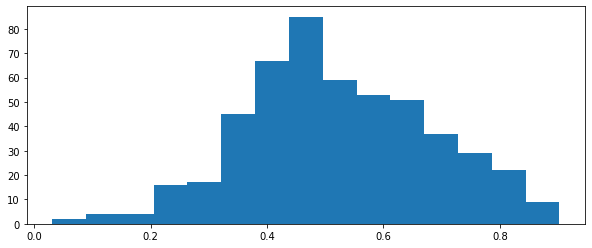

In [19]:
class_idx = 1
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

(array([378.,  46.,  24.,  11.,   4.,  11.,   1.,   5.,   2.,   2.,   2.,
          1.,   1.,   2.,   3.]),
 array([6.02298975e-04, 4.92588414e-02, 9.79153838e-02, 1.46571926e-01,
        1.95228469e-01, 2.43885011e-01, 2.92541554e-01, 3.41198096e-01,
        3.89854638e-01, 4.38511181e-01, 4.87167723e-01, 5.35824266e-01,
        5.84480808e-01, 6.33137350e-01, 6.81793893e-01, 7.30450435e-01]),
 <BarContainer object of 15 artists>)

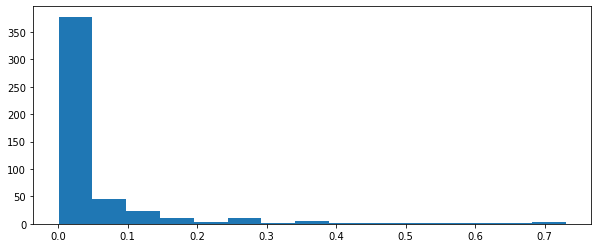

In [20]:
class_idx = 8
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

(array([152.,  42.,  25.,  31.,  54.,  13.,  19.,  24.,  20.,  13.,  25.,
         13.,   5.,   0.,   2.]),
 array([0.0043278 , 0.05726802, 0.11020824, 0.16314846, 0.21608868,
        0.2690289 , 0.32196912, 0.37490933, 0.42784955, 0.48078977,
        0.53372999, 0.58667021, 0.63961043, 0.69255065, 0.74549087,
        0.79843109]),
 <BarContainer object of 15 artists>)

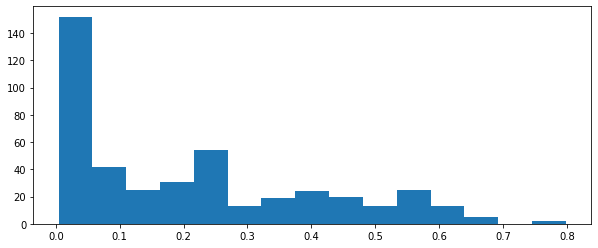

In [21]:
class_idx = 30
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Adapted Conf

(array([  2.,   2.,  17., 121.,   0.,   4.,  24., 113.,   4.,  24.,  64.,
         11.,  35.,   9.,   8.]),
 array([0.1154306 , 0.16287198, 0.21031336, 0.25775475, 0.30519613,
        0.35263751, 0.40007889, 0.44752028, 0.49496166, 0.54240304,
        0.58984442, 0.63728581, 0.68472719, 0.73216857, 0.77960995,
        0.82705133]),
 <BarContainer object of 15 artists>)

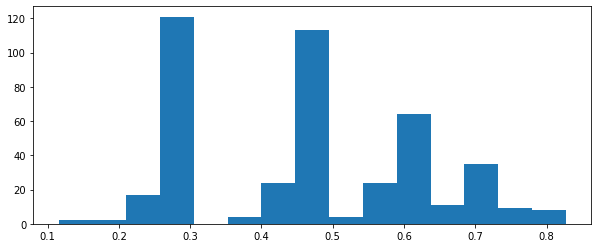

In [22]:
class_idx = 30
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,2][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Distribution of Scores for one sample

#Scores in ScoreList 7
# Score in sample_idx: 0.6791450531112
# Support in sample_idx: 7.0


(array([0., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.24009506, 0.30676173, 0.3734284 , 0.44009506, 0.50676173,
        0.5734284 , 0.64009506, 0.70676173, 0.7734284 , 0.84009506,
        0.90676173, 0.9734284 , 1.04009506, 1.10676173, 1.1734284 ,
        1.24009506]),
 <BarContainer object of 15 artists>)

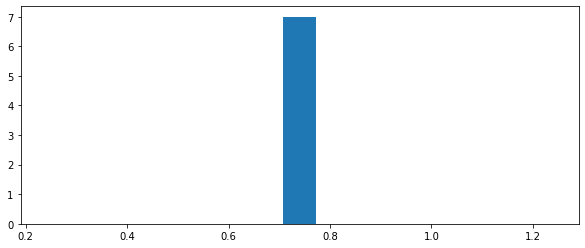

In [23]:
class_idx = 0
sample_idx = 0
score_list = memory_buffer.meta_debug[class_idx][sample_idx]

print(f"#Scores in ScoreList {len(score_list)}")
print(f"# Score in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 0]}")
print(f"# Support in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 1]}")

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

In [24]:
memory_buffer.meta_debug[class_idx].keys()

dict_keys([18, 386, 416, 258, 154, 203, 329, 137, 217, 192, 19, 31, 165, 100, 466, 441, 160, 439, 33, 141, 159, 470, 392, 322, 95, 496, 198, 312, 177, 335, 155, 444, 228, 272, 195, 406, 191, 309, 208, 313, 384, 292, 487, 411, 3, 149, 369, 113, 175, 332, 138, 463, 368, 327, 166, 445, 71, 425, 376, 205, 115, 47, 409, 194, 222, 169, 178, 380, 367, 493, 61, 494, 30, 395, 6, 365, 60, 110, 101, 46, 151, 235, 396, 314, 48, 94, 173, 349, 254, 96, 157, 273, 473, 212, 59, 389, 426, 350, 288, 102, 402, 43, 467, 124, 442, 28, 1, 40, 291, 353, 167, 152, 321, 474, 268, 20, 436, 317, 460, 450, 294, 130, 457, 355, 34, 347, 243, 232, 478, 351, 51, 82, 497, 244, 287, 360, 370, 142, 280, 456, 126, 433, 209, 199, 118, 240, 461, 488, 112, 342, 223, 76, 241, 84, 236, 144, 25, 430, 394, 418, 271, 410, 437, 66, 256, 182, 304, 255, 211, 174, 129, 383, 290, 52, 218, 375, 78, 117, 265, 399, 77, 259, 475, 158, 188, 278, 310, 489, 415, 413, 424, 480, 27, 341, 150, 285, 328, 281, 458, 104, 121, 252, 186, 267, 435, 

# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [25]:
def evaluate(dataloader, updates, mini_batch_size, dataname=""):
    learner.rln.eval()
    learner.pln.train()
    
    all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []
    all_adaptation_time = []
    # Get Query set first. and then find supporting support set
    for query_idx, (query_text, query_labels) in enumerate(dataloader):
        print(f"Query ID {query_idx}/{len(dataloader)}")
        # The task id to optimize to for support set
        # task_idx = get_task_from_label_list(query_labels, memory_buffer.task_dict)
        task_idx = dataclass_mapper[dataname]
        
    
        support_set = []
        for _ in range(updates):
            text, labels = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, sort_score=True, \
                                                        sort_asc=False ) # this is changed!!!
            support_set.append((text, labels))

        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels = [], []
            support_loss = []
            for text, labels in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
            INNER_toc = time.time() - INNER_tic
            all_adaptation_time.append(INNER_toc)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

            # Query set is now here!
            query_labels = torch.tensor(query_labels).to(device)
            query_input_dict = learner.rln.encode_text(query_text)
            with torch.no_grad():
                query_repr = learner.rln(query_input_dict)
                query_output = fpln(query_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
                query_loss = learner.loss_fn(query_output, query_labels)
            query_loss = query_loss.item()
            # print(output.detach().size())
            # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
            query_output_softmax = F.softmax(query_output, -1)
            query_label_conf = query_output_softmax[np.arange(len(query_output_softmax)), query_labels] # Select labels in the softmax of 33 classes

            query_pred = models.utils.make_prediction(query_output.detach())
            query_acc, query_prec, query_rec, query_f1 = models.utils.calculate_metrics(query_pred.tolist(), query_labels.tolist())
            
            print('Query set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(query_loss), query_acc, query_prec, query_rec, query_f1))

            all_losses.append(query_loss)
            all_predictions.extend(query_pred.tolist())
            all_labels.extend(query_labels.tolist())
            all_label_conf.extend(query_label_conf.tolist())

    acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
    print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
                'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return acc, prec, rec, f1, all_predictions, all_labels, all_label_conf, all_adaptation_time

In [26]:
tic = time.time()
print('----------Testing on test set starts here----------')

accuracies, precisions, recalls, f1s = [], [], [], []
all_adapt_time = []
# Data for Visualization: [data_idx, label, label_conf, pred]
data_for_visual = []

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    acc, prec, rec, f1, all_pred, all_label, all_label_conf, all_adaptation_time = evaluate(dataloader=test_dataloader, updates=updates, 
                                                mini_batch_size=mini_batch_size, dataname=test_dataset.__class__.__name__)
    
    data_ids = [test_dataset.__class__.__name__ + str(i) for i in range(len(all_label))]
    data_for_visual.extend(list(zip(data_ids, all_label, all_label_conf, all_pred)))
    all_adapt_time.extend(all_adaptation_time)
#     print(data_ids)
#     print(all_label)
#     raise Exception("BREAKPOINT")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)


print()
print("COPY PASTA - not really but ok")
for row in accuracies:
    print(row)
print()
print('Overall test metrics: Accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
            'F1 score = {:.4f}'.format(np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))

toc = time.time() - tic
print(f"Total Time used: {toc//60} minutes")

----------Testing on test set starts here----------
Testing on YelpDataset
Query ID 0/475
Support set metrics: Loss = 2.3490, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.6823, accuracy = 0.7500, precision = 0.8867, recall = 0.7333, F1 score = 0.7318
Query ID 1/475
Support set metrics: Loss = 2.4467, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7298, accuracy = 0.7500, precision = 0.7267, recall = 0.7933, F1 score = 0.7200
Query ID 2/475
Support set metrics: Loss = 2.3569, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9518, accuracy = 0.3750, precision = 0.4000, recall = 0.4000, F1 score = 0.3881
Query ID 3/475
Support set metrics: Loss = 2.2993, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9850, accuracy = 0.6875, precision = 0.6800, recall = 0.6833, F1 score = 

Support set metrics: Loss = 2.4341, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7112, accuracy = 0.8125, precision = 0.8167, recall = 0.8250, F1 score = 0.8151
Query ID 36/475
Support set metrics: Loss = 2.3093, accuracy = 0.0250, precision = 0.0250, recall = 0.0200, F1 score = 0.0222
Query set metrics: Loss = 0.8299, accuracy = 0.8125, precision = 0.8000, recall = 0.8000, F1 score = 0.7667
Query ID 37/475
Support set metrics: Loss = 2.2776, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7612, accuracy = 0.6250, precision = 0.5533, recall = 0.5533, F1 score = 0.5333
Query ID 38/475
Support set metrics: Loss = 2.3491, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9475, accuracy = 0.4375, precision = 0.3867, recall = 0.4200, F1 score = 0.3943
Query ID 39/475
Support set metrics: Loss = 2.3161, accuracy = 0.0000, precision

Query set metrics: Loss = 1.3262, accuracy = 0.5000, precision = 0.5000, recall = 0.6533, F1 score = 0.5533
Query ID 71/475
Support set metrics: Loss = 2.2734, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9083, accuracy = 0.6250, precision = 0.6167, recall = 0.5333, F1 score = 0.5233
Query ID 72/475
Support set metrics: Loss = 2.2891, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8379, accuracy = 0.5000, precision = 0.5467, recall = 0.5000, F1 score = 0.5100
Query ID 73/475
Support set metrics: Loss = 2.4963, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 0.8593, accuracy = 0.7500, precision = 0.6833, recall = 0.6533, F1 score = 0.6414
Query ID 74/475
Support set metrics: Loss = 2.2885, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9359, accuracy = 0.5625, precision =

Query set metrics: Loss = 0.6936, accuracy = 0.6250, precision = 0.6833, recall = 0.6167, F1 score = 0.6262
Query ID 106/475
Support set metrics: Loss = 2.2119, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2499, accuracy = 0.3125, precision = 0.2257, recall = 0.3667, F1 score = 0.2756
Query ID 107/475
Support set metrics: Loss = 2.3697, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9807, accuracy = 0.6250, precision = 0.7000, recall = 0.6500, F1 score = 0.6457
Query ID 108/475
Support set metrics: Loss = 2.2147, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0711, accuracy = 0.4375, precision = 0.3533, recall = 0.3800, F1 score = 0.3500
Query ID 109/475
Support set metrics: Loss = 2.3699, accuracy = 0.0125, precision = 0.0154, recall = 0.0100, F1 score = 0.0121
Query set metrics: Loss = 1.0788, accuracy = 0.3750, precisi

Query set metrics: Loss = 0.6429, accuracy = 0.6250, precision = 0.6867, recall = 0.6800, F1 score = 0.6167
Query ID 141/475
Support set metrics: Loss = 2.2976, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7830, accuracy = 0.6875, precision = 0.4243, recall = 0.5500, F1 score = 0.4732
Query ID 142/475
Support set metrics: Loss = 2.2877, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8119, accuracy = 0.7500, precision = 0.7767, recall = 0.7700, F1 score = 0.7578
Query ID 143/475
Support set metrics: Loss = 2.2705, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.6629, accuracy = 0.6875, precision = 0.7300, recall = 0.7033, F1 score = 0.6743
Query ID 144/475
Support set metrics: Loss = 2.3279, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9293, accuracy = 0.5625, precisi

Query set metrics: Loss = 0.9067, accuracy = 0.5625, precision = 0.6100, recall = 0.5267, F1 score = 0.5267
Query ID 176/475
Support set metrics: Loss = 2.3060, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0198, accuracy = 0.5625, precision = 0.5900, recall = 0.5667, F1 score = 0.5538
Query ID 177/475
Support set metrics: Loss = 2.3231, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7797, accuracy = 0.6250, precision = 0.7917, recall = 0.7333, F1 score = 0.6792
Query ID 178/475
Support set metrics: Loss = 2.3940, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1673, accuracy = 0.5000, precision = 0.4533, recall = 0.5100, F1 score = 0.4788
Query ID 179/475
Support set metrics: Loss = 2.2785, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7571, accuracy = 0.6250, precisi

Query set metrics: Loss = 1.0734, accuracy = 0.5000, precision = 0.4524, recall = 0.4667, F1 score = 0.4405
Query ID 211/475
Support set metrics: Loss = 2.3157, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9016, accuracy = 0.5000, precision = 0.6357, recall = 0.5833, F1 score = 0.4958
Query ID 212/475
Support set metrics: Loss = 2.2778, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8152, accuracy = 0.6875, precision = 0.6800, recall = 0.7000, F1 score = 0.6778
Query ID 213/475
Support set metrics: Loss = 2.3353, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8437, accuracy = 0.5625, precision = 0.4667, recall = 0.4333, F1 score = 0.4410
Query ID 214/475
Support set metrics: Loss = 2.3780, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1132, accuracy = 0.5000, precisi

Support set metrics: Loss = 2.2983, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7899, accuracy = 0.6250, precision = 0.7333, recall = 0.6500, F1 score = 0.6286
Query ID 247/475
Support set metrics: Loss = 2.3556, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0712, accuracy = 0.7500, precision = 0.8200, recall = 0.7700, F1 score = 0.7500
Query ID 248/475
Support set metrics: Loss = 2.3654, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7719, accuracy = 0.6875, precision = 0.7643, recall = 0.7000, F1 score = 0.6755
Query ID 249/475
Support set metrics: Loss = 2.4601, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8775, accuracy = 0.5625, precision = 0.4400, recall = 0.5476, F1 score = 0.4556
Query ID 250/475
Support set metrics: Loss = 2.3109, accuracy = 0.0000, preci

Support set metrics: Loss = 2.4116, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7817, accuracy = 0.5625, precision = 0.5200, recall = 0.5000, F1 score = 0.5089
Query ID 282/475
Support set metrics: Loss = 2.4487, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9504, accuracy = 0.6875, precision = 0.7200, recall = 0.7500, F1 score = 0.7214
Query ID 283/475
Support set metrics: Loss = 2.4659, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9743, accuracy = 0.6250, precision = 0.6633, recall = 0.6167, F1 score = 0.6322
Query ID 284/475
Support set metrics: Loss = 2.3196, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.6791, accuracy = 0.7500, precision = 0.7667, recall = 0.8095, F1 score = 0.7615
Query ID 285/475
Support set metrics: Loss = 2.4103, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3499, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7000, accuracy = 0.6250, precision = 0.4667, recall = 0.5333, F1 score = 0.4943
Query ID 317/475
Support set metrics: Loss = 2.4087, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8166, accuracy = 0.6875, precision = 0.7000, recall = 0.6333, F1 score = 0.6133
Query ID 318/475
Support set metrics: Loss = 2.3485, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0262, accuracy = 0.5625, precision = 0.5600, recall = 0.5833, F1 score = 0.4769
Query ID 319/475
Support set metrics: Loss = 2.3277, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9849, accuracy = 0.5000, precision = 0.4333, recall = 0.4833, F1 score = 0.4381
Query ID 320/475
Support set metrics: Loss = 2.3175, accuracy = 0.0250, preci

Support set metrics: Loss = 2.2723, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2272, accuracy = 0.6250, precision = 0.6500, recall = 0.6190, F1 score = 0.6024
Query ID 352/475
Support set metrics: Loss = 2.4395, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7791, accuracy = 0.6875, precision = 0.7000, recall = 0.7429, F1 score = 0.6805
Query ID 353/475
Support set metrics: Loss = 2.3087, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2119, accuracy = 0.3125, precision = 0.4000, recall = 0.2167, F1 score = 0.2700
Query ID 354/475
Support set metrics: Loss = 2.2913, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8955, accuracy = 0.5625, precision = 0.5500, recall = 0.6200, F1 score = 0.5371
Query ID 355/475
Support set metrics: Loss = 2.3115, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2616, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0221, accuracy = 0.5000, precision = 0.5667, recall = 0.4867, F1 score = 0.4900
Query ID 387/475
Support set metrics: Loss = 2.3117, accuracy = 0.0250, precision = 0.0235, recall = 0.0200, F1 score = 0.0216
Query set metrics: Loss = 1.4153, accuracy = 0.3750, precision = 0.4833, recall = 0.3571, F1 score = 0.3689
Query ID 388/475
Support set metrics: Loss = 2.3040, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.5969, accuracy = 0.8125, precision = 0.8600, recall = 0.8333, F1 score = 0.8044
Query ID 389/475
Support set metrics: Loss = 2.2420, accuracy = 0.0250, precision = 0.0211, recall = 0.0200, F1 score = 0.0205
Query set metrics: Loss = 0.9421, accuracy = 0.5625, precision = 0.6233, recall = 0.6667, F1 score = 0.5524
Query ID 390/475
Support set metrics: Loss = 2.4051, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3218, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1611, accuracy = 0.3750, precision = 0.2867, recall = 0.3786, F1 score = 0.2778
Query ID 422/475
Support set metrics: Loss = 2.3698, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0575, accuracy = 0.6875, precision = 0.7600, recall = 0.7600, F1 score = 0.7467
Query ID 423/475
Support set metrics: Loss = 2.3919, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7987, accuracy = 0.6250, precision = 0.5833, recall = 0.6833, F1 score = 0.6114
Query ID 424/475
Support set metrics: Loss = 2.3081, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0112, accuracy = 0.6250, precision = 0.7417, recall = 0.6750, F1 score = 0.7000
Query ID 425/475
Support set metrics: Loss = 2.3925, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3481, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1704, accuracy = 0.6875, precision = 0.7667, recall = 0.6333, F1 score = 0.6752
Query ID 457/475
Support set metrics: Loss = 2.2657, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.5829, accuracy = 0.8750, precision = 0.9000, recall = 0.9000, F1 score = 0.8929
Query ID 458/475
Support set metrics: Loss = 2.4125, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2388, accuracy = 0.5000, precision = 0.4267, recall = 0.5943, F1 score = 0.4333
Query ID 459/475
Support set metrics: Loss = 2.2932, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.6185, accuracy = 0.7500, precision = 0.7914, recall = 0.7500, F1 score = 0.6813
Query ID 460/475
Support set metrics: Loss = 2.3857, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2978, accuracy = 0.1625, precision = 0.1672, recall = 0.1625, F1 score = 0.1641
Query set metrics: Loss = 0.1943, accuracy = 0.9375, precision = 0.9167, recall = 0.9643, F1 score = 0.9308
Query ID 17/475
Support set metrics: Loss = 2.2742, accuracy = 0.2125, precision = 0.1920, recall = 0.2125, F1 score = 0.2016
Query set metrics: Loss = 0.3004, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Query ID 18/475
Support set metrics: Loss = 2.1663, accuracy = 0.1250, precision = 0.1250, recall = 0.1250, F1 score = 0.1250
Query set metrics: Loss = 0.4173, accuracy = 0.8125, precision = 0.8667, recall = 0.8667, F1 score = 0.8636
Query ID 19/475
Support set metrics: Loss = 2.1116, accuracy = 0.1500, precision = 0.1534, recall = 0.1500, F1 score = 0.1510
Query set metrics: Loss = 0.7644, accuracy = 0.8125, precision = 0.8333, recall = 0.8021, F1 score = 0.7333
Query ID 20/475
Support set metrics: Loss = 2.1046, accuracy = 0.2750, precision

Support set metrics: Loss = 2.3249, accuracy = 0.1250, precision = 0.1435, recall = 0.1250, F1 score = 0.1322
Query set metrics: Loss = 0.2778, accuracy = 0.8750, precision = 0.8750, recall = 0.9000, F1 score = 0.8661
Query ID 53/475
Support set metrics: Loss = 2.1122, accuracy = 0.2250, precision = 0.2507, recall = 0.2250, F1 score = 0.2367
Query set metrics: Loss = 0.1012, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 54/475
Support set metrics: Loss = 2.2470, accuracy = 0.1250, precision = 0.1488, recall = 0.1250, F1 score = 0.1340
Query set metrics: Loss = 0.3724, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 55/475
Support set metrics: Loss = 2.1305, accuracy = 0.1375, precision = 0.1612, recall = 0.1375, F1 score = 0.1473
Query set metrics: Loss = 0.0870, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 56/475
Support set metrics: Loss = 2.1545, accuracy = 0.2000, precision

Support set metrics: Loss = 1.9333, accuracy = 0.2250, precision = 0.2102, recall = 0.2250, F1 score = 0.2146
Query set metrics: Loss = 0.3443, accuracy = 0.8750, precision = 0.8250, recall = 0.8667, F1 score = 0.8167
Query ID 89/475
Support set metrics: Loss = 2.2225, accuracy = 0.1375, precision = 0.1333, recall = 0.1375, F1 score = 0.1345
Query set metrics: Loss = 0.1211, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 90/475
Support set metrics: Loss = 2.1961, accuracy = 0.1875, precision = 0.1791, recall = 0.1875, F1 score = 0.1828
Query set metrics: Loss = 0.1614, accuracy = 0.9375, precision = 0.9375, recall = 0.9375, F1 score = 0.9286
Query ID 91/475
Support set metrics: Loss = 2.2950, accuracy = 0.1875, precision = 0.1837, recall = 0.1875, F1 score = 0.1833
Query set metrics: Loss = 0.1538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 92/475
Support set metrics: Loss = 1.9832, accuracy = 0.1875, precision

Support set metrics: Loss = 2.1391, accuracy = 0.1875, precision = 0.2147, recall = 0.1875, F1 score = 0.1940
Query set metrics: Loss = 0.1643, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 124/475
Support set metrics: Loss = 2.2792, accuracy = 0.2250, precision = 0.2215, recall = 0.2250, F1 score = 0.2222
Query set metrics: Loss = 0.2768, accuracy = 0.8750, precision = 0.9375, recall = 0.8333, F1 score = 0.8643
Query ID 125/475
Support set metrics: Loss = 2.2179, accuracy = 0.1000, precision = 0.1130, recall = 0.1000, F1 score = 0.1060
Query set metrics: Loss = 0.4811, accuracy = 0.8750, precision = 0.9444, recall = 0.8750, F1 score = 0.8854
Query ID 126/475
Support set metrics: Loss = 2.2283, accuracy = 0.1000, precision = 0.1260, recall = 0.1000, F1 score = 0.1115
Query set metrics: Loss = 0.2502, accuracy = 0.8750, precision = 0.8667, recall = 0.8667, F1 score = 0.8667
Query ID 127/475
Support set metrics: Loss = 2.2802, accuracy = 0.1250, preci

Support set metrics: Loss = 2.0987, accuracy = 0.1500, precision = 0.1429, recall = 0.1500, F1 score = 0.1463
Query set metrics: Loss = 0.2003, accuracy = 0.8750, precision = 0.8750, recall = 0.8750, F1 score = 0.8750
Query ID 159/475
Support set metrics: Loss = 2.1008, accuracy = 0.2000, precision = 0.2042, recall = 0.2000, F1 score = 0.1989
Query set metrics: Loss = 0.1674, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 160/475
Support set metrics: Loss = 2.0864, accuracy = 0.1750, precision = 0.1620, recall = 0.1750, F1 score = 0.1666
Query set metrics: Loss = 0.2940, accuracy = 0.8750, precision = 0.8333, recall = 0.9167, F1 score = 0.8250
Query ID 161/475
Support set metrics: Loss = 2.1464, accuracy = 0.1750, precision = 0.1805, recall = 0.1750, F1 score = 0.1776
Query set metrics: Loss = 0.2668, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 162/475
Support set metrics: Loss = 2.3373, accuracy = 0.1125, preci

Support set metrics: Loss = 2.1353, accuracy = 0.1875, precision = 0.2083, recall = 0.1875, F1 score = 0.1950
Query set metrics: Loss = 0.2259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 194/475
Support set metrics: Loss = 2.1829, accuracy = 0.2000, precision = 0.1667, recall = 0.2000, F1 score = 0.1818
Query set metrics: Loss = 0.1113, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 195/475
Support set metrics: Loss = 2.1247, accuracy = 0.1000, precision = 0.1007, recall = 0.1000, F1 score = 0.1002
Query set metrics: Loss = 0.1920, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 196/475
Support set metrics: Loss = 2.2377, accuracy = 0.1375, precision = 0.1476, recall = 0.1375, F1 score = 0.1422
Query set metrics: Loss = 0.0991, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 197/475
Support set metrics: Loss = 2.2749, accuracy = 0.1875, preci

Support set metrics: Loss = 2.3210, accuracy = 0.1500, precision = 0.1540, recall = 0.1500, F1 score = 0.1516
Query set metrics: Loss = 0.1185, accuracy = 0.9375, precision = 0.8750, recall = 0.9375, F1 score = 0.8810
Query ID 229/475
Support set metrics: Loss = 2.3193, accuracy = 0.2000, precision = 0.1986, recall = 0.2000, F1 score = 0.1980
Query set metrics: Loss = 0.0694, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 230/475
Support set metrics: Loss = 1.8776, accuracy = 0.2625, precision = 0.2519, recall = 0.2625, F1 score = 0.2550
Query set metrics: Loss = 0.2156, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 231/475
Support set metrics: Loss = 2.1966, accuracy = 0.2000, precision = 0.2149, recall = 0.2000, F1 score = 0.2056
Query set metrics: Loss = 0.3926, accuracy = 0.8750, precision = 0.8875, recall = 0.8393, F1 score = 0.8339
Query ID 232/475
Support set metrics: Loss = 2.2421, accuracy = 0.1875, preci

Support set metrics: Loss = 2.1171, accuracy = 0.2125, precision = 0.2263, recall = 0.2125, F1 score = 0.2167
Query set metrics: Loss = 0.2516, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 264/475
Support set metrics: Loss = 2.1155, accuracy = 0.2000, precision = 0.1822, recall = 0.2000, F1 score = 0.1895
Query set metrics: Loss = 0.2334, accuracy = 0.9375, precision = 0.9167, recall = 0.9643, F1 score = 0.9308
Query ID 265/475
Support set metrics: Loss = 1.9281, accuracy = 0.2000, precision = 0.1687, recall = 0.2000, F1 score = 0.1829
Query set metrics: Loss = 0.2011, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 266/475
Support set metrics: Loss = 2.1514, accuracy = 0.1875, precision = 0.1519, recall = 0.1875, F1 score = 0.1670
Query set metrics: Loss = 0.4533, accuracy = 0.8125, precision = 0.8542, recall = 0.8375, F1 score = 0.8415
Query ID 267/475
Support set metrics: Loss = 2.2964, accuracy = 0.2000, preci

Support set metrics: Loss = 2.3929, accuracy = 0.1625, precision = 0.1470, recall = 0.1625, F1 score = 0.1509
Query set metrics: Loss = 0.2175, accuracy = 0.8750, precision = 0.6518, recall = 0.7143, F1 score = 0.6786
Query ID 299/475
Support set metrics: Loss = 2.1741, accuracy = 0.1500, precision = 0.1616, recall = 0.1500, F1 score = 0.1545
Query set metrics: Loss = 0.2190, accuracy = 0.8750, precision = 0.8958, recall = 0.8958, F1 score = 0.8958
Query ID 300/475
Support set metrics: Loss = 2.2184, accuracy = 0.1625, precision = 0.1488, recall = 0.1625, F1 score = 0.1552
Query set metrics: Loss = 0.3815, accuracy = 0.8125, precision = 0.8185, recall = 0.7976, F1 score = 0.7952
Query ID 301/475
Support set metrics: Loss = 2.3422, accuracy = 0.1250, precision = 0.1404, recall = 0.1250, F1 score = 0.1282
Query set metrics: Loss = 0.2162, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 302/475
Support set metrics: Loss = 2.2345, accuracy = 0.1875, preci

Support set metrics: Loss = 2.0996, accuracy = 0.1625, precision = 0.1601, recall = 0.1625, F1 score = 0.1608
Query set metrics: Loss = 0.1664, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 334/475
Support set metrics: Loss = 2.0883, accuracy = 0.2125, precision = 0.2088, recall = 0.2125, F1 score = 0.2103
Query set metrics: Loss = 0.2099, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 335/475
Support set metrics: Loss = 2.0517, accuracy = 0.2500, precision = 0.2788, recall = 0.2500, F1 score = 0.2623
Query set metrics: Loss = 0.6300, accuracy = 0.8750, precision = 0.8393, recall = 0.9143, F1 score = 0.8532
Query ID 336/475
Support set metrics: Loss = 2.2383, accuracy = 0.1375, precision = 0.1363, recall = 0.1375, F1 score = 0.1364
Query set metrics: Loss = 0.4462, accuracy = 0.9375, precision = 0.9722, recall = 0.8750, F1 score = 0.9020
Query ID 337/475
Support set metrics: Loss = 2.1424, accuracy = 0.2000, preci

Support set metrics: Loss = 2.1712, accuracy = 0.1750, precision = 0.1845, recall = 0.1750, F1 score = 0.1794
Query set metrics: Loss = 0.4093, accuracy = 0.8750, precision = 0.6771, recall = 0.7500, F1 score = 0.7106
Query ID 369/475
Support set metrics: Loss = 2.1161, accuracy = 0.1750, precision = 0.1840, recall = 0.1750, F1 score = 0.1788
Query set metrics: Loss = 0.2801, accuracy = 0.9375, precision = 0.9167, recall = 0.9583, F1 score = 0.9273
Query ID 370/475
Support set metrics: Loss = 2.1840, accuracy = 0.2375, precision = 0.2158, recall = 0.2375, F1 score = 0.2259
Query set metrics: Loss = 0.1119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 371/475
Support set metrics: Loss = 1.9678, accuracy = 0.2250, precision = 0.2699, recall = 0.2250, F1 score = 0.2418
Query set metrics: Loss = 0.5752, accuracy = 0.8125, precision = 0.8393, recall = 0.7768, F1 score = 0.7827
Query ID 372/475
Support set metrics: Loss = 2.0956, accuracy = 0.1375, preci

Support set metrics: Loss = 2.0417, accuracy = 0.1625, precision = 0.1372, recall = 0.1625, F1 score = 0.1488
Query set metrics: Loss = 0.3783, accuracy = 0.8750, precision = 0.9375, recall = 0.8875, F1 score = 0.9097
Query ID 404/475
Support set metrics: Loss = 2.0594, accuracy = 0.1625, precision = 0.1596, recall = 0.1625, F1 score = 0.1607
Query set metrics: Loss = 0.5679, accuracy = 0.8750, precision = 0.9375, recall = 0.9000, F1 score = 0.9018
Query ID 405/475
Support set metrics: Loss = 2.2724, accuracy = 0.2125, precision = 0.2008, recall = 0.2125, F1 score = 0.2060
Query set metrics: Loss = 0.0988, accuracy = 0.9375, precision = 1.0000, recall = 0.8333, F1 score = 0.8889
Query ID 406/475
Support set metrics: Loss = 2.0493, accuracy = 0.1625, precision = 0.1667, recall = 0.1625, F1 score = 0.1645
Query set metrics: Loss = 0.9843, accuracy = 0.6250, precision = 0.6500, recall = 0.6667, F1 score = 0.5958
Query ID 407/475
Support set metrics: Loss = 2.1591, accuracy = 0.2000, preci

Support set metrics: Loss = 2.0857, accuracy = 0.1375, precision = 0.1310, recall = 0.1375, F1 score = 0.1341
Query set metrics: Loss = 0.2037, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 439/475
Support set metrics: Loss = 1.9466, accuracy = 0.1750, precision = 0.1709, recall = 0.1750, F1 score = 0.1729
Query set metrics: Loss = 0.3846, accuracy = 0.8750, precision = 0.8250, recall = 0.8250, F1 score = 0.8250
Query ID 440/475
Support set metrics: Loss = 2.2780, accuracy = 0.2125, precision = 0.2111, recall = 0.2125, F1 score = 0.2092
Query set metrics: Loss = 0.1852, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 441/475
Support set metrics: Loss = 2.3685, accuracy = 0.1375, precision = 0.1536, recall = 0.1375, F1 score = 0.1434
Query set metrics: Loss = 0.1877, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 442/475
Support set metrics: Loss = 2.2413, accuracy = 0.1500, preci

Support set metrics: Loss = 2.2262, accuracy = 0.1500, precision = 0.1550, recall = 0.1500, F1 score = 0.1518
Query set metrics: Loss = 0.1379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 474/475
Support set metrics: Loss = 2.1808, accuracy = 0.2125, precision = 0.1972, recall = 0.2125, F1 score = 0.2045
Query set metrics: Loss = 0.0816, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Test metrics: Loss = 0.2952, accuracy = 0.9071, precision = 0.9115, recall = 0.9071, F1 score = 0.9085
Testing on DBPediaDataset
Query ID 0/475
Support set metrics: Loss = 0.1068, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 1/475
Support set metrics: Loss = 0.0533, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precisi

Support set metrics: Loss = 0.1535, accuracy = 0.9625, precision = 0.9751, recall = 0.9571, F1 score = 0.9561
Query set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 34/475
Support set metrics: Loss = 0.0885, accuracy = 0.9625, precision = 0.9697, recall = 0.9571, F1 score = 0.9578
Query set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 35/475
Support set metrics: Loss = 0.0457, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 36/475
Support set metrics: Loss = 0.0657, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.4466, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
Query ID 37/475
Support set metrics: Loss = 0.0471, accuracy = 0.9875, precision

Support set metrics: Loss = 0.1362, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9722
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 70/475
Support set metrics: Loss = 0.1149, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.4653, accuracy = 0.9375, precision = 0.8889, recall = 0.8889, F1 score = 0.8889
Query ID 71/475
Support set metrics: Loss = 0.0605, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0493, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 72/475
Support set metrics: Loss = 0.0639, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 73/475
Support set metrics: Loss = 0.1018, accuracy = 0.9750, precision

Support set metrics: Loss = 0.0458, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 105/475
Support set metrics: Loss = 0.0659, accuracy = 0.9625, precision = 0.9762, recall = 0.9571, F1 score = 0.9612
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 106/475
Support set metrics: Loss = 0.1661, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.2071, accuracy = 0.9375, precision = 0.9500, recall = 0.9800, F1 score = 0.9556
Query ID 107/475
Support set metrics: Loss = 0.0612, accuracy = 0.9750, precision = 0.9870, recall = 0.9714, F1 score = 0.9753
Query set metrics: Loss = 0.0503, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 108/475
Support set metrics: Loss = 0.0461, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0601, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 140/475
Support set metrics: Loss = 0.1093, accuracy = 0.9625, precision = 0.9697, recall = 0.9571, F1 score = 0.9578
Query set metrics: Loss = 0.0912, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 141/475
Support set metrics: Loss = 0.0865, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.0110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 142/475
Support set metrics: Loss = 0.0738, accuracy = 0.9750, precision = 0.9870, recall = 0.9714, F1 score = 0.9753
Query set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 143/475
Support set metrics: Loss = 0.0657, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 175/475
Support set metrics: Loss = 0.0725, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 176/475
Support set metrics: Loss = 0.0634, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0277, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 177/475
Support set metrics: Loss = 0.0640, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 178/475
Support set metrics: Loss = 0.0368, accuracy = 1.0000, preci

Support set metrics: Loss = 0.1181, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 210/475
Support set metrics: Loss = 0.0757, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 211/475
Support set metrics: Loss = 0.1172, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.1552, accuracy = 0.9375, precision = 0.8636, recall = 0.9091, F1 score = 0.8788
Query ID 212/475
Support set metrics: Loss = 0.0629, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 213/475
Support set metrics: Loss = 0.0384, accuracy = 0.9875, preci

Support set metrics: Loss = 0.2510, accuracy = 0.9500, precision = 0.9716, recall = 0.9429, F1 score = 0.9456
Query set metrics: Loss = 0.3458, accuracy = 0.9375, precision = 0.9545, recall = 0.9773, F1 score = 0.9567
Query ID 245/475
Support set metrics: Loss = 0.0602, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 246/475
Support set metrics: Loss = 0.1266, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 247/475
Support set metrics: Loss = 0.0911, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9722
Query set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 248/475
Support set metrics: Loss = 0.0642, accuracy = 0.9875, preci

Support set metrics: Loss = 0.1416, accuracy = 0.9750, precision = 0.9870, recall = 0.9714, F1 score = 0.9753
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 280/475
Support set metrics: Loss = 0.2093, accuracy = 0.9750, precision = 0.9881, recall = 0.9714, F1 score = 0.9756
Query set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 281/475
Support set metrics: Loss = 0.0528, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 282/475
Support set metrics: Loss = 0.0544, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 283/475
Support set metrics: Loss = 0.0493, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0764, accuracy = 0.9750, precision = 0.9870, recall = 0.9714, F1 score = 0.9753
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 315/475
Support set metrics: Loss = 0.1477, accuracy = 0.9625, precision = 0.9731, recall = 0.9571, F1 score = 0.9589
Query set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 316/475
Support set metrics: Loss = 0.1305, accuracy = 0.9750, precision = 0.9870, recall = 0.9714, F1 score = 0.9753
Query set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 317/475
Support set metrics: Loss = 0.1270, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 318/475
Support set metrics: Loss = 0.1134, accuracy = 0.9625, preci

Support set metrics: Loss = 0.1084, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.1348, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 350/475
Support set metrics: Loss = 0.0673, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 351/475
Support set metrics: Loss = 0.0472, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 352/475
Support set metrics: Loss = 0.1462, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9722
Query set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 353/475
Support set metrics: Loss = 0.0745, accuracy = 0.9625, preci

Support set metrics: Loss = 0.1511, accuracy = 0.9750, precision = 0.9881, recall = 0.9714, F1 score = 0.9756
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 385/475
Support set metrics: Loss = 0.0724, accuracy = 0.9750, precision = 0.9881, recall = 0.9714, F1 score = 0.9756
Query set metrics: Loss = 0.0115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 386/475
Support set metrics: Loss = 0.0554, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 387/475
Support set metrics: Loss = 0.0504, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 388/475
Support set metrics: Loss = 0.1712, accuracy = 0.9625, preci

Support set metrics: Loss = 0.0530, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 420/475
Support set metrics: Loss = 0.2420, accuracy = 0.9625, precision = 0.9762, recall = 0.9571, F1 score = 0.9612
Query set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 421/475
Support set metrics: Loss = 0.0669, accuracy = 0.9750, precision = 0.9870, recall = 0.9714, F1 score = 0.9753
Query set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 422/475
Support set metrics: Loss = 0.0346, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.3343, accuracy = 0.9375, precision = 1.0000, recall = 0.9750, F1 score = 0.9857
Query ID 423/475
Support set metrics: Loss = 0.0377, accuracy = 0.9875, preci

Support set metrics: Loss = 0.1034, accuracy = 0.9625, precision = 0.9697, recall = 0.9571, F1 score = 0.9578
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 455/475
Support set metrics: Loss = 0.0949, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 456/475
Support set metrics: Loss = 0.1420, accuracy = 0.9750, precision = 0.9881, recall = 0.9714, F1 score = 0.9756
Query set metrics: Loss = 0.1589, accuracy = 0.9375, precision = 0.9500, recall = 0.9750, F1 score = 0.9524
Query ID 457/475
Support set metrics: Loss = 0.1248, accuracy = 0.9875, precision = 0.9935, recall = 0.9857, F1 score = 0.9887
Query set metrics: Loss = 0.0315, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 458/475
Support set metrics: Loss = 0.2171, accuracy = 0.9375, preci

Support set metrics: Loss = 2.3437, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9397, accuracy = 0.7500, precision = 0.6500, recall = 0.6714, F1 score = 0.6227
Query ID 15/475
Support set metrics: Loss = 2.3429, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2310, accuracy = 0.5625, precision = 0.5133, recall = 0.6200, F1 score = 0.5119
Query ID 16/475
Support set metrics: Loss = 2.3161, accuracy = 0.0250, precision = 0.0222, recall = 0.0200, F1 score = 0.0211
Query set metrics: Loss = 0.6886, accuracy = 0.7500, precision = 0.9111, recall = 0.7833, F1 score = 0.7829
Query ID 17/475
Support set metrics: Loss = 2.3718, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1306, accuracy = 0.4375, precision = 0.3900, recall = 0.3810, F1 score = 0.3621
Query ID 18/475
Support set metrics: Loss = 2.3077, accuracy = 0.0000, precision

Support set metrics: Loss = 2.3331, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8737, accuracy = 0.7500, precision = 0.7667, recall = 0.7333, F1 score = 0.7133
Query ID 51/475
Support set metrics: Loss = 2.4409, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9121, accuracy = 0.6875, precision = 0.5500, recall = 0.6167, F1 score = 0.5767
Query ID 52/475
Support set metrics: Loss = 2.3390, accuracy = 0.0125, precision = 0.0154, recall = 0.0100, F1 score = 0.0121
Query set metrics: Loss = 0.8086, accuracy = 0.5000, precision = 0.4417, recall = 0.5333, F1 score = 0.4558
Query ID 53/475
Support set metrics: Loss = 2.3204, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8557, accuracy = 0.6250, precision = 0.5429, recall = 0.4833, F1 score = 0.4981
Query ID 54/475
Support set metrics: Loss = 2.3472, accuracy = 0.0000, precision

Support set metrics: Loss = 2.3835, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8792, accuracy = 0.5625, precision = 0.5667, recall = 0.5500, F1 score = 0.5486
Query ID 87/475
Support set metrics: Loss = 2.2807, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9266, accuracy = 0.6875, precision = 0.6267, recall = 0.6200, F1 score = 0.6021
Query ID 88/475
Support set metrics: Loss = 2.3557, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2099, accuracy = 0.5000, precision = 0.4595, recall = 0.5095, F1 score = 0.4095
Query ID 89/475
Support set metrics: Loss = 2.2998, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9622, accuracy = 0.6875, precision = 0.7200, recall = 0.7500, F1 score = 0.6443
Query ID 90/475
Support set metrics: Loss = 2.3424, accuracy = 0.0000, precision

Support set metrics: Loss = 2.3422, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9126, accuracy = 0.6875, precision = 0.6200, recall = 0.5867, F1 score = 0.5943
Query ID 122/475
Support set metrics: Loss = 2.3859, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9198, accuracy = 0.5625, precision = 0.8167, recall = 0.5863, F1 score = 0.6500
Query ID 123/475
Support set metrics: Loss = 2.2136, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1551, accuracy = 0.5000, precision = 0.4500, recall = 0.4267, F1 score = 0.4293
Query ID 124/475
Support set metrics: Loss = 2.2220, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.4070, accuracy = 0.3125, precision = 0.3250, recall = 0.2667, F1 score = 0.2371
Query ID 125/475
Support set metrics: Loss = 2.3063, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3884, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0083, accuracy = 0.5625, precision = 0.6867, recall = 0.5867, F1 score = 0.6000
Query ID 157/475
Support set metrics: Loss = 2.3360, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1499, accuracy = 0.5625, precision = 0.5000, recall = 0.4933, F1 score = 0.4921
Query ID 158/475
Support set metrics: Loss = 2.3626, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1106, accuracy = 0.5000, precision = 0.4405, recall = 0.5000, F1 score = 0.4400
Query ID 159/475
Support set metrics: Loss = 2.3094, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8704, accuracy = 0.5625, precision = 0.5333, recall = 0.6067, F1 score = 0.5388
Query ID 160/475
Support set metrics: Loss = 2.4594, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3429, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.4293, accuracy = 0.3750, precision = 0.4667, recall = 0.4667, F1 score = 0.4310
Query ID 192/475
Support set metrics: Loss = 2.4210, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1920, accuracy = 0.3125, precision = 0.4271, recall = 0.3208, F1 score = 0.3125
Query ID 193/475
Support set metrics: Loss = 2.2497, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7909, accuracy = 0.7500, precision = 0.9375, recall = 0.7542, F1 score = 0.8310
Query ID 194/475
Support set metrics: Loss = 2.3815, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1005, accuracy = 0.4375, precision = 0.4000, recall = 0.4300, F1 score = 0.3443
Query ID 195/475
Support set metrics: Loss = 2.2617, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2946, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0826, accuracy = 0.5000, precision = 0.5476, recall = 0.3958, F1 score = 0.4272
Query ID 227/475
Support set metrics: Loss = 2.2527, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1207, accuracy = 0.5625, precision = 0.5750, recall = 0.5667, F1 score = 0.4758
Query ID 228/475
Support set metrics: Loss = 2.2326, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8962, accuracy = 0.5625, precision = 0.5500, recall = 0.5533, F1 score = 0.5267
Query ID 229/475
Support set metrics: Loss = 2.3880, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2027, accuracy = 0.3750, precision = 0.4800, recall = 0.3300, F1 score = 0.3705
Query ID 230/475
Support set metrics: Loss = 2.2425, accuracy = 0.0375, preci

Support set metrics: Loss = 2.1434, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7892, accuracy = 0.6875, precision = 0.6111, recall = 0.6300, F1 score = 0.5619
Query ID 262/475
Support set metrics: Loss = 2.3904, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8736, accuracy = 0.6250, precision = 0.4595, recall = 0.5867, F1 score = 0.5000
Query ID 263/475
Support set metrics: Loss = 2.3131, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.3930, accuracy = 0.5000, precision = 0.4667, recall = 0.4810, F1 score = 0.4507
Query ID 264/475
Support set metrics: Loss = 2.3120, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2535, accuracy = 0.5000, precision = 0.3467, recall = 0.4800, F1 score = 0.3743
Query ID 265/475
Support set metrics: Loss = 2.4005, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2428, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0242, accuracy = 0.5625, precision = 0.6000, recall = 0.5000, F1 score = 0.5190
Query ID 297/475
Support set metrics: Loss = 2.2532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1030, accuracy = 0.5000, precision = 0.4167, recall = 0.4667, F1 score = 0.4048
Query ID 298/475
Support set metrics: Loss = 2.3678, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2028, accuracy = 0.4375, precision = 0.5583, recall = 0.6000, F1 score = 0.4711
Query ID 299/475
Support set metrics: Loss = 2.2818, accuracy = 0.0500, precision = 0.0421, recall = 0.0400, F1 score = 0.0410
Query set metrics: Loss = 0.8493, accuracy = 0.7500, precision = 0.7762, recall = 0.7667, F1 score = 0.7400
Query ID 300/475
Support set metrics: Loss = 2.3680, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2733, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9605, accuracy = 0.5625, precision = 0.4667, recall = 0.4833, F1 score = 0.4078
Query ID 332/475
Support set metrics: Loss = 2.3196, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1116, accuracy = 0.4375, precision = 0.4800, recall = 0.4500, F1 score = 0.4467
Query ID 333/475
Support set metrics: Loss = 2.2479, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8965, accuracy = 0.5625, precision = 0.6133, recall = 0.6667, F1 score = 0.6076
Query ID 334/475
Support set metrics: Loss = 2.2957, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8839, accuracy = 0.6875, precision = 0.7733, recall = 0.7000, F1 score = 0.6730
Query ID 335/475
Support set metrics: Loss = 2.2232, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3502, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0938, accuracy = 0.6250, precision = 0.7333, recall = 0.5833, F1 score = 0.5767
Query ID 367/475
Support set metrics: Loss = 2.3077, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9125, accuracy = 0.6875, precision = 0.7500, recall = 0.7917, F1 score = 0.7511
Query ID 368/475
Support set metrics: Loss = 2.3685, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9293, accuracy = 0.5000, precision = 0.3583, recall = 0.5000, F1 score = 0.3948
Query ID 369/475
Support set metrics: Loss = 2.4599, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7674, accuracy = 0.6875, precision = 0.6458, recall = 0.6143, F1 score = 0.6224
Query ID 370/475
Support set metrics: Loss = 2.3692, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3174, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0104, accuracy = 0.5625, precision = 0.4679, recall = 0.4500, F1 score = 0.4381
Query ID 402/475
Support set metrics: Loss = 2.3581, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9528, accuracy = 0.6250, precision = 0.5333, recall = 0.5367, F1 score = 0.5310
Query ID 403/475
Support set metrics: Loss = 2.3508, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0640, accuracy = 0.5000, precision = 0.4533, recall = 0.4800, F1 score = 0.4443
Query ID 404/475
Support set metrics: Loss = 2.4265, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8912, accuracy = 0.7500, precision = 0.8400, recall = 0.8429, F1 score = 0.7667
Query ID 405/475
Support set metrics: Loss = 2.3233, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2963, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9572, accuracy = 0.7500, precision = 0.8600, recall = 0.7500, F1 score = 0.7635
Query ID 437/475
Support set metrics: Loss = 2.5016, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9593, accuracy = 0.6250, precision = 0.7343, recall = 0.5767, F1 score = 0.6000
Query ID 438/475
Support set metrics: Loss = 2.3722, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8888, accuracy = 0.6250, precision = 0.6750, recall = 0.6667, F1 score = 0.6242
Query ID 439/475
Support set metrics: Loss = 2.3521, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9979, accuracy = 0.5000, precision = 0.3262, recall = 0.4467, F1 score = 0.3338
Query ID 440/475
Support set metrics: Loss = 2.4374, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2585, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8274, accuracy = 0.8125, precision = 0.9143, recall = 0.7667, F1 score = 0.7788
Query ID 472/475
Support set metrics: Loss = 2.4335, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9172, accuracy = 0.6875, precision = 0.7667, recall = 0.7133, F1 score = 0.6743
Query ID 473/475
Support set metrics: Loss = 2.2577, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7816, accuracy = 0.6250, precision = 0.5200, recall = 0.5500, F1 score = 0.5081
Query ID 474/475
Support set metrics: Loss = 2.3898, accuracy = 0.0125, precision = 0.0111, recall = 0.0100, F1 score = 0.0105
Query set metrics: Loss = 1.0425, accuracy = 0.7500, precision = 0.8000, recall = 0.8000, F1 score = 0.7667
Test metrics: Loss = 1.0665, accuracy = 0.5589, precision = 0.5778, recall = 

Query set metrics: Loss = 0.8916, accuracy = 0.7500, precision = 0.8750, recall = 0.7708, F1 score = 0.8000
Query ID 31/475
Support set metrics: Loss = 2.1258, accuracy = 0.2125, precision = 0.1805, recall = 0.1800, F1 score = 0.1783
Query set metrics: Loss = 1.1046, accuracy = 0.6875, precision = 0.7500, recall = 0.6875, F1 score = 0.6875
Query ID 32/475
Support set metrics: Loss = 2.0533, accuracy = 0.2250, precision = 0.2127, recall = 0.1800, F1 score = 0.1860
Query set metrics: Loss = 0.9248, accuracy = 0.6250, precision = 0.6667, recall = 0.6852, F1 score = 0.6481
Query ID 33/475
Support set metrics: Loss = 2.0648, accuracy = 0.1625, precision = 0.1861, recall = 0.1400, F1 score = 0.1584
Query set metrics: Loss = 1.5760, accuracy = 0.5625, precision = 0.6875, recall = 0.5833, F1 score = 0.5667
Query ID 34/475
Support set metrics: Loss = 2.2758, accuracy = 0.1625, precision = 0.1331, recall = 0.1300, F1 score = 0.1310
Query set metrics: Loss = 1.0392, accuracy = 0.7500, precision =

Support set metrics: Loss = 2.0105, accuracy = 0.1625, precision = 0.1750, recall = 0.1300, F1 score = 0.1389
Query set metrics: Loss = 0.7426, accuracy = 0.8125, precision = 0.7500, recall = 0.8286, F1 score = 0.7732
Query ID 67/475
Support set metrics: Loss = 2.1464, accuracy = 0.2125, precision = 0.1863, recall = 0.1700, F1 score = 0.1772
Query set metrics: Loss = 1.1635, accuracy = 0.5625, precision = 0.4542, recall = 0.4542, F1 score = 0.4500
Query ID 68/475
Support set metrics: Loss = 2.2081, accuracy = 0.1625, precision = 0.1767, recall = 0.1300, F1 score = 0.1475
Query set metrics: Loss = 0.6551, accuracy = 0.7500, precision = 0.8333, recall = 0.7778, F1 score = 0.7963
Query ID 69/475
Support set metrics: Loss = 2.2012, accuracy = 0.1750, precision = 0.1819, recall = 0.1400, F1 score = 0.1447
Query set metrics: Loss = 0.8386, accuracy = 0.6250, precision = 0.5556, recall = 0.5556, F1 score = 0.5370
Query ID 70/475
Support set metrics: Loss = 2.2515, accuracy = 0.1875, precision

Support set metrics: Loss = 1.9482, accuracy = 0.2500, precision = 0.2602, recall = 0.2000, F1 score = 0.2206
Query set metrics: Loss = 0.9558, accuracy = 0.8125, precision = 0.9583, recall = 0.8646, F1 score = 0.8905
Query ID 103/475
Support set metrics: Loss = 2.2109, accuracy = 0.1000, precision = 0.0857, recall = 0.0800, F1 score = 0.0792
Query set metrics: Loss = 0.8937, accuracy = 0.6875, precision = 0.5357, recall = 0.5714, F1 score = 0.5510
Query ID 104/475
Support set metrics: Loss = 2.1661, accuracy = 0.1875, precision = 0.1639, recall = 0.1500, F1 score = 0.1538
Query set metrics: Loss = 0.9977, accuracy = 0.6250, precision = 0.6071, recall = 0.6429, F1 score = 0.6224
Query ID 105/475
Support set metrics: Loss = 2.2299, accuracy = 0.1750, precision = 0.1893, recall = 0.1500, F1 score = 0.1613
Query set metrics: Loss = 0.5584, accuracy = 0.8750, precision = 0.7963, recall = 0.8333, F1 score = 0.8111
Query ID 106/475
Support set metrics: Loss = 2.1465, accuracy = 0.2000, preci

Support set metrics: Loss = 2.1841, accuracy = 0.1750, precision = 0.2903, recall = 0.1600, F1 score = 0.1911
Query set metrics: Loss = 0.4735, accuracy = 0.8125, precision = 0.8750, recall = 0.7708, F1 score = 0.8083
Query ID 138/475
Support set metrics: Loss = 2.1704, accuracy = 0.1375, precision = 0.1425, recall = 0.1100, F1 score = 0.1233
Query set metrics: Loss = 1.4710, accuracy = 0.6250, precision = 0.5375, recall = 0.6042, F1 score = 0.5361
Query ID 139/475
Support set metrics: Loss = 2.1870, accuracy = 0.1750, precision = 0.1394, recall = 0.1400, F1 score = 0.1387
Query set metrics: Loss = 0.4608, accuracy = 0.8125, precision = 0.7963, recall = 0.8333, F1 score = 0.7926
Query ID 140/475
Support set metrics: Loss = 2.2083, accuracy = 0.1500, precision = 0.1472, recall = 0.1200, F1 score = 0.1322
Query set metrics: Loss = 0.5454, accuracy = 0.8750, precision = 0.8167, recall = 0.8500, F1 score = 0.8300
Query ID 141/475
Support set metrics: Loss = 2.2396, accuracy = 0.1375, preci

Support set metrics: Loss = 2.1622, accuracy = 0.1375, precision = 0.1571, recall = 0.1100, F1 score = 0.1294
Query set metrics: Loss = 0.8592, accuracy = 0.6875, precision = 0.7083, recall = 0.6875, F1 score = 0.6839
Query ID 173/475
Support set metrics: Loss = 2.3733, accuracy = 0.1000, precision = 0.1296, recall = 0.0800, F1 score = 0.0982
Query set metrics: Loss = 0.9886, accuracy = 0.7500, precision = 0.7037, recall = 0.7407, F1 score = 0.7000
Query ID 174/475
Support set metrics: Loss = 2.1887, accuracy = 0.1250, precision = 0.1151, recall = 0.1000, F1 score = 0.1063
Query set metrics: Loss = 0.6078, accuracy = 0.7500, precision = 0.7857, recall = 0.7262, F1 score = 0.7320
Query ID 175/475
Support set metrics: Loss = 2.0756, accuracy = 0.2125, precision = 0.2129, recall = 0.1800, F1 score = 0.1869
Query set metrics: Loss = 0.9105, accuracy = 0.6875, precision = 0.7500, recall = 0.6875, F1 score = 0.6917
Query ID 176/475
Support set metrics: Loss = 2.0082, accuracy = 0.1500, preci

Support set metrics: Loss = 2.0770, accuracy = 0.1625, precision = 0.1654, recall = 0.1300, F1 score = 0.1437
Query set metrics: Loss = 0.9178, accuracy = 0.7500, precision = 0.6500, recall = 0.7037, F1 score = 0.6415
Query ID 208/475
Support set metrics: Loss = 2.0433, accuracy = 0.2125, precision = 0.2245, recall = 0.1700, F1 score = 0.1892
Query set metrics: Loss = 1.0212, accuracy = 0.7500, precision = 0.7333, recall = 0.7500, F1 score = 0.7000
Query ID 209/475
Support set metrics: Loss = 2.2667, accuracy = 0.1250, precision = 0.1625, recall = 0.1100, F1 score = 0.1249
Query set metrics: Loss = 0.8897, accuracy = 0.6875, precision = 0.8333, recall = 0.6771, F1 score = 0.7238
Query ID 210/475
Support set metrics: Loss = 2.1423, accuracy = 0.1625, precision = 0.1375, recall = 0.1300, F1 score = 0.1317
Query set metrics: Loss = 0.8135, accuracy = 0.7500, precision = 0.9028, recall = 0.7500, F1 score = 0.7873
Query ID 211/475
Support set metrics: Loss = 2.1407, accuracy = 0.2000, preci

Support set metrics: Loss = 2.0364, accuracy = 0.2000, precision = 0.1591, recall = 0.1600, F1 score = 0.1595
Query set metrics: Loss = 1.2900, accuracy = 0.6250, precision = 0.4074, recall = 0.6111, F1 score = 0.4741
Query ID 243/475
Support set metrics: Loss = 2.2122, accuracy = 0.2000, precision = 0.1662, recall = 0.1600, F1 score = 0.1575
Query set metrics: Loss = 1.3293, accuracy = 0.6250, precision = 0.6042, recall = 0.5938, F1 score = 0.5917
Query ID 244/475
Support set metrics: Loss = 2.1898, accuracy = 0.1875, precision = 0.1435, recall = 0.1600, F1 score = 0.1473
Query set metrics: Loss = 0.3558, accuracy = 0.9375, precision = 0.8333, recall = 0.8889, F1 score = 0.8519
Query ID 245/475
Support set metrics: Loss = 2.3877, accuracy = 0.1500, precision = 0.1460, recall = 0.1300, F1 score = 0.1362
Query set metrics: Loss = 1.2360, accuracy = 0.6875, precision = 0.7315, recall = 0.7037, F1 score = 0.6767
Query ID 246/475
Support set metrics: Loss = 2.2915, accuracy = 0.1375, preci

Support set metrics: Loss = 2.0069, accuracy = 0.2000, precision = 0.2694, recall = 0.1700, F1 score = 0.2058
Query set metrics: Loss = 0.9309, accuracy = 0.7500, precision = 0.5536, recall = 0.5714, F1 score = 0.5619
Query ID 278/475
Support set metrics: Loss = 2.2077, accuracy = 0.1625, precision = 0.1422, recall = 0.1300, F1 score = 0.1358
Query set metrics: Loss = 1.7232, accuracy = 0.5625, precision = 0.5833, recall = 0.6458, F1 score = 0.6042
Query ID 279/475
Support set metrics: Loss = 2.2368, accuracy = 0.1625, precision = 0.1683, recall = 0.1300, F1 score = 0.1421
Query set metrics: Loss = 1.4993, accuracy = 0.5000, precision = 0.4429, recall = 0.4286, F1 score = 0.4082
Query ID 280/475
Support set metrics: Loss = 2.1722, accuracy = 0.1500, precision = 0.1958, recall = 0.1200, F1 score = 0.1466
Query set metrics: Loss = 0.6471, accuracy = 0.7500, precision = 0.6250, recall = 0.7000, F1 score = 0.6354
Query ID 281/475
Support set metrics: Loss = 2.2290, accuracy = 0.1625, preci

Support set metrics: Loss = 2.2407, accuracy = 0.1625, precision = 0.1656, recall = 0.1400, F1 score = 0.1501
Query set metrics: Loss = 0.7470, accuracy = 0.8125, precision = 0.7708, recall = 0.8125, F1 score = 0.7667
Query ID 313/475
Support set metrics: Loss = 2.1336, accuracy = 0.1625, precision = 0.1250, recall = 0.1300, F1 score = 0.1268
Query set metrics: Loss = 0.6961, accuracy = 0.8125, precision = 0.9062, recall = 0.9250, F1 score = 0.8869
Query ID 314/475
Support set metrics: Loss = 2.0322, accuracy = 0.2250, precision = 0.2083, recall = 0.1900, F1 score = 0.1959
Query set metrics: Loss = 0.4407, accuracy = 0.8750, precision = 0.8214, recall = 0.8214, F1 score = 0.8163
Query ID 315/475
Support set metrics: Loss = 2.1511, accuracy = 0.1375, precision = 0.1703, recall = 0.1100, F1 score = 0.1319
Query set metrics: Loss = 1.0973, accuracy = 0.6875, precision = 0.7143, recall = 0.6190, F1 score = 0.6143
Query ID 316/475
Support set metrics: Loss = 2.2159, accuracy = 0.1375, preci

Support set metrics: Loss = 2.0752, accuracy = 0.2125, precision = 0.2161, recall = 0.1700, F1 score = 0.1886
Query set metrics: Loss = 0.8628, accuracy = 0.7500, precision = 0.6250, recall = 0.6250, F1 score = 0.6250
Query ID 348/475
Support set metrics: Loss = 2.2124, accuracy = 0.1875, precision = 0.2616, recall = 0.1700, F1 score = 0.2035
Query set metrics: Loss = 0.9084, accuracy = 0.7500, precision = 0.6481, recall = 0.7222, F1 score = 0.6481
Query ID 349/475
Support set metrics: Loss = 1.9601, accuracy = 0.1875, precision = 0.1903, recall = 0.1500, F1 score = 0.1657
Query set metrics: Loss = 0.8267, accuracy = 0.6875, precision = 0.6429, recall = 0.6071, F1 score = 0.5878
Query ID 350/475
Support set metrics: Loss = 2.1168, accuracy = 0.1375, precision = 0.1557, recall = 0.1100, F1 score = 0.1284
Query set metrics: Loss = 0.7426, accuracy = 0.7500, precision = 0.8125, recall = 0.7396, F1 score = 0.7619
Query ID 351/475
Support set metrics: Loss = 2.1889, accuracy = 0.1875, preci

Support set metrics: Loss = 2.2261, accuracy = 0.1500, precision = 0.1267, recall = 0.1200, F1 score = 0.1225
Query set metrics: Loss = 0.9757, accuracy = 0.7500, precision = 0.6905, recall = 0.6429, F1 score = 0.6190
Query ID 383/475
Support set metrics: Loss = 2.1832, accuracy = 0.1875, precision = 0.1768, recall = 0.1500, F1 score = 0.1611
Query set metrics: Loss = 0.8553, accuracy = 0.6875, precision = 0.7571, recall = 0.6619, F1 score = 0.6619
Query ID 384/475
Support set metrics: Loss = 2.0989, accuracy = 0.1750, precision = 0.1952, recall = 0.1400, F1 score = 0.1628
Query set metrics: Loss = 1.3950, accuracy = 0.6250, precision = 0.6000, recall = 0.6500, F1 score = 0.5767
Query ID 385/475
Support set metrics: Loss = 2.1964, accuracy = 0.1875, precision = 0.3069, recall = 0.1700, F1 score = 0.2064
Query set metrics: Loss = 1.4358, accuracy = 0.6250, precision = 0.8125, recall = 0.6562, F1 score = 0.6863
Query ID 386/475
Support set metrics: Loss = 2.0642, accuracy = 0.1625, preci

Support set metrics: Loss = 2.1767, accuracy = 0.1500, precision = 0.1783, recall = 0.1300, F1 score = 0.1462
Query set metrics: Loss = 0.7202, accuracy = 0.7500, precision = 0.6917, recall = 0.7250, F1 score = 0.6883
Query ID 418/475
Support set metrics: Loss = 2.1238, accuracy = 0.1500, precision = 0.1605, recall = 0.1300, F1 score = 0.1411
Query set metrics: Loss = 0.8811, accuracy = 0.7500, precision = 0.7292, recall = 0.8125, F1 score = 0.7583
Query ID 419/475
Support set metrics: Loss = 2.1472, accuracy = 0.2125, precision = 0.2093, recall = 0.1700, F1 score = 0.1863
Query set metrics: Loss = 1.0828, accuracy = 0.6250, precision = 0.7639, recall = 0.7083, F1 score = 0.6540
Query ID 420/475
Support set metrics: Loss = 2.3252, accuracy = 0.1250, precision = 0.1171, recall = 0.1000, F1 score = 0.1071
Query set metrics: Loss = 1.0609, accuracy = 0.6875, precision = 0.5185, recall = 0.6111, F1 score = 0.5519
Query ID 421/475
Support set metrics: Loss = 2.1645, accuracy = 0.1750, preci

Support set metrics: Loss = 2.2592, accuracy = 0.1125, precision = 0.0993, recall = 0.1000, F1 score = 0.0989
Query set metrics: Loss = 0.5020, accuracy = 0.8750, precision = 0.9286, recall = 0.9048, F1 score = 0.8952
Query ID 453/475
Support set metrics: Loss = 2.2997, accuracy = 0.1625, precision = 0.1780, recall = 0.1500, F1 score = 0.1613
Query set metrics: Loss = 0.7587, accuracy = 0.6875, precision = 0.7292, recall = 0.7083, F1 score = 0.6917
Query ID 454/475
Support set metrics: Loss = 2.1490, accuracy = 0.1500, precision = 0.1657, recall = 0.1200, F1 score = 0.1381
Query set metrics: Loss = 0.7767, accuracy = 0.8125, precision = 0.7000, recall = 0.8000, F1 score = 0.7333
Query ID 455/475
Support set metrics: Loss = 2.1792, accuracy = 0.1750, precision = 0.2069, recall = 0.1400, F1 score = 0.1600
Query set metrics: Loss = 0.5911, accuracy = 0.8750, precision = 0.8611, recall = 0.8519, F1 score = 0.8508
Query ID 456/475
Support set metrics: Loss = 2.1142, accuracy = 0.2125, preci

In [27]:
_model_path0 = os.path.splitext(model_path)[0]
csv_filename = _model_path0 + "_update"+ str(updates) +"_results_sr_ta_ss7.csv" # for selective replay
with open(csv_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
    csv_writer.writerows(data_for_visual)
print(f"Done writing CSV File at {csv_filename}")

Done writing CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_results_sr_ta_ss7.csv


In [28]:
# Log Time for Inference
_model_path0 = os.path.splitext(model_path)[0]
time_txt_filename = _model_path0 + "_update"+ str(updates) +"_time_inference_sr_ta_ss7.csv" 
with open(time_txt_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["time_id", "time"])
    csv_writer.writerow(["Total Time", f"{toc//60} minutes"])
    csv_writer.writerow(["mean Adapt Time", f"{np.mean(all_adapt_time)} s"])
print(f"Done writing Time CSV File at {time_txt_filename}")

Done writing Time CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_time_inference_sr_ta_ss7.csv
